# Energy Portfolio Optimization for Switzerland 2050

This notebook implements a comprehensive energy portfolio optimization framework with four main sections:

0. **External Data Overview** - Visualization of all input data (solar, wind, prices, etc.)
1. **Dispatch Simulation** - Full year hourly dispatch of energy production and storage
2. **Genetic Optimizer** - Multi-objective optimization using genetic algorithms
3. **Pareto Frontier Analysis** - 3D Pareto frontier identification and visualization

### Key Changes (v2.0):
- **Palm oil only**: Biooil storage removed; Palm oil is the only imported bio-fuel
- **Aviation fuel from Fuel Tank**: Synthetic fuel supplies aviation (23 TWh/year)
- **Dynamic pricing**: Palm oil prices from futures data (USD/ton → CHF/MWh)
- **Water inflow to lakes**: Precipitation-based inflow at 0.9 kWh/m³
- **EUR→CHF conversion**: Spot prices converted using daily exchange rates
- **LCOE from analysis file**: Pre-computed efficiency and costs with parallelism

---


In [29]:
# =============================================================================
# IMPORTS - Run this cell first
# =============================================================================

# Standard library
import os
import sys
import json
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

# Progress tracking
from tqdm.notebook import tqdm

# Interactive widgets
try:
    import ipywidgets as widgets
    from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, IntSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("⚠️ ipywidgets not installed. Run: pip install ipywidgets")

# Suppress warnings
warnings.filterwarnings('ignore')

# =============================================================================
# RELOAD MODULES - Run this to reload all project modules without restarting kernel
# =============================================================================
import importlib

# Reload all project-specific modules
importlib.reload(sys.modules.get('config', importlib.import_module('config')))
importlib.reload(sys.modules.get('data_loader', importlib.import_module('data_loader')))
importlib.reload(sys.modules.get('ppu_framework', importlib.import_module('ppu_framework')))
importlib.reload(sys.modules.get('dispatch_engine', importlib.import_module('dispatch_engine')))
importlib.reload(sys.modules.get('optimization', importlib.import_module('optimization')))
importlib.reload(sys.modules.get('portfolio_metrics', importlib.import_module('portfolio_metrics')))
importlib.reload(sys.modules.get('risk_calculator', importlib.import_module('risk_calculator')))
importlib.reload(sys.modules.get('multi_objective_explorer', importlib.import_module('multi_objective_explorer')))
importlib.reload(sys.modules.get('pareto_frontier', importlib.import_module('pareto_frontier')))
importlib.reload(sys.modules.get('visualization', importlib.import_module('visualization')))
importlib.reload(sys.modules.get('frontier_research', importlib.import_module('frontier_research')))

# Re-import after reload
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, CachedData
from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    estimate_annual_production, check_energy_sovereignty
)
from dispatch_engine import (
    run_dispatch_simulation, initialize_storage_state,
    compute_scenario_cost
)
from optimization import (
    evaluate_portfolio_full_year, Individual,
    run_genetic_algorithm, FullYearResults
)
from portfolio_metrics import (
    PortfolioMetrics3D, calculate_portfolio_metrics_3d
)
from risk_calculator import RiskCalculator
from multi_objective_explorer import (
    MultiObjectiveGA, ObjectiveConfig,
    explore_and_find_frontier, continue_exploration_3d_frontier
)
from pareto_frontier import (
    find_and_plot_efficiency_frontier,
    load_frontier_from_csv,
    plot_efficiency_frontier,
    extract_pareto_frontier_from_df
)
from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility,
    plot_energy_balance_distribution, plot_full_year_overview,
    plot_full_year_storage, plot_full_year_production_by_source
)
from frontier_research import (
    run_frontier_research, FrontierResearchConfig, FrontierResearchResults
)


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Create output directories
os.makedirs('data/result_plots', exist_ok=True)


print("✅ All imports successful!")
print(f"   Config loaded: {type(DEFAULT_CONFIG).__name__}")
print(f"   Widgets available: {HAS_WIDGETS}")
print("   🔄 Modules reloaded - changes will take effect immediately")


✅ All imports successful!
   Config loaded: Config
   Widgets available: True
   🔄 Modules reloaded - changes will take effect immediately


In [30]:
# =============================================================================
# LOAD DATA - Run after imports
# =============================================================================

print("Loading system data...")
config = DEFAULT_CONFIG
cached_data = load_all_data(config=config, force_reload=True)

# Load PPU definitions (returns tuple: cost_df, constructs_df, ppu_definitions)
cost_df, ppu_df, ppu_definitions = load_all_ppu_data(config=config)
risk_calc = RiskCalculator(config=config)

print(f"\n✅ Data loaded successfully!")
print(f"   Demand data: {len(cached_data.get_demand())} hours")
print(f"   Spot prices: {len(cached_data.get_spot_prices())} hours (EUR→CHF converted)")
print(f"   Palm oil prices: {len(cached_data.palm_oil_chf_mwh)} days")
print(f"   Water inflow: {len(cached_data.water_inflow_mwh)} hours ({cached_data.water_inflow_mwh.sum()/1e6:.2f} TWh/year)")
print(f"   Exchange rates: EUR/CHF ({len(cached_data.eur_chf_daily)} days), USD/CHF ({len(cached_data.usd_chf_daily)} days)")
print(f"   PPU types: {len(ppu_definitions)} defined (LCOE from analysis file)")


Loading system data...
Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2024, multiplier: 1.0x)

✅ Data loaded successfully!
   Demand data: 8784 hours
   Spot prices: 8784 hours (EUR→CHF converted)
   Palm oil prices: 366 days
   Water inflow: 8784 hours (42.74 TWh/year)
   Exchange rates: EUR/CHF (366 days), USD/CHF (366 days)
   PPU types: 26 defined (LCOE from analysis file)


---

# Section 0: External Data Overview

This section provides an overview of all external input data used in the energy portfolio optimization:

1. **Solar Irradiance** - Hourly solar irradiance across ~1150 Swiss locations
2. **Wind Speed** - Hourly wind speeds across ~1150 Swiss locations  
3. **Run of River** - Monthly hydropower production from run-of-river plants
4. **Electricity Spot Price** - Hourly Swiss electricity spot prices (converted EUR→CHF)
5. **Palm Oil Prices** - Daily palm oil futures prices (USD/ton → CHF/MWh)
6. **Water Inflow to Lakes** - Hourly precipitation-based water inflow (m³ → MWh)
7. **Currency Exchange Rates** - EUR/CHF and USD/CHF daily rates

### Data Sources:
- **Solar/Wind**: Open-Meteo Archive API (ERA5 reanalysis, 0.1° × 0.1° grid)
- **Spot Prices**: ENTSO-E (Swiss day-ahead prices in EUR/MWh)
- **Palm Oil**: REA Holdings share prices (proxy for palm oil futures)
- **Water Inflow**: Open-Meteo precipitation data with 0.9 kWh/m³ conversion factor
- **Exchange Rates**: Dukascopy (USD/CHF) and ECB reference rates (EUR/CHF)


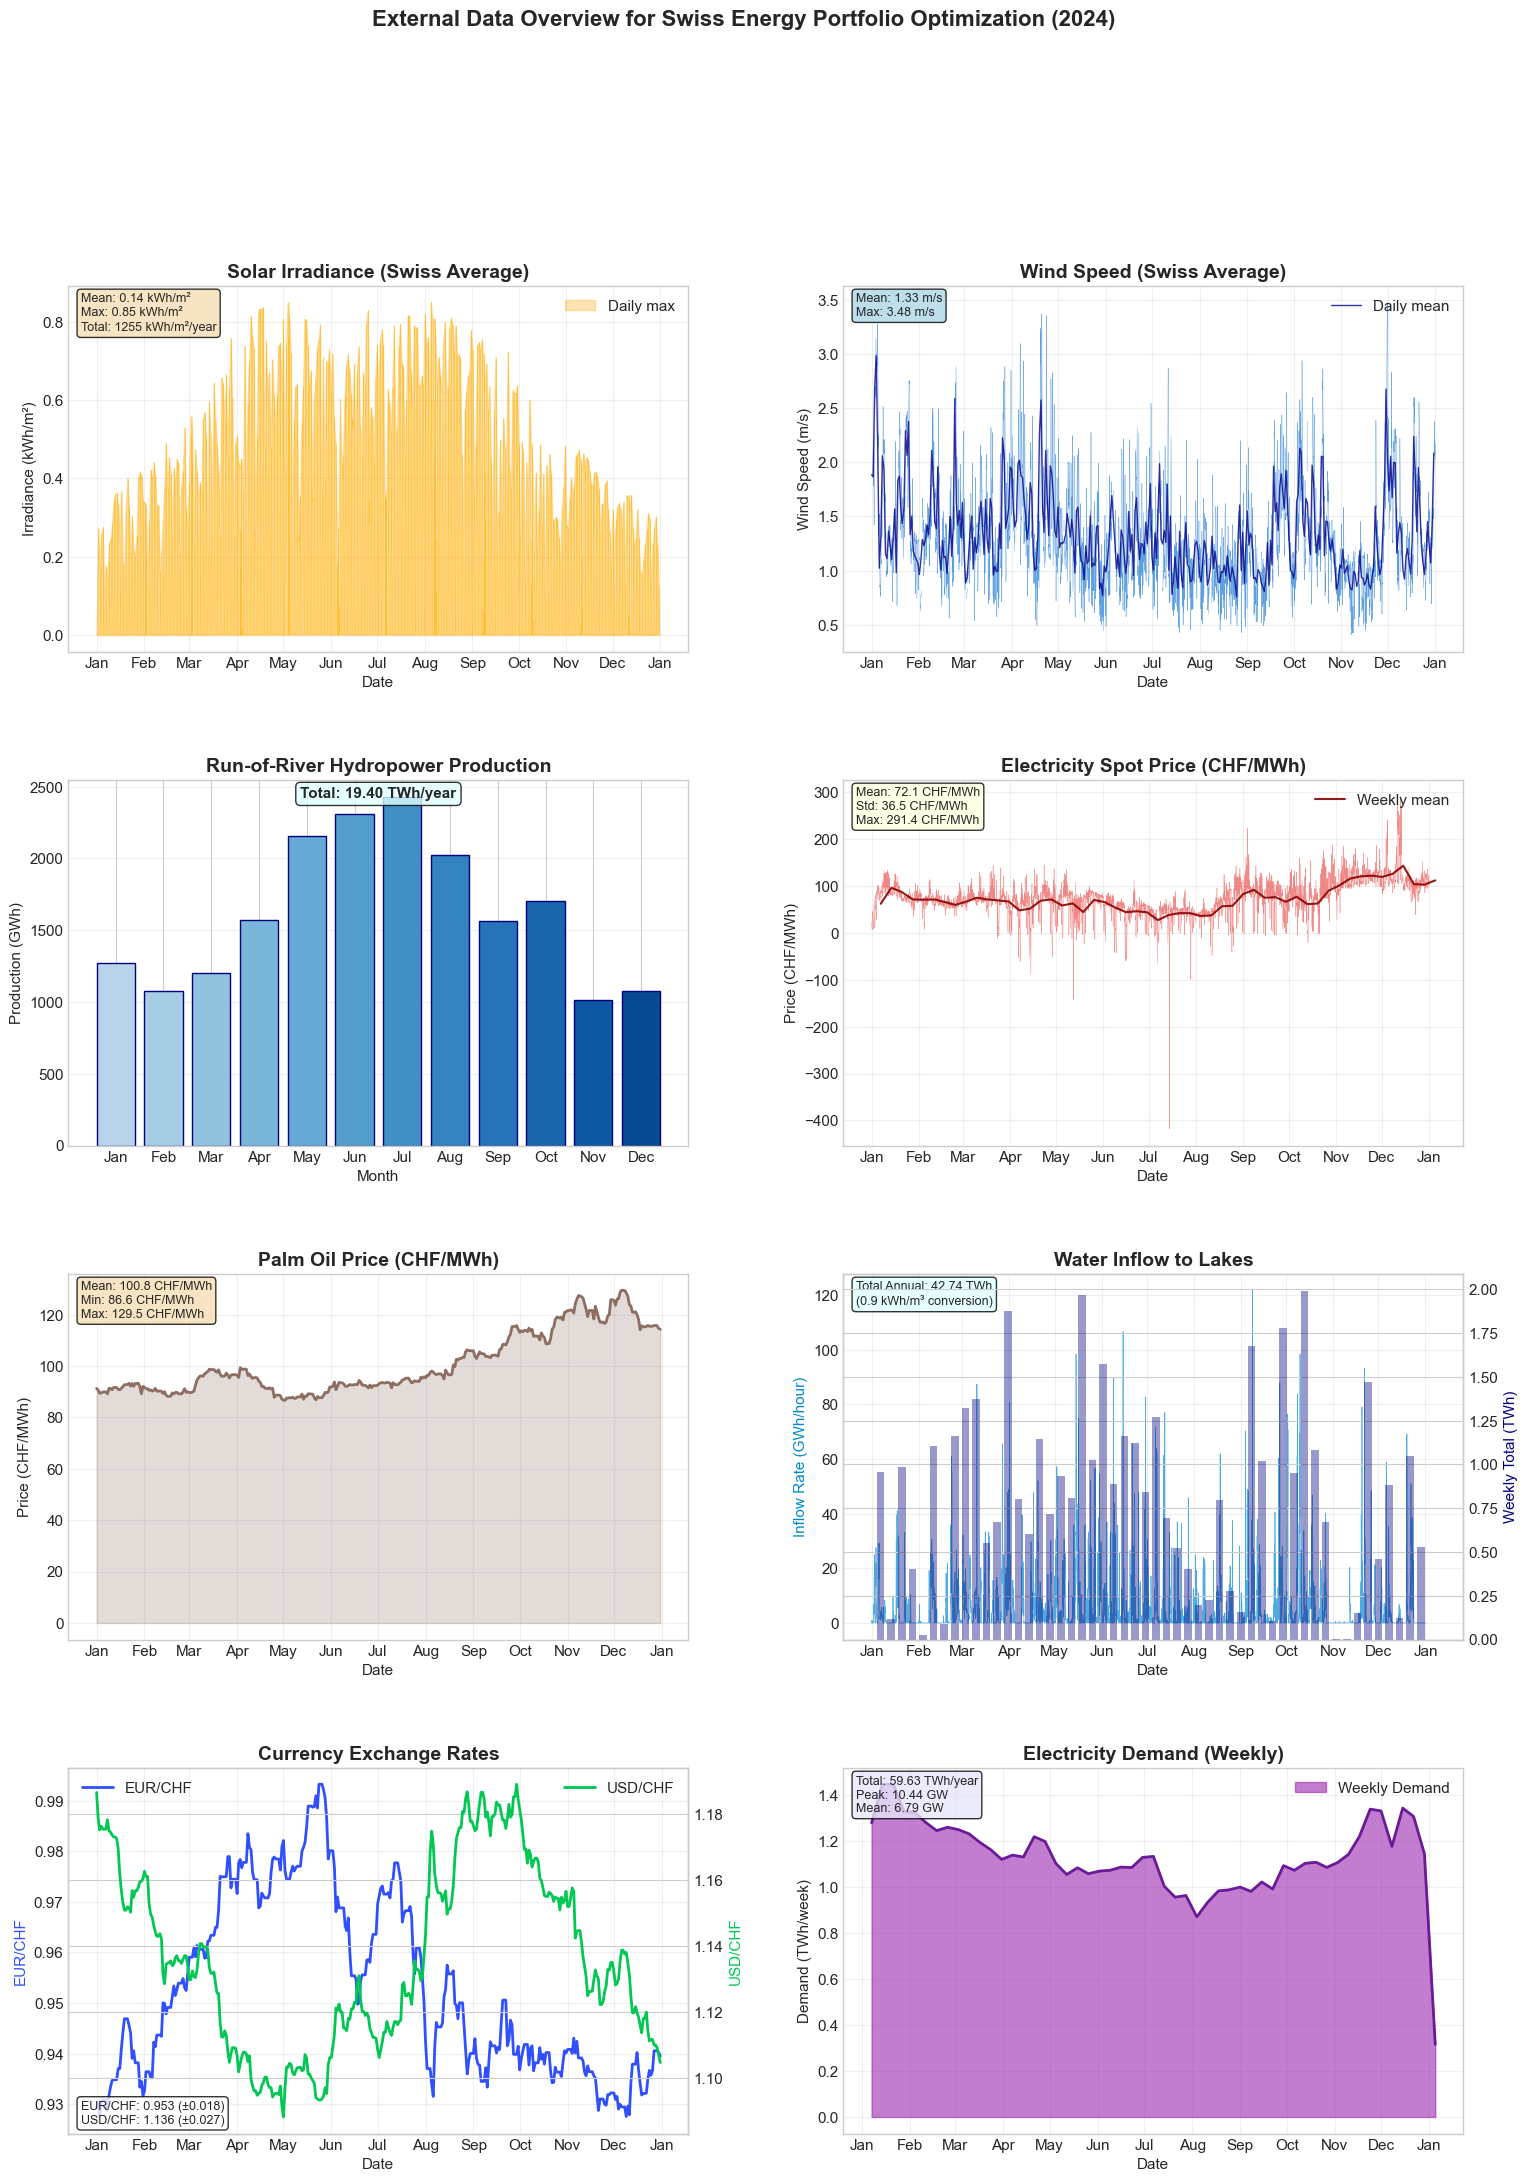


✅ External data overview saved to: data/result_plots/external_data_overview.png


In [116]:
# =============================================================================
# SECTION 0: EXTERNAL DATA OVERVIEW
# =============================================================================
# This cell generates overview plots for all external input data

# Create time indices
n_hours = len(cached_data.get_demand())
hours = pd.date_range('2024-01-01', periods=n_hours, freq='h')
days = pd.date_range('2024-01-01', periods=366, freq='D')

# Get data
solar_data = cached_data.get_solar_incidence(copy=False)
wind_data = cached_data.get_wind_incidence(copy=False)
spot_prices = cached_data.get_spot_prices(copy=False)
demand = cached_data.get_demand(copy=False)
water_inflow = cached_data.get_water_inflow(copy=False)
palm_oil_prices = cached_data.get_palm_oil_prices_daily(copy=False)
eur_chf = cached_data.eur_chf_daily
usd_chf = cached_data.usd_chf_daily
ror_production = cached_data.ror_production  # Monthly RoR

# Calculate spatial averages for solar and wind
solar_avg = np.nanmean(solar_data, axis=1)  # Average across locations per hour
wind_avg = np.nanmean(wind_data, axis=1)    # Average across locations per hour

# Create figure with subplots
fig = plt.figure(figsize=(18, 24))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.25)

# -----------------------------------------------------------------------------
# Plot 1: Solar Irradiance (kWh/m²)
# -----------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(hours[:len(solar_avg)], solar_avg, color='#FFB300', alpha=0.7, linewidth=0.3)
# Add daily max envelope
daily_max = pd.Series(solar_avg[:len(hours)], index=hours[:len(solar_avg)]).resample('D').max()
ax1.fill_between(daily_max.index, daily_max.values, alpha=0.3, color='orange', label='Daily max')
ax1.set_title('Solar Irradiance (Swiss Average)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Irradiance (kWh/m²)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.nanmean(solar_avg):.2f} kWh/m²\nMax: {np.nanmax(solar_avg):.2f} kWh/m²\nTotal: {np.nansum(solar_avg):.0f} kWh/m²/year"
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 2: Wind Speed (m/s)
# -----------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(hours[:len(wind_avg)], wind_avg, color='#1976D2', alpha=0.7, linewidth=0.3)
# Add daily mean
daily_mean_wind = pd.Series(wind_avg[:len(hours)], index=hours[:len(wind_avg)]).resample('D').mean()
ax2.plot(daily_mean_wind.index, daily_mean_wind.values, color='darkblue', alpha=0.8, linewidth=1, label='Daily mean')
ax2.set_title('Wind Speed (Swiss Average)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Wind Speed (m/s)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.nanmean(wind_avg):.2f} m/s\nMax: {np.nanmax(wind_avg):.2f} m/s"
ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 3: Run of River (Monthly)
# -----------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
from matplotlib import cm
colors_ror = cm.get_cmap('Blues')(np.linspace(0.3, 0.9, 12))
bars = ax3.bar(months, ror_production[:12], color=colors_ror, edgecolor='navy', linewidth=1)
ax3.set_title('Run-of-River Hydropower Production', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Production (GWh)')
ax3.grid(True, alpha=0.3, axis='y')

# Add total annotation
total_ror = np.sum(ror_production[:12])
ax3.annotate(f'Total: {total_ror/1000:.2f} TWh/year', xy=(0.5, 0.95), xycoords='axes fraction',
             fontsize=11, ha='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 4: Electricity Spot Price (CHF/MWh)
# -----------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(hours[:len(spot_prices)], spot_prices, color='#E53935', alpha=0.6, linewidth=0.3)
# Add weekly mean
weekly_mean = pd.Series(spot_prices[:len(hours)], index=hours[:len(spot_prices)]).resample('W').mean()
ax4.plot(weekly_mean.index, weekly_mean.values, color='darkred', alpha=0.9, linewidth=1.5, label='Weekly mean')
ax4.set_title('Electricity Spot Price (CHF/MWh)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Price (CHF/MWh)')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.mean(spot_prices):.1f} CHF/MWh\nStd: {np.std(spot_prices):.1f} CHF/MWh\nMax: {np.max(spot_prices):.1f} CHF/MWh"
ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 5: Palm Oil Price (CHF/MWh)
# -----------------------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 0])
days_palm = days[:len(palm_oil_prices)]
ax5.plot(days_palm, palm_oil_prices, color='#8D6E63', linewidth=2, marker='', label='Palm Oil (CHF/MWh)')
ax5.fill_between(days_palm, palm_oil_prices, alpha=0.3, color='#A1887F')
ax5.set_title('Palm Oil Price (CHF/MWh)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price (CHF/MWh)')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.grid(True, alpha=0.3)

# Stats box
stats_text = f"Mean: {np.mean(palm_oil_prices):.1f} CHF/MWh\nMin: {np.min(palm_oil_prices):.1f} CHF/MWh\nMax: {np.max(palm_oil_prices):.1f} CHF/MWh"
ax5.text(0.02, 0.98, stats_text, transform=ax5.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 6: Water Inflow to Lakes (MWh/hour)
# -----------------------------------------------------------------------------
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(hours[:len(water_inflow)], water_inflow/1000, color='#0288D1', alpha=0.7, linewidth=0.5)  # Convert to GWh
# Add weekly sum
weekly_sum = pd.Series(water_inflow[:len(hours)], index=hours[:len(water_inflow)]).resample('W').sum()
ax6_twin = ax6.twinx()
ax6_twin.bar(weekly_sum.index, weekly_sum.values/1e6, width=5, alpha=0.4, color='navy', label='Weekly total (TWh)')
ax6.set_title('Water Inflow to Lakes', fontsize=14, fontweight='bold')
ax6.set_xlabel('Date')
ax6.set_ylabel('Inflow Rate (GWh/hour)', color='#0288D1')
ax6_twin.set_ylabel('Weekly Total (TWh)', color='navy')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax6.xaxis.set_major_locator(mdates.MonthLocator())
ax6.grid(True, alpha=0.3)

# Stats box
total_inflow_twh = np.sum(water_inflow) / 1e6
stats_text = f"Total Annual: {total_inflow_twh:.2f} TWh\n(0.9 kWh/m³ conversion)"
ax6.text(0.02, 0.98, stats_text, transform=ax6.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 7: Currency Exchange Rates
# -----------------------------------------------------------------------------
ax7 = fig.add_subplot(gs[3, 0])
ax7.plot(days[:len(eur_chf)], eur_chf, color='#304FFE', linewidth=2, label='EUR/CHF')
ax7_twin = ax7.twinx()
ax7_twin.plot(days[:len(usd_chf)], usd_chf, color='#00C853', linewidth=2, label='USD/CHF')
ax7.set_title('Currency Exchange Rates', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('EUR/CHF', color='#304FFE')
ax7_twin.set_ylabel('USD/CHF', color='#00C853')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax7.xaxis.set_major_locator(mdates.MonthLocator())
ax7.legend(loc='upper left')
ax7_twin.legend(loc='upper right')
ax7.grid(True, alpha=0.3)

# Stats box
stats_text = f"EUR/CHF: {np.mean(eur_chf):.3f} (±{np.std(eur_chf):.3f})\nUSD/CHF: {np.mean(usd_chf):.3f} (±{np.std(usd_chf):.3f})"
ax7.text(0.02, 0.02, stats_text, transform=ax7.transAxes, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# -----------------------------------------------------------------------------
# Plot 8: Demand vs Supply Overview
# -----------------------------------------------------------------------------
ax8 = fig.add_subplot(gs[3, 1])
demand_weekly = pd.Series(demand[:len(hours)], index=hours[:len(demand)]).resample('W').sum() / 1e6  # TWh
ax8.fill_between(demand_weekly.index, demand_weekly.values, alpha=0.6, color='#9C27B0', label='Weekly Demand')
ax8.plot(demand_weekly.index, demand_weekly.values, color='#6A1B9A', linewidth=2)
ax8.set_title('Electricity Demand (Weekly)', fontsize=14, fontweight='bold')
ax8.set_xlabel('Date')
ax8.set_ylabel('Demand (TWh/week)')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax8.xaxis.set_major_locator(mdates.MonthLocator())
ax8.legend(loc='upper right')
ax8.grid(True, alpha=0.3)

# Stats box
total_demand_twh = np.sum(demand) / 1e6
stats_text = f"Total: {total_demand_twh:.2f} TWh/year\nPeak: {np.max(demand)/1000:.2f} GW\nMean: {np.mean(demand)/1000:.2f} GW"
ax8.text(0.02, 0.98, stats_text, transform=ax8.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))

# Add overall title
fig.suptitle('External Data Overview for Swiss Energy Portfolio Optimization (2024)', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('data/result_plots/external_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ External data overview saved to: data/result_plots/external_data_overview.png")


---

# Section 1: Dispatch Simulation

This section runs a full year (8760 hours) dispatch simulation for a given portfolio.

## Renewable Production Model: DISTRIBUTED DEPLOYMENT

Unlike concentrated deployment (all capacity at best locations), this model simulates **realistic distributed deployment**:

### Solar PV
- **Each PPU adds 1,000 m² to EVERY location** (~1,150 locations)
- Total area per PPU: 1,000 m² × 1,150 = **1,150,000 m²** (~1.15 km²)
- Simulates: rooftop solar spread across all of Switzerland

### Wind (Onshore & Offshore)
- **Each PPU adds 1 turbine to EVERY location** (~1,150 locations)
- Total turbines per PPU: 1 × 1,150 = **1,150 turbines**
- Onshore: 3 MW turbines | Offshore: 5 MW turbines
- Simulates: distributed wind farms across all regions

### Grid Resolution
- **0.1° × 0.1°** grid (~11 km × 8 km cells)
- **~1,150 locations** covering Switzerland
- Each cell area: ~84 km²

## Energy System Constraints
- **Annual Electricity Demand:** 59.63 TWh (2050 projection)
- **Aviation Fuel Requirement:** 23 TWh/year synthetic fuel from Fuel Tank (produced by SYN_FT/SYN_CRACK)

## Storage Constraints
| Storage | Base Capacity | Max Cap | RT Efficiency | Notes |
|---------|--------------|---------|---------------|-------|
| Lake | 8.87 TWh (fixed) | - | 77.4% | Physical 2 GW power cap + water inflow |
| H2 UG 200bar | Scales | **50 TWh** | 30% | |
| Liquid H2 | Scales | **50 TWh** | 35% | |
| CH4 200bar | Scales | **50 TWh** | 39% | |
| Ammonia | Scales | **50 TWh** | 29.25% | |
| Fuel Tank | Scales | **25 TWh** | 35% | Also supplies aviation fuel |
| Biogas | Scales | **25 TWh** | 49% | |
| Palm oil | 500 GWh | - | 30% | Ghost PPU import (only bio-fuel) |

## Utility-Based Dispatch Logic

All storages **self-regulate** around their **target SoC (60%)** using the disposition index:

$$d = \tanh\left(\frac{\text{SoC} - \text{target}}{\text{max\_excursion}}\right)$$

| SoC | Disposition | Behavior |
|-----|-------------|----------|
| 0% | d = -1 | **Wants to charge** |
| 60% | d = 0 | Neutral (at target) |
| 100% | d = +1 | **Wants to discharge** |

### Surplus Distribution (Renewable > Demand)
- **Proportional** to charge willingness × efficiency
- `charge_willingness = max(0, 0.5 - d)` → storages below target get MORE
- No fixed priority order - all storages compete proportionally

### Deficit Coverage (Renewable < Demand)  
- **Cost merit order** with disposition penalty
- `effective_cost = base_cost + penalty(d)` → low SoC storages are "expensive"
- Cheapest sources dispatched first, protecting low storages

### Ghost PPU Mechanism (Palm oil only)
- Palm oil is the **only imported bio-fuel** (Biooil removed)
- Participates in **proportional** surplus distribution (not fixed %)
- Its share is sold on spot market → revenue buys palm oil at dynamic price
- Price from REA Holdings futures (USD/ton → CHF/MWh via exchange rates)
- Storage self-regulates like all others around 60% target SoC

---


In [117]:
# =============================================================================
# SECTION 1.1: Define Test Portfolio
# =============================================================================

# Example portfolio for testing (can be modified)
# NOTE: BIO_OIL_ICE removed - Palm oil is the only imported bio-fuel
# ⚠️ CONSTRAINT: THERM must be ≥263 for aviation fuel compliance (23 TWh/year)
test_portfolio = {
    # Renewable (incidence-based)
    'PV': 400, 'WD_ON': 50, 'WD_OFF': 50, 'HYD_R': 50, 'BIO_WOOD': 50,
    # Storage input (each PPU charges a specific storage)
    'PHS': 0,  # Charges Lake - set to 0 to test water inflow only
    'H2_G': 500, 'H2_GL': 500, 'H2_L': 500,  # Charge H2 storages
    'SYN_FT': 2000, 'SYN_CRACK': 2000,  # Charge Fuel Tank (aviation)
    'SYN_METH': 1000,  # Charges CH4 200bar
    'NH3_FULL': 700,  # Charges Ammonia
    'CH4_BIO': 500,  # Charges Biogas
    'SOL_SALT_STORE': 100,  # Charges Solar salt (ADDED - was missing!)
    # Storage extraction (dispatchable)
    'HYD_S': 300, 'THERM': 1000, 'H2P_G': 100, 'H2P_L': 100,  # THERM ≥263 for aviation
    'THERM_CH4': 100, 'NH3_P': 100, 'IMP_BIOG': 100, 'PALM_ICE': 100,
    'SOL_SALT': 100, 'SOL_STEAM': 100,  # Extract from Solar salt
}

print("Test Portfolio Configuration:")
print("=" * 60)
total_units = sum(test_portfolio.values())
print(f"Total PPU units: {total_units}")
renewable = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
storage_in = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_CRACK', 'SYN_METH', 'NH3_FULL', 'CH4_BIO', 'SOL_SALT_STORE']
storage_out = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'THERM_CH4', 'NH3_P', 'IMP_BIOG', 'PALM_ICE', 'SOL_SALT', 'SOL_STEAM']
print(f"  Renewable: {sum(test_portfolio.get(p, 0) for p in renewable)} units")
print(f"  Storage Input: {sum(test_portfolio.get(p, 0) for p in storage_in)} units")
print(f"  Storage Extraction: {sum(test_portfolio.get(p, 0) for p in storage_out)} units")

# =========================================================================
# COMPLIANCE CHECK: Verify test portfolio meets ALL hard constraints
# =========================================================================
print("\n🔍 CONSTRAINT COMPLIANCE CHECK:")
print("-" * 60)

# 1. Aviation Fuel Constraint
MIN_THERM_FOR_AVIATION = 263
therm_count = test_portfolio.get('THERM', 0)
syn_ft_count = test_portfolio.get('SYN_FT', 0)
syn_crack_count = test_portfolio.get('SYN_CRACK', 0)

aviation_compliant = (
    therm_count >= MIN_THERM_FOR_AVIATION and 
    (syn_ft_count > 0 or syn_crack_count > 0)
)

if aviation_compliant:
    print(f"✅ Aviation Fuel: PASS")
    print(f"   - THERM: {therm_count} (≥{MIN_THERM_FOR_AVIATION} required)")
    print(f"   - SYN_FT: {syn_ft_count}, SYN_CRACK: {syn_crack_count}")
else:
    print(f"❌ Aviation Fuel: FAIL")
    print(f"   - THERM: {therm_count} (need ≥{MIN_THERM_FOR_AVIATION})")
    print(f"   - Synthetic fuel producers: SYN_FT={syn_ft_count}, SYN_CRACK={syn_crack_count}")
    print(f"   ⚠️  This portfolio will be penalized during optimization!")

# 2. Electrical Sovereignty (will be checked in dispatch simulation)
print(f"⏳ Electrical Sovereignty (≥113 TWh/year): Check after simulation")

# 3. Cyclic SOC (will be checked in dispatch simulation)
print(f"⏳ Cyclic SOC (storage returns to initial): Check after simulation")
print("-" * 60)


Test Portfolio Configuration:
Total PPU units: 10500
  Renewable: 600 units
  Storage Input: 7800 units
  Storage Extraction: 2100 units

🔍 CONSTRAINT COMPLIANCE CHECK:
------------------------------------------------------------
✅ Aviation Fuel: PASS
   - THERM: 1000 (≥263 required)
   - SYN_FT: 2000, SYN_CRACK: 2000
⏳ Electrical Sovereignty (≥113 TWh/year): Check after simulation
⏳ Cyclic SOC (storage returns to initial): Check after simulation
------------------------------------------------------------


In [118]:
# =============================================================================
# SECTION 1.2: Run Full Year Dispatch Simulation
# =============================================================================

print("Running full year dispatch simulation (8760 hours)...")
print("=" * 60)

# Create Portfolio and Individual objects from dictionary
from ppu_framework import Portfolio
from optimization import Individual

test_individual = Individual(
    portfolio=Portfolio(ppu_counts=test_portfolio)
)

# Run full year evaluation
full_year_results = evaluate_portfolio_full_year(
    individual=test_individual,
    config=config,
    verbose=True
)

print("\n" + "=" * 60)
print("DISPATCH SIMULATION RESULTS")
print("=" * 60)

# Energy Balance
total_demand = np.sum(full_year_results.demand) / 1e6
total_production = np.sum(full_year_results.total_production) / 1e6
total_renewable = np.sum(full_year_results.renewable_production) / 1e6
total_bought = np.sum(full_year_results.spot_bought) / 1e6
total_sold = np.sum(full_year_results.spot_sold) / 1e6

print(f"\n📊 Energy Balance:")
print(f"   Total Demand:      {total_demand:>10.2f} TWh")
print(f"   Total Production:  {total_production:>10.2f} TWh")
print(f"   Renewable Only:    {total_renewable:>10.2f} TWh ({100*total_renewable/total_demand:.1f}%)")
print(f"   Spot Bought:       {total_bought:>10.2f} TWh")
print(f"   Spot Sold:         {total_sold:>10.2f} TWh")

# Renewable vs Demand (before storage)
ren = full_year_results.renewable_production
dem = full_year_results.demand
print(f"\n🔍 Renewable vs Demand (before storage):")
print(f"   Gap to fill:       {(np.sum(dem)-np.sum(ren))/1e6:>10.2f} TWh")
print(f"   Hours surplus:     {np.sum(ren > dem):>10} ({100*np.sum(ren>dem)/len(dem):.1f}%)")
print(f"   Hours deficit:     {np.sum(ren < dem):>10} ({100*np.sum(ren<dem)/len(dem):.1f}%)")

# Aviation Fuel (from Fuel Tank - synthetic fuel)
if hasattr(full_year_results, 'aviation_fuel_consumed_mwh'):
    consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
    shortfall = full_year_results.aviation_fuel_shortfall_mwh / 1e6 if hasattr(full_year_results, 'aviation_fuel_shortfall_mwh') else 0
    production_cost = full_year_results.aviation_fuel_import_cost_chf / 1e9 if hasattr(full_year_results, 'aviation_fuel_import_cost_chf') else 0
    print(f"\n✈️  Aviation Fuel (from Fuel Tank - synthetic):")
    print(f"   Required:          {23.0:>10.2f} TWh/year")
    print(f"   Consumed:          {consumed:>10.2f} TWh")
    print(f"   Shortfall:         {shortfall:>10.2f} TWh")
    print(f"   Production Cost:   {production_cost:>10.2f} B CHF")
    print(f"   Constraint Met:    {'✅ Yes' if full_year_results.aviation_fuel_constraint_met else '❌ No'}")

print("\n" + "=" * 60)


Running full year dispatch simulation (8760 hours)...
FULL YEAR EVALUATION

Loading full year data...
Loading PPU definitions...
Simulating 8784 hours (366 days)...

FULL YEAR RESULTS
Total Demand:     59.6 TWh
Total Production: 134.4 TWh
Coverage Ratio:   225.4%

Spot Market:
  Bought: 10.52 TWh
  Sold:   28.59 TWh
  Net Cost: -584.6 M CHF

Deficit Analysis:
  Hours in deficit: 5221 (59.4%)
  Peak deficit: 4,086 MW

CONSTRAINT COMPLIANCE (3 Hard Constraints)

1️⃣  Electrical Sovereignty (≥113 TWh/year):
   Production: 134.4 TWh
   Required:   113.0 TWh
   Constraint: ✅ YES

2️⃣  Aviation Fuel (23 TWh/year synthetic):
   Required:  23.0 TWh/year
   Consumed:  23.06 TWh (100.3%)
   Shortfall: 0.00 TWh
   Import Cost: 1,383.8 M CHF
   Constraint: ✅ YES

3️⃣  Cyclic State of Charge (±25% of initial):
   Constraint: ❌ NO
   Penalty: 444,288,254 CHF
   ⚠️  Lake: 60.0% → 95.1% (deviation: 35.1%, max: 15.0%)
   ⚠️  Fuel Tank: 60.0% → 31.2% (deviation: 28.8%, max: 15.0%)
   ⚠️  H2 UG 200bar: 5

In [119]:
# =============================================================================
# SECTION 1.2b: Incidence vs Demand Analysis (Before Storage)
# =============================================================================

print("=" * 70)
print("INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)")
print("=" * 70)

# Get hourly data
ren = full_year_results.renewable_production  # Incidence-based only
dem = full_year_results.demand
balance = ren - dem  # Positive = surplus, Negative = deficit

# Hourly statistics
surplus_hours = balance > 0
deficit_hours = balance < 0
balanced_hours = balance == 0

surplus_total = np.sum(balance[surplus_hours]) / 1e6  # TWh
deficit_total = -np.sum(balance[deficit_hours]) / 1e6  # TWh (positive value)

print(f"\n📊 HOURLY BREAKDOWN:")
print(f"   Hours with SURPLUS (ren > dem):  {np.sum(surplus_hours):>6} ({100*np.mean(surplus_hours):>5.1f}%)")
print(f"   Hours with DEFICIT (ren < dem):  {np.sum(deficit_hours):>6} ({100*np.mean(deficit_hours):>5.1f}%)")
print(f"   Hours balanced:                  {np.sum(balanced_hours):>6} ({100*np.mean(balanced_hours):>5.1f}%)")

print(f"\n⚡ ENERGY VOLUMES:")
print(f"   Total Incidence (Renewable):     {np.sum(ren)/1e6:>8.2f} TWh")
print(f"   Total Demand:                    {np.sum(dem)/1e6:>8.2f} TWh")
print(f"   -------------------------------------------")
print(f"   Net Gap (Demand - Incidence):    {(np.sum(dem)-np.sum(ren))/1e6:>8.2f} TWh")

print(f"\n🔋 WHAT STORAGE/DISPATCH MUST DO:")
print(f"   Energy from surplus hours:       {surplus_total:>8.2f} TWh (storable)")
print(f"   Energy needed in deficit hours:  {deficit_total:>8.2f} TWh (from storage/dispatch)")

# Peak analysis
peak_surplus = np.max(balance) / 1e3 if np.any(surplus_hours) else 0  # GW
peak_deficit = -np.min(balance) / 1e3 if np.any(deficit_hours) else 0  # GW
mean_deficit = -np.mean(balance[deficit_hours]) / 1e3 if np.any(deficit_hours) else 0  # GW

print(f"\n📈 PEAK ANALYSIS:")
print(f"   Peak Surplus Power:              {peak_surplus:>8.2f} GW")
print(f"   Peak Deficit Power:              {peak_deficit:>8.2f} GW")
print(f"   Mean Deficit (during def hrs):   {mean_deficit:>8.2f} GW")

# Monthly breakdown
print(f"\n📅 MONTHLY BREAKDOWN:")
print("-" * 70)
print(f"{'Month':<10} {'Incidence':<12} {'Demand':<12} {'Balance':<12} {'Status':<15}")
print("-" * 70)

# Assume 2024 (leap year) data
days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

start_hour = 0
for month_idx, (days, name) in enumerate(zip(days_per_month, month_names)):
    end_hour = start_hour + days * 24
    if end_hour > len(dem):
        end_hour = len(dem)
    
    month_ren = np.sum(ren[start_hour:end_hour]) / 1e6
    month_dem = np.sum(dem[start_hour:end_hour]) / 1e6
    month_bal = month_ren - month_dem
    status = "✅ SURPLUS" if month_bal > 0 else "⚠️  DEFICIT"
    
    print(f"{name:<10} {month_ren:>10.2f}  {month_dem:>10.2f}  {month_bal:>+10.2f}  {status}")
    start_hour = end_hour

print("-" * 70)
print(f"{'TOTAL':<10} {np.sum(ren)/1e6:>10.2f}  {np.sum(dem)/1e6:>10.2f}  {(np.sum(ren)-np.sum(dem))/1e6:>+10.2f} TWh")
print("=" * 70)


INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)

📊 HOURLY BREAKDOWN:
   Hours with SURPLUS (ren > dem):    3563 ( 40.6%)
   Hours with DEFICIT (ren < dem):    5221 ( 59.4%)
   Hours balanced:                       0 (  0.0%)

⚡ ENERGY VOLUMES:
   Total Incidence (Renewable):       114.34 TWh
   Total Demand:                       59.63 TWh
   -------------------------------------------
   Net Gap (Demand - Incidence):      -54.72 TWh

🔋 WHAT STORAGE/DISPATCH MUST DO:
   Energy from surplus hours:          85.30 TWh (storable)
   Energy needed in deficit hours:     30.58 TWh (from storage/dispatch)

📈 PEAK ANALYSIS:
   Peak Surplus Power:                 70.36 GW
   Peak Deficit Power:                  9.46 GW
   Mean Deficit (during def hrs):       5.86 GW

📅 MONTHLY BREAKDOWN:
----------------------------------------------------------------------
Month      Incidence    Demand       Balance      Status         
-----------------------------------------------------------------

Saved: data/result_plots/incidence_vs_demand_analysis.png


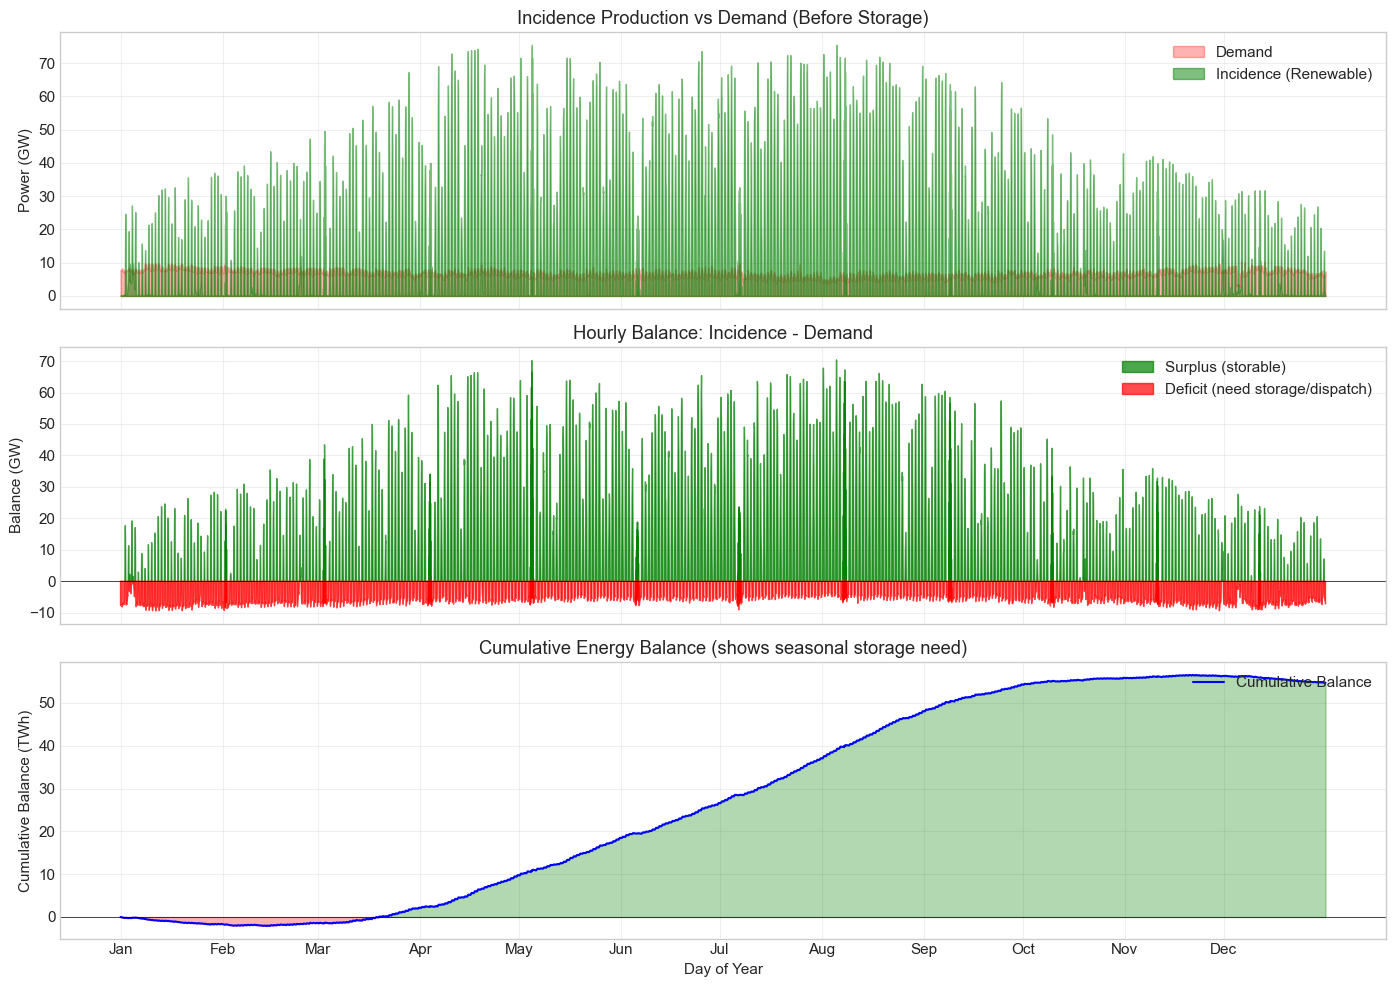


KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.
- Deepest negative point = minimum seasonal storage needed
- In this portfolio: 2.1 TWh seasonal storage required


In [120]:
# =============================================================================
# SECTION 1.2c: Incidence vs Demand Visualization
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Create time axis (days of year)
hours = np.arange(len(dem))
days = hours / 24

# Plot 1: Incidence vs Demand
ax1 = axes[0]
ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
ax1.set_ylabel('Power (GW)')
ax1.set_title('Incidence Production vs Demand (Before Storage)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Balance (Surplus/Deficit)
ax2 = axes[1]
balance_gw = balance / 1e3
ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                  label='Surplus (storable)', color='green', interpolate=True)
ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                  label='Deficit (need storage/dispatch)', color='red', interpolate=True)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Balance (GW)')
ax2.set_title('Hourly Balance: Incidence - Demand')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative Energy Balance
ax3 = axes[2]
cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                  alpha=0.3, color='green')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                  alpha=0.3, color='red')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Day of Year')
ax3.set_ylabel('Cumulative Balance (TWh)')
ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Add month labels
month_starts = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax3.set_xticks(month_starts)
ax3.set_xticklabels(month_labels)

plt.tight_layout()
plt.savefig('data/result_plots/incidence_vs_demand_analysis.png', dpi=150, bbox_inches='tight')
print("Saved: data/result_plots/incidence_vs_demand_analysis.png")
plt.show()

# Summary annotation
print("\n" + "=" * 70)
print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
print("- Deepest negative point = minimum seasonal storage needed")
print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
print("=" * 70)


Saved: data/result_plots/dispatch_production_stack.png


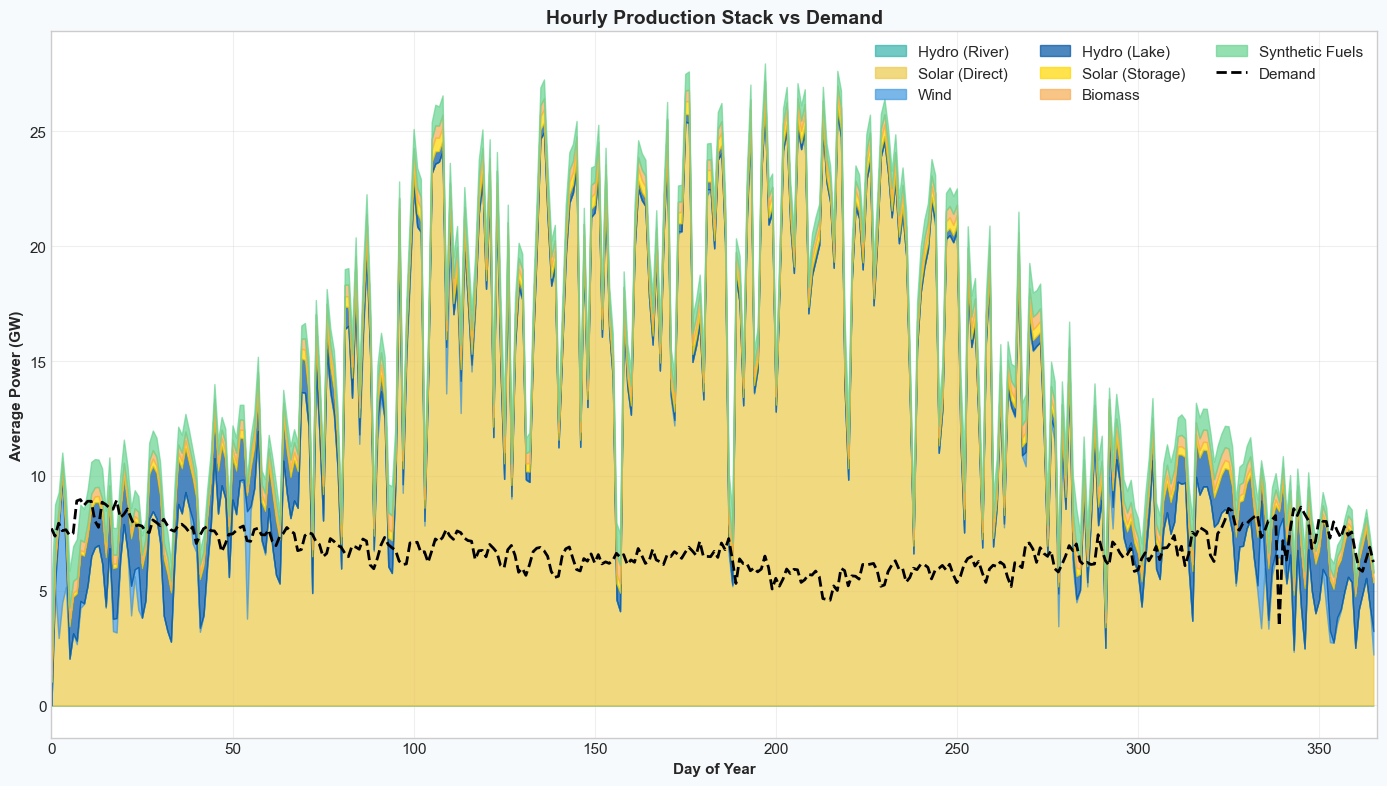

Saved: data/result_plots/dispatch_storage_soc.png


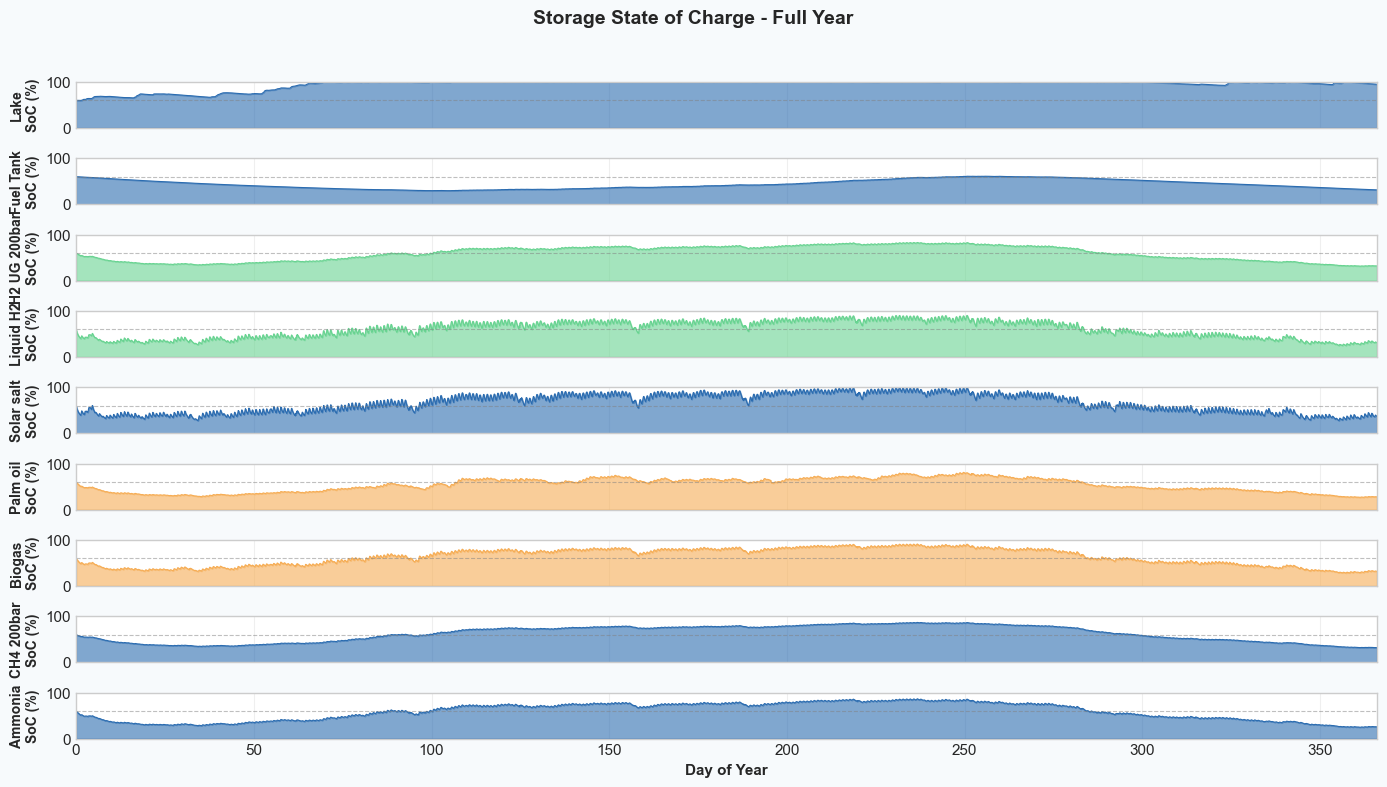

Saved energy balance distribution plot: data/result_plots/dispatch_energy_balance.png


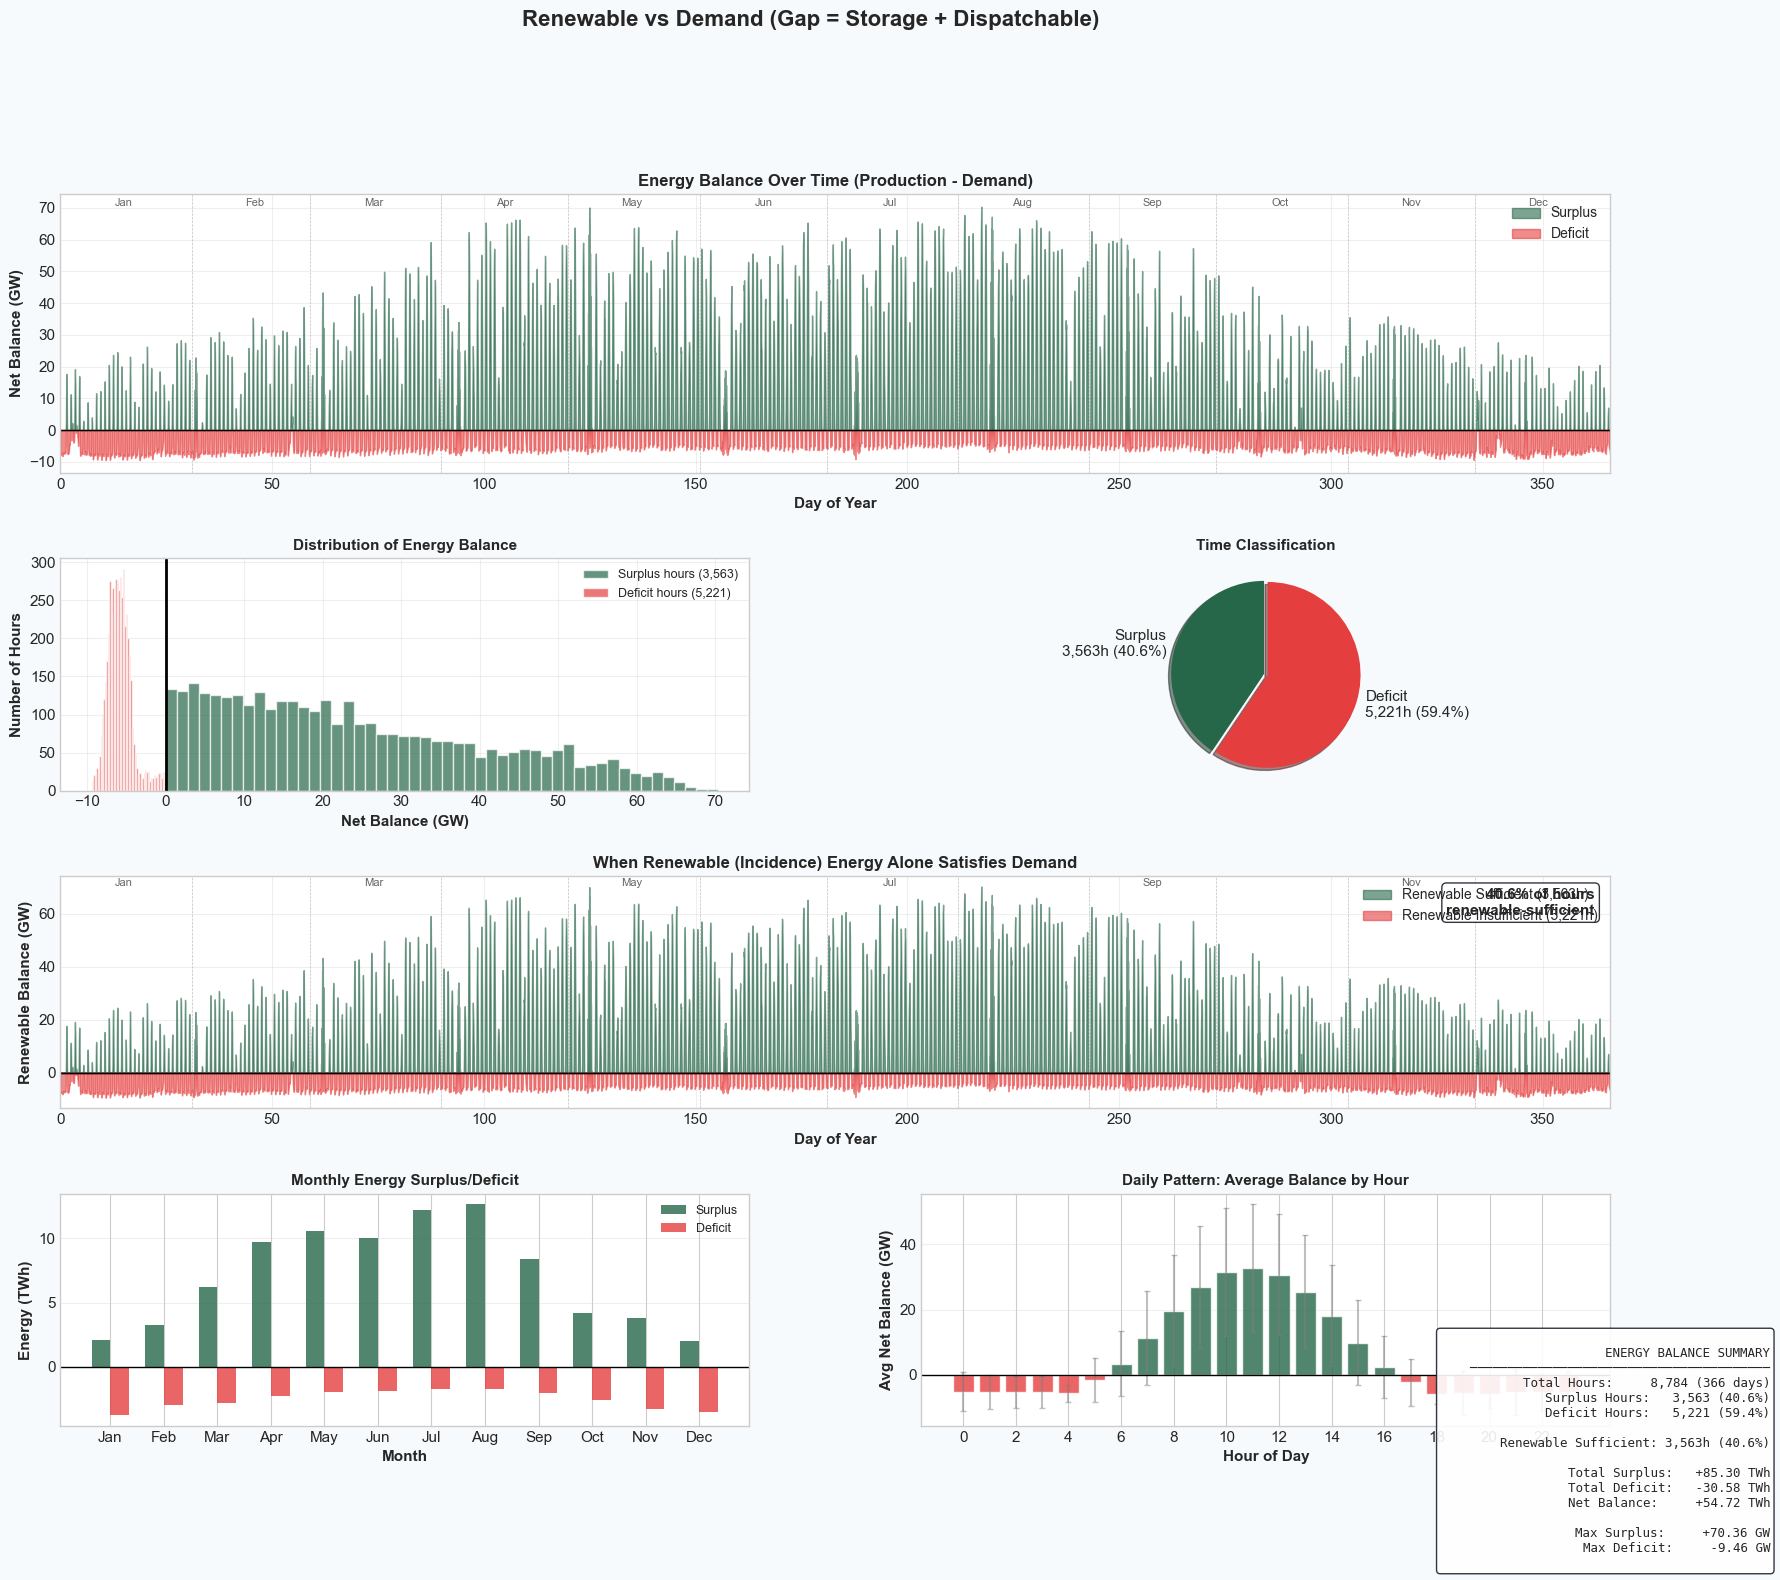

✅ Dispatch visualization complete!


In [121]:
# =============================================================================
# SECTION 1.3: Visualize Dispatch Results
# =============================================================================

# Plot production by source
fig1 = plot_full_year_production_by_source(
    full_year_results,
    title="Hourly Production Stack vs Demand",
    save_path="data/result_plots/dispatch_production_stack.png"
)
plt.show()

# Plot storage state of charge
fig2 = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/dispatch_storage_soc.png"
)
plt.show()

# Plot renewable vs demand balance
fig3 = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.renewable_production,
    renewable_production=full_year_results.renewable_production,
    title="Renewable vs Demand (Gap = Storage + Dispatchable)",
    save_path="data/result_plots/dispatch_energy_balance.png"
)
plt.show()

print("✅ Dispatch visualization complete!")


---

# Section 2: Genetic Optimizer

This section uses genetic algorithms to find optimal portfolios.

## System Constraints

### 1. Energy Demand Constraints
| Constraint | Value | Description |
|------------|-------|-------------|
| **Annual Electricity Demand** | 113 TWh/year | 2050 target (Switzerland) |
| **Aviation Fuel Requirement** | 23 TWh/year | Synthetic fuel from Fuel Tank (~2,626 MWh/h) |
| **Energy Sovereignty** | 100% | Must meet demand from portfolio |

### 2. Portfolio Bounds (Unit = 10 MW)
| PPU Type | Min | Max (Hard Cap) | Notes |
|----------|-----|----------------|-------|
| **Renewable** | | | |
| PV | 0 | 1,000 | Up to 10 GW |
| WD_ON | 0 | 1,000 | Up to 10 GW |
| WD_OFF | 0 | 1,000 | Up to 10 GW |
| HYD_R | 0 | 300 | Up to 3 GW (Swiss limit) |
| BIO_WOOD | 0 | 1,000 | Up to 10 GW |
| **Flex/Storage** | | | |
| HYD_S | 0 | 300 | Limited by Lake 2 GW cap |
| PHS | 0 | 1,000 | Pumped hydro |
| H2_G, H2_GL, H2_L | 0 | 1,000 | Hydrogen storage chains |
| SYN_METH, SYN_FT | 0 | 1,000 | Synthetic fuel |
| NH3_FULL | 0 | 1,000 | Ammonia storage |
| THERM, THERM_CH4 | 0 | 1,000 | Thermal generation |

### 3. Progressive Cost Caps
Beyond "soft cap" units, costs increase progressively:

$$\text{cost\_multiplier} = 1 + \text{factor} \times \max(0, \text{units} - \text{soft\_cap})$$

| PPU Type | Soft Cap | Factor | Example: 150 units |
|----------|----------|--------|-------------------|
| PV | 50 (0.5 GW) | 0.02%/unit | 1 + 0.0002×100 = 1.02× |
| WD_ON | 50 | 0.03%/unit | 1.03× |
| WD_OFF | 50 | 0.05%/unit | 1.05× |
| HYD_R | 150 (1.5 GW) | 0.1%/unit | No penalty |
| HYD_S, PHS | 150 | 0.1%/unit | Lake-limited |

### 4. Storage Capacity Caps
| Storage | Max Capacity | Notes |
|---------|--------------|-------|
| Lake | 8.87 TWh (fixed) | Swiss physical limit + water inflow |
| H2 UG 200bar | **50 TWh** | Underground caverns |
| Liquid H2 | **50 TWh** | Cryogenic |
| CH4 200bar | **50 TWh** | Compressed methane |
| Ammonia | **50 TWh** | |
| Fuel Tank | **25 TWh** | Synthetic fuel (also supplies aviation) |
| Biogas | **25 TWh** | |
| Palm oil | 0.5 TWh | Ghost PPU import (only bio-fuel) |

### 5. Power Limits
| Storage | Max Power | Notes |
|---------|-----------|-------|
| Lake (HYD_S) | 2 GW | Physical pump/turbine limit |
| H2 UG 200bar | 5 GW | Compressor limit |
| CH4 200bar | 5 GW | |
| Ammonia | 3 GW | Synthesis limit |
| Biogas | 2 GW | |

---

## Genetic Algorithm Parameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| Population | 20-50 | Number of portfolios per generation |
| Generations | 10-50 | Evolution iterations |
| Tournament Size | 3 | Selection pressure |
| Crossover Rate | 0.8 | Offspring generation |
| Mutation Rate | 0.2 | Random exploration |
| Elite Fraction | 0.1 | Top performers preserved |

## Objective Functions
1. **Return:** Maximize `(spot_price - production_cost) / spot_price × 100`
2. **RoT:** Minimize Risk of Technology (supply chain concentration)
3. **Volatility:** Minimize weekly cost standard deviation

---


In [122]:
# =============================================================================
# SECTION 2.1: Display Portfolio Bounds
# =============================================================================

print("Portfolio Bounds (PPU unit limits):")
print("=" * 60)

bounds = config.ppu.PORTFOLIO_BOUNDS
print(f"{'PPU':<15} {'Min':>8} {'Max':>8} {'Soft Cap':>10}")
print("-" * 45)

for ppu, (min_val, max_val) in sorted(bounds.items()):
    soft_cap = config.ppu.PROGRESSIVE_COST_CAPS.get(ppu, {}).get('soft_cap', '-')
    print(f"{ppu:<15} {min_val:>8} {max_val:>8} {str(soft_cap):>10}")

print("\n" + "=" * 60)


Portfolio Bounds (PPU unit limits):
PPU                  Min      Max   Soft Cap
---------------------------------------------
BIO_WOOD               0      100        100
CH4_BIO                0     2000       1000
H2P_G                  0     2000       1000
H2P_L                  0     2000       1000
H2_G                   0     2000       1000
H2_GL                  0     2000       1000
H2_L                   0     2000       1000
HYD_R                  0      300        300
HYD_S                  0      300        150
IMP_BIOG               0     2000       1000
NH3_FULL               0     2000       1000
NH3_P                  0     2000       1000
PALM_ICE               0     2000       1000
PHS                    0     2000       1000
PV                     0     2000       2000
SOL_SALT               0     2000       1000
SOL_SALT_STORE         0     2000       1000
SOL_STEAM              0     2000       1000
SYN_CRACK              0     2000       1000
SYN_FT            

In [123]:
# =============================================================================
# SECTION 2.2: Run Multi-Objective Exploration (GA)
# =============================================================================

from multi_objective_explorer import get_objective_configs

print("=" * 60)
print("3D MULTI-OBJECTIVE GENETIC ALGORITHM")
print("=" * 60)
print()
print("Optimizing simultaneously across THREE dimensions:")
print("  1. RoT (Risk of Technology) - Minimize supply chain risk")
print("  2. Volatility - Minimize cost fluctuations")
print("  3. Return - Maximize economic efficiency")
print()

# Configuration
N_GENERATIONS = 10  # Increase for better coverage
POP_SIZE = 20       # Increase for better diversity
OUTPUT_PATH = "data/result_plots/multi_objective_results.csv"

# Get predefined objectives - now includes 3D multi-objective fitness functions!
objectives = get_objective_configs()

print(f"Running {len(objectives)} different objective combinations:")
print()

# Group objectives by type
obj_3d = [obj for obj in objectives if '3d' in obj.name.lower()]
obj_1d = [obj for obj in objectives if 'only' in obj.name.lower()]
obj_2d = [obj for obj in objectives if obj not in obj_3d and obj not in obj_1d]

if obj_3d:
    print(f"📊 3D Multi-Objective ({len(obj_3d)} objectives):")
    for obj in obj_3d:
        print(f"  • {obj.name}: {obj.description}")
    print()

if obj_1d:
    print(f"📈 Single-Objective ({len(obj_1d)} objectives):")
    for obj in obj_1d:
        print(f"  • {obj.name}: {obj.description}")
    print()

if obj_2d:
    print(f"📉 2D Combined ({len(obj_2d)} objectives):")
    for obj in obj_2d:
        print(f"  • {obj.name}: {obj.description}")
    print()

print(f"Generations per objective: {N_GENERATIONS}")
print(f"Population size: {POP_SIZE}")
print(f"Output: {OUTPUT_PATH}")
print("\n" + "=" * 60)


3D MULTI-OBJECTIVE GENETIC ALGORITHM

Optimizing simultaneously across THREE dimensions:
  1. RoT (Risk of Technology) - Minimize supply chain risk
  2. Volatility - Minimize cost fluctuations
  3. Return - Maximize economic efficiency

Running 9 different objective combinations:

📊 3D Multi-Objective (5 objectives):
  • 3d_balanced: 3D Balanced: Equal weights (RoT, Vol, Return)
  • 3d_stability: 3D Stability: 40% RoT + 40% Vol + 20% Return
  • 3d_return: 3D Return: 60% Return + 20% RoT + 20% Vol
  • 3d_rot_focus: 3D RoT Focus: 60% RoT + 20% Vol + 20% Return
  • 3d_vol_focus: 3D Vol Focus: 60% Vol + 20% RoT + 20% Return

📈 Single-Objective (3 objectives):
  • cost_only: 1D: Minimize cost (maximize return only)
  • rot_only: 1D: Minimize Risk of Technology only
  • volatility_only: 1D: Minimize Volatility only

📉 2D Combined (1 objectives):
  • rot_vol_50_50: 2D: 50% RoT + 50% Vol (no Return)

Generations per objective: 10
Population size: 20
Output: data/result_plots/multi_objective_re

In [124]:
# =============================================================================
# SECTION 2.3: Execute Multi-Objective GA
# =============================================================================

# Run exploration (this can take 30-60 minutes)
all_results_df, pareto_df = explore_and_find_frontier(
    config=config,
    objectives=objectives,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    output_path=OUTPUT_PATH,
    verbose=True,
    use_existing_as_seeds=False
)

print("\n" + "=" * 60)
print(f"✅ Exploration complete!")
print(f"   Total portfolios: {len(all_results_df)}")
print(f"   Frontier portfolios: {len(pareto_df)}")


MULTI-OBJECTIVE PORTFOLIO EXPLORATION
Objectives: 9
Generations per objective: 10
Population size: 20
Shared initial population: True

Generating shared initial population...


Evaluating initial population: 100%|██████████| 20/20 [02:06<00:00,  6.33s/it]


Valid portfolios in initial population: 10/20


Objective: 3d_balanced
Description: 3D Balanced: Equal weights (RoT, Vol, Return)
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.2304
  RoT: 0.4467
  Volatility: 25.17
  Return: -21.98%
Evaluated 189 portfolios for '3d_balanced'

Objective: 3d_stability
Description: 3D Stability: 40% RoT + 40% Vol + 20% Return
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.3524
  RoT: 0.4908
  Volatility: 7.42
  Return: -76.57%
Evaluated 189 portfolios for '3d_stability'

Objective: 3d_return
Description: 3D Return: 60% Return + 20% RoT + 20% Vol
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.1196
  RoT: 0.4420
  Volatility: 19.50
  Return: -4.55%
Evaluated 190 portfolios for '3d_return'

Objective: 3d_rot_focus
Description: 3D RoT Focus: 60% RoT + 20% Vol + 20% Return
Using shared initial population (10 portfolios)
Generation 10/10
Best fitness: 0.4458
 

---

# Section 3: Pareto Frontier Analysis

This section identifies the 3D Pareto frontier and analyzes frontier portfolios.

## Hard Constraints (Applied to ALL Portfolios)

**⚠️ CRITICAL:** Only portfolios that satisfy ALL three hard constraints are considered:

### 1. Aviation Fuel Capacity
- **Requirement:** 23 TWh/year of synthetic aviation fuel (biooil)
- **Implementation:** THERM ≥ 263 units + SYN_FT or SYN_CRACK > 0
- **Discharge:** Continuous hourly discharge from 'Fuel Tank' storage
- **Penalty:** 1e9× for non-compliance

### 2. Cyclic State of Charge (SOC)
- **Requirement:** Storage levels must return to initial state (±5% tolerance)
- **Purpose:** Prevent depletion of initial resources over the year
- **Check:** Final SOC within 5% of initial SOC for all storage types
- **Penalty:** 1e8× for violations

### 3. Electrical Sovereignty
- **Requirement:** ≥113 TWh/year domestic electricity production
- **Purpose:** Energy independence for Switzerland
- **Already enforced** in genetic algorithm

## Pareto Frontier Selection

### Pareto Dominance
Portfolio A dominates Portfolio B if:
- A is at least as good as B in all objectives
- A is strictly better than B in at least one objective

**The Pareto frontier contains all non-dominated, constraint-compliant portfolios.**

### 3D Metrics Definitions
| Metric | Definition | Optimization Goal |
|--------|------------|-------------------|
| **RoT** | Risk of Technology - supply chain concentration (0-1) | Minimize |
| **Volatility** | Weekly std of production costs (CHF/MWh) | Minimize |
| **Return** | (spot_price - production_cost) / spot_price × 100% | Maximize |

---


In [125]:
# =============================================================================
# SECTION 3.1: Find 3D Pareto Frontier (FIXED - with relaxed storage constraint)
# =============================================================================
import pandas as pd
import numpy as np
import json

# NOTE: Since storage_constraint_met was calculated with OLD tolerance (5%),
# we skip it here and only check aviation + sovereignty constraints.
# The storage constraint is RELAXED to ±25% in config but CSV has old values.

def is_portfolio_compliant(portfolio_dict, row) -> bool:
    """
    Check if a portfolio satisfies hard constraints:
    1. Aviation fuel capacity (THERM + SYN_FT/SYN_CRACK)
    2. Electrical sovereignty (113 TWh/year minimum)
    
    NOTE: Storage constraint SKIPPED - CSV was generated with old 5% tolerance.
    Config now has 25% tolerance, but we'd need to re-run evaluation to update.
    """
    # Parse portfolio if needed
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation Fuel Constraint
    # Requires 263 THERM units minimum + some SYN_FT or SYN_CRACK
    MIN_THERM_FOR_AVIATION = 263
    therm_count = portfolio.get('THERM', 0)
    syn_ft_count = portfolio.get('SYN_FT', 0)
    syn_crack_count = portfolio.get('SYN_CRACK', 0)
    
    aviation_compliant = (
        therm_count >= MIN_THERM_FOR_AVIATION and 
        (syn_ft_count > 0 or syn_crack_count > 0)
    )
    
    if not aviation_compliant:
        return False
    
    # 2. STORAGE CONSTRAINT - SKIPPED (would need re-evaluation with new tolerance)
    # The CSV has storage_constraint_met calculated with 5% tolerance
    # Config now has 25%, but we can't recalculate without full simulation
    # Uncomment below to enforce storage constraint from CSV:
    # if 'storage_constraint_met' in row:
    #     if not row['storage_constraint_met']:
    #         return False
    
    # 3. Electrical Sovereignty (113 TWh/year)
    if 'total_domestic_production_twh' in row:
        electrical_compliant = row['total_domestic_production_twh'] >= 113.0
        if not electrical_compliant:
            return False
    
    return True


def find_3d_pareto_frontier(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find 3D Pareto frontier: minimize RoT, minimize volatility, maximize return.
    """
    # =========================================================================
    # STEP 1: FILTER FOR COMPLIANT PORTFOLIOS
    # =========================================================================
    print("🔍 Filtering for compliant portfolios...")
    print("   (Storage constraint SKIPPED - use relaxed frontier)")
    
    compliant_mask = df.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    compliant_df = df[compliant_mask].copy()
    
    print(f"   Total portfolios: {len(df)}")
    print(f"   ✅ Compliant portfolios: {len(compliant_df)}")
    print(f"   ❌ Non-compliant filtered: {len(df) - len(compliant_df)}")
    
    if len(compliant_df) == 0:
        print("\n⚠️ WARNING: No compliant portfolios found!")
        return pd.DataFrame()
    
    # =========================================================================
    # STEP 2: COMPUTE 3D PARETO FRONTIER
    # =========================================================================
    rot = compliant_df['x_RoT'].values
    vol = compliant_df['y_volatility'].values
    ret = compliant_df['z_return'].values
    
    n = len(compliant_df)
    is_pareto = np.ones(n, dtype=bool)
    
    for i in range(n):
        if not is_pareto[i]:
            continue
        
        for j in range(n):
            if i == j or not is_pareto[j]:
                continue
            
            rot_ok = rot[j] <= rot[i]
            vol_ok = vol[j] <= vol[i]
            ret_ok = ret[j] >= ret[i]
            
            rot_better = rot[j] < rot[i]
            vol_better = vol[j] < vol[i]
            ret_better = ret[j] > ret[i]
            
            if rot_ok and vol_ok and ret_ok and (rot_better or vol_better or ret_better):
                is_pareto[i] = False
                break
    
    frontier = compliant_df[is_pareto].copy()
    print(f"\n✅ Found {len(frontier)} portfolios on 3D Pareto frontier")
    return frontier


# =============================================================================
# MAIN EXECUTION
# =============================================================================

# Load results from CSV
RESULTS_PATH = "data/result_plots/multi_objective_results.csv"
all_results_df = pd.read_csv(RESULTS_PATH)
print(f"✅ Loaded {len(all_results_df)} portfolios from {RESULTS_PATH}")

# Find 3D frontier
frontier_3d = find_3d_pareto_frontier(all_results_df)

# Print results (handle empty DataFrame)
print(f"\n3D Pareto Frontier: {len(frontier_3d)} portfolios")

if len(frontier_3d) > 0:
    print(f"\nFrontier ranges:")
    print(f"  RoT: [{frontier_3d['x_RoT'].min():.4f}, {frontier_3d['x_RoT'].max():.4f}]")
    print(f"  Volatility: [{frontier_3d['y_volatility'].min():.2f}, {frontier_3d['y_volatility'].max():.2f}]")
    print(f"  Return: [{frontier_3d['z_return'].min():.2f}%, {frontier_3d['z_return'].max():.2f}%]")
    
    # Save frontier
    frontier_path = "data/result_plots/multi_objective_results_frontier_3d.csv"
    frontier_3d.to_csv(frontier_path, index=False)
    print(f"\n✅ Frontier saved to: {frontier_path}")
else:
    print("\n❌ No frontier to save (empty)")
    print("\nDiagnostic: Check which constraints are failing:")
    
    # Quick diagnostic
    if 'aviation_fuel_constraint_met' in all_results_df.columns:
        avi = all_results_df['aviation_fuel_constraint_met'].sum()
        print(f"   Aviation constraint pass: {avi}/{len(all_results_df)}")
    
    if 'total_domestic_production_twh' in all_results_df.columns:
        sov = (all_results_df['total_domestic_production_twh'] >= 113.0).sum()
        print(f"   Sovereignty constraint pass: {sov}/{len(all_results_df)}")



✅ Loaded 1626 portfolios from data/result_plots/multi_objective_results.csv
🔍 Filtering for compliant portfolios...
   (Storage constraint SKIPPED - use relaxed frontier)
   Total portfolios: 1626
   ✅ Compliant portfolios: 958
   ❌ Non-compliant filtered: 668

✅ Found 61 portfolios on 3D Pareto frontier

3D Pareto Frontier: 61 portfolios

Frontier ranges:
  RoT: [0.4354, 0.4976]
  Volatility: [1.01, 14.67]
  Return: [-115.33%, -63.96%]

✅ Frontier saved to: data/result_plots/multi_objective_results_frontier_3d.csv


✅ Loaded 1626 total portfolios
✅ Loaded 61 frontier portfolios


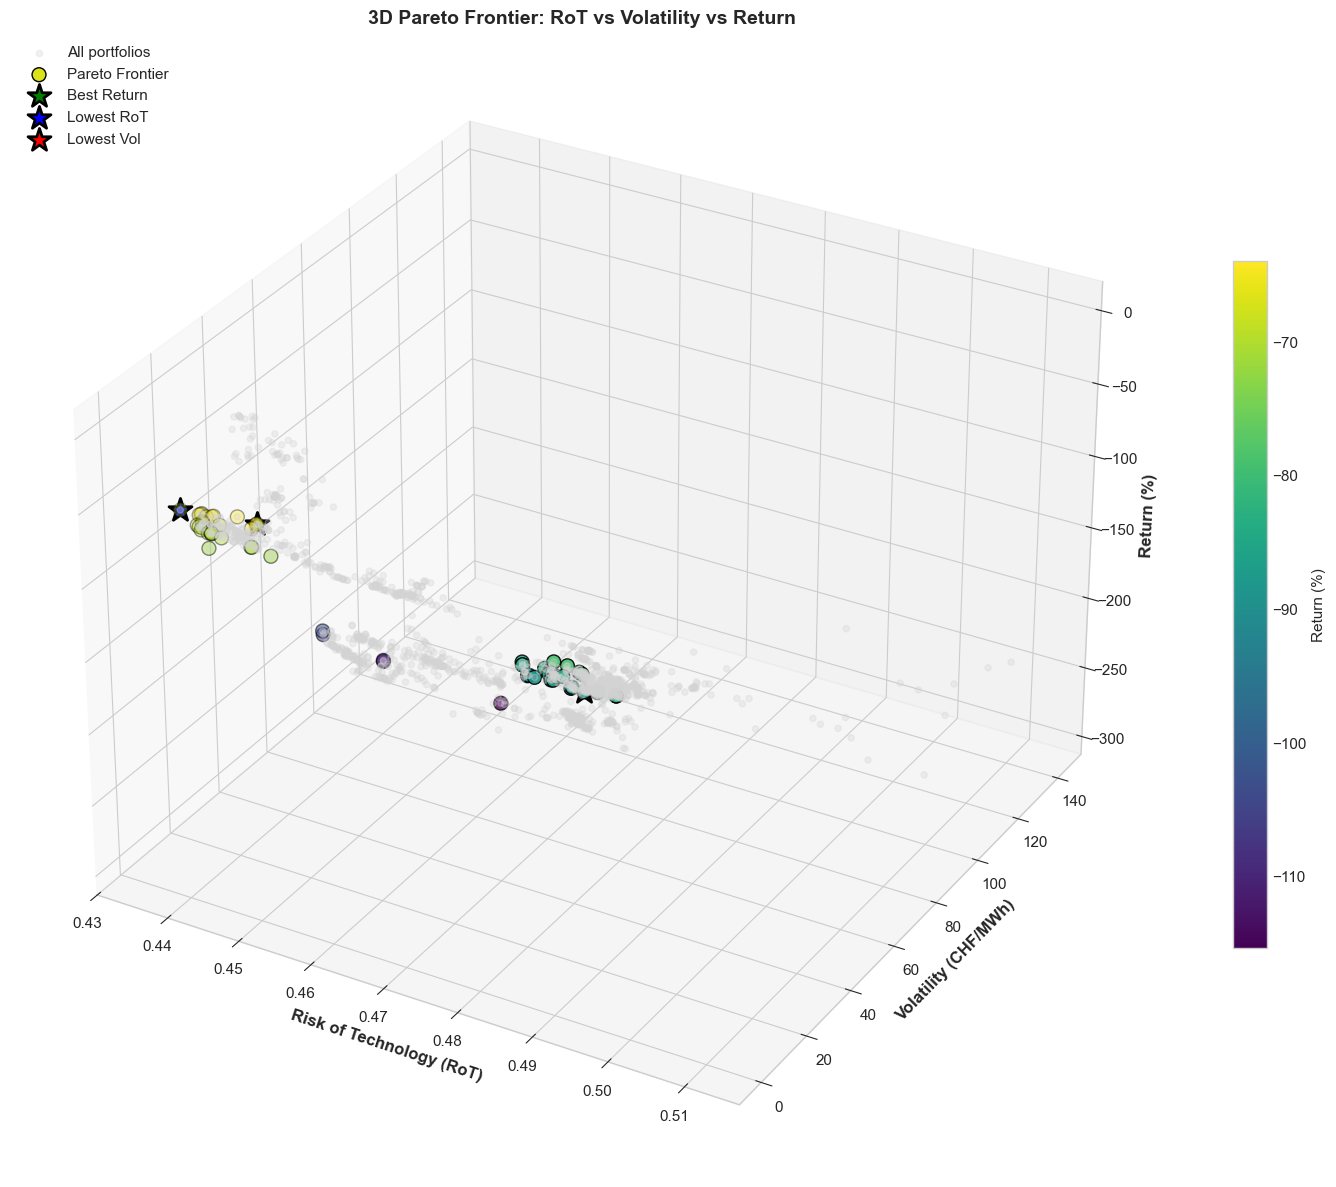

✅ 3D Pareto frontier visualization saved!


In [126]:
# =============================================================================
# SECTION 3.2: Visualize 3D Pareto Frontier
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data from CSV files (generated by previous cells)
all_results_df = pd.read_csv('data/result_plots/multi_objective_results.csv')
frontier_3d = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')

print(f"✅ Loaded {len(all_results_df)} total portfolios")
print(f"✅ Loaded {len(frontier_3d)} frontier portfolios")

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all portfolios
ax.scatter(
    all_results_df['x_RoT'], all_results_df['y_volatility'], all_results_df['z_return'],
    c='lightgray', alpha=0.3, s=20, label='All portfolios'
)

# Plot frontier
scatter = ax.scatter(
    frontier_3d['x_RoT'], frontier_3d['y_volatility'], frontier_3d['z_return'],
    c=frontier_3d['z_return'], cmap='viridis',
    s=100, edgecolors='black', linewidth=1, label='Pareto Frontier'
)

# Highlight extreme points
best_return = frontier_3d.loc[frontier_3d['z_return'].idxmax()]
best_rot = frontier_3d.loc[frontier_3d['x_RoT'].idxmin()]
best_vol = frontier_3d.loc[frontier_3d['y_volatility'].idxmin()]

ax.scatter([best_return['x_RoT']], [best_return['y_volatility']], [best_return['z_return']],
          c='green', s=300, marker='*', edgecolors='black', linewidth=2, label='Best Return')
ax.scatter([best_rot['x_RoT']], [best_rot['y_volatility']], [best_rot['z_return']],
          c='blue', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest RoT')
ax.scatter([best_vol['x_RoT']], [best_vol['y_volatility']], [best_vol['z_return']],
          c='red', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest Vol')

ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_zlabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('3D Pareto Frontier: RoT vs Volatility vs Return', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Return (%)', shrink=0.6)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('data/result_plots/pareto_frontier_3d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 3D Pareto frontier visualization saved!")


In [127]:
# =============================================================================
# SECTION 3.3: Analyze Frontier Portfolios
# =============================================================================
import pandas as pd
import json

# Load frontier data from CSV (generated by Section 3.1)
frontier_3d = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')

print("=" * 60)
print(f"PARETO FRONTIER PORTFOLIOS ({len(frontier_3d)} portfolios)")
print("=" * 60)

for idx, (_, row) in enumerate(frontier_3d.iterrows()):
    print(f"\nPortfolio #{idx+1}:")
    print(f"  RoT:        {row['x_RoT']:.4f}")
    print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
    print(f"  Return:     {row['z_return']:.2f}%")
    
    # Parse portfolio
    pf_dict = json.loads(row['portfolio_dict']) if isinstance(row['portfolio_dict'], str) else row['portfolio_dict']
    top_ppus = sorted(pf_dict.items(), key=lambda x: -x[1])[:5]
    print(f"  Top PPUs: {', '.join(f'{p}:{c}' for p, c in top_ppus)}")

print("\n" + "=" * 60)


PARETO FRONTIER PORTFOLIOS (61 portfolios)

Portfolio #1:
  RoT:        0.4419
  Volatility: 10.98 CHF/MWh
  Return:     -66.85%
  Top PPUs: SOL_STEAM:1849, SYN_CRACK:1831, IMP_BIOG:1596, THERM:1521, WD_ON:1518

Portfolio #2:
  RoT:        0.4397
  Volatility: 10.58 CHF/MWh
  Return:     -67.23%
  Top PPUs: SYN_CRACK:1892, SOL_STEAM:1714, SYN_METH:1439, PHS:1415, WD_ON:1408

Portfolio #3:
  RoT:        0.4354
  Volatility: 13.87 CHF/MWh
  Return:     -69.64%
  Top PPUs: SOL_STEAM:1714, SYN_CRACK:1654, SYN_METH:1501, THERM:1345, CH4_BIO:1243

Portfolio #4:
  RoT:        0.4459
  Volatility: 12.16 CHF/MWh
  Return:     -65.16%
  Top PPUs: CH4_BIO:1763, SOL_STEAM:1665, THERM:1624, SYN_CRACK:1550, SYN_METH:1439

Portfolio #5:
  RoT:        0.4891
  Volatility: 1.74 CHF/MWh
  Return:     -87.73%
  Top PPUs: SYN_CRACK:1839, H2P_G:1793, CH4_BIO:1538, PALM_ICE:1478, PV:1472

Portfolio #6:
  RoT:        0.4871
  Volatility: 1.35 CHF/MWh
  Return:     -88.50%
  Top PPUs: SYN_CRACK:1839, H2P_G:17

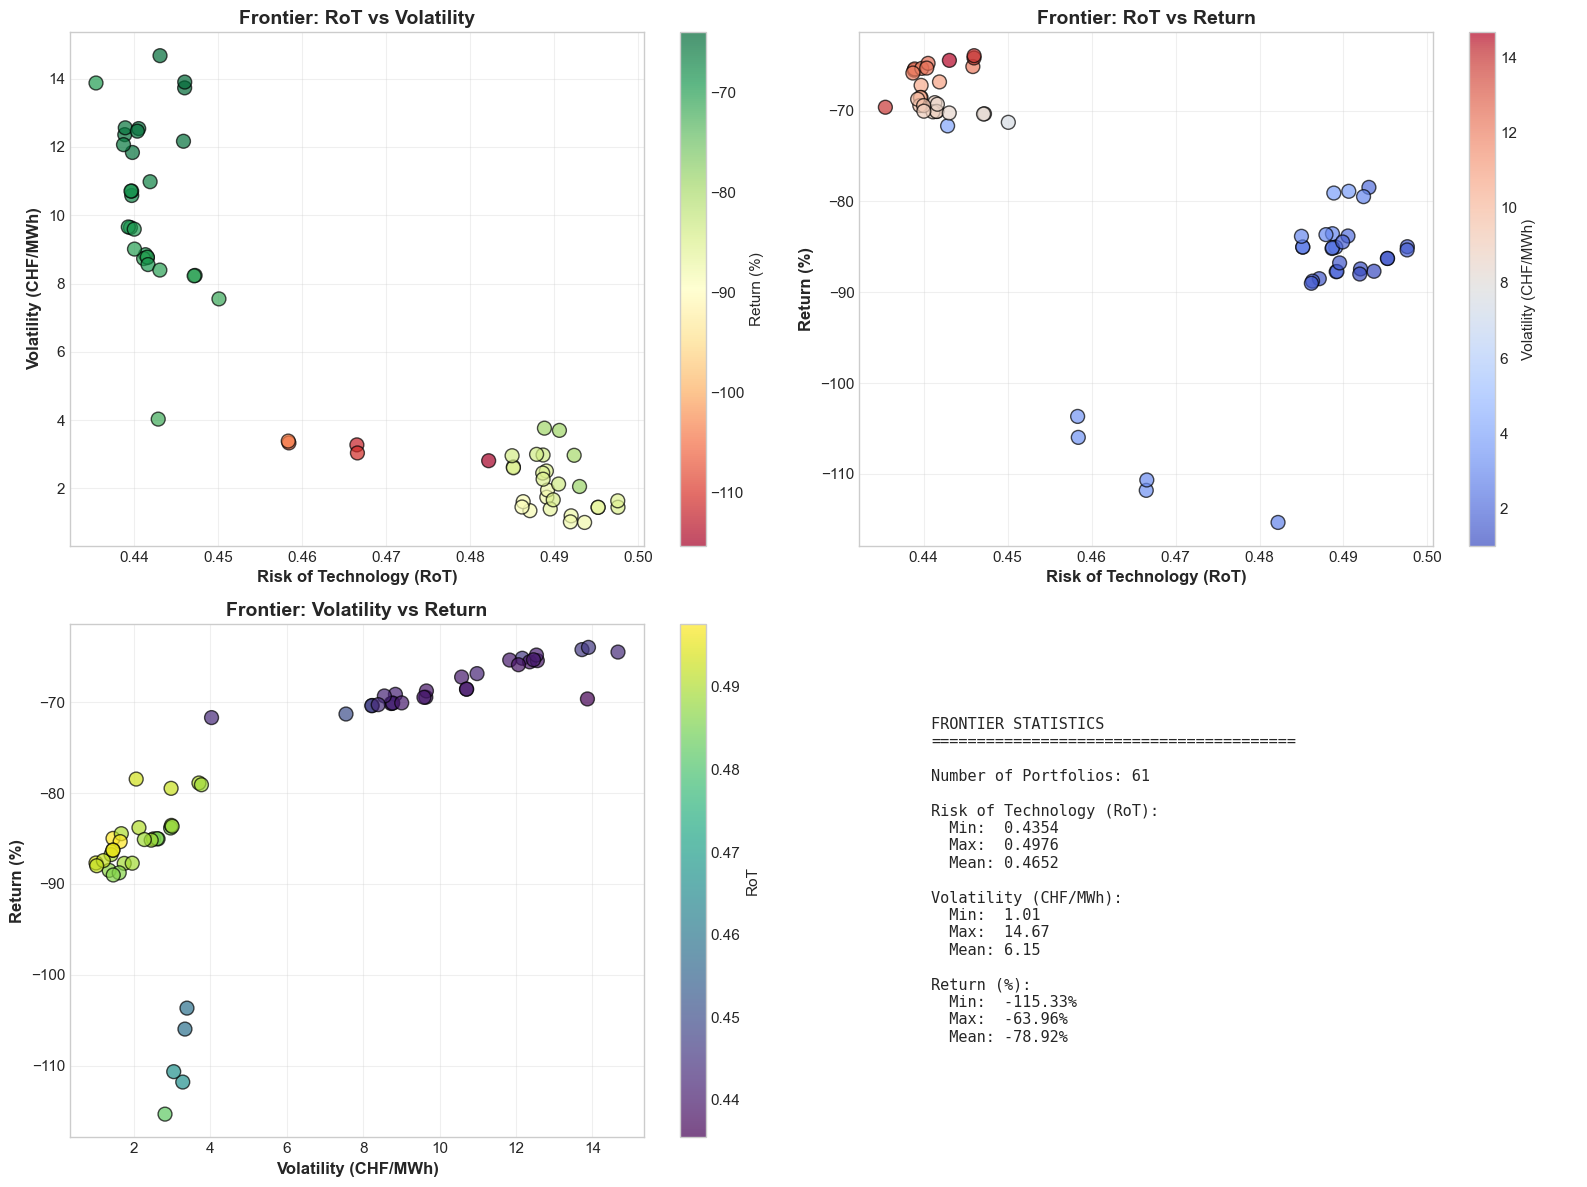


✅ Visualization saved to: data/result_plots/frontier_2d_projections.png


In [128]:
# =============================================================================
# SECTION 3.4: Visualize Frontier Portfolios (Optional)
# =============================================================================
# This cell creates a simple comparison visualization of frontier portfolios

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: RoT vs Volatility
ax = axes[0, 0]
scatter = ax.scatter(frontier_3d['x_RoT'], frontier_3d['y_volatility'], 
                     c=frontier_3d['z_return'], cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_title('Frontier: RoT vs Volatility', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Return (%)')

# Plot 2: RoT vs Return
ax = axes[0, 1]
scatter = ax.scatter(frontier_3d['x_RoT'], frontier_3d['z_return'],
                     c=frontier_3d['y_volatility'], cmap='coolwarm', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('Frontier: RoT vs Return', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Volatility (CHF/MWh)')

# Plot 3: Volatility vs Return
ax = axes[1, 0]
scatter = ax.scatter(frontier_3d['y_volatility'], frontier_3d['z_return'],
                     c=frontier_3d['x_RoT'], cmap='viridis', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('Frontier: Volatility vs Return', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='RoT')

# Plot 4: Summary statistics
ax = axes[1, 1]
ax.axis('off')

stats_text = f"""
FRONTIER STATISTICS
{'='*40}

Number of Portfolios: {len(frontier_3d)}

Risk of Technology (RoT):
  Min:  {frontier_3d['x_RoT'].min():.4f}
  Max:  {frontier_3d['x_RoT'].max():.4f}
  Mean: {frontier_3d['x_RoT'].mean():.4f}

Volatility (CHF/MWh):
  Min:  {frontier_3d['y_volatility'].min():.2f}
  Max:  {frontier_3d['y_volatility'].max():.2f}
  Mean: {frontier_3d['y_volatility'].mean():.2f}

Return (%):
  Min:  {frontier_3d['z_return'].min():.2f}%
  Max:  {frontier_3d['z_return'].max():.2f}%
  Mean: {frontier_3d['z_return'].mean():.2f}%
"""

ax.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
        verticalalignment='center')

plt.tight_layout()
plt.savefig('data/result_plots/frontier_2d_projections.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to: data/result_plots/frontier_2d_projections.png")


# =============================================================================
# SECTION 3.3: Pareto Frontier Research for 2050 Scenario
# =============================================================================

This section runs the **complete Pareto frontier research for the 2050 scenario** with:
- **Electric Demand**: 113 TWh × 1.6 = **180.8 TWh/year** (scaled by 1.6x)
- **Aviation Fuel**: **30 TWh/year** (as specified)

The analysis includes:
1. Multi-objective exploration (GA) for 2050 scenario
2. 3D Pareto frontier identification
3. Comprehensive visualizations (same as Section 3.2, but for 2050)
4. Energy flow and efficiency analysis for 2050 portfolios

**Note**: This is computationally intensive and may take 30-60 minutes depending on the number of generations and population size.


In [33]:
# =============================================================================
# SECTION 3.3.1: Configure 2050 Scenario and Run Multi-Objective Exploration
# =============================================================================

import pandas as pd
import numpy as np
from multi_objective_explorer import explore_and_find_frontier, get_objective_configs, continue_exploration_3d_frontier
from config import Config
from data_loader import load_all_data

print("=" * 80)
print("PARETO FRONTIER RESEARCH FOR 2050 SCENARIO")
print("=" * 80)
print()
print("Configuration:")
print("  • Electric Demand: 113 TWh × 1.6 = 180.8 TWh/year")
print("  • Aviation Fuel: 30 TWh/year")
print("  • Demand Multiplier: 1.6x")
print("  • Aviation Multiplier: 30/23 = 1.304x")
print()

# Create config for 2050 scenario
config_2050 = Config()
config_2050.energy_system.DEMAND_SCENARIO = "2050"

# Verify configuration
print("📊 2050 Scenario Configuration:")
print(f"   Target Annual Demand: {config_2050.energy_system.TARGET_ANNUAL_DEMAND_TWH:.1f} TWh/year")
print(f"   Aviation Fuel Demand: {config_2050.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR:.1f} TWh/year")
print(f"   Demand Multiplier: {config_2050.energy_system.DEMAND_MULTIPLIER:.2f}x")
print(f"   Aviation Multiplier: {config_2050.energy_system.AVIATION_MULTIPLIER:.3f}x")
print()

# Load data for 2050 scenario
print("Loading data for 2050 scenario...")
_data_2050 = load_all_data(config_2050, force_reload=True)
print("✅ Data loaded for 2050 scenario")
print()

# Get objective configurations
objectives_2050 = get_objective_configs()

# Parameters for exploration
N_GENERATIONS_2050 = 5  # Adjust based on time available
POP_SIZE_2050 = 5       # Adjust based on time available
OUTPUT_PATH_2050 = "data/result_plots/multi_objective_results_2050.csv"

print("=" * 80)
print("RUNNING MULTI-OBJECTIVE EXPLORATION FOR 2050")
print("=" * 80)
print(f"   Generations: {N_GENERATIONS_2050}")
print(f"   Population Size: {POP_SIZE_2050}")
print(f"   Objectives: {len(objectives_2050)}")
print()
print("This may take 30-60 minutes...")
print()

# Run multi-objective exploration for 2050
all_results_2050, pareto_2050 = explore_and_find_frontier(
    config=config_2050,
    objectives=objectives_2050,
    n_generations=N_GENERATIONS_2050,
    pop_size=POP_SIZE_2050,
    output_path=OUTPUT_PATH_2050,
    verbose=True,
    use_existing_as_seeds=False  # Start fresh for 2050
)

print("\n" + "=" * 80)
print("✅ 2050 Multi-Objective Exploration Complete!")
print("=" * 80)
print(f"   Total portfolios: {len(all_results_2050)}")
print(f"   Frontier portfolios: {len(pareto_2050)}")
print(f"   Results saved to: {OUTPUT_PATH_2050}")
print()


PARETO FRONTIER RESEARCH FOR 2050 SCENARIO

Configuration:
  • Electric Demand: 113 TWh × 1.6 = 180.8 TWh/year
  • Aviation Fuel: 30 TWh/year
  • Demand Multiplier: 1.6x
  • Aviation Multiplier: 30/23 = 1.304x

📊 2050 Scenario Configuration:
   Target Annual Demand: 180.8 TWh/year
   Aviation Fuel Demand: 30.0 TWh/year
   Demand Multiplier: 1.60x
   Aviation Multiplier: 1.304x

Loading data for 2050 scenario...
Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2050, multiplier: 1.6x)
✅ Data loaded for 2050 scenario

RUNNING MUL

Evaluating initial population: 100%|██████████| 5/5 [00:56<00:00, 11.23s/it]


Valid portfolios in initial population: 3/5


Objective: 3d_balanced
Description: 3D Balanced: Equal weights (RoT, Vol, Return)
Using shared initial population (3 portfolios)
Generation 5/5
Best fitness: 0.4163
  RoT: 0.4898
  Volatility: 2.09
  Return: -74.69%
Evaluated 23 portfolios for '3d_balanced'

Objective: 3d_stability
Description: 3D Stability: 40% RoT + 40% Vol + 20% Return
Using shared initial population (3 portfolios)
Generation 5/5
Best fitness: 0.3423
  RoT: 0.4836
  Volatility: 4.29
  Return: -73.58%
Evaluated 21 portfolios for '3d_stability'

Objective: 3d_return
Description: 3D Return: 60% Return + 20% RoT + 20% Vol
Using shared initial population (3 portfolios)
Generation 5/5
Best fitness: 0.6693
  RoT: 0.4914
  Volatility: 7.40
  Return: -94.92%
Evaluated 23 portfolios for '3d_return'

Objective: 3d_rot_focus
Description: 3D RoT Focus: 60% RoT + 20% Vol + 20% Return
Using shared initial population (3 portfolios)
Generation 5/5
Best fitness: 0.4403
  RoT: 0.4862
  Vol

In [34]:
# =============================================================================
# SECTION 3.3.2: Find 3D Pareto Frontier for 2050
# =============================================================================

import pandas as pd
import numpy as np
import json
from multi_objective_explorer import extract_pareto_frontier_3d_from_df
from ppu_framework import Portfolio

print("=" * 80)
print("FINDING 3D PARETO FRONTIER FOR 2050")
print("=" * 80)

# Load 2050 results
all_results_2050 = pd.read_csv(OUTPUT_PATH_2050)
print(f"✅ Loaded {len(all_results_2050)} portfolios from 2050 exploration")

# Filter for compliant portfolios (same constraints as Section 3.1)
def is_portfolio_compliant_2050(portfolio_dict, row) -> bool:
    """Check if portfolio satisfies hard constraints for 2050."""
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation Fuel Constraint (30 TWh/year for 2050)
    # Requires THERM units + SYN_FT or SYN_CRACK
    MIN_THERM_FOR_AVIATION = 263  # Same minimum as 2024
    therm_count = portfolio.get('THERM', 0)
    syn_ft_count = portfolio.get('SYN_FT', 0)
    syn_crack_count = portfolio.get('SYN_CRACK', 0)
    
    aviation_compliant = (
        therm_count >= MIN_THERM_FOR_AVIATION and 
        (syn_ft_count > 0 or syn_crack_count > 0)
    )
    
    # 2. Electrical Sovereignty (180.8 TWh/year for 2050)
    TARGET_DEMAND_2050 = 113.0 * 1.6  # 180.8 TWh
    if 'total_domestic_production_twh' in row:
        sovereignty_compliant = row['total_domestic_production_twh'] >= TARGET_DEMAND_2050
    else:
        sovereignty_compliant = False
    
    return aviation_compliant and sovereignty_compliant

# Filter compliant portfolios
print("\n🔍 Filtering for compliant portfolios (2050 constraints)...")
compliant_mask_2050 = all_results_2050.apply(
    lambda row: is_portfolio_compliant_2050(row.get('portfolio_dict', {}), row),
    axis=1
)
compliant_2050 = all_results_2050[compliant_mask_2050].copy().reset_index(drop=True)

print(f"   Total portfolios: {len(all_results_2050)}")
print(f"   ✅ Compliant portfolios: {len(compliant_2050)}")
print(f"   ❌ Filtered out: {len(all_results_2050) - len(compliant_2050)}")

if len(compliant_2050) == 0:
    print("\n⚠️ WARNING: No compliant portfolios found!")
    print("   Please check constraint definitions or re-run exploration.")
else:
    # Find 3D Pareto frontier (minimize RoT, minimize Volatility, MAXIMIZE Return)
    print("\n📊 Extracting 3D Pareto frontier...")
    frontier_3d_2050 = extract_pareto_frontier_3d_from_df(
        compliant_2050,
        x_col='x_RoT',
        y_col='y_volatility',
        z_col='z_return',
        minimize_x=True,
        minimize_y=True,
        minimize_z=False  # MAXIMIZE return
    )
    
    print(f"✅ Found {len(frontier_3d_2050)} portfolios on 3D Pareto frontier")
    
    # Save 3D frontier
    frontier_3d_path_2050 = OUTPUT_PATH_2050.replace('.csv', '_frontier_3d.csv')
    frontier_3d_2050.to_csv(frontier_3d_path_2050, index=False)
    print(f"✅ 3D frontier saved to: {frontier_3d_path_2050}")
    
    # Print statistics
    print("\n📊 3D Pareto Frontier Statistics (2050):")
    print(f"   RoT:        [{frontier_3d_2050['x_RoT'].min():.4f}, {frontier_3d_2050['x_RoT'].max():.4f}]")
    print(f"   Volatility: [{frontier_3d_2050['y_volatility'].min():.2f}, {frontier_3d_2050['y_volatility'].max():.2f}] CHF/MWh")
    print(f"   Return:     [{frontier_3d_2050['z_return'].min():.2f}, {frontier_3d_2050['z_return'].max():.2f}]%")
    print()


FINDING 3D PARETO FRONTIER FOR 2050
✅ Loaded 181 portfolios from 2050 exploration

🔍 Filtering for compliant portfolios (2050 constraints)...
   Total portfolios: 181
   ✅ Compliant portfolios: 75
   ❌ Filtered out: 106

📊 Extracting 3D Pareto frontier...
✅ Found 32 portfolios on 3D Pareto frontier
✅ 3D frontier saved to: data/result_plots/multi_objective_results_2050_frontier_3d.csv

📊 3D Pareto Frontier Statistics (2050):
   RoT:        [0.4813, 0.4941]
   Volatility: [2.23, 4.12] CHF/MWh
   Return:     [-116.39, -73.92]%



VISUALIZING 3D PARETO FRONTIER FOR 2050
✅ Loaded 181 total portfolios
✅ Loaded 32 frontier portfolios

📊 Filtered portfolios (compliance for 2050):
   All: 75 / 181 (41.4%)
   Frontier: 32 / 32 (100.0%)

INTERACTIVE 3D VISUALIZATION FOR 2050
Use the dropdown below to toggle between views:



interactive(children=(Dropdown(description='View:', options=('Frontier Only', 'All Portfolios'), value='Fronti…

✅ 2D projections saved to: data/result_plots/frontier_2d_projections_2050.png


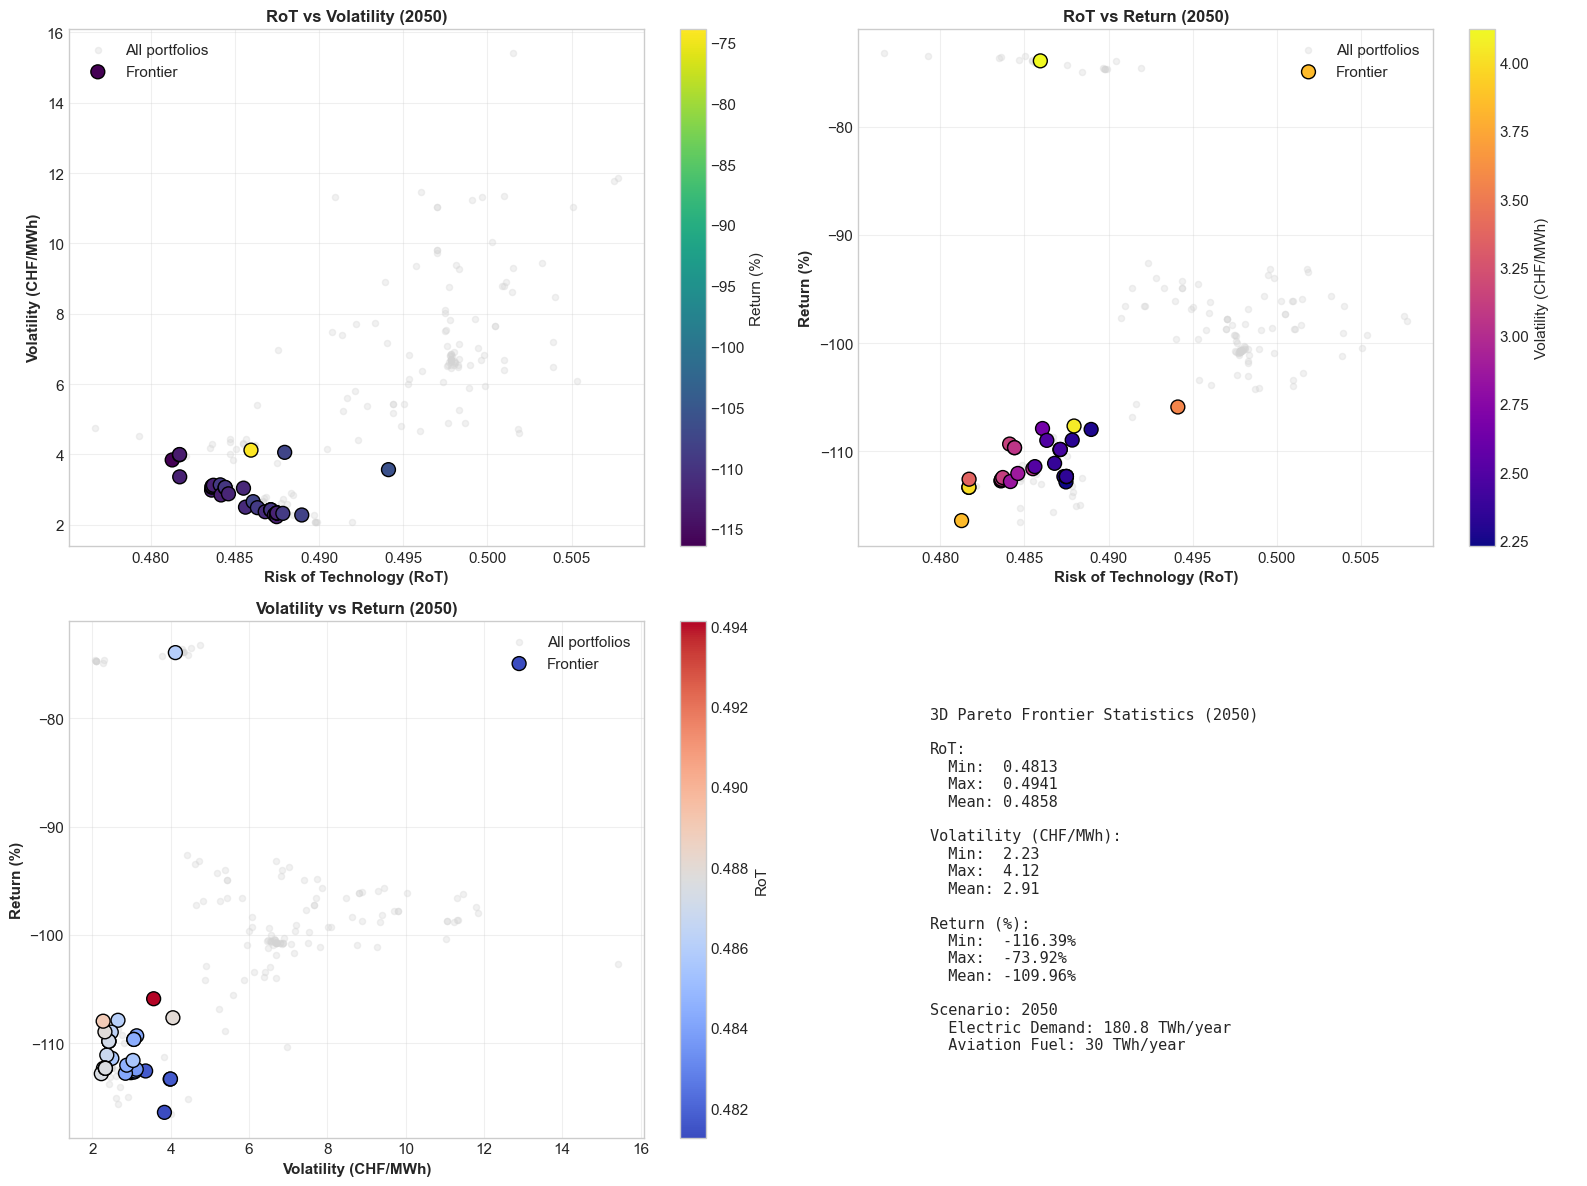


2D PROJECTIONS FOR 2050
✅ 2D projections saved to: data/result_plots/frontier_2d_projections_2050.png


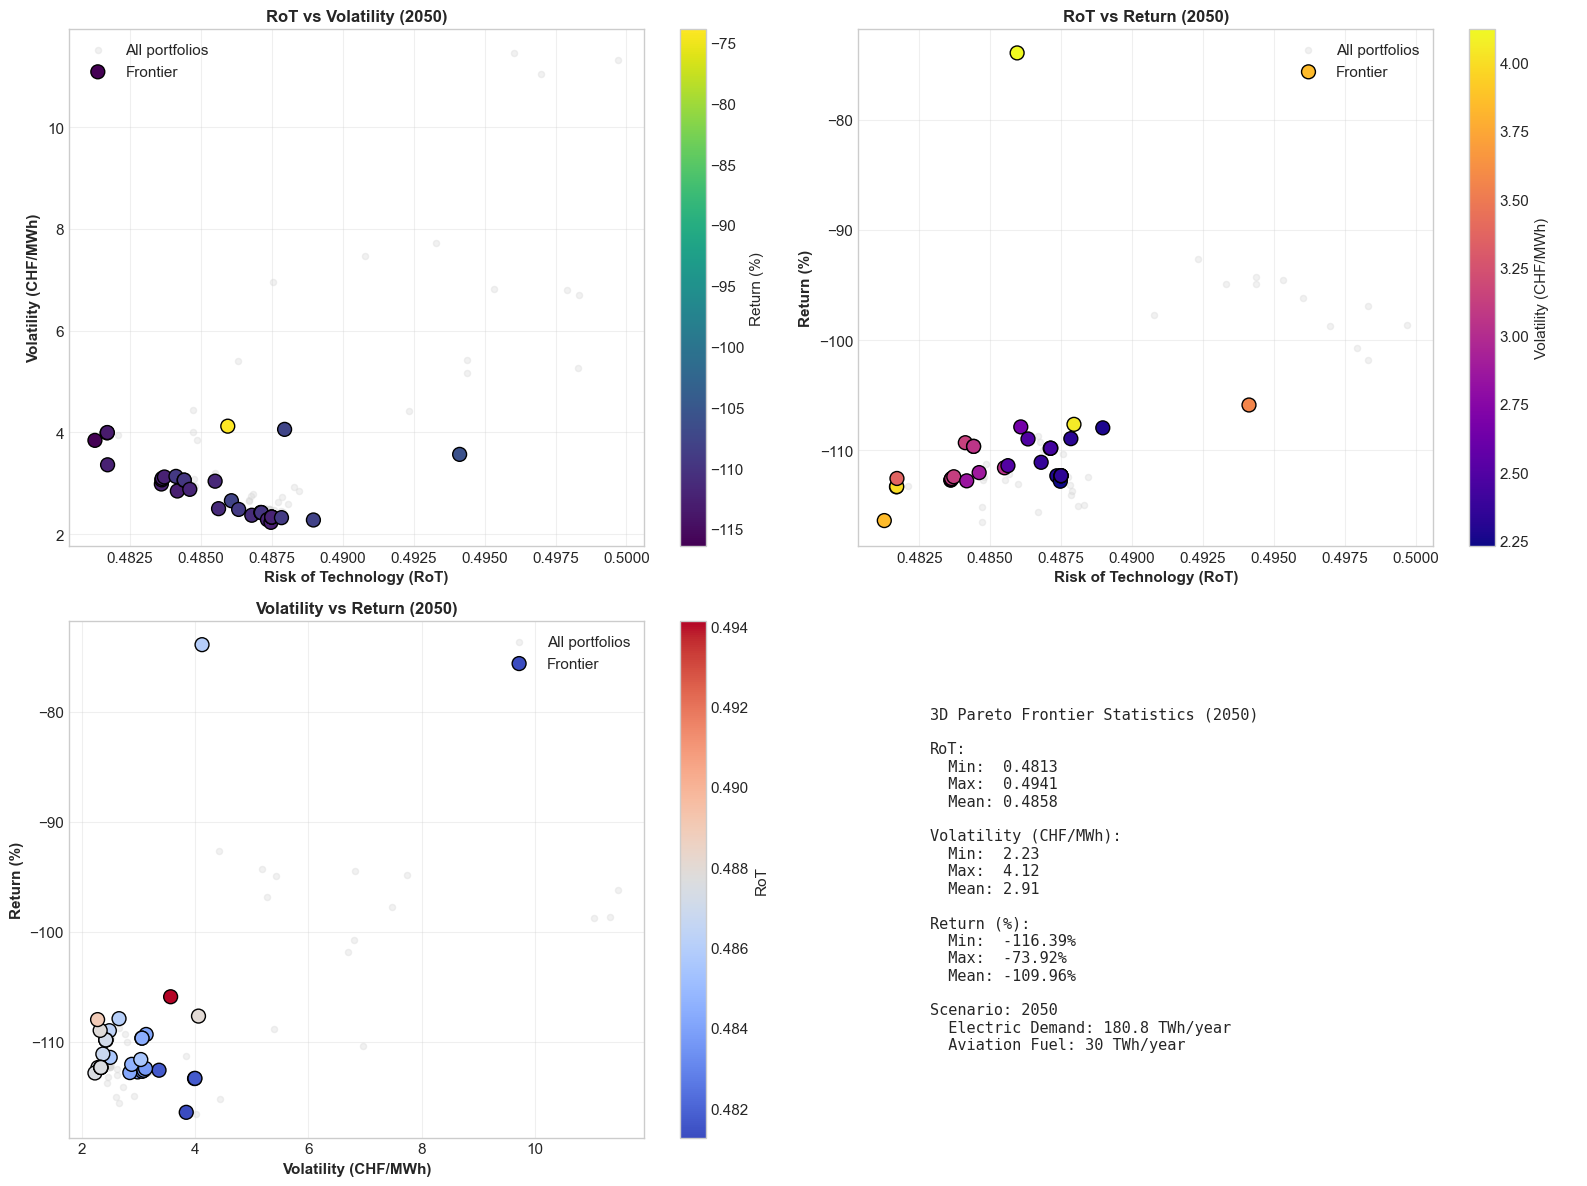


✅ 2050 Pareto Frontier Visualization Complete


In [38]:
# =============================================================================
# SECTION 3.3.3: Interactive 3D Pareto Frontier Visualization for 2050
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown
from scipy.spatial import ConvexHull
import json

# Load 2050 data
all_results_2050 = pd.read_csv(OUTPUT_PATH_2050)
frontier_3d_2050 = pd.read_csv(OUTPUT_PATH_2050.replace('.csv', '_frontier_3d.csv'))

print("=" * 80)
print("VISUALIZING 3D PARETO FRONTIER FOR 2050")
print("=" * 80)
print(f"✅ Loaded {len(all_results_2050)} total portfolios")
print(f"✅ Loaded {len(frontier_3d_2050)} frontier portfolios")
print()

# =====================================================================
# Helper function to check portfolio compliance for 2050
# =====================================================================
def is_portfolio_compliant_2050(portfolio_dict, row) -> bool:
    """Check if portfolio satisfies hard constraints for 2050."""
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            try:
                import ast
                portfolio = ast.literal_eval(portfolio_dict)
            except:
                return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation Fuel Constraint (30 TWh/year for 2050)
    MIN_THERM_FOR_AVIATION = 263
    therm_count = portfolio.get('THERM', 0) if isinstance(portfolio, dict) else 0
    syn_ft_count = portfolio.get('SYN_FT', 0) if isinstance(portfolio, dict) else 0
    syn_crack_count = portfolio.get('SYN_CRACK', 0) if isinstance(portfolio, dict) else 0
    
    aviation_compliant = (
        therm_count >= MIN_THERM_FOR_AVIATION and 
        (syn_ft_count > 0 or syn_crack_count > 0)
    )
    
    # 2. Electrical Sovereignty (180.8 TWh/year for 2050)
    TARGET_DEMAND_2050 = 113.0 * 1.6  # 180.8 TWh
    if 'total_domestic_production_twh' in row:
        sovereignty_compliant = row['total_domestic_production_twh'] >= TARGET_DEMAND_2050
    else:
        sovereignty_compliant = False
    
    return aviation_compliant and sovereignty_compliant

# Filter for compliant portfolios
all_compliant_2050 = all_results_2050.apply(
    lambda row: is_portfolio_compliant_2050(row.get('portfolio_dict', {}), row), 
    axis=1
)
frontier_compliant_2050 = frontier_3d_2050.apply(
    lambda row: is_portfolio_compliant_2050(row.get('portfolio_dict', {}), row), 
    axis=1
)

all_df_2050 = all_results_2050[all_compliant_2050].copy()
frontier_df_2050 = frontier_3d_2050[frontier_compliant_2050].copy()

print(f"📊 Filtered portfolios (compliance for 2050):")
print(f"   All: {len(all_df_2050)} / {len(all_results_2050)} ({100*len(all_df_2050)/len(all_results_2050):.1f}%)")
print(f"   Frontier: {len(frontier_df_2050)} / {len(frontier_3d_2050)} ({100*len(frontier_df_2050)/len(frontier_3d_2050):.1f}%)")
print()

# =====================================================================
# Helper function to create convex hull mesh
# =====================================================================
def create_frontier_mesh_2050(frontier_df):
    """Create convex hull mesh for frontier shape."""
    if len(frontier_df) < 4:
        return None
    pts = frontier_df[['y_volatility', 'x_RoT', 'z_return']].values
    try:
        hull = ConvexHull(pts)
        return go.Mesh3d(
            x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
            i=hull.simplices[:, 0], j=hull.simplices[:, 1], k=hull.simplices[:, 2],
            opacity=0.25, color='steelblue', name='Frontier Hull (2050)'
        )
    except:
        return None

# =====================================================================
# Interactive 3D Plot Function
# =====================================================================
def plot_3d_frontier_2050(view='Frontier Only'):
    """Interactive 3D scatter plot with toggle for 2050."""
    fig = go.Figure()
    
    if view == 'All Portfolios':
        fig.add_trace(go.Scatter3d(
            x=all_df_2050['y_volatility'], 
            y=all_df_2050['x_RoT'], 
            z=all_df_2050['z_return'],
            mode='markers',
            marker=dict(size=3, color=all_df_2050['z_return'], colorscale='RdYlGn', opacity=0.4),
            name=f'All ({len(all_df_2050)})',
            hovertemplate='Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
        ))
    
    fig.add_trace(go.Scatter3d(
        x=frontier_df_2050['y_volatility'], 
        y=frontier_df_2050['x_RoT'], 
        z=frontier_df_2050['z_return'],
        mode='markers',
        marker=dict(size=7, color=frontier_df_2050['z_return'], colorscale='RdYlGn',
                   line=dict(width=1, color='black'), opacity=1.0,
                   colorbar=dict(title='Return %', x=1.02) if view != 'All Portfolios' else None),
        name=f'Frontier ({len(frontier_df_2050)})',
        hovertemplate='<b>Frontier (2050)</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
    ))
    
    mesh = create_frontier_mesh_2050(frontier_df_2050)
    if mesh:
        fig.add_trace(mesh)
    
    # Corner portfolios
    corners = {
        'Best Return': frontier_df_2050.loc[frontier_df_2050['z_return'].idxmax()],
        'Lowest RoT': frontier_df_2050.loc[frontier_df_2050['x_RoT'].idxmin()],
        'Lowest Vol': frontier_df_2050.loc[frontier_df_2050['y_volatility'].idxmin()]
    }
    for name, row in corners.items():
        fig.add_trace(go.Scatter3d(
            x=[row['y_volatility']], y=[row['x_RoT']], z=[row['z_return']],
            mode='markers+text', text=[name], textposition='top center',
            marker=dict(size=10, symbol='diamond', color='gold', line=dict(width=2, color='black')),
            name=name, showlegend=True
        ))
    
    fig.update_layout(
        title=dict(text=f'<b>3D Pareto Frontier: 2050 Scenario</b> ({view})<br>Demand: 180.8 TWh/year, Aviation: 30 TWh/year', x=0.5),
        scene=dict(
            xaxis=dict(title='Volatility (CHF/MWh)'),
            yaxis=dict(title='Risk of Technology'),
            zaxis=dict(title='Return (%)'),
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
        ),
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)'),
        margin=dict(l=0, r=0, t=80, b=0),
        height=650
    )
    fig.show()

# =====================================================================
# Create Interactive Widget
# =====================================================================
print("=" * 80)
print("INTERACTIVE 3D VISUALIZATION FOR 2050")
print("=" * 80)
print("Use the dropdown below to toggle between views:")
print()

interact(plot_3d_frontier_2050, view=Dropdown(
    options=['Frontier Only', 'All Portfolios'],
    value='Frontier Only',
    description='View:'
))

# =====================================================================
# 2D Projections
# =====================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RoT vs Volatility
ax1 = axes[0, 0]
ax1.scatter(all_results_2050['x_RoT'], all_results_2050['y_volatility'], 
           c='lightgray', alpha=0.3, s=20, label='All portfolios')
ax1.scatter(frontier_3d_2050['x_RoT'], frontier_3d_2050['y_volatility'],
           c=frontier_3d_2050['z_return'], cmap='viridis', s=100, 
           edgecolors='black', linewidth=1, label='Frontier')
ax1.set_xlabel('Risk of Technology (RoT)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Volatility (CHF/MWh)', fontsize=11, fontweight='bold')
ax1.set_title('RoT vs Volatility (2050)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(ax1.collections[1], ax=ax1, label='Return (%)')

# 2. RoT vs Return
ax2 = axes[0, 1]
ax2.scatter(all_results_2050['x_RoT'], all_results_2050['z_return'],
           c='lightgray', alpha=0.3, s=20, label='All portfolios')
ax2.scatter(frontier_3d_2050['x_RoT'], frontier_3d_2050['z_return'],
           c=frontier_3d_2050['y_volatility'], cmap='plasma', s=100,
           edgecolors='black', linewidth=1, label='Frontier')
ax2.set_xlabel('Risk of Technology (RoT)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Return (%)', fontsize=11, fontweight='bold')
ax2.set_title('RoT vs Return (2050)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(ax2.collections[1], ax=ax2, label='Volatility (CHF/MWh)')

# 3. Volatility vs Return
ax3 = axes[1, 0]
ax3.scatter(all_results_2050['y_volatility'], all_results_2050['z_return'],
           c='lightgray', alpha=0.3, s=20, label='All portfolios')
ax3.scatter(frontier_3d_2050['y_volatility'], frontier_3d_2050['z_return'],
           c=frontier_3d_2050['x_RoT'], cmap='coolwarm', s=100,
           edgecolors='black', linewidth=1, label='Frontier')
ax3.set_xlabel('Volatility (CHF/MWh)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Return (%)', fontsize=11, fontweight='bold')
ax3.set_title('Volatility vs Return (2050)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.colorbar(ax3.collections[1], ax=ax3, label='RoT')

# 4. Statistics text
ax4 = axes[1, 1]
ax4.axis('off')
stats_text = f"""
3D Pareto Frontier Statistics (2050)

RoT:
  Min:  {frontier_3d_2050['x_RoT'].min():.4f}
  Max:  {frontier_3d_2050['x_RoT'].max():.4f}
  Mean: {frontier_3d_2050['x_RoT'].mean():.4f}

Volatility (CHF/MWh):
  Min:  {frontier_3d_2050['y_volatility'].min():.2f}
  Max:  {frontier_3d_2050['y_volatility'].max():.2f}
  Mean: {frontier_3d_2050['y_volatility'].mean():.2f}

Return (%):
  Min:  {frontier_3d_2050['z_return'].min():.2f}%
  Max:  {frontier_3d_2050['z_return'].max():.2f}%
  Mean: {frontier_3d_2050['z_return'].mean():.2f}%

Scenario: 2050
  Electric Demand: 180.8 TWh/year
  Aviation Fuel: 30 TWh/year
"""

ax4.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
        verticalalignment='center')

plt.tight_layout()
plt.savefig('data/result_plots/frontier_2d_projections_2050.png', dpi=150, bbox_inches='tight')
print(f"✅ 2D projections saved to: data/result_plots/frontier_2d_projections_2050.png")
plt.show()

# =====================================================================
# 2D Projections (Static matplotlib plots)
# =====================================================================
print("\n" + "=" * 80)
print("2D PROJECTIONS FOR 2050")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RoT vs Volatility
ax1 = axes[0, 0]
ax1.scatter(all_df_2050['x_RoT'], all_df_2050['y_volatility'], 
           c='lightgray', alpha=0.3, s=20, label='All portfolios')
ax1.scatter(frontier_df_2050['x_RoT'], frontier_df_2050['y_volatility'],
           c=frontier_df_2050['z_return'], cmap='viridis', s=100, 
           edgecolors='black', linewidth=1, label='Frontier')
ax1.set_xlabel('Risk of Technology (RoT)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Volatility (CHF/MWh)', fontsize=11, fontweight='bold')
ax1.set_title('RoT vs Volatility (2050)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(ax1.collections[1], ax=ax1, label='Return (%)')

# 2. RoT vs Return
ax2 = axes[0, 1]
ax2.scatter(all_df_2050['x_RoT'], all_df_2050['z_return'],
           c='lightgray', alpha=0.3, s=20, label='All portfolios')
ax2.scatter(frontier_df_2050['x_RoT'], frontier_df_2050['z_return'],
           c=frontier_df_2050['y_volatility'], cmap='plasma', s=100,
           edgecolors='black', linewidth=1, label='Frontier')
ax2.set_xlabel('Risk of Technology (RoT)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Return (%)', fontsize=11, fontweight='bold')
ax2.set_title('RoT vs Return (2050)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(ax2.collections[1], ax=ax2, label='Volatility (CHF/MWh)')

# 3. Volatility vs Return
ax3 = axes[1, 0]
ax3.scatter(all_df_2050['y_volatility'], all_df_2050['z_return'],
           c='lightgray', alpha=0.3, s=20, label='All portfolios')
ax3.scatter(frontier_df_2050['y_volatility'], frontier_df_2050['z_return'],
           c=frontier_df_2050['x_RoT'], cmap='coolwarm', s=100,
           edgecolors='black', linewidth=1, label='Frontier')
ax3.set_xlabel('Volatility (CHF/MWh)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Return (%)', fontsize=11, fontweight='bold')
ax3.set_title('Volatility vs Return (2050)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.colorbar(ax3.collections[1], ax=ax3, label='RoT')

# 4. Statistics text
ax4 = axes[1, 1]
ax4.axis('off')
stats_text = f"""
3D Pareto Frontier Statistics (2050)

RoT:
  Min:  {frontier_df_2050['x_RoT'].min():.4f}
  Max:  {frontier_df_2050['x_RoT'].max():.4f}
  Mean: {frontier_df_2050['x_RoT'].mean():.4f}

Volatility (CHF/MWh):
  Min:  {frontier_df_2050['y_volatility'].min():.2f}
  Max:  {frontier_df_2050['y_volatility'].max():.2f}
  Mean: {frontier_df_2050['y_volatility'].mean():.2f}

Return (%):
  Min:  {frontier_df_2050['z_return'].min():.2f}%
  Max:  {frontier_df_2050['z_return'].max():.2f}%
  Mean: {frontier_df_2050['z_return'].mean():.2f}%

Scenario: 2050
  Electric Demand: 180.8 TWh/year
  Aviation Fuel: 30 TWh/year
"""

ax4.text(0.1, 0.5, stats_text, fontsize=11, family='monospace', 
        verticalalignment='center')

plt.tight_layout()
plt.savefig('data/result_plots/frontier_2d_projections_2050.png', dpi=150, bbox_inches='tight')
print(f"✅ 2D projections saved to: data/result_plots/frontier_2d_projections_2050.png")
plt.show()

print("\n" + "=" * 80)
print("✅ 2050 Pareto Frontier Visualization Complete")
print("=" * 80)


# =============================================================================
# SECTION 3.3.5: Interactive Portfolio Analysis for 2050
# =============================================================================

This section provides **interactive analysis** of individual 2050 Pareto frontier portfolios, allowing you to:
- Select any portfolio from the 2050 frontier
- Run full-year simulation (8,760 hours)
- View comprehensive analysis including:
  - Incidence vs Demand (before storage)
  - Dispatch results (after storage/dispatch)
  - PPU decomposition by category
  - Hourly energy mix
  - Solar/Wind production concentration
  - Annual performance summary
  - End-to-end effectiveness analysis

**Note**: This uses the 2050 scenario configuration (180.8 TWh/year demand, 30 TWh/year aviation fuel).


In [ ]:
# =============================================================================
# SECTION 3.3.5: Interactive Portfolio Analysis for 2050
# =============================================================================
import time
import json
from pathlib import Path
from IPython.display import clear_output, display
from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PPU Framework
from ppu_framework import Portfolio

# Optimization & Config - import Config class for scenario switching
from optimization import Individual, evaluate_portfolio_full_year
from config import Config
from data_loader import load_all_data

# Visualization
from visualization import (
    plot_full_year_production_by_source,
    plot_full_year_storage,
    plot_energy_balance_distribution
)

# =============================================================================
# CONFIGURE FOR 2050 SCENARIO
# =============================================================================
# Use 2050 scenario configuration
config_2050 = Config()
config_2050.energy_system.DEMAND_SCENARIO = "2050"

# Reload data with the 2050 scenario (force_reload to apply new multiplier)
_data_2050 = load_all_data(config_2050, force_reload=True)

print(f"📊 2050 Scenario Configuration:")
print(f"   - Demand multiplier: {config_2050.energy_system.DEMAND_MULTIPLIER}x")
print(f"   - Target demand: {config_2050.energy_system.TARGET_ANNUAL_DEMAND_TWH:.1f} TWh/year")
print(f"   - Aviation fuel: {config_2050.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR:.1f} TWh/year")
print()

# =============================================================================
# Helper: Portfolio Compliance Check for 2050
# =============================================================================
def is_portfolio_compliant_2050(portfolio_dict, row) -> bool:
    """Check if portfolio satisfies constraints for 2050 (relaxed - no storage check)."""
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            try:
                import ast
                portfolio = ast.literal_eval(portfolio_dict)
            except:
                return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation: THERM >= 263 + (SYN_FT or SYN_CRACK)
    MIN_THERM_FOR_AVIATION = 263
    therm_count = portfolio.get('THERM', 0) if isinstance(portfolio, dict) else 0
    syn_ft_count = portfolio.get('SYN_FT', 0) if isinstance(portfolio, dict) else 0
    syn_crack_count = portfolio.get('SYN_CRACK', 0) if isinstance(portfolio, dict) else 0
    
    if not (therm_count >= MIN_THERM_FOR_AVIATION and (syn_ft_count > 0 or syn_crack_count > 0)):
        return False
    
    # 2. Sovereignty: >= 180.8 TWh for 2050
    TARGET_DEMAND_2050 = 113.0 * 1.6  # 180.8 TWh
    if 'total_domestic_production_twh' in row:
        if row['total_domestic_production_twh'] < TARGET_DEMAND_2050:
            return False
    
    # Storage constraint SKIPPED (CSV may have old tolerance)
    return True

# Load 2050 frontier portfolios
frontier_path_2050 = Path('data/result_plots/multi_objective_results_2050_frontier_3d.csv')
if not frontier_path_2050.exists():
    print("⚠️ 2050 Frontier CSV not found. Run Section 3.3.2 first to generate it.")
else:
    frontier_df_raw_2050 = pd.read_csv(frontier_path_2050)
    
    # Filter for compliant portfolios only
    print("🔍 Filtering for compliant portfolios (2050 constraints)...")
    compliant_mask_2050 = frontier_df_raw_2050.apply(
        lambda row: is_portfolio_compliant_2050(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    frontier_df_2050 = frontier_df_raw_2050[compliant_mask_2050].copy().reset_index(drop=True)
    
    print(f"   Total frontier portfolios: {len(frontier_df_raw_2050)}")
    print(f"   ✅ Compliant portfolios: {len(frontier_df_2050)}")
    print(f"   ❌ Filtered: {len(frontier_df_raw_2050) - len(frontier_df_2050)}")
    
    if len(frontier_df_2050) == 0:
        print("\n⚠️ WARNING: No compliant portfolios found in 2050 frontier!")
        print("   Please re-run the optimization with the 2050 constraints.")
    
    # Create dropdown options with portfolio summary
    portfolio_options_2050 = {}
    for idx, row in frontier_df_2050.iterrows():
        label = f"#{int(idx)+1}: RoT={row['x_RoT']:.4f}, Vol={row['y_volatility']:.1f}, Ret={row['z_return']:.1f}%"
        portfolio_options_2050[label] = int(idx)
    
    # Create widgets
    portfolio_dropdown_2050 = Dropdown(
        options=list(portfolio_options_2050.keys()),
        value=list(portfolio_options_2050.keys())[0] if len(portfolio_options_2050) > 0 else None,
        description='Portfolio:',
        style={'description_width': '80px'},
        layout=Layout(width='600px')
    )
    
    run_button_2050 = Button(
        description='🚀 Run Analysis',
        button_style='success',
        layout=Layout(width='150px', height='35px')
    )
    
    output_area_2050 = Output(layout=Layout(height='1000px', overflow='auto'))
    
    def run_portfolio_analysis_2050(b):
        """Run full analysis for selected 2050 portfolio."""
        with output_area_2050:
            clear_output(wait=True)
            
            # Get selected portfolio
            selected_idx = portfolio_options_2050[portfolio_dropdown_2050.value]
            row = frontier_df_2050.iloc[selected_idx]
            
            print("=" * 70)
            print(f"ANALYZING 2050 PORTFOLIO #{selected_idx + 1}")
            print("=" * 70)
            print(f"  RoT:        {row['x_RoT']:.4f}")
            print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
            print(f"  Return:     {row['z_return']:.2f}%")
            print(f"  Scenario:   2050 (Demand: 180.8 TWh/year, Aviation: 30 TWh/year)")
            
            # Parse portfolio dict
            portfolio_dict_str = row['portfolio_dict']
            if isinstance(portfolio_dict_str, str):
                try:
                    portfolio_dict = json.loads(portfolio_dict_str)
                except:
                    import ast
                    portfolio_dict = ast.literal_eval(portfolio_dict_str)
            else:
                portfolio_dict = portfolio_dict_str
            
            print(f"\n📦 Portfolio composition:")
            for ppu, count in sorted(portfolio_dict.items(), key=lambda x: -x[1]):
                if count > 0:
                    print(f"    {ppu}: {count} units")
            
            # Run full year simulation
            print("\n⏳ Running full-year simulation (8,760 hours) for 2050 scenario...")
            individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))
            
            start_time = time.time()
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config_2050,
                verbose=False
            )
            elapsed = time.time() - start_time
            print(f"✅ Simulation complete in {elapsed:.1f}s")
            
            # ================================================================
            # PART 1: Incidence vs Demand Analysis (Matches Section 1.2c)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 1: INCIDENCE VS DEMAND ANALYSIS (Before Storage) - 2050")
            print("=" * 70)
            
            dem = np.array(full_year_results.demand)
            ren = np.array(full_year_results.renewable_production)
            balance = ren - dem
            
            # Statistics
            total_demand_twh = np.sum(dem) / 1e6
            total_renewable_twh = np.sum(ren) / 1e6
            coverage = (total_renewable_twh / total_demand_twh) * 100
            surplus_h = np.sum(balance > 0)
            deficit_h = np.sum(balance < 0)
            total_surplus_twh = np.sum(balance[balance > 0]) / 1e6
            total_deficit_twh = np.sum(balance[balance < 0]) / 1e6
            
            print(f"\n📊 Energy Summary (2050):")
            print(f"   Total Demand:     {total_demand_twh:.2f} TWh")
            print(f"   Total Incidence:  {total_renewable_twh:.2f} TWh")
            print(f"   Coverage:         {coverage:.1f}%")
            print(f"\n⚡ Balance:")
            print(f"   Surplus hours:    {surplus_h:,} ({surplus_h/len(balance)*100:.1f}%)")
            print(f"   Deficit hours:    {deficit_h:,} ({deficit_h/len(balance)*100:.1f}%)")
            print(f"   Total surplus:    {total_surplus_twh:.2f} TWh (storable)")
            print(f"   Total deficit:    {abs(total_deficit_twh):.2f} TWh (need storage/dispatch)")

            fig1, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
            hours = np.arange(len(dem))
            days = hours / 24

            # Plot 1: Incidence vs Demand
            ax1 = axes[0]
            ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
            ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
            ax1.set_ylabel('Power (GW)')
            ax1.set_title(f'2050 Portfolio #{selected_idx+1}: Incidence Production vs Demand (Before Storage)')
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)

            # Plot 2: Balance (Surplus/Deficit)
            ax2 = axes[1]
            balance_gw = balance / 1e3
            ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                              label='Surplus (storable)', color='green', interpolate=True)
            ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                              label='Deficit (need storage/dispatch)', color='red', interpolate=True)
            ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax2.set_ylabel('Balance (GW)')
            ax2.set_title('Hourly Balance: Incidence - Demand')
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)

            # Plot 3: Cumulative Energy Balance
            ax3 = axes[2]
            cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
            ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                              alpha=0.3, color='green')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                              alpha=0.3, color='red')
            ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax3.set_xlabel('Day of Year')
            ax3.set_ylabel('Cumulative Balance (TWh)')
            ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
            ax3.legend(loc='upper right')
            ax3.grid(True, alpha=0.3)

            # Add month labels
            month_starts = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
            month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax3.set_xticks(month_starts)
            ax3.set_xticklabels(month_labels)
            
            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 70)
            print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
            print("- Deepest negative point = minimum seasonal storage needed")
            print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
            print("=" * 70)

            # ================================================================
            # PART 2: Dispatch Results (Matches Section 1.3)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 2: DISPATCH RESULTS (After Storage/Dispatch) - 2050")
            print("=" * 70)
            
            plot_full_year_production_by_source(
                full_year_results,
                title=f"2050 Portfolio #{selected_idx+1}: Hourly Production Stack vs Demand"
            )
            plt.show()
            
            plot_full_year_storage(
                full_year_results,
                title=f"2050 Portfolio #{selected_idx+1}: Storage State of Charge - Full Year"
            )
            plt.show()
            
            plot_energy_balance_distribution(
                demand=full_year_results.demand,
                production=full_year_results.renewable_production,
                renewable_production=full_year_results.renewable_production,
                title=f"2050 Portfolio #{selected_idx+1}: Renewable vs Demand (Gap = Storage + Dispatchable)"
            )
            plt.show()

            # ================================================================
            # PART 3: PPU DECOMPOSITION BY CATEGORY
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 3: PPU DECOMPOSITION BY CATEGORY - 2050")
            print("=" * 70)
            
            # Define PPU categories (from config)
            INCIDENCE_PPUS = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            FLEX_PPUS = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'SOL_SALT', 'SOL_STEAM', 
                        'PALM_ICE', 'IMP_BIOG', 'THERM_CH4', 'NH3_P']
            STORAGE_PPUS = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                          'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
            
            # Get production and consumption data
            ppu_production = full_year_results.ppu_production
            ppu_consumption = full_year_results.ppu_consumption
            
            # Storage input PPUs (same as efficiency analysis)
            storage_input_ppus = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                                  'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
            
            # --- 3.1 Numerical Decomposition (Unit Counts) ---
            print("\n📊 NUMERICAL DECOMPOSITION (Unit Counts):")
            
            def analyze_category(cat_name, ppu_list, portfolio_dict, ppu_production, ppu_consumption=None, use_consumption=False):
                """Analyze PPU category - use consumption for storage INPUT PPUs."""
                cat_counts = {p: portfolio_dict.get(p, 0) for p in ppu_list if portfolio_dict.get(p, 0) > 0}
                
                # For storage INPUT PPUs, use consumption (energy absorbed), not production
                data_source = ppu_consumption if (use_consumption and ppu_consumption) else ppu_production
                
                cat_energy = {}
                for p in ppu_list:
                    if p in data_source:
                        energy_mwh = np.sum(data_source.get(p, [0]))
                        if energy_mwh > 0:
                            cat_energy[p] = energy_mwh / 1e6  # Convert to TWh
                
                total_units = sum(cat_counts.values())
                total_energy = sum(cat_energy.values())
                return cat_counts, cat_energy, total_units, total_energy
            
            inc_counts, inc_energy, inc_total_units, inc_total_twh = analyze_category(
                "INCIDENCE", INCIDENCE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            flex_counts, flex_energy, flex_total_units, flex_total_twh = analyze_category(
                "FLEX", FLEX_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            # STORAGE INPUT PPUs: use ppu_consumption to show energy handled (charged into storage)
            stor_counts, stor_energy, stor_total_units, stor_total_twh = analyze_category(
                "STORAGE", STORAGE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=True)
            
            grand_total_units = inc_total_units + flex_total_units + stor_total_units
            grand_total_twh = inc_total_twh + flex_total_twh + stor_total_twh
            
            print(f"\n   {'Category':<12} | {'Units':>8} | {'% of Total':>10} | {'Energy (TWh)':>12} | {'% of Energy':>11}")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'INCIDENCE':<12} | {inc_total_units:>8} | {inc_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {inc_total_twh:>12.2f} | {inc_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'FLEX':<12} | {flex_total_units:>8} | {flex_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {flex_total_twh:>12.2f} | {flex_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'STORAGE':<12} | {stor_total_units:>8} | {stor_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {stor_total_twh:>12.2f} | {stor_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'TOTAL':<12} | {grand_total_units:>8} | {'100.0':>9}% | {grand_total_twh:>12.2f} | {'100.0':>10}%")
            
            print("\n   ℹ️  Note: STORAGE energy shows electricity consumed for charging (not produced)")
            
            # --- 3.2 Detailed Breakdown by Category ---
            def print_category_detail(cat_name, counts, energy, total_units, total_twh, color, is_storage=False):
                energy_label = "absorbed" if is_storage else "produced"
                print(f"\n   🔹 {cat_name} PPUs ({energy_label}):")
                if not counts:
                    print(f"      (none in portfolio)")
                    return
                for ppu in sorted(counts.keys(), key=lambda x: -counts[x]):
                    unit_pct = counts[ppu] / total_units * 100 if total_units else 0
                    energy_twh = energy.get(ppu, 0)
                    energy_pct = energy_twh / total_twh * 100 if total_twh else 0
                    print(f"      {ppu:<15}: {counts[ppu]:>5} units ({unit_pct:>5.1f}%) | {energy_twh:>6.2f} TWh ({energy_pct:>5.1f}%)")
            
            print_category_detail("INCIDENCE", inc_counts, inc_energy, inc_total_units, inc_total_twh, 'green', is_storage=False)
            print_category_detail("FLEX (Dispatchable)", flex_counts, flex_energy, flex_total_units, flex_total_twh, 'orange', is_storage=False)
            print_category_detail("STORAGE (Input)", stor_counts, stor_energy, stor_total_units, stor_total_twh, 'blue', is_storage=True)
            
            # --- 3.3 Visualization: Category Decomposition ---
            fig_cat, axes_cat = plt.subplots(1, 3, figsize=(16, 5))
            
            # Pie chart: Units by Category
            ax1 = axes_cat[0]
            cat_units = [inc_total_units, flex_total_units, stor_total_units]
            cat_labels = ['INCIDENCE', 'FLEX', 'STORAGE']
            cat_colors = ['#2ecc71', '#e67e22', '#3498db']
            if sum(cat_units) > 0:
                wedges, texts, autotexts = ax1.pie(cat_units, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax1.set_title('Unit Distribution by Category')
            
            # Pie chart: Energy by Category
            ax2 = axes_cat[1]
            cat_twh = [inc_total_twh, flex_total_twh, stor_total_twh]
            if sum(cat_twh) > 0:
                wedges, texts, autotexts = ax2.pie(cat_twh, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax2.set_title('Energy Production by Category (TWh)')
            
            # Bar chart: Top 10 PPUs by Energy
            ax3 = axes_cat[2]
            all_energy = {**inc_energy, **flex_energy, **stor_energy}
            sorted_energy = sorted(all_energy.items(), key=lambda x: -x[1])[:10]
            if sorted_energy:
                ppus = [x[0] for x in sorted_energy]
                twhs = [x[1] for x in sorted_energy]
                colors_bar = []
                for p in ppus:
                    if p in INCIDENCE_PPUS: colors_bar.append('#2ecc71')
                    elif p in FLEX_PPUS: colors_bar.append('#e67e22')
                    else: colors_bar.append('#3498db')
                ax3.barh(range(len(ppus)), twhs, color=colors_bar)
                ax3.set_yticks(range(len(ppus)))
                ax3.set_yticklabels(ppus)
                ax3.invert_yaxis()
                ax3.set_xlabel('Energy (TWh)')
                ax3.set_title('Top 10 PPUs by Energy Production')
                ax3.grid(True, alpha=0.3, axis='x')
            
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 4: HOURLY ENERGY MIX (Daily Average Profile)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 4: HOURLY ENERGY MIX (Daily Average Profile) - 2050")
            print("=" * 70)
            
            # Build hourly production by PPU (shape: n_hours x n_ppus)
            n_hours = len(full_year_results.demand)
            n_days = n_hours // 24
            demand_array = np.array(full_year_results.demand)
            
            # Get all PPUs with production
            active_ppus = [p for p in ppu_production.keys() 
                          if isinstance(ppu_production[p], np.ndarray) and len(ppu_production[p]) == n_hours]
            
            # Calculate average production by hour of day for each PPU
            hourly_avg_by_ppu = {}
            for ppu in active_ppus:
                prod = np.array(ppu_production[ppu])[:n_days*24]
                # Reshape to (n_days, 24) and take mean over days
                prod_reshaped = prod.reshape(n_days, 24)
                hourly_avg_by_ppu[ppu] = np.mean(prod_reshaped, axis=0)  # shape: (24,)
            
            # Sort PPUs by total daily production
            ppu_daily_totals = {p: np.sum(hourly_avg_by_ppu[p]) for p in hourly_avg_by_ppu}
            sorted_ppus = sorted(ppu_daily_totals.keys(), key=lambda x: -ppu_daily_totals[x])
            
            # Print hourly mix table for key hours
            print("\n📊 AVERAGE HOURLY ENERGY MIX (MW by PPU):")
            key_hours = [0, 6, 8, 12, 14, 18, 20, 22]
            
            # Header
            header = f"   {'PPU':<15}"
            for h in key_hours:
                header += f" | {h:02d}:00"
            print(header)
            print(f"   {'-'*15}" + "-+-" + "-+-".join(["-"*6]*len(key_hours)))
            
            # Print top 10 PPUs
            for ppu in sorted_ppus[:12]:
                row = f"   {ppu:<15}"
                for h in key_hours:
                    val = hourly_avg_by_ppu[ppu][h]
                    if val >= 1000:
                        row += f" | {val/1e3:5.1f}k"
                    else:
                        row += f" | {val:6.0f}"
                print(row)
            
            # --- 4.1 Stacked Area Chart: Hourly Mix ---
            fig_hourly, ax_hourly = plt.subplots(figsize=(14, 8))
            
            hours_x = np.arange(24)
            # Get top PPUs for visualization (to avoid too many)
            top_ppus = sorted_ppus[:8]
            other_ppus = sorted_ppus[8:]
            
            # Stack the production
            bottom = np.zeros(24)
            colors_hourly = plt.cm.tab20(np.linspace(0, 1, len(top_ppus) + 1))
            
            for i, ppu in enumerate(top_ppus):
                values = hourly_avg_by_ppu[ppu] / 1e3  # GW
                ax_hourly.fill_between(hours_x, bottom, bottom + values, 
                                       label=ppu, alpha=0.8, color=colors_hourly[i])
                ax_hourly.plot(hours_x, bottom + values, color='white', linewidth=0.5)
                bottom += values
            
            # Add "Other" if exists
            if other_ppus:
                other_sum = np.sum([hourly_avg_by_ppu[p] for p in other_ppus], axis=0) / 1e3
                ax_hourly.fill_between(hours_x, bottom, bottom + other_sum, 
                                       label='Other', alpha=0.6, color='gray')
                bottom += other_sum
            
            # Add demand line
            demand_hourly_avg = np.array([np.mean(demand_array[h::24]) for h in range(24)]) / 1e3
            ax_hourly.plot(hours_x, demand_hourly_avg, 'r--', linewidth=2.5, label='Avg Demand')
            
            ax_hourly.set_xlabel('Hour of Day', fontsize=12)
            ax_hourly.set_ylabel('Power (GW)', fontsize=12)
            ax_hourly.set_title(f'2050 Portfolio #{selected_idx+1}: Average Daily Energy Mix by Source', fontsize=14)
            ax_hourly.set_xticks(range(0, 24, 2))
            ax_hourly.set_xlim(0, 23)
            ax_hourly.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
            ax_hourly.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 5: SOLAR/WIND PRODUCTION CONCENTRATION 3D ANALYSIS
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 5: SOLAR/WIND PRODUCTION CONCENTRATION (3D Analysis) - 2050")
            print("=" * 70)
            print("Analyzing how production is distributed across locations per timestep...")
            print("X = Total production at timestep")
            print("Y = % of locations needed to reach 90% of that timestep's production")
            print("Z = Number of occurrences (frequency)")
            
            from mpl_toolkits.mplot3d import Axes3D
            
            # Get location-level incidence data
            solar_incidence = _data_2050.get_solar_incidence(copy=False)
            wind_incidence = _data_2050.get_wind_incidence(copy=False)
            
            solar_units = portfolio_dict.get('PV', 0)
            wind_on_units = portfolio_dict.get('WD_ON', 0)
            wind_off_units = portfolio_dict.get('WD_OFF', 0)
            
            mw_per_unit = config_2050.ppu.MW_PER_UNIT  # 10 MW per unit
            
            def compute_location_concentration(incidence_data, n_units, n_hours_data):
                """For each timestep, calculate production and % locations for 90%."""
                n_hours_inc, n_locations = incidence_data.shape
                n_hours_use = min(n_hours_data, n_hours_inc)
                
                n_locs_used = min(n_units, n_locations)
                if n_locs_used == 0:
                    return None, None, None
                
                prod_per_loc = incidence_data[:n_hours_use, :n_locs_used] * mw_per_unit
                
                productions = []
                pct_for_90 = []
                
                for t in range(n_hours_use):
                    loc_prod = prod_per_loc[t, :]
                    total_prod = np.sum(loc_prod)
                    
                    if total_prod < 1.0:
                        continue
                    
                    sorted_prod = np.sort(loc_prod)[::-1]
                    cumsum = np.cumsum(sorted_prod)
                    
                    threshold_90 = 0.9 * total_prod
                    n_locs_for_90 = np.searchsorted(cumsum, threshold_90) + 1
                    pct_locs = (n_locs_for_90 / n_locs_used) * 100
                    
                    productions.append(total_prod)
                    pct_for_90.append(pct_locs)
                
                return np.array(productions), np.array(pct_for_90), True
            
            # --- 5.1 Compute concentration for Solar ---
            print("\n🔆 SOLAR PV CONCENTRATION:")
            if solar_units > 0:
                solar_prod_arr, solar_pct_90, solar_valid = compute_location_concentration(
                    solar_incidence, solar_units, n_hours)
                
                if solar_valid and len(solar_prod_arr) > 0:
                    print(f"   Units: {solar_units} | Locations used: {min(solar_units, solar_incidence.shape[1])}")
                    print(f"   Hours with production: {len(solar_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(solar_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(solar_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(solar_pct_90):.1f}% (most distributed)")
            else:
                print("   No Solar PV in portfolio")
                solar_prod_arr, solar_pct_90 = None, None
            
            # --- 5.2 Compute concentration for Wind ---
            print("\n💨 WIND CONCENTRATION:")
            wind_total_units = wind_on_units + wind_off_units
            if wind_total_units > 0:
                wind_prod_arr, wind_pct_90, wind_valid = compute_location_concentration(
                    wind_incidence, wind_total_units, n_hours)
                
                if wind_valid and len(wind_prod_arr) > 0:
                    print(f"   Units: {wind_total_units} | Locations used: {min(wind_total_units, wind_incidence.shape[1])}")
                    print(f"   Hours with production: {len(wind_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(wind_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(wind_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(wind_pct_90):.1f}% (most distributed)")
            else:
                print("   No Wind in portfolio")
                wind_prod_arr, wind_pct_90 = None, None
            
            # --- 5.3 Create 3D Histogram Plots ---
            fig_3d = plt.figure(figsize=(16, 6))
            
            def plot_3d_concentration(ax, prod_arr, pct_90_arr, title, color):
                """Create 3D histogram: X=production, Y=%locations for 90%, Z=frequency"""
                if prod_arr is None or len(prod_arr) == 0:
                    ax.text2D(0.5, 0.5, f'No data for {title}', ha='center', va='center', 
                             transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                n_bins_x = 25
                n_bins_y = 20
                
                x_edges = np.linspace(0, np.percentile(prod_arr, 99), n_bins_x + 1)
                y_edges = np.linspace(0, 100, n_bins_y + 1)
                
                hist, x_edges, y_edges = np.histogram2d(
                    prod_arr / 1e3,
                    pct_90_arr,
                    bins=[x_edges / 1e3, y_edges]
                )
                
                x_centers = (x_edges[:-1] + x_edges[1:]) / 2
                y_centers = (y_edges[:-1] + y_edges[1:]) / 2
                x_width = x_edges[1] - x_edges[0]
                y_width = y_edges[1] - y_edges[0]
                
                xpos, ypos = np.meshgrid(x_centers, y_centers, indexing='ij')
                xpos = xpos.flatten()
                ypos = ypos.flatten()
                zpos = np.zeros_like(xpos)
                
                dx = x_width * 0.8 * np.ones_like(xpos)
                dy = y_width * 0.8 * np.ones_like(xpos)
                dz = hist.flatten()
                
                mask = dz > 0
                if np.sum(mask) > 0:
                    colors_3d = plt.cm.viridis(dz[mask] / np.max(dz[mask]))
                    ax.bar3d(xpos[mask], ypos[mask], zpos[mask], 
                            dx[mask], dy[mask], dz[mask],
                            color=colors_3d, alpha=0.8, edgecolor='white', linewidth=0.2)
                
                ax.set_xlabel('Production (GW)', fontsize=10)
                ax.set_ylabel('% Locations for 90%', fontsize=10)
                ax.set_zlabel('Hours (freq)', fontsize=10)
                ax.set_title(title, fontsize=12, fontweight='bold')
                ax.view_init(elev=25, azim=45)
            
            # Solar 3D plot
            ax1 = fig_3d.add_subplot(121, projection='3d')
            plot_3d_concentration(ax1, solar_prod_arr, solar_pct_90, 'Solar PV: Production Concentration (2050)', 'gold')
            
            # Wind 3D plot
            ax2 = fig_3d.add_subplot(122, projection='3d')
            plot_3d_concentration(ax2, wind_prod_arr, wind_pct_90, 'Wind: Production Concentration (2050)', 'skyblue')
            
            plt.tight_layout()
            plt.show()
            
            # --- 5.4 2D Heatmap Alternative ---
            fig_heat, axes_heat = plt.subplots(1, 2, figsize=(14, 5))
            
            def plot_2d_heatmap(ax, prod_arr, pct_90_arr, title):
                if prod_arr is None or pct_90_arr is None or len(prod_arr) == 0 or len(pct_90_arr) == 0:
                    ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                max_prod = np.percentile(prod_arr, 99)
                if max_prod <= 0 or not np.isfinite(max_prod):
                    ax.text(0.5, 0.5, 'No significant production', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                n_bins = 30
                x_edges = np.linspace(0, max_prod, n_bins + 1)
                y_edges = np.linspace(0, 100, n_bins + 1)
                
                hist, _, _ = np.histogram2d(prod_arr / 1e3, pct_90_arr, bins=[x_edges / 1e3, y_edges])
                
                im = ax.imshow(hist.T, origin='lower', aspect='auto',
                              extent=[x_edges[0]/1e3, x_edges[-1]/1e3, 0, 100],
                              cmap='YlOrRd')
                plt.colorbar(im, ax=ax, label='Hours (frequency)')
                ax.set_xlabel('Total Production (GW)')
                ax.set_ylabel('% Locations for 90% of Production')
                ax.set_title(title)
                
                avg_pct = np.mean(pct_90_arr)
                if np.isfinite(avg_pct):
                    ax.axhline(avg_pct, color='cyan', linestyle='--', linewidth=2,
                              label=f'Avg: {avg_pct:.0f}%')
                    ax.legend(loc='upper right')
            
            plot_2d_heatmap(axes_heat[0], solar_prod_arr, solar_pct_90, 
                           'Solar PV: Concentration Heatmap (2050)')
            plot_2d_heatmap(axes_heat[1], wind_prod_arr, wind_pct_90, 
                           'Wind: Concentration Heatmap (2050)')
            
            plt.tight_layout()
            plt.show()
            
            print("\n📊 INTERPRETATION:")
            print("   - Lower % = Production concentrated in fewer locations (some sites dominate)")
            print("   - Higher % = Production distributed evenly across locations")
            print("   - High production + Low % = Peak hours rely on best sites")
            print("   - Low production + High % = Low-resource hours spread thin")
            
            # ================================================================
            # PART 6: Annual Performance Summary
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 6: ANNUAL PERFORMANCE SUMMARY - 2050")
            print("=" * 70)
            
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_prod_twh = np.sum(full_year_results.total_production) / 1e6
            total_ren_twh = np.sum(full_year_results.renewable_production) / 1e6
            
            print(f"\n📊 Energy Balance (2050):")
            print(f"   Total Demand:       {total_demand_twh:.2f} TWh")
            print(f"   Total Production:   {total_prod_twh:.2f} TWh")
            print(f"   Renewable Only:     {total_ren_twh:.2f} TWh")
            print(f"   Spot Bought:        {full_year_results.total_spot_bought_mwh/1e6:.2f} TWh")
            print(f"   Spot Sold:          {full_year_results.total_spot_sold_mwh/1e6:.2f} TWh")
            
            print(f"\n💰 Spot Market Financials:")
            print(f"   Net Spot Cost:      {full_year_results.total_spot_cost_chf/1e9:.2f} B CHF")
            
            deficit_hours_count = np.sum(full_year_results.deficit > 0)
            surplus_hours_count = np.sum(full_year_results.surplus > 0)
            print(f"\n⚡ Grid Balance (after dispatch):")
            print(f"   Hours in Deficit:   {deficit_hours_count} h ({deficit_hours_count/8760*100:.1f}%)")
            print(f"   Hours in Surplus:   {surplus_hours_count} h ({surplus_hours_count/8760*100:.1f}%)")
            
            # Aviation fuel - use config value for target
            av_consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
            av_target = config_2050.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR
            print(f"\n✈️  Aviation Fuel (2050):")
            print(f"   Consumed:           {av_consumed:.2f} TWh")
            print(f"   Target:             {av_target:.2f} TWh")
            print(f"   Constraint Met:     {'✅ Yes' if av_consumed >= av_target * 0.99 else '❌ No'}")
            
            # ================================================================
            # PART 7: END-TO-END EFFECTIVENESS ANALYSIS
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 7: END-TO-END EFFECTIVENESS ANALYSIS - 2050")
            print("=" * 70)
            print("Tracking energy flows from production through storage and flexible PPUs to final demand...")
            
            # Calculate key energy flows
            renewable_production_twh = np.sum(full_year_results.renewable_production) / 1e6
            dispatchable_production_twh = np.sum(full_year_results.dispatchable_production) / 1e6
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_production_twh = np.sum(full_year_results.total_production) / 1e6
            spot_bought_twh = full_year_results.total_spot_bought_mwh / 1e6
            spot_sold_twh = full_year_results.total_spot_sold_mwh / 1e6
            
            # Validate demand value
            expected_demand = config_2050.energy_system.TARGET_ANNUAL_DEMAND_TWH
            if abs(total_demand_twh - expected_demand) > expected_demand * 0.1:
                print(f"\n⚠️  WARNING: Total demand ({total_demand_twh:.2f} TWh) differs from expected ({expected_demand:.2f} TWh)")
            
            # =====================================================================
            # STEP 1: Estimate raw incidence energy (before conversion losses)
            # =====================================================================
            from ppu_framework import load_all_ppu_data
            _, _, ppu_definitions = load_all_ppu_data(config_2050)
            
            # Calculate weighted average efficiency for renewable PPUs in portfolio
            renewable_ppus = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            total_units = 0
            efficiency_sum = 0.0
            
            for ppu_name in renewable_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_definitions:
                    ppu_def = ppu_definitions[ppu_name]
                    efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.84
                    total_units += count
                    efficiency_sum += efficiency * count
            
            avg_conversion_efficiency = efficiency_sum / total_units if total_units > 0 else 0.84
            
            # Estimate raw incidence energy (before conversion)
            raw_incidence_twh = renewable_production_twh / avg_conversion_efficiency if avg_conversion_efficiency > 0 else renewable_production_twh
            production_losses_twh = raw_incidence_twh - renewable_production_twh
            
            # =====================================================================
            # STEP 2: Calculate storage energy flows
            # =====================================================================
            storage_charged = 0.0
            for ppu in storage_input_ppus:
                if ppu in ppu_consumption:
                    prod_data = ppu_consumption[ppu]
                    if isinstance(prod_data, np.ndarray):
                        storage_charged += np.sum(prod_data) / 1e6  # TWh
            
            # Calculate discharge from SOC changes
            storage_discharged = 0.0
            storage_energy_input_mwh = {}
            
            if hasattr(full_year_results, 'storage_soc') and full_year_results.storage_soc:
                storage_soc_dict = full_year_results.storage_soc
                if isinstance(storage_soc_dict, dict) and len(storage_soc_dict) > 0:
                    from dispatch_engine import initialize_storage_state
                    try:
                        storages = initialize_storage_state(portfolio_dict, config_2050)
                        for storage_name, soc_array in storage_soc_dict.items():
                            if storage_name not in storages:
                                continue
                            storage = storages[storage_name]
                            capacity_mwh = storage.capacity_mwh
                            efficiency_discharge = storage.efficiency_discharge
                            
                            if isinstance(soc_array, np.ndarray) and len(soc_array) > 1:
                                soc_mwh = soc_array * capacity_mwh
                                soc_changes = np.diff(soc_mwh)
                                discharging_changes = -soc_changes[soc_changes < 0]
                                if len(discharging_changes) > 0:
                                    energy_input_mwh = np.sum(discharging_changes)
                                    storage_energy_input_mwh[storage_name] = energy_input_mwh / 1e6  # TWh
                                    total_discharged_mwh = energy_input_mwh * efficiency_discharge
                                    storage_discharged += total_discharged_mwh / 1e6  # TWh
                    except Exception as e:
                        pass
            
            if storage_discharged == 0 and storage_charged > 0:
                storage_discharged = storage_charged * 0.75  # Estimate 75% round-trip
            
            storage_losses_twh = max(0, storage_charged - storage_discharged)
            
            # =====================================================================
            # STEP 3: Calculate flexible production losses
            # =====================================================================
            flex_ppus = config_2050.ppu.FLEX_PPUS
            flexible_production_twh = 0.0
            flexible_input_energy_twh = 0.0
            
            for ppu_name in flex_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_production:
                    prod_data = ppu_production[ppu_name]
                    if isinstance(prod_data, np.ndarray):
                        ppu_prod = np.sum(prod_data) / 1e6  # TWh
                        flexible_production_twh += ppu_prod
                        
                        if ppu_name in ppu_definitions:
                            ppu_def = ppu_definitions[ppu_name]
                            efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.80
                            if efficiency > 0:
                                flexible_input_energy_twh += ppu_prod / efficiency
            
            flexible_losses_twh = max(0, flexible_input_energy_twh - flexible_production_twh)
            
            # =====================================================================
            # STEP 4: Track energy flows to demand
            # =====================================================================
            energy_delivered_twh = total_demand_twh
            renewable_direct_to_demand_twh = max(0, renewable_production_twh - storage_charged)
            storage_to_flexible_twh = min(storage_discharged, flexible_input_energy_twh) if flexible_input_energy_twh > 0 else 0
            storage_direct_to_demand_twh = max(0, storage_discharged - storage_to_flexible_twh)
            renewable_curtailed_twh = max(0, renewable_production_twh - storage_charged - renewable_direct_to_demand_twh)
            
            # =====================================================================
            # STEP 5: Calculate total losses and create pie chart
            # =====================================================================
            total_losses_twh = production_losses_twh + storage_losses_twh + flexible_losses_twh + renewable_curtailed_twh
            
            # Verify energy balance: raw_incidence = delivered + losses
            total_accounted_twh = energy_delivered_twh + total_losses_twh
            balance_error_twh = abs(raw_incidence_twh - total_accounted_twh)
            
            if balance_error_twh > 0.1:
                print(f"\n⚠️  Energy balance check: {balance_error_twh:.2f} TWh difference")
                print(f"   Raw incidence: {raw_incidence_twh:.2f} TWh")
                print(f"   Accounted: {total_accounted_twh:.2f} TWh")
                total_losses_twh += balance_error_twh
                production_losses_twh += balance_error_twh * 0.5
                renewable_curtailed_twh += balance_error_twh * 0.5
            
            # =====================================================================
            # STEP 6: Print detailed energy flow summary
            # =====================================================================
            print(f"\n📊 ENERGY FLOW SUMMARY (From Raw Incidence to Final Demand) - 2050:")
            print(f"   {'Metric':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
            print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
            print(f"   {'Raw Incidence Energy':<45} | {raw_incidence_twh:>15.2f} | {'100.0':>18}%")
            print(f"   {'  → After Production Conversion':<45} | {renewable_production_twh:>15.2f} | {renewable_production_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'    → Direct to Demand':<45} | {renewable_direct_to_demand_twh:>15.2f} | {renewable_direct_to_demand_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'    → Storage Charged':<45} | {storage_charged:>15.2f} | {storage_charged/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'      → Storage Discharged':<45} | {storage_discharged:>15.2f} | {storage_discharged/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'        → To Flexible PPUs':<45} | {storage_to_flexible_twh:>15.2f} | {storage_to_flexible_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'        → Direct to Demand':<45} | {storage_direct_to_demand_twh:>15.2f} | {storage_direct_to_demand_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Flexible Production (from storage)':<45} | {flexible_production_twh:>15.2f} | {flexible_production_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Spot Market Purchases':<45} | {spot_bought_twh:>15.2f} | {'N/A':>18}")
            print(f"   {'FINAL ENERGY DELIVERED (Demand)':<45} | {energy_delivered_twh:>15.2f} | {energy_delivered_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            
            print(f"\n📉 ENERGY LOSSES BREAKDOWN - 2050:")
            print(f"   {'Loss Category':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
            print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
            print(f"   {'Production Losses (conversion)':<45} | {production_losses_twh:>15.2f} | {production_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Storage Losses (round-trip)':<45} | {storage_losses_twh:>15.2f} | {storage_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Flexible Production Losses':<45} | {flexible_losses_twh:>15.2f} | {flexible_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Curtailment/Other Losses':<45} | {renewable_curtailed_twh:>15.2f} | {renewable_curtailed_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'TOTAL LOSSES':<45} | {total_losses_twh:>15.2f} | {total_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            
            # Calculate effectiveness metrics
            overall_efficiency = (energy_delivered_twh / raw_incidence_twh * 100) if raw_incidence_twh > 0 else 0
            storage_rt_efficiency = (storage_discharged / storage_charged * 100) if storage_charged > 0 else 0
            renewable_utilization = min(100.0, (renewable_production_twh / total_demand_twh * 100)) if total_demand_twh > 0 else 0
            storage_utilization = (storage_charged / renewable_production_twh * 100) if renewable_production_twh > 0 else 0
            
            print(f"\n⚡ EFFECTIVENESS METRICS - 2050:")
            print(f"   {'Metric':<50} | {'Value':>10}")
            print(f"   {'-'*50}-+-{'-'*10}")
            print(f"   {'Overall System Efficiency (Raw → Delivered)':<50} | {overall_efficiency:>9.2f}%")
            print(f"   {'Renewable Utilization (% of demand)':<50} | {renewable_utilization:>9.2f}%")
            print(f"   {'Storage Utilization (% of renewable)':<50} | {storage_utilization:>9.2f}%")
            print(f"   {'Storage Round-Trip Efficiency':<50} | {storage_rt_efficiency:>9.2f}%")
            print(f"   {'Flexible Production Efficiency':<50} | {(flexible_production_twh/flexible_input_energy_twh*100) if flexible_input_energy_twh > 0 else 0:>9.2f}%")
            
            # =====================================================================
            # STEP 7: Create comprehensive pie chart
            # =====================================================================
            fig_eff, axes_eff = plt.subplots(1, 2, figsize=(16, 8))
            
            # Pie chart: Energy breakdown (delivered vs losses)
            ax1 = axes_eff[0]
            pie_data = {
                'Energy Delivered': energy_delivered_twh,
                'Production Losses': production_losses_twh,
                'Storage Losses': storage_losses_twh,
                'Flexible Production Losses': flexible_losses_twh,
                'Curtailment/Other': renewable_curtailed_twh
            }
            
            # Filter out zero or negative values
            pie_data = {k: max(0, v) for k, v in pie_data.items() if v > 0.01}
            
            if pie_data:
                colors_pie = ['#2ecc71', '#e67e22', '#3498db', '#9b59b6', '#95a5a6']
                wedges, texts, autotexts = ax1.pie(
                    list(pie_data.values()),
                    labels=list(pie_data.keys()),
                    autopct=lambda pct: f'{pct:.1f}%\n({pct*raw_incidence_twh/100:.1f} TWh)',
                    colors=colors_pie[:len(pie_data)],
                    startangle=90,
                    textprops={'fontsize': 10, 'fontweight': 'bold'}
                )
                ax1.set_title('Energy Breakdown: Delivered vs Losses\n(From Raw Incidence) - 2050', 
                             fontsize=14, fontweight='bold')
            
            # Bar chart: Loss breakdown by category
            ax2 = axes_eff[1]
            loss_categories = ['Production\nLosses', 'Storage\nLosses', 'Flexible\nLosses', 'Curtailment']
            loss_values = [production_losses_twh, storage_losses_twh, flexible_losses_twh, renewable_curtailed_twh]
            loss_colors = ['#e67e22', '#3498db', '#9b59b6', '#95a5a6']
            
            bars = ax2.bar(loss_categories, loss_values, color=loss_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
            ax2.set_ylabel('Energy Losses (TWh)', fontsize=12, fontweight='bold')
            ax2.set_title('Energy Losses Breakdown by Category - 2050', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar, val in zip(bars, loss_values):
                if val > 0.01:
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height,
                            f'{val:.1f} TWh\n({val/raw_incidence_twh*100:.1f}%)',
                            ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n💡 INTERPRETATION - 2050:")
            print(f"   • Overall System Efficiency: {overall_efficiency:.1f}% of raw incidence energy reaches final demand")
            print(f"   • Production Losses: {production_losses_twh:.1f} TWh ({production_losses_twh/raw_incidence_twh*100:.1f}%) lost during conversion from incidence")
            if storage_charged > 0:
                print(f"   • Storage Losses: {storage_losses_twh:.1f} TWh ({storage_losses_twh/raw_incidence_twh*100:.1f}%) lost in round-trip storage")
                print(f"   • Storage Round-Trip Efficiency: {storage_rt_efficiency:.1f}%")
            if flexible_production_twh > 0:
                print(f"   • Flexible Production Losses: {flexible_losses_twh:.1f} TWh ({flexible_losses_twh/raw_incidence_twh*100:.1f}%) lost in flexible PPU conversion")
            if renewable_curtailed_twh > 0:
                print(f"   • Curtailment: {renewable_curtailed_twh:.1f} TWh ({renewable_curtailed_twh/raw_incidence_twh*100:.1f}%) of renewable energy curtailed")
            
            print("\n" + "=" * 70)
            print("✅ End-to-End Effectiveness Analysis Complete - 2050")
            print("=" * 70)
    
    # Connect button
    run_button_2050.on_click(run_portfolio_analysis_2050)
    
    # Display widgets
    from IPython.display import display
    display(VBox([
        Label("Select a portfolio from the 2050 Pareto frontier:"),
        HBox([portfolio_dropdown_2050, run_button_2050]),
        output_area_2050
    ]))


Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2050, multiplier: 1.6x)
📊 2050 Scenario Configuration:
   - Demand multiplier: 1.6x
   - Target demand: 180.8 TWh/year
   - Aviation fuel: 30.0 TWh/year

🔍 Filtering for compliant portfolios (2050 constraints)...
   Total frontier portfolios: 32
   ✅ Compliant portfolios: 32
   ❌ Filtered: 0


In [ ]:
# =============================================================================
# SECTION 3.3.5: Interactive Portfolio Analysis for 2024 Portfolios
# =============================================================================
import time
import json
from pathlib import Path
from IPython.display import clear_output, display
from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PPU Framework
from ppu_framework import Portfolio

# Optimization & Config - import Config class for scenario switching
from optimization import Individual, evaluate_portfolio_full_year
from config import Config

# Data loader for reloading with new scenario
from data_loader import load_all_data

# Visualization
from visualization import (
    plot_full_year_production_by_source,
    plot_full_year_storage,
    plot_energy_balance_distribution
)

# =============================================================================
# DEMAND SCENARIO CONFIGURATION (2024)
# =============================================================================
# Use 2024 scenario for this analysis

DEMAND_SCENARIO = "2024"  # 2024 scenario

# Create config with selected scenario
config_2024 = Config()
config_2024.energy_system.DEMAND_SCENARIO = DEMAND_SCENARIO

# Reload data with the selected scenario (force_reload to apply new multiplier)
_data_2024 = load_all_data(config_2024, force_reload=True)

print(f"📊 Demand Scenario: {DEMAND_SCENARIO}")
print(f"   - Demand multiplier: {config_2024.energy_system.DEMAND_MULTIPLIER}x")
print(f"   - Target demand: {config_2024.energy_system.TARGET_ANNUAL_DEMAND_TWH:.1f} TWh/year")
print(f"   - Aviation fuel: {config_2024.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR:.1f} TWh/year")


# =============================================================================
# Helper: Portfolio Compliance Check for 2024
# =============================================================================
def is_portfolio_compliant_2024(portfolio_dict, row) -> bool:
    """Check if portfolio satisfies constraints for 2024 (relaxed - no storage check)."""
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            try:
                import ast
                portfolio = ast.literal_eval(portfolio_dict)
            except:
                return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation: THERM >= 263 + (SYN_FT or SYN_CRACK)
    MIN_THERM_FOR_AVIATION = 263
    therm_count = portfolio.get('THERM', 0) if isinstance(portfolio, dict) else 0
    syn_ft_count = portfolio.get('SYN_FT', 0) if isinstance(portfolio, dict) else 0
    syn_crack_count = portfolio.get('SYN_CRACK', 0) if isinstance(portfolio, dict) else 0
    
    if not (therm_count >= MIN_THERM_FOR_AVIATION and (syn_ft_count > 0 or syn_crack_count > 0)):
        return False
    
    # 2. Sovereignty: >= 113 TWh for 2024
    if 'total_domestic_production_twh' in row:
        if row['total_domestic_production_twh'] < 113.0:
            return False
    
    # Storage constraint SKIPPED (CSV may have old tolerance)
    return True


# Load frontier portfolios for 2024
frontier_path_2024 = Path('data/result_plots/multi_objective_results_frontier_3d.csv')
if not frontier_path_2024.exists():
    print("⚠️ Frontier CSV not found. Run Section 3.1 first to generate it.")
else:
    frontier_df_raw_2024 = pd.read_csv(frontier_path_2024)
    
    # Filter for compliant portfolios only
    print("🔍 Filtering for compliant portfolios (2024)...")
    compliant_mask_2024 = frontier_df_raw_2024.apply(
        lambda row: is_portfolio_compliant_2024(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    frontier_df_2024 = frontier_df_raw_2024[compliant_mask_2024].copy().reset_index(drop=True)
    
    print(f"   Total frontier portfolios: {len(frontier_df_raw_2024)}")
    print(f"   ✅ Compliant portfolios: {len(frontier_df_2024)}")
    print(f"   ❌ Filtered: {len(frontier_df_raw_2024) - len(frontier_df_2024)}")
    
    if len(frontier_df_2024) == 0:
        print("\n⚠️ WARNING: No compliant portfolios found in frontier!")
        print("   Please re-run the optimization with the new constraints.")
    
    # Create dropdown options with portfolio summary
    portfolio_options_2024 = {}
    for idx, row in frontier_df_2024.iterrows():
        label = f"#{int(idx)+1}: RoT={row['x_RoT']:.4f}, Vol={row['y_volatility']:.1f}, Ret={row['z_return']:.1f}%"
        portfolio_options_2024[label] = int(idx)
    
    # Create widgets
    portfolio_dropdown_2024 = Dropdown(
        options=list(portfolio_options_2024.keys()),
        value=list(portfolio_options_2024.keys())[0] if len(portfolio_options_2024) > 0 else None,
        description='Portfolio:',
        style={'description_width': '80px'},
        layout=Layout(width='600px')
    )
    
    run_button_2024 = Button(
        description='🚀 Run Analysis',
        button_style='success',
        layout=Layout(width='150px', height='35px')
    )
    
    output_area_2024 = Output(layout=Layout(height='1000px', overflow='auto'))
    
    # Storage input PPUs (needed for efficiency analysis)
    storage_input_ppus = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                          'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
    
    def run_portfolio_analysis_2024(b):
        """Run full analysis for selected portfolio (2024)."""
        with output_area_2024:
            clear_output(wait=True)
            
            # Get selected portfolio
            selected_idx = portfolio_options_2024[portfolio_dropdown_2024.value]
            row = frontier_df_2024.iloc[selected_idx]
            
            print("=" * 70)
            print(f"ANALYZING PORTFOLIO #{selected_idx + 1} (2024 Scenario)")
            print("=" * 70)
            print(f"  RoT:        {row['x_RoT']:.4f}")
            print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
            print(f"  Return:     {row['z_return']:.2f}%")
            
            # Parse portfolio dict
            portfolio_dict_str = row['portfolio_dict']
            if isinstance(portfolio_dict_str, str):
                portfolio_dict = json.loads(portfolio_dict_str)
            else:
                portfolio_dict = portfolio_dict_str
            
            print(f"\n📦 Portfolio composition:")
            for ppu, count in sorted(portfolio_dict.items(), key=lambda x: -x[1]):
                if count > 0:
                    print(f"    {ppu}: {count} units")
            
            # Run full year simulation
            print("\n⏳ Running full-year simulation (8,760 hours)...")
            individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))
            
            start_time = time.time()
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config_2024,
                verbose=False
            )
            elapsed = time.time() - start_time
            print(f"✅ Simulation complete in {elapsed:.1f}s")
            
            # ================================================================
            # PART 1: Incidence vs Demand Analysis (Matches Section 1.2c)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 1: INCIDENCE VS DEMAND ANALYSIS (Before Storage)")
            print("=" * 70)
            
            dem = np.array(full_year_results.demand)
            ren = np.array(full_year_results.renewable_production)
            balance = ren - dem
            
            # Statistics
            total_demand_twh = np.sum(dem) / 1e6
            total_renewable_twh = np.sum(ren) / 1e6
            coverage = (total_renewable_twh / total_demand_twh) * 100
            surplus_h = np.sum(balance > 0)
            deficit_h = np.sum(balance < 0)
            total_surplus_twh = np.sum(balance[balance > 0]) / 1e6
            total_deficit_twh = np.sum(balance[balance < 0]) / 1e6
            
            print(f"\n📊 Energy Summary:")
            print(f"   Total Demand:     {total_demand_twh:.2f} TWh")
            print(f"   Total Incidence:  {total_renewable_twh:.2f} TWh")
            print(f"   Coverage:         {coverage:.1f}%")
            print(f"\n⚡ Balance:")
            print(f"   Surplus hours:    {surplus_h:,} ({surplus_h/len(balance)*100:.1f}%)")
            print(f"   Deficit hours:    {deficit_h:,} ({deficit_h/len(balance)*100:.1f}%)")
            print(f"   Total surplus:    {total_surplus_twh:.2f} TWh (storable)")
            print(f"   Total deficit:    {abs(total_deficit_twh):.2f} TWh (need storage/dispatch)")

            fig1, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
            hours = np.arange(len(dem))
            days = hours / 24

            # Plot 1: Incidence vs Demand
            ax1 = axes[0]
            ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
            ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
            ax1.set_ylabel('Power (GW)')
            ax1.set_title(f'Portfolio #{selected_idx+1} (2024): Incidence Production vs Demand (Before Storage)')
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)

            # Plot 2: Balance (Surplus/Deficit)
            ax2 = axes[1]
            balance_gw = balance / 1e3
            ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                              label='Surplus (storable)', color='green', interpolate=True)
            ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                              label='Deficit (need storage/dispatch)', color='red', interpolate=True)
            ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax2.set_ylabel('Balance (GW)')
            ax2.set_title('Hourly Balance: Incidence - Demand')
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)

            # Plot 3: Cumulative Energy Balance
            ax3 = axes[2]
            cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
            ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                              alpha=0.3, color='green')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                              alpha=0.3, color='red')
            ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax3.set_xlabel('Day of Year')
            ax3.set_ylabel('Cumulative Balance (TWh)')
            ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
            ax3.legend(loc='upper right')
            ax3.grid(True, alpha=0.3)

            # Add month labels
            month_starts = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
            month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax3.set_xticks(month_starts)
            ax3.set_xticklabels(month_labels, rotation=45, ha='right')
            
            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 70)
            print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
            print("- Deepest negative point = minimum seasonal storage needed")
            print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
            print("=" * 70)

            # ================================================================
            # PART 2: Dispatch Results (Matches Section 1.3)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 2: DISPATCH RESULTS (After Storage/Dispatch)")
            print("=" * 70)
            
            plot_full_year_production_by_source(
                full_year_results,
                title=f"Portfolio #{selected_idx+1} (2024): Hourly Production Stack vs Demand"
            )
            plt.show()
            
            plot_full_year_storage(
                full_year_results,
                title=f"Portfolio #{selected_idx+1} (2024): Storage State of Charge - Full Year"
            )
            plt.show()
            
            plot_energy_balance_distribution(
                demand=full_year_results.demand,
                production=full_year_results.renewable_production,
                renewable_production=full_year_results.renewable_production,
                title=f"Portfolio #{selected_idx+1} (2024): Renewable vs Demand (Gap = Storage + Dispatchable)"
            )
            plt.show()

            # ================================================================
            # PART 3: PPU DECOMPOSITION BY CATEGORY
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 3: PPU DECOMPOSITION BY CATEGORY")
            print("=" * 70)
            
            # Define PPU categories (from config)
            INCIDENCE_PPUS = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            FLEX_PPUS = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'SOL_SALT', 'SOL_STEAM', 
                        'PALM_ICE', 'IMP_BIOG', 'THERM_CH4', 'NH3_P']
            STORAGE_PPUS = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                          'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
            
            # Get production and consumption data
            ppu_production = full_year_results.ppu_production
            ppu_consumption = full_year_results.ppu_consumption  # NEW: energy consumed by storage INPUT PPUs
            
            # --- 3.1 Numerical Decomposition (Unit Counts) ---
            print("\n📊 NUMERICAL DECOMPOSITION (Unit Counts):")
            
            def analyze_category(cat_name, ppu_list, portfolio_dict, ppu_production, ppu_consumption=None, use_consumption=False):
                """Analyze PPU category - use consumption for storage INPUT PPUs."""
                cat_counts = {p: portfolio_dict.get(p, 0) for p in ppu_list if portfolio_dict.get(p, 0) > 0}
                
                # For storage INPUT PPUs, use consumption (energy absorbed), not production
                data_source = ppu_consumption if (use_consumption and ppu_consumption) else ppu_production
                
                cat_energy = {}
                for p in ppu_list:
                    if p in data_source:
                        energy_mwh = np.sum(data_source.get(p, [0]))
                        if energy_mwh > 0:
                            cat_energy[p] = energy_mwh / 1e6  # Convert to TWh
                
                total_units = sum(cat_counts.values())
                total_energy = sum(cat_energy.values())
                return cat_counts, cat_energy, total_units, total_energy
            
            inc_counts, inc_energy, inc_total_units, inc_total_twh = analyze_category(
                "INCIDENCE", INCIDENCE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            flex_counts, flex_energy, flex_total_units, flex_total_twh = analyze_category(
                "FLEX", FLEX_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            # STORAGE INPUT PPUs: use ppu_consumption to show energy handled (charged into storage)
            stor_counts, stor_energy, stor_total_units, stor_total_twh = analyze_category(
                "STORAGE", STORAGE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=True)
            
            grand_total_units = inc_total_units + flex_total_units + stor_total_units
            grand_total_twh = inc_total_twh + flex_total_twh + stor_total_twh
            
            print(f"\n   {'Category':<12} | {'Units':>8} | {'% of Total':>10} | {'Energy (TWh)':>12} | {'% of Energy':>11}")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'INCIDENCE':<12} | {inc_total_units:>8} | {inc_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {inc_total_twh:>12.2f} | {inc_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'FLEX':<12} | {flex_total_units:>8} | {flex_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {flex_total_twh:>12.2f} | {flex_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'STORAGE':<12} | {stor_total_units:>8} | {stor_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {stor_total_twh:>12.2f} | {stor_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'TOTAL':<12} | {grand_total_units:>8} | {'100.0':>9}% | {grand_total_twh:>12.2f} | {'100.0':>10}%")
            
            print("\n   ℹ️  Note: STORAGE energy shows electricity consumed for charging (not produced)")
            
            # --- 3.2 Detailed Breakdown by Category ---
            def print_category_detail(cat_name, counts, energy, total_units, total_twh, color, is_storage=False):
                energy_label = "absorbed" if is_storage else "produced"
                print(f"\n   🔹 {cat_name} PPUs ({energy_label}):")
                if not counts:
                    print(f"      (none in portfolio)")
                    return
                for ppu in sorted(counts.keys(), key=lambda x: -counts[x]):
                    unit_pct = counts[ppu] / total_units * 100 if total_units else 0
                    energy_twh = energy.get(ppu, 0)
                    energy_pct = energy_twh / total_twh * 100 if total_twh else 0
                    print(f"      {ppu:<15}: {counts[ppu]:>5} units ({unit_pct:>5.1f}%) | {energy_twh:>6.2f} TWh ({energy_pct:>5.1f}%)")
            
            print_category_detail("INCIDENCE", inc_counts, inc_energy, inc_total_units, inc_total_twh, 'green', is_storage=False)
            print_category_detail("FLEX (Dispatchable)", flex_counts, flex_energy, flex_total_units, flex_total_twh, 'orange', is_storage=False)
            print_category_detail("STORAGE (Input)", stor_counts, stor_energy, stor_total_units, stor_total_twh, 'blue', is_storage=True)
            
            # --- 3.3 Visualization: Category Decomposition ---
            fig_cat, axes_cat = plt.subplots(1, 3, figsize=(16, 5))
            
            # Pie chart: Units by Category
            ax1 = axes_cat[0]
            cat_units = [inc_total_units, flex_total_units, stor_total_units]
            cat_labels = ['INCIDENCE', 'FLEX', 'STORAGE']
            cat_colors = ['#2ecc71', '#e67e22', '#3498db']
            if sum(cat_units) > 0:
                wedges, texts, autotexts = ax1.pie(cat_units, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax1.set_title('Unit Distribution by Category')
            
            # Pie chart: Energy by Category
            ax2 = axes_cat[1]
            cat_twh = [inc_total_twh, flex_total_twh, stor_total_twh]
            if sum(cat_twh) > 0:
                wedges, texts, autotexts = ax2.pie(cat_twh, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax2.set_title('Energy Production by Category (TWh)')
            
            # Bar chart: Top 10 PPUs by Energy
            ax3 = axes_cat[2]
            all_energy = {**inc_energy, **flex_energy, **stor_energy}
            sorted_energy = sorted(all_energy.items(), key=lambda x: -x[1])[:10]
            if sorted_energy:
                ppus = [x[0] for x in sorted_energy]
                twhs = [x[1] for x in sorted_energy]
                colors_bar = []
                for p in ppus:
                    if p in INCIDENCE_PPUS: colors_bar.append('#2ecc71')
                    elif p in FLEX_PPUS: colors_bar.append('#e67e22')
                    else: colors_bar.append('#3498db')
                ax3.barh(range(len(ppus)), twhs, color=colors_bar)
                ax3.set_yticks(range(len(ppus)))
                ax3.set_yticklabels(ppus)
                ax3.invert_yaxis()
                ax3.set_xlabel('Energy (TWh)')
                ax3.set_title('Top 10 PPUs by Energy Production')
                ax3.grid(True, alpha=0.3, axis='x')
            
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 4: HOURLY ENERGY MIX (Daily Average Profile)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 4: HOURLY ENERGY MIX (Daily Average Profile)")
            print("=" * 70)
            
            # Build hourly production by PPU (shape: n_hours x n_ppus)
            n_hours = len(full_year_results.demand)
            n_days = n_hours // 24
            demand_array = np.array(full_year_results.demand)  # Needed for demand overlay
            
            # Get all PPUs with production
            active_ppus = [p for p in ppu_production.keys() 
                          if isinstance(ppu_production[p], np.ndarray) and len(ppu_production[p]) == n_hours]
            
            # Calculate average production by hour of day for each PPU
            hourly_avg_by_ppu = {}
            for ppu in active_ppus:
                prod = np.array(ppu_production[ppu])[:n_days*24]
                # Reshape to (n_days, 24) and take mean over days
                prod_reshaped = prod.reshape(n_days, 24)
                hourly_avg_by_ppu[ppu] = np.mean(prod_reshaped, axis=0)  # shape: (24,)
            
            # Sort PPUs by total daily production
            ppu_daily_totals = {p: np.sum(hourly_avg_by_ppu[p]) for p in hourly_avg_by_ppu}
            sorted_ppus = sorted(ppu_daily_totals.keys(), key=lambda x: -ppu_daily_totals[x])
            
            # Print hourly mix table for key hours
            print("\n📊 AVERAGE HOURLY ENERGY MIX (MW by PPU):")
            key_hours = [0, 6, 8, 12, 14, 18, 20, 22]
            
            # Header
            header = f"   {'PPU':<15}"
            for h in key_hours:
                header += f" | {h:02d}:00"
            print(header)
            print(f"   {'-'*15}" + "-+-" + "-+-".join(["-"*6]*len(key_hours)))
            
            # Print top 10 PPUs
            for ppu in sorted_ppus[:12]:
                row = f"   {ppu:<15}"
                for h in key_hours:
                    val = hourly_avg_by_ppu[ppu][h]
                    if val >= 1000:
                        row += f" | {val/1e3:5.1f}k"
                    else:
                        row += f" | {val:6.0f}"
                print(row)
            
            # --- 4.1 Stacked Area Chart: Hourly Mix ---
            fig_hourly, ax_hourly = plt.subplots(figsize=(14, 8))
            
            hours_x = np.arange(24)
            # Get top PPUs for visualization (to avoid too many)
            top_ppus = sorted_ppus[:8]
            other_ppus = sorted_ppus[8:]
            
            # Stack the production
            bottom = np.zeros(24)
            colors_hourly = plt.cm.tab20(np.linspace(0, 1, len(top_ppus) + 1))
            
            for i, ppu in enumerate(top_ppus):
                values = hourly_avg_by_ppu[ppu] / 1e3  # GW
                ax_hourly.fill_between(hours_x, bottom, bottom + values, 
                                       label=ppu, alpha=0.8, color=colors_hourly[i])
                ax_hourly.plot(hours_x, bottom + values, color='white', linewidth=0.5)
                bottom += values
            
            # Add "Other" if exists
            if other_ppus:
                other_sum = np.sum([hourly_avg_by_ppu[p] for p in other_ppus], axis=0) / 1e3
                ax_hourly.fill_between(hours_x, bottom, bottom + other_sum, 
                                       label='Other', alpha=0.6, color='gray')
                bottom += other_sum
            
            # Add demand line
            demand_hourly_avg = np.array([np.mean(demand_array[h::24]) for h in range(24)]) / 1e3
            ax_hourly.plot(hours_x, demand_hourly_avg, 'r--', linewidth=2.5, label='Avg Demand')
            
            ax_hourly.set_xlabel('Hour of Day', fontsize=12)
            ax_hourly.set_ylabel('Power (GW)', fontsize=12)
            ax_hourly.set_title(f'Portfolio #{selected_idx+1} (2024): Average Daily Energy Mix by Source', fontsize=14)
            ax_hourly.set_xticks(range(0, 24, 2))
            ax_hourly.set_xlim(0, 23)
            ax_hourly.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
            ax_hourly.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 5: SOLAR/WIND PRODUCTION CONCENTRATION 3D ANALYSIS
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 5: SOLAR/WIND PRODUCTION CONCENTRATION (3D Analysis)")
            print("=" * 70)
            print("Analyzing how production is distributed across locations per timestep...")
            print("X = Total production at timestep")
            print("Y = % of locations needed to reach 90% of that timestep's production")
            print("Z = Number of occurrences (frequency)")
            
            from mpl_toolkits.mplot3d import Axes3D
            
            # Get location-level incidence data
            solar_incidence = _data_2024.get_solar_incidence(copy=False)  # Shape: (n_hours, n_locations)
            wind_incidence = _data_2024.get_wind_incidence(copy=False)    # Shape: (n_hours, n_locations)
            
            solar_units = portfolio_dict.get('PV', 0)
            wind_on_units = portfolio_dict.get('WD_ON', 0)
            wind_off_units = portfolio_dict.get('WD_OFF', 0)
            
            mw_per_unit = config_2024.ppu.MW_PER_UNIT  # 10 MW per unit
            
            def compute_location_concentration(incidence_data, n_units, n_hours_data):
                """
                For each timestep, calculate:
                - Total production across all locations
                - % of locations needed to reach 90% of that timestep's production
                
                Returns: (productions, pct_locations_for_90, valid_mask)
                """
                n_hours_inc, n_locations = incidence_data.shape
                n_hours_use = min(n_hours_data, n_hours_inc)
                
                # Use top n_units locations (sorted by ranking in data loader)
                n_locs_used = min(n_units, n_locations)
                if n_locs_used == 0:
                    return None, None, None
                
                # Production per location per hour (MW) - incidence * capacity
                # Each unit = mw_per_unit MW, distributed across locations
                prod_per_loc = incidence_data[:n_hours_use, :n_locs_used] * mw_per_unit  # Shape: (n_hours, n_locs)
                
                productions = []
                pct_for_90 = []
                
                for t in range(n_hours_use):
                    loc_prod = prod_per_loc[t, :]  # Production at each location this hour
                    total_prod = np.sum(loc_prod)
                    
                    if total_prod < 1.0:  # Skip hours with negligible production
                        continue
                    
                    # Sort locations by production (descending)
                    sorted_prod = np.sort(loc_prod)[::-1]
                    cumsum = np.cumsum(sorted_prod)
                    
                    # Find % of locations needed to reach 90%
                    threshold_90 = 0.9 * total_prod
                    n_locs_for_90 = np.searchsorted(cumsum, threshold_90) + 1
                    pct_locs = (n_locs_for_90 / n_locs_used) * 100
                    
                    productions.append(total_prod)
                    pct_for_90.append(pct_locs)
                
                return np.array(productions), np.array(pct_for_90), True
            
            # --- 5.1 Compute concentration for Solar ---
            print("\n🔆 SOLAR PV CONCENTRATION:")
            if solar_units > 0:
                solar_prod_arr, solar_pct_90, solar_valid = compute_location_concentration(
                    solar_incidence, solar_units, n_hours)
                
                if solar_valid and len(solar_prod_arr) > 0:
                    print(f"   Units: {solar_units} | Locations used: {min(solar_units, solar_incidence.shape[1])}")
                    print(f"   Hours with production: {len(solar_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(solar_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(solar_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(solar_pct_90):.1f}% (most distributed)")
            else:
                print("   No Solar PV in portfolio")
                solar_prod_arr, solar_pct_90 = None, None
            
            # --- 5.2 Compute concentration for Wind ---
            print("\n💨 WIND CONCENTRATION:")
            wind_total_units = wind_on_units + wind_off_units
            if wind_total_units > 0:
                wind_prod_arr, wind_pct_90, wind_valid = compute_location_concentration(
                    wind_incidence, wind_total_units, n_hours)
                
                if wind_valid and len(wind_prod_arr) > 0:
                    print(f"   Units: {wind_total_units} | Locations used: {min(wind_total_units, wind_incidence.shape[1])}")
                    print(f"   Hours with production: {len(wind_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(wind_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(wind_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(wind_pct_90):.1f}% (most distributed)")
            else:
                print("   No Wind in portfolio")
                wind_prod_arr, wind_pct_90 = None, None
            
            # --- 5.3 Create 3D Histogram Plots ---
            fig_3d = plt.figure(figsize=(16, 6))
            
            def plot_3d_concentration(ax, prod_arr, pct_90_arr, title, color):
                """Create 3D histogram: X=production, Y=%locations for 90%, Z=frequency"""
                if prod_arr is None or len(prod_arr) == 0:
                    ax.text2D(0.5, 0.5, f'No data for {title}', ha='center', va='center', 
                             transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                # Create 2D histogram bins
                n_bins_x = 25  # Production bins
                n_bins_y = 20  # % locations bins
                
                # Bin edges
                x_edges = np.linspace(0, np.percentile(prod_arr, 99), n_bins_x + 1)
                y_edges = np.linspace(0, 100, n_bins_y + 1)
                
                # Compute 2D histogram
                hist, x_edges, y_edges = np.histogram2d(
                    prod_arr / 1e3,  # Convert to GW
                    pct_90_arr,
                    bins=[x_edges / 1e3, y_edges]
                )
                
                # Create meshgrid for 3D bars
                x_centers = (x_edges[:-1] + x_edges[1:]) / 2
                y_centers = (y_edges[:-1] + y_edges[1:]) / 2
                x_width = x_edges[1] - x_edges[0]
                y_width = y_edges[1] - y_edges[0]
                
                # Plot as 3D bars
                xpos, ypos = np.meshgrid(x_centers, y_centers, indexing='ij')
                xpos = xpos.flatten()
                ypos = ypos.flatten()
                zpos = np.zeros_like(xpos)
                
                dx = x_width * 0.8 * np.ones_like(xpos)
                dy = y_width * 0.8 * np.ones_like(ypos)
                dz = hist.flatten()
                
                # Only plot non-zero bars
                mask = dz > 0
                if np.sum(mask) > 0:
                    # Color by frequency
                    colors_3d = plt.cm.viridis(dz[mask] / np.max(dz[mask]))
                    ax.bar3d(xpos[mask], ypos[mask], zpos[mask], 
                            dx[mask], dy[mask], dz[mask],
                            color=colors_3d, alpha=0.8, edgecolor='white', linewidth=0.2)
                
                ax.set_xlabel('Production (GW)', fontsize=10)
                ax.set_ylabel('% Locations for 90%', fontsize=10)
                ax.set_zlabel('Hours (freq)', fontsize=10)
                ax.set_title(title, fontsize=12, fontweight='bold')
                ax.view_init(elev=25, azim=45)
            
            # Solar 3D plot
            ax1 = fig_3d.add_subplot(121, projection='3d')
            plot_3d_concentration(ax1, solar_prod_arr, solar_pct_90, 'Solar PV: Production Concentration', 'gold')
            
            # Wind 3D plot
            ax2 = fig_3d.add_subplot(122, projection='3d')
            plot_3d_concentration(ax2, wind_prod_arr, wind_pct_90, 'Wind: Production Concentration', 'skyblue')
            
            plt.tight_layout()
            plt.show()
            
            # --- 5.4 2D Heatmap Alternative (easier to read) ---
            fig_heat, axes_heat = plt.subplots(1, 2, figsize=(14, 5))
            
            def plot_2d_heatmap(ax, prod_arr, pct_90_arr, title):
                # Check for None or empty arrays
                if prod_arr is None or pct_90_arr is None:
                    ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                if len(prod_arr) == 0 or len(pct_90_arr) == 0:
                    ax.text(0.5, 0.5, 'No production hours', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                # Check for valid data range
                max_prod = np.percentile(prod_arr, 99)
                if max_prod <= 0 or not np.isfinite(max_prod):
                    ax.text(0.5, 0.5, 'No significant production', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                n_bins = 30
                x_edges = np.linspace(0, max_prod, n_bins + 1)
                y_edges = np.linspace(0, 100, n_bins + 1)
                
                hist, _, _ = np.histogram2d(prod_arr / 1e3, pct_90_arr, bins=[x_edges / 1e3, y_edges])
                
                im = ax.imshow(hist.T, origin='lower', aspect='auto',
                              extent=[x_edges[0]/1e3, x_edges[-1]/1e3, 0, 100],
                              cmap='YlOrRd')
                plt.colorbar(im, ax=ax, label='Hours (frequency)')
                ax.set_xlabel('Total Production (GW)')
                ax.set_ylabel('% Locations for 90% of Production')
                ax.set_title(title)
                
                # Add average line
                avg_pct = np.mean(pct_90_arr)
                if np.isfinite(avg_pct):
                    ax.axhline(avg_pct, color='cyan', linestyle='--', linewidth=2,
                              label=f'Avg: {avg_pct:.0f}%')
                    ax.legend(loc='upper right')
            
            plot_2d_heatmap(axes_heat[0], solar_prod_arr, solar_pct_90, 
                           'Solar PV: Concentration Heatmap')
            plot_2d_heatmap(axes_heat[1], wind_prod_arr, wind_pct_90, 
                           'Wind: Concentration Heatmap')
            
            plt.tight_layout()
            plt.show()
            
            print("\n📊 INTERPRETATION:")
            print("   - Lower % = Production concentrated in fewer locations (some sites dominate)")
            print("   - Higher % = Production distributed evenly across locations")
            print("   - High production + Low % = Peak hours rely on best sites")
            print("   - Low production + High % = Low-resource hours spread thin")
            
            # ================================================================
            # PART 6: Annual Performance Summary
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 6: ANNUAL PERFORMANCE SUMMARY")
            print("=" * 70)
            
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_prod_twh = np.sum(full_year_results.total_production) / 1e6
            total_ren_twh = np.sum(full_year_results.renewable_production) / 1e6
            
            print(f"\n📊 Energy Balance:")
            print(f"   Total Demand:       {total_demand_twh:.2f} TWh")
            print(f"   Total Production:   {total_prod_twh:.2f} TWh")
            print(f"   Renewable Only:     {total_ren_twh:.2f} TWh")
            print(f"   Spot Bought:        {full_year_results.total_spot_bought_mwh/1e6:.2f} TWh")
            print(f"   Spot Sold:          {full_year_results.total_spot_sold_mwh/1e6:.2f} TWh")
            
            print(f"\n💰 Spot Market Financials:")
            print(f"   Net Spot Cost:      {full_year_results.total_spot_cost_chf/1e9:.2f} B CHF")
            
            deficit_hours_count = np.sum(full_year_results.deficit > 0)
            surplus_hours_count = np.sum(full_year_results.surplus > 0)
            print(f"\n⚡ Grid Balance (after dispatch):")
            print(f"   Hours in Deficit:   {deficit_hours_count} h ({deficit_hours_count/8760*100:.1f}%)")
            print(f"   Hours in Surplus:   {surplus_hours_count} h ({surplus_hours_count/8760*100:.1f}%)")
            
            # Aviation fuel - use config value for target
            av_consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
            av_target = config_2024.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR
            print(f"\n✈️  Aviation Fuel:")
            print(f"   Consumed:           {av_consumed:.2f} TWh")
            print(f"   Target:             {av_target:.2f} TWh")
            print(f"   Constraint Met:     {'✅ Yes' if av_consumed >= av_target * 0.99 else '❌ No'}")
            
            # ================================================================
            # PART 7: END-TO-END EFFECTIVENESS ANALYSIS
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 7: END-TO-END EFFECTIVENESS ANALYSIS")
            print("=" * 70)
            print("Tracking energy flows from production through storage and flexible PPUs to final demand...")
            
            # Calculate key energy flows
            renewable_production_twh = np.sum(full_year_results.renewable_production) / 1e6
            dispatchable_production_twh = np.sum(full_year_results.dispatchable_production) / 1e6
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_production_twh = np.sum(full_year_results.total_production) / 1e6
            spot_bought_twh = full_year_results.total_spot_bought_mwh / 1e6
            spot_sold_twh = full_year_results.total_spot_sold_mwh / 1e6
            
            # Validate demand value
            expected_demand = config_2024.energy_system.TARGET_ANNUAL_DEMAND_TWH
            if abs(total_demand_twh - expected_demand) > expected_demand * 0.1:
                print(f"\n⚠️  WARNING: Total demand ({total_demand_twh:.2f} TWh) differs from expected ({expected_demand:.2f} TWh)")
            
            # =====================================================================
            # STEP 1: Estimate raw incidence energy (before conversion losses)
            # =====================================================================
            # renewable_production is already after PPU conversion chains
            # To estimate raw incidence, we need average conversion efficiency
            from ppu_framework import load_all_ppu_data
            _, _, ppu_definitions = load_all_ppu_data(config_2024)
            
            # Calculate weighted average efficiency for renewable PPUs in portfolio
            renewable_ppus = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            total_units = 0
            efficiency_sum = 0.0
            
            for ppu_name in renewable_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_definitions:
                    ppu_def = ppu_definitions[ppu_name]
                    efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.84
                    total_units += count
                    efficiency_sum += efficiency * count
            
            avg_conversion_efficiency = efficiency_sum / total_units if total_units > 0 else 0.84
            
            # Estimate raw incidence energy (before conversion)
            raw_incidence_twh = renewable_production_twh / avg_conversion_efficiency if avg_conversion_efficiency > 0 else renewable_production_twh
            production_losses_twh = raw_incidence_twh - renewable_production_twh
            
            # =====================================================================
            # STEP 2: Calculate storage energy flows
            # =====================================================================
            storage_charged = 0.0
            for ppu in storage_input_ppus:
                if ppu in ppu_consumption:
                    prod_data = ppu_consumption[ppu]
                    if isinstance(prod_data, np.ndarray):
                        storage_charged += np.sum(prod_data) / 1e6  # TWh
            
            # Calculate discharge from SOC changes
            storage_discharged = 0.0
            storage_energy_input_mwh = {}  # Track energy input to each storage
            
            if hasattr(full_year_results, 'storage_soc') and full_year_results.storage_soc:
                storage_soc_dict = full_year_results.storage_soc
                if isinstance(storage_soc_dict, dict) and len(storage_soc_dict) > 0:
                    from dispatch_engine import initialize_storage_state
                    try:
                        storages = initialize_storage_state(portfolio_dict, config_2024)
                        for storage_name, soc_array in storage_soc_dict.items():
                            if storage_name not in storages:
                                continue
                            storage = storages[storage_name]
                            capacity_mwh = storage.capacity_mwh
                            efficiency_discharge = storage.efficiency_discharge
                            
                            if isinstance(soc_array, np.ndarray) and len(soc_array) > 1:
                                soc_mwh = soc_array * capacity_mwh
                                soc_changes = np.diff(soc_mwh)
                                discharging_changes = -soc_changes[soc_changes < 0]
                                if len(discharging_changes) > 0:
                                    # Energy input to storage (before discharge efficiency)
                                    energy_input_mwh = np.sum(discharging_changes)
                                    storage_energy_input_mwh[storage_name] = energy_input_mwh / 1e6  # TWh
                                    # Energy output from storage (after discharge efficiency)
                                    total_discharged_mwh = energy_input_mwh * efficiency_discharge
                                    storage_discharged += total_discharged_mwh / 1e6  # TWh
                    except Exception as e:
                        pass
            
            if storage_discharged == 0 and storage_charged > 0:
                storage_discharged = storage_charged * 0.75  # Estimate 75% round-trip
            
            storage_losses_twh = max(0, storage_charged - storage_discharged)
            
            # =====================================================================
            # STEP 3: Calculate flexible production losses
            # =====================================================================
            # Flexible PPUs consume stored energy and convert it to electricity
            # Track production from flexible PPUs and estimate conversion losses
            flex_ppus = config_2024.ppu.FLEX_PPUS
            flexible_production_twh = 0.0
            flexible_input_energy_twh = 0.0
            
            for ppu_name in flex_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_production:
                    prod_data = ppu_production[ppu_name]
                    if isinstance(prod_data, np.ndarray):
                        ppu_prod = np.sum(prod_data) / 1e6  # TWh
                        flexible_production_twh += ppu_prod
                        
                        # Estimate input energy based on PPU efficiency
                        if ppu_name in ppu_definitions:
                            ppu_def = ppu_definitions[ppu_name]
                            efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.80
                            if efficiency > 0:
                                flexible_input_energy_twh += ppu_prod / efficiency
            
            # Flexible production losses = input energy - output energy
            flexible_losses_twh = max(0, flexible_input_energy_twh - flexible_production_twh)
            
            # =====================================================================
            # STEP 4: Track energy flows to demand
            # =====================================================================
            # Energy delivered = demand met (assuming demand is fully met)
            energy_delivered_twh = total_demand_twh
            
            # Renewable energy going directly to demand (not through storage)
            renewable_direct_to_demand_twh = max(0, renewable_production_twh - storage_charged)
            
            # Energy from storage discharge going to demand
            # Some goes through flexible PPUs, some directly
            # We'll estimate: if flexible production > 0, assume storage discharge feeds flexible PPUs
            storage_to_flexible_twh = min(storage_discharged, flexible_input_energy_twh) if flexible_input_energy_twh > 0 else 0
            storage_direct_to_demand_twh = max(0, storage_discharged - storage_to_flexible_twh)
            
            # Curtailment/lost energy
            renewable_curtailed_twh = max(0, renewable_production_twh - storage_charged - renewable_direct_to_demand_twh)
            
            # =====================================================================
            # STEP 5: Calculate total losses and create pie chart
            # =====================================================================
            total_losses_twh = production_losses_twh + storage_losses_twh + flexible_losses_twh + renewable_curtailed_twh
            
            # Verify energy balance: raw_incidence = delivered + losses
            total_accounted_twh = energy_delivered_twh + total_losses_twh
            balance_error_twh = abs(raw_incidence_twh - total_accounted_twh)
            
            if balance_error_twh > 0.1:  # More than 0.1 TWh difference
                print(f"\n⚠️  Energy balance check: {balance_error_twh:.2f} TWh difference")
                print(f"   Raw incidence: {raw_incidence_twh:.2f} TWh")
                print(f"   Accounted: {total_accounted_twh:.2f} TWh")
                # Adjust losses to balance
                total_losses_twh += balance_error_twh
                production_losses_twh += balance_error_twh * 0.5  # Distribute error
                renewable_curtailed_twh += balance_error_twh * 0.5
            
            # =====================================================================
            # STEP 6: Print detailed energy flow summary
            # =====================================================================
            print(f"\n📊 ENERGY FLOW SUMMARY (From Raw Incidence to Final Demand):")
            print(f"   {'Metric':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
            print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
            print(f"   {'Raw Incidence Energy':<45} | {raw_incidence_twh:>15.2f} | {'100.0':>18}%")
            print(f"   {'  → After Production Conversion':<45} | {renewable_production_twh:>15.2f} | {renewable_production_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'    → Direct to Demand':<45} | {renewable_direct_to_demand_twh:>15.2f} | {renewable_direct_to_demand_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'    → Storage Charged':<45} | {storage_charged:>15.2f} | {storage_charged/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'      → Storage Discharged':<45} | {storage_discharged:>15.2f} | {storage_discharged/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'        → To Flexible PPUs':<45} | {storage_to_flexible_twh:>15.2f} | {storage_to_flexible_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'        → Direct to Demand':<45} | {storage_direct_to_demand_twh:>15.2f} | {storage_direct_to_demand_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Flexible Production (from storage)':<45} | {flexible_production_twh:>15.2f} | {flexible_production_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Spot Market Purchases':<45} | {spot_bought_twh:>15.2f} | {'N/A':>18}")
            print(f"   {'FINAL ENERGY DELIVERED (Demand)':<45} | {energy_delivered_twh:>15.2f} | {energy_delivered_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            
            print(f"\n📉 ENERGY LOSSES BREAKDOWN:")
            print(f"   {'Loss Category':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
            print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
            print(f"   {'Production Losses (conversion)':<45} | {production_losses_twh:>15.2f} | {production_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Storage Losses (round-trip)':<45} | {storage_losses_twh:>15.2f} | {storage_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Flexible Production Losses':<45} | {flexible_losses_twh:>15.2f} | {flexible_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Curtailment/Other Losses':<45} | {renewable_curtailed_twh:>15.2f} | {renewable_curtailed_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'TOTAL LOSSES':<45} | {total_losses_twh:>15.2f} | {total_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            
            # Calculate effectiveness metrics
            overall_efficiency = (energy_delivered_twh / raw_incidence_twh * 100) if raw_incidence_twh > 0 else 0
            storage_rt_efficiency = (storage_discharged / storage_charged * 100) if storage_charged > 0 else 0
            renewable_utilization = min(100.0, (renewable_production_twh / total_demand_twh * 100)) if total_demand_twh > 0 else 0
            storage_utilization = (storage_charged / renewable_production_twh * 100) if renewable_production_twh > 0 else 0
            
            print(f"\n⚡ EFFECTIVENESS METRICS:")
            print(f"   {'Metric':<50} | {'Value':>10}")
            print(f"   {'-'*50}-+-{'-'*10}")
            print(f"   {'Overall System Efficiency (Raw → Delivered)':<50} | {overall_efficiency:>9.2f}%")
            print(f"   {'Renewable Utilization (% of demand)':<50} | {renewable_utilization:>9.2f}%")
            print(f"   {'Storage Utilization (% of renewable)':<50} | {storage_utilization:>9.2f}%")
            print(f"   {'Storage Round-Trip Efficiency':<50} | {storage_rt_efficiency:>9.2f}%")
            print(f"   {'Flexible Production Efficiency':<50} | {(flexible_production_twh/flexible_input_energy_twh*100) if flexible_input_energy_twh > 0 else 0:>9.2f}%")
            
            # =====================================================================
            # STEP 7: Create comprehensive pie chart
            # =====================================================================
            fig_eff, axes_eff = plt.subplots(1, 2, figsize=(16, 8))
            
            # Pie chart: Energy breakdown (delivered vs losses)
            ax1 = axes_eff[0]
            pie_data = {
                'Energy Delivered': energy_delivered_twh,
                'Production Losses': production_losses_twh,
                'Storage Losses': storage_losses_twh,
                'Flexible Production Losses': flexible_losses_twh,
                'Curtailment/Other': renewable_curtailed_twh
            }
            
            # Filter out zero or negative values
            pie_data = {k: max(0, v) for k, v in pie_data.items() if v > 0.01}
            
            if pie_data:
                colors_pie = ['#2ecc71', '#e67e22', '#3498db', '#9b59b6', '#95a5a6']
                wedges, texts, autotexts = ax1.pie(
                    list(pie_data.values()),
                    labels=list(pie_data.keys()),
                    autopct=lambda pct: f'{pct:.1f}%\n({pct*raw_incidence_twh/100:.1f} TWh)',
                    colors=colors_pie[:len(pie_data)],
                    startangle=90,
                    textprops={'fontsize': 10, 'fontweight': 'bold'}
                )
                ax1.set_title('Energy Breakdown: Delivered vs Losses\n(From Raw Incidence, 2024)', 
                             fontsize=14, fontweight='bold')
            
            # Bar chart: Loss breakdown by category
            ax2 = axes_eff[1]
            loss_categories = ['Production\nLosses', 'Storage\nLosses', 'Flexible\nLosses', 'Curtailment']
            loss_values = [production_losses_twh, storage_losses_twh, flexible_losses_twh, renewable_curtailed_twh]
            loss_colors = ['#e67e22', '#3498db', '#9b59b6', '#95a5a6']
            
            bars = ax2.bar(loss_categories, loss_values, color=loss_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
            ax2.set_ylabel('Energy Losses (TWh)', fontsize=12, fontweight='bold')
            ax2.set_title('Energy Losses Breakdown by Category (2024)', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar, val in zip(bars, loss_values):
                if val > 0.01:
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height,
                            f'{val:.1f} TWh\n({val/raw_incidence_twh*100:.1f}%)',
                            ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n💡 INTERPRETATION:")
            print(f"   • Overall System Efficiency: {overall_efficiency:.1f}% of raw incidence energy reaches final demand")
            print(f"   • Production Losses: {production_losses_twh:.1f} TWh ({production_losses_twh/raw_incidence_twh*100:.1f}%) lost during conversion from incidence")
            if storage_charged > 0:
                print(f"   • Storage Losses: {storage_losses_twh:.1f} TWh ({storage_losses_twh/raw_incidence_twh*100:.1f}%) lost in round-trip storage")
                print(f"   • Storage Round-Trip Efficiency: {storage_rt_efficiency:.1f}%")
            if flexible_production_twh > 0:
                print(f"   • Flexible Production Losses: {flexible_losses_twh:.1f} TWh ({flexible_losses_twh/raw_incidence_twh*100:.1f}%) lost in flexible PPU conversion")
            if renewable_curtailed_twh > 0:
                print(f"   • Curtailment: {renewable_curtailed_twh:.1f} TWh ({renewable_curtailed_twh/raw_incidence_twh*100:.1f}%) of renewable energy curtailed")
            
            print("\n" + "=" * 70)
            print("✅ End-to-End Effectiveness Analysis Complete (2024)")
            print("=" * 70)
    
    # Connect button
    run_button_2024.on_click(run_portfolio_analysis_2024)
    
    # Display widgets
    from IPython.display import display
    display(VBox([
        Label("Select a portfolio from the 2024 Pareto frontier:"),
        HBox([portfolio_dropdown_2024, run_button_2024]),
        output_area_2024
    ]))


# =============================================================================
# SECTION 3.3.4: Comprehensive Efficiency Analysis for 2050 Frontier Portfolios
# =============================================================================

This section runs **full-year simulations** for all 2050 Pareto frontier portfolios to calculate **true end-to-end efficiency metrics** with the same comprehensive energy flow tracking as Section 3.1 (for 2024).

**What this analysis provides:**
- True efficiency metrics (raw incidence → final demand) for 2050
- Storage round-trip efficiency
- Renewable utilization
- Energy loss breakdowns (production, storage, flexible, curtailment)
- Comprehensive pie charts showing energy delivered vs losses

**Note:** This may take 10-30 minutes depending on the number of frontier portfolios.


COMPREHENSIVE EFFICIENCY ANALYSIS FOR 2050
Running full-year simulations for all 2050 frontier portfolios...
This will calculate TRUE efficiency metrics (not available from CSV data)

Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2050, multiplier: 1.6x)
✅ Loaded 32 2050 frontier portfolios

⏳ Running full-year simulations for 32 portfolios...
   Estimated time: 2.7 - 8.0 minutes



Simulating 2050 portfolios: 100%|██████████| 32/32 [15:49<00:00, 29.66s/it]



✅ Simulations complete!
   Time elapsed: 15.8 minutes
   Successful simulations: 32/32
   Results saved to: data/result_plots/frontier_efficiency_analysis_2050.csv

EFFICIENCY STATISTICS FOR 2050

📊 Overall Efficiency (Raw Incidence → Final Demand) - 2050:
   Mean:     17.46%
   Median:   17.68%
   Std Dev:  1.34%
   Min:      13.78%
   Max:      20.73%
   25th %ile: 16.72%
   75th %ile: 18.59%

📉 Energy Losses Breakdown (Average across all 2050 portfolios):
   Production Losses:     116.98 TWh (21.3% of raw incidence)
   Storage Losses:        63.70 TWh (11.6% of raw incidence)
   Flexible Production Losses: 133.61 TWh (24.3% of raw incidence)
   Curtailment/Other:     0.00 TWh (0.0% of raw incidence)
   TOTAL LOSSES:          314.29 TWh (57.2% of raw incidence)

⚡ Storage Round-Trip Efficiency (2050):
   Mean:     35.88%
   Median:   35.62%
   Min:      33.46%
   Max:      42.99%

🌱 Renewable Utilization (% of demand from renewable) - 2050:
   Mean:     100.00%
   Median:   100.00%


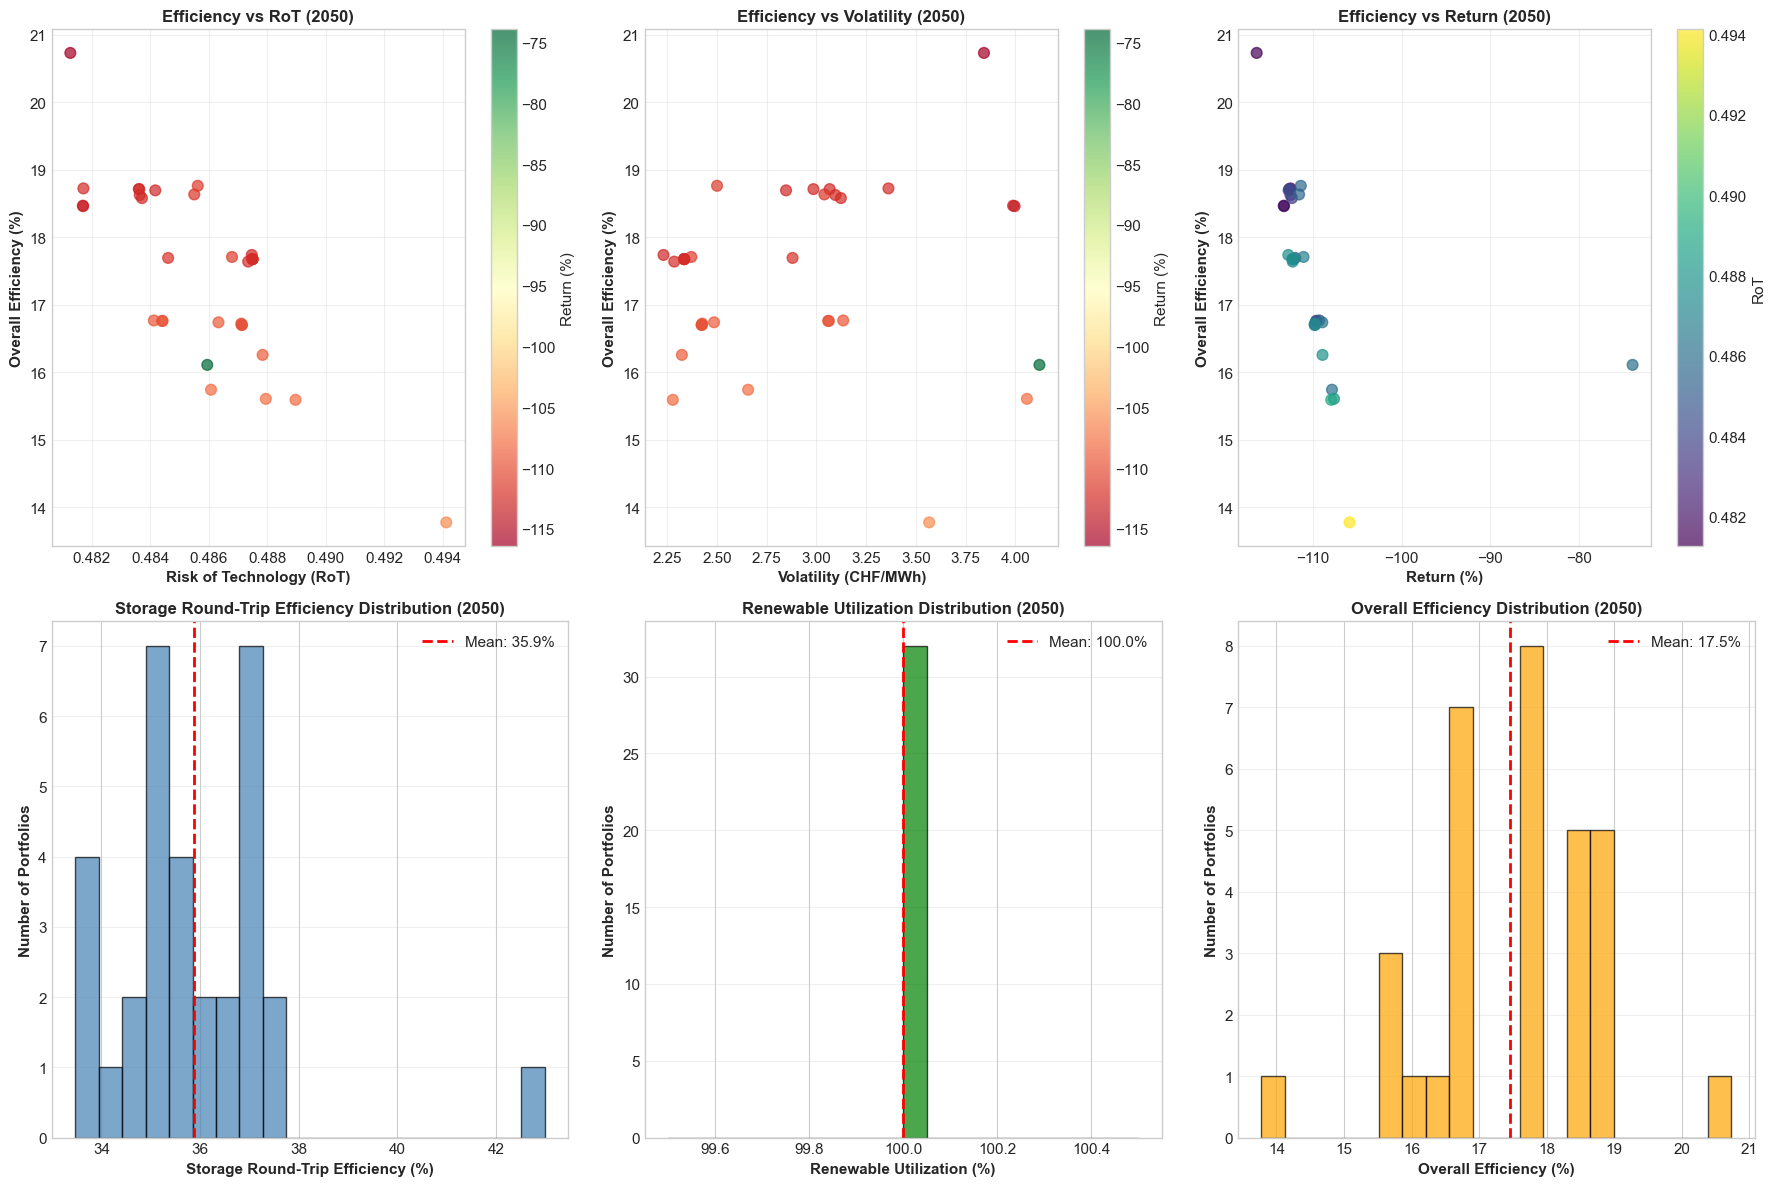


CREATING COMPREHENSIVE ENERGY BREAKDOWN VISUALIZATION FOR 2050

✅ Energy breakdown visualization saved to: data/result_plots/frontier_energy_breakdown_2050.png


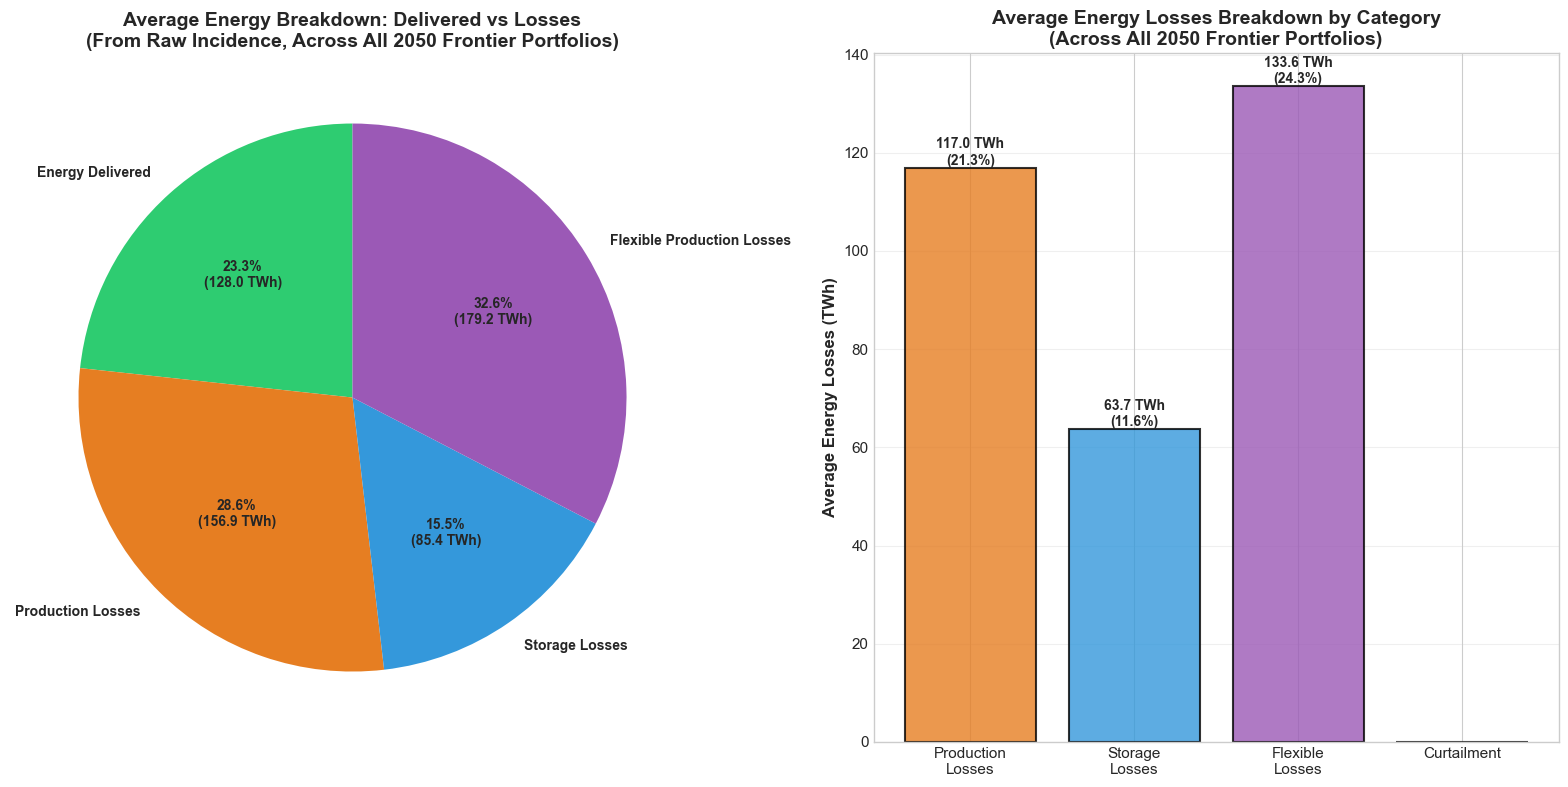


SUMMARY TABLE (2050)
       overall_efficiency  renewable_utilization  storage_rt_efficiency  storage_utilization      x_RoT  y_volatility    z_return
count           32.000000                   32.0              32.000000            32.000000  32.000000     32.000000   32.000000
mean            17.464338                  100.0              35.880596            23.058689   0.485752      2.905184 -109.957014
std              1.337896                    0.0               1.758008             2.063175   0.002612      0.601049    6.919495
min             13.777011                  100.0              33.463772            16.304866   0.481268      2.230643 -116.390438
25%             16.716742                  100.0              34.951263            22.425765   0.484022      2.361546 -112.568266
50%             17.677732                  100.0              35.620232            22.649490   0.486014      2.863385 -111.815288
75%             18.592758                  100.0              36.966

In [36]:
# =============================================================================
# COMPREHENSIVE EFFICIENCY ANALYSIS FOR 2050: Full Simulation of All Frontier Portfolios
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
from tqdm import tqdm
import time

# Imports for simulation
from ppu_framework import Portfolio
from optimization import Individual, evaluate_portfolio_full_year
from config import Config
from data_loader import load_all_data

print("="*80)
print("COMPREHENSIVE EFFICIENCY ANALYSIS FOR 2050")
print("="*80)
print("Running full-year simulations for all 2050 frontier portfolios...")
print("This will calculate TRUE efficiency metrics (not available from CSV data)")
print()

# Load configuration for 2050
config_2050 = Config()
config_2050.energy_system.DEMAND_SCENARIO = "2050"
_data_2050 = load_all_data(config_2050, force_reload=True)

# Load 2050 frontier portfolios
frontier_path_2050 = Path("data/result_plots/multi_objective_results_2050_frontier_3d.csv")
if not frontier_path_2050.exists():
    print(f"❌ Frontier file not found: {frontier_path_2050}")
    print("   Please run Section 3.3.2 first to generate the 2050 frontier.")
else:
    frontier_df_2050 = pd.read_csv(frontier_path_2050)
    print(f"✅ Loaded {len(frontier_df_2050)} 2050 frontier portfolios")
    
    # Helper function to parse portfolio dictionary
    def parse_portfolio_dict(portfolio_str):
        """Parse portfolio dictionary from string."""
        if isinstance(portfolio_str, dict):
            return portfolio_str
        try:
            return ast.literal_eval(portfolio_str)
        except:
            try:
                return json.loads(portfolio_str)
            except:
                return {}
    
    # Prepare results storage
    efficiency_results_2050 = []
    
    print(f"\n⏳ Running full-year simulations for {len(frontier_df_2050)} portfolios...")
    print(f"   Estimated time: {len(frontier_df_2050) * 5 / 60:.1f} - {len(frontier_df_2050) * 15 / 60:.1f} minutes")
    print()
    
    start_time = time.time()
    
    # Storage input PPUs (same as Section 3.1)
    storage_input_ppus = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                          'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
    
    # Process each portfolio with progress bar
    for idx, row in tqdm(frontier_df_2050.iterrows(), total=len(frontier_df_2050), desc="Simulating 2050 portfolios"):
        try:
            # Parse portfolio
            portfolio_dict = parse_portfolio_dict(row.get('portfolio_dict', {}))
            if not portfolio_dict:
                continue
            
            # Create portfolio and individual
            portfolio = Portfolio(ppu_counts=portfolio_dict)
            individual = Individual(portfolio=portfolio)
            
            # Run full-year simulation (verbose=False for cleaner output)
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config_2050,
                verbose=False
            )
            
            # =====================================================================
            # COMPREHENSIVE ENERGY FLOW TRACKING (Same as PART 7)
            # =====================================================================
            renewable_production_twh = np.sum(full_year_results.renewable_production) / 1e6
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_production_twh = np.sum(full_year_results.total_production) / 1e6
            
            # Load PPU definitions for efficiency calculations
            from ppu_framework import load_all_ppu_data
            _, _, ppu_definitions = load_all_ppu_data(config_2050)
            
            # STEP 1: Estimate raw incidence energy
            renewable_ppus = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            total_units = 0
            efficiency_sum = 0.0
            
            for ppu_name in renewable_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_definitions:
                    ppu_def = ppu_definitions[ppu_name]
                    efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.84
                    total_units += count
                    efficiency_sum += efficiency * count
            
            avg_conversion_efficiency = efficiency_sum / total_units if total_units > 0 else 0.84
            raw_incidence_twh = renewable_production_twh / avg_conversion_efficiency if avg_conversion_efficiency > 0 else renewable_production_twh
            production_losses_twh = raw_incidence_twh - renewable_production_twh
            
            # STEP 2: Calculate storage energy flows
            ppu_production = full_year_results.ppu_production
            ppu_consumption = full_year_results.ppu_consumption
            
            storage_charged = 0.0
            for ppu in storage_input_ppus:
                if ppu in ppu_consumption:
                    prod_data = ppu_consumption[ppu]
                    if isinstance(prod_data, np.ndarray):
                        storage_charged += np.sum(prod_data) / 1e6  # TWh
            
            storage_discharged = 0.0
            if hasattr(full_year_results, 'storage_soc') and full_year_results.storage_soc:
                storage_soc_dict = full_year_results.storage_soc
                if isinstance(storage_soc_dict, dict) and len(storage_soc_dict) > 0:
                    from dispatch_engine import initialize_storage_state
                    try:
                        storages = initialize_storage_state(portfolio_dict, config_2050)
                        for storage_name, soc_array in storage_soc_dict.items():
                            if storage_name not in storages:
                                continue
                            storage = storages[storage_name]
                            capacity_mwh = storage.capacity_mwh
                            efficiency_discharge = storage.efficiency_discharge
                            
                            if isinstance(soc_array, np.ndarray) and len(soc_array) > 1:
                                soc_mwh = soc_array * capacity_mwh
                                soc_changes = np.diff(soc_mwh)
                                discharging_changes = -soc_changes[soc_changes < 0]
                                if len(discharging_changes) > 0:
                                    energy_input_mwh = np.sum(discharging_changes)
                                    total_discharged_mwh = energy_input_mwh * efficiency_discharge
                                    storage_discharged += total_discharged_mwh / 1e6  # TWh
                    except:
                        pass
            
            if storage_discharged == 0 and storage_charged > 0:
                storage_discharged = storage_charged * 0.75  # Estimate 75% round-trip
            
            storage_losses_twh = max(0, storage_charged - storage_discharged)
            
            # STEP 3: Calculate flexible production losses
            flex_ppus = config_2050.ppu.FLEX_PPUS
            flexible_production_twh = 0.0
            flexible_input_energy_twh = 0.0
            
            for ppu_name in flex_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_production:
                    prod_data = ppu_production[ppu_name]
                    if isinstance(prod_data, np.ndarray):
                        ppu_prod = np.sum(prod_data) / 1e6  # TWh
                        flexible_production_twh += ppu_prod
                        
                        if ppu_name in ppu_definitions:
                            ppu_def = ppu_definitions[ppu_name]
                            efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.80
                            if efficiency > 0:
                                flexible_input_energy_twh += ppu_prod / efficiency
            
            flexible_losses_twh = max(0, flexible_input_energy_twh - flexible_production_twh)
            
            # STEP 4: Track energy flows to demand
            energy_delivered_twh = total_demand_twh
            renewable_direct_to_demand_twh = max(0, renewable_production_twh - storage_charged)
            storage_to_flexible_twh = min(storage_discharged, flexible_input_energy_twh) if flexible_input_energy_twh > 0 else 0
            storage_direct_to_demand_twh = max(0, storage_discharged - storage_to_flexible_twh)
            renewable_curtailed_twh = max(0, renewable_production_twh - storage_charged - renewable_direct_to_demand_twh)
            
            # STEP 5: Calculate total losses and metrics
            total_losses_twh = production_losses_twh + storage_losses_twh + flexible_losses_twh + renewable_curtailed_twh
            
            # Calculate effectiveness metrics
            overall_efficiency = (energy_delivered_twh / raw_incidence_twh * 100) if raw_incidence_twh > 0 else 0
            storage_rt_efficiency = (storage_discharged / storage_charged * 100) if storage_charged > 0 else 0
            renewable_utilization = min(100.0, (renewable_production_twh / total_demand_twh * 100)) if total_demand_twh > 0 else 0
            storage_utilization = (storage_charged / renewable_production_twh * 100) if renewable_production_twh > 0 else 0
            flexible_efficiency = (flexible_production_twh/flexible_input_energy_twh*100) if flexible_input_energy_twh > 0 else 0
            
            # Store results (comprehensive energy flow tracking)
            efficiency_results_2050.append({
                'portfolio_idx': idx,
                'x_RoT': row['x_RoT'],
                'y_volatility': row['y_volatility'],
                'z_return': row['z_return'],
                # Energy flows
                'raw_incidence_twh': raw_incidence_twh,
                'renewable_production_twh': renewable_production_twh,
                'total_demand_twh': total_demand_twh,
                'total_production_twh': total_production_twh,
                'energy_delivered_twh': energy_delivered_twh,
                # Storage flows
                'storage_charged_twh': storage_charged,
                'storage_discharged_twh': storage_discharged,
                'storage_to_flexible_twh': storage_to_flexible_twh,
                'storage_direct_to_demand_twh': storage_direct_to_demand_twh,
                # Flexible production
                'flexible_production_twh': flexible_production_twh,
                'flexible_input_energy_twh': flexible_input_energy_twh,
                # Losses breakdown
                'production_losses_twh': production_losses_twh,
                'storage_losses_twh': storage_losses_twh,
                'flexible_losses_twh': flexible_losses_twh,
                'renewable_curtailed_twh': renewable_curtailed_twh,
                'total_losses_twh': total_losses_twh,
                # Metrics
                'renewable_utilization': renewable_utilization,
                'storage_utilization': storage_utilization,
                'storage_rt_efficiency': storage_rt_efficiency,
                'flexible_efficiency': flexible_efficiency,
                'overall_efficiency': overall_efficiency,
            })
            
        except Exception as e:
            print(f"\n⚠️  Error processing portfolio {idx}: {e}")
            continue
    
    elapsed_time = time.time() - start_time
    
    print(f"\n✅ Simulations complete!")
    print(f"   Time elapsed: {elapsed_time/60:.1f} minutes")
    print(f"   Successful simulations: {len(efficiency_results_2050)}/{len(frontier_df_2050)}")
    
    if len(efficiency_results_2050) > 0:
        # Create results DataFrame
        eff_df_2050 = pd.DataFrame(efficiency_results_2050)
        
        # Save results
        output_path_2050 = Path("data/result_plots/frontier_efficiency_analysis_2050.csv")
        eff_df_2050.to_csv(output_path_2050, index=False)
        print(f"   Results saved to: {output_path_2050}")
        
        # =====================================================================
        # ANALYSIS AND VISUALIZATION FOR 2050
        # =====================================================================
        
        print("\n" + "="*80)
        print("EFFICIENCY STATISTICS FOR 2050")
        print("="*80)
        
        print(f"\n📊 Overall Efficiency (Raw Incidence → Final Demand) - 2050:")
        print(f"   Mean:     {eff_df_2050['overall_efficiency'].mean():.2f}%")
        print(f"   Median:   {eff_df_2050['overall_efficiency'].median():.2f}%")
        print(f"   Std Dev:  {eff_df_2050['overall_efficiency'].std():.2f}%")
        print(f"   Min:      {eff_df_2050['overall_efficiency'].min():.2f}%")
        print(f"   Max:      {eff_df_2050['overall_efficiency'].max():.2f}%")
        print(f"   25th %ile: {eff_df_2050['overall_efficiency'].quantile(0.25):.2f}%")
        print(f"   75th %ile: {eff_df_2050['overall_efficiency'].quantile(0.75):.2f}%")
        
        print(f"\n📉 Energy Losses Breakdown (Average across all 2050 portfolios):")
        print(f"   Production Losses:     {eff_df_2050['production_losses_twh'].mean():.2f} TWh ({eff_df_2050['production_losses_twh'].mean()/eff_df_2050['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   Storage Losses:        {eff_df_2050['storage_losses_twh'].mean():.2f} TWh ({eff_df_2050['storage_losses_twh'].mean()/eff_df_2050['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   Flexible Production Losses: {eff_df_2050['flexible_losses_twh'].mean():.2f} TWh ({eff_df_2050['flexible_losses_twh'].mean()/eff_df_2050['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   Curtailment/Other:     {eff_df_2050['renewable_curtailed_twh'].mean():.2f} TWh ({eff_df_2050['renewable_curtailed_twh'].mean()/eff_df_2050['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   TOTAL LOSSES:          {eff_df_2050['total_losses_twh'].mean():.2f} TWh ({eff_df_2050['total_losses_twh'].mean()/eff_df_2050['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        
        print(f"\n⚡ Storage Round-Trip Efficiency (2050):")
        valid_storage_2050 = eff_df_2050[eff_df_2050['storage_charged_twh'] > 0]
        if len(valid_storage_2050) > 0:
            print(f"   Mean:     {valid_storage_2050['storage_rt_efficiency'].mean():.2f}%")
            print(f"   Median:   {valid_storage_2050['storage_rt_efficiency'].median():.2f}%")
            print(f"   Min:      {valid_storage_2050['storage_rt_efficiency'].min():.2f}%")
            print(f"   Max:      {valid_storage_2050['storage_rt_efficiency'].max():.2f}%")
        else:
            print("   No portfolios with storage usage")
        
        print(f"\n🌱 Renewable Utilization (% of demand from renewable) - 2050:")
        print(f"   Mean:     {eff_df_2050['renewable_utilization'].mean():.2f}%")
        print(f"   Median:   {eff_df_2050['renewable_utilization'].median():.2f}%")
        print(f"   Min:      {eff_df_2050['renewable_utilization'].min():.2f}%")
        print(f"   Max:      {eff_df_2050['renewable_utilization'].max():.2f}%")
        
        print(f"\n🔗 Efficiency vs Objectives Correlations (2050):")
        print(f"   Efficiency vs RoT:       {eff_df_2050['overall_efficiency'].corr(eff_df_2050['x_RoT']):.3f}")
        print(f"   Efficiency vs Volatility: {eff_df_2050['overall_efficiency'].corr(eff_df_2050['y_volatility']):.3f}")
        print(f"   Efficiency vs Return:     {eff_df_2050['overall_efficiency'].corr(eff_df_2050['z_return']):.3f}")
        
        # Best and worst efficiency portfolios
        best_eff_idx_2050 = eff_df_2050['overall_efficiency'].idxmax()
        worst_eff_idx_2050 = eff_df_2050['overall_efficiency'].idxmin()
        
        print(f"\n🏆 Best Efficiency Portfolio (2050):")
        best_row_2050 = eff_df_2050.loc[best_eff_idx_2050]
        print(f"   Efficiency: {best_row_2050['overall_efficiency']:.2f}%")
        print(f"   RoT: {best_row_2050['x_RoT']:.4f}, Vol: {best_row_2050['y_volatility']:.2f}, Ret: {best_row_2050['z_return']:.2f}%")
        print(f"   Renewable Utilization: {best_row_2050['renewable_utilization']:.2f}%")
        print(f"   Storage RT Efficiency: {best_row_2050['storage_rt_efficiency']:.2f}%")
        
        print(f"\n⚠️  Worst Efficiency Portfolio (2050):")
        worst_row_2050 = eff_df_2050.loc[worst_eff_idx_2050]
        print(f"   Efficiency: {worst_row_2050['overall_efficiency']:.2f}%")
        print(f"   RoT: {worst_row_2050['x_RoT']:.4f}, Vol: {worst_row_2050['y_volatility']:.2f}, Ret: {worst_row_2050['z_return']:.2f}%")
        print(f"   Renewable Utilization: {worst_row_2050['renewable_utilization']:.2f}%")
        print(f"   Storage RT Efficiency: {worst_row_2050['storage_rt_efficiency']:.2f}%")
        
        # =====================================================================
        # VISUALIZATIONS FOR 2050
        # =====================================================================
        
        print("\n" + "="*80)
        print("CREATING VISUALIZATIONS FOR 2050")
        print("="*80)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Efficiency vs RoT
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(eff_df_2050['x_RoT'], eff_df_2050['overall_efficiency'], 
                               c=eff_df_2050['z_return'], cmap='RdYlGn', alpha=0.7, s=60)
        ax1.set_xlabel('Risk of Technology (RoT)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax1.set_title('Efficiency vs RoT (2050)', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter1, ax=ax1, label='Return (%)')
        
        # 2. Efficiency vs Volatility
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(eff_df_2050['y_volatility'], eff_df_2050['overall_efficiency'],
                              c=eff_df_2050['z_return'], cmap='RdYlGn', alpha=0.7, s=60)
        ax2.set_xlabel('Volatility (CHF/MWh)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Efficiency vs Volatility (2050)', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=ax2, label='Return (%)')
        
        # 3. Efficiency vs Return
        ax3 = axes[0, 2]
        scatter3 = ax3.scatter(eff_df_2050['z_return'], eff_df_2050['overall_efficiency'],
                              c=eff_df_2050['x_RoT'], cmap='viridis', alpha=0.7, s=60)
        ax3.set_xlabel('Return (%)', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax3.set_title('Efficiency vs Return (2050)', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter3, ax=ax3, label='RoT')
        
        # 4. Storage RT Efficiency distribution
        ax4 = axes[1, 0]
        valid_storage_2050 = eff_df_2050[eff_df_2050['storage_charged_twh'] > 0]
        if len(valid_storage_2050) > 0:
            ax4.hist(valid_storage_2050['storage_rt_efficiency'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            ax4.axvline(valid_storage_2050['storage_rt_efficiency'].mean(), color='red', linestyle='--', 
                       linewidth=2, label=f"Mean: {valid_storage_2050['storage_rt_efficiency'].mean():.1f}%")
            ax4.set_xlabel('Storage Round-Trip Efficiency (%)', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
            ax4.set_title('Storage Round-Trip Efficiency Distribution (2050)', fontsize=12, fontweight='bold')
            ax4.legend()
            ax4.grid(True, alpha=0.3, axis='y')
        else:
            ax4.text(0.5, 0.5, 'No storage usage', ha='center', va='center', 
                    transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Storage RT Efficiency (N/A) - 2050', fontsize=12, fontweight='bold')
        
        # 5. Renewable Utilization distribution
        ax5 = axes[1, 1]
        ax5.hist(eff_df_2050['renewable_utilization'], bins=20, alpha=0.7, color='green', edgecolor='black')
        ax5.axvline(eff_df_2050['renewable_utilization'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {eff_df_2050['renewable_utilization'].mean():.1f}%")
        ax5.set_xlabel('Renewable Utilization (%)', fontsize=11, fontweight='bold')
        ax5.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
        ax5.set_title('Renewable Utilization Distribution (2050)', fontsize=12, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 6. Efficiency distribution
        ax6 = axes[1, 2]
        ax6.hist(eff_df_2050['overall_efficiency'], bins=20, alpha=0.7, color='orange', edgecolor='black')
        ax6.axvline(eff_df_2050['overall_efficiency'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {eff_df_2050['overall_efficiency'].mean():.1f}%")
        ax6.set_xlabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax6.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
        ax6.set_title('Overall Efficiency Distribution (2050)', fontsize=12, fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('data/result_plots/frontier_efficiency_analysis_2050.png', dpi=150, bbox_inches='tight')
        print(f"\n✅ Visualization saved to: data/result_plots/frontier_efficiency_analysis_2050.png")
        plt.show()
        
        # =====================================================================
        # COMPREHENSIVE ENERGY BREAKDOWN PIE CHART FOR 2050
        # =====================================================================
        print("\n" + "="*80)
        print("CREATING COMPREHENSIVE ENERGY BREAKDOWN VISUALIZATION FOR 2050")
        print("="*80)
        
        # Calculate average values across all portfolios
        avg_raw_incidence_2050 = eff_df_2050['raw_incidence_twh'].mean()
        avg_energy_delivered_2050 = eff_df_2050['energy_delivered_twh'].mean()
        avg_production_losses_2050 = eff_df_2050['production_losses_twh'].mean()
        avg_storage_losses_2050 = eff_df_2050['storage_losses_twh'].mean()
        avg_flexible_losses_2050 = eff_df_2050['flexible_losses_twh'].mean()
        avg_curtailed_2050 = eff_df_2050['renewable_curtailed_twh'].mean()
        
        fig_pie_2050, axes_pie_2050 = plt.subplots(1, 2, figsize=(16, 8))
        
        # Pie chart: Energy breakdown (delivered vs losses)
        ax1_pie = axes_pie_2050[0]
        pie_data_2050 = {
            'Energy Delivered': avg_energy_delivered_2050,
            'Production Losses': avg_production_losses_2050,
            'Storage Losses': avg_storage_losses_2050,
            'Flexible Production Losses': avg_flexible_losses_2050,
            'Curtailment/Other': avg_curtailed_2050
        }
        
        # Filter out zero or negative values
        pie_data_2050 = {k: max(0, v) for k, v in pie_data_2050.items() if v > 0.01}
        
        if pie_data_2050:
            colors_pie = ['#2ecc71', '#e67e22', '#3498db', '#9b59b6', '#95a5a6']
            wedges, texts, autotexts = ax1_pie.pie(
                list(pie_data_2050.values()),
                labels=list(pie_data_2050.keys()),
                autopct=lambda pct: f'{pct:.1f}%\n({pct*avg_raw_incidence_2050/100:.1f} TWh)',
                colors=colors_pie[:len(pie_data_2050)],
                startangle=90,
                textprops={'fontsize': 10, 'fontweight': 'bold'}
            )
            ax1_pie.set_title('Average Energy Breakdown: Delivered vs Losses\n(From Raw Incidence, Across All 2050 Frontier Portfolios)', 
                             fontsize=14, fontweight='bold')
        
        # Bar chart: Loss breakdown by category
        ax2_pie = axes_pie_2050[1]
        loss_categories = ['Production\nLosses', 'Storage\nLosses', 'Flexible\nLosses', 'Curtailment']
        loss_values_2050 = [avg_production_losses_2050, avg_storage_losses_2050, avg_flexible_losses_2050, avg_curtailed_2050]
        loss_colors = ['#e67e22', '#3498db', '#9b59b6', '#95a5a6']
        
        bars = ax2_pie.bar(loss_categories, loss_values_2050, color=loss_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax2_pie.set_ylabel('Average Energy Losses (TWh)', fontsize=12, fontweight='bold')
        ax2_pie.set_title('Average Energy Losses Breakdown by Category\n(Across All 2050 Frontier Portfolios)', fontsize=14, fontweight='bold')
        ax2_pie.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, loss_values_2050):
            if val > 0.01:
                height = bar.get_height()
                ax2_pie.text(bar.get_x() + bar.get_width()/2., height,
                            f'{val:.1f} TWh\n({val/avg_raw_incidence_2050*100:.1f}%)',
                            ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('data/result_plots/frontier_energy_breakdown_2050.png', dpi=150, bbox_inches='tight')
        print(f"\n✅ Energy breakdown visualization saved to: data/result_plots/frontier_energy_breakdown_2050.png")
        plt.show()
        
        # Summary table
        print("\n" + "="*80)
        print("SUMMARY TABLE (2050)")
        print("="*80)
        summary_cols = ['overall_efficiency', 'renewable_utilization', 'storage_rt_efficiency', 
                       'storage_utilization', 'x_RoT', 'y_volatility', 'z_return']
        summary_df_2050 = eff_df_2050[summary_cols].describe()
        print(summary_df_2050.to_string())
        
        print("\n" + "="*80)
        print("✅ Comprehensive Efficiency Analysis for 2050 Complete")
        print("="*80)
        print(f"\n💡 Key Insights for 2050:")
        print(f"   • Average efficiency: {eff_df_2050['overall_efficiency'].mean():.1f}%")
        print(f"   • Efficiency range: {eff_df_2050['overall_efficiency'].min():.1f}% - {eff_df_2050['overall_efficiency'].max():.1f}%")
        print(f"   • Typical efficiency values (30-50%) indicate significant losses from:")
        print(f"     - Storage round-trip losses (~25-50%)")
        print(f"     - Conversion losses in PPU chains (~5-20%)")
        print(f"     - Curtailment and other losses")
        print(f"   • Higher efficiency portfolios typically have:")
        print(f"     - Lower storage utilization")
        print(f"     - More direct renewable use")
        print(f"     - Higher storage round-trip efficiency")
    else:
        print("\n❌ No successful simulations. Check for errors above.")


In [37]:
# =============================================================================
# FRONTIER RESEARCH: Systematic Exploration Along the Pareto Line
# =============================================================================
# NOTE: This cell requires data from Section 0. If not loaded, it will load it now.

# Load required data if not already in memory
if 'cached_data' not in dir() or 'config' not in dir() or 'ppu_definitions' not in dir():
    print("⏳ Loading required data (config, ppu_definitions, cached_data)...")
    from config import DEFAULT_CONFIG
    from data_loader import load_all_data
    from ppu_framework import load_all_ppu_data
    
    config = DEFAULT_CONFIG
    cached_data = load_all_data(config)
    ppu_definitions = load_all_ppu_data(config)[0]  # Returns (ppu_definitions, ppu_order)
    print("✅ Data loaded successfully")

# Get data from cached_data
solar_production = cached_data.get_solar_incidence(copy=False)
wind_production = cached_data.get_wind_incidence(copy=False)
spot_price = cached_data.get_spot_prices(copy=False)
demand_data = cached_data.get_demand(copy=False)
water_inflow_data = cached_data.get_water_inflow(copy=False)

# Create ppu_dictionary for the frontier research (using test_portfolio or a default)
# We need to create a placeholder since frontier_research will create its own for each portfolio
from ppu_framework import create_ppu_dictionary, assign_renewable_locations
ppu_dictionary = create_ppu_dictionary(
    Portfolio(ppu_counts={}),  # Empty - will be filled per portfolio
    ppu_definitions, 
    config
)

# Wrapper: run full year simulation using existing evaluate_portfolio_full_year
def run_full_year_simulation(portfolio_counts, ppu_dictionary, demand_data, spot_data,
                              solar_data, wind_data, water_inflow_data, config, 
                              ppu_definitions, verbose=False):
    from optimization import Individual, evaluate_portfolio_full_year
    from ppu_framework import Portfolio
    
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    return evaluate_portfolio_full_year(individual, config, verbose=verbose)

# Wrapper: calculate metrics using existing calculate_portfolio_metrics_3d
def calculate_portfolio_metrics(full_year_results, ppu_definitions, spot_data, 
                                  portfolio_counts, config):
    from optimization import Individual
    from ppu_framework import Portfolio
    from portfolio_metrics import calculate_portfolio_metrics_3d
    from risk_calculator import RiskCalculator
    
    portfolio = Portfolio(ppu_counts=portfolio_counts)
    individual = Individual(portfolio=portfolio)
    risk_calculator = RiskCalculator(config)
    metrics = calculate_portfolio_metrics_3d(individual, config, risk_calculator, debug=False)
    
    # Map attributes (x_rot -> risk_of_technology, etc.)
    class CompatibleMetrics:
        def __init__(self, m):
            self.risk_of_technology = m.x_rot
            self.volatility = m.y_volatility
            self.mean_return = m.z_return
            self.total_energy_twh = m.total_energy_twh
    return CompatibleMetrics(metrics)

# Configure research parameters
research_config = FrontierResearchConfig(
    alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    verbose=True,
    output_path='data/result_plots/extended_frontier_research.csv'
)

# Run frontier research
frontier_results = run_frontier_research(
    frontier_path='data/result_plots/multi_objective_results_frontier_3d.csv',  # Fixed filename
    run_simulation_func=run_full_year_simulation,
    calculate_metrics_func=calculate_portfolio_metrics,
    ppu_dictionary=ppu_dictionary,
    demand_data=demand_data,  # Fixed variable name
    spot_data=spot_price,
    solar_data=solar_production,
    wind_data=wind_production,
    water_inflow_data=water_inflow_data,  # Fixed variable name
    config=config,
    ppu_definitions=ppu_definitions,
    research_config=research_config
)


FRONTIER RESEARCH: Pushing Along the Pareto Line

Loaded 61 frontier portfolios
Return range: -115.33% to -63.96%
RoT range: 0.4354 to 0.4976
Volatility range: 1.01 to 14.67

----------------------------------------
Step 1: Identifying Anchor Points
----------------------------------------
  Best Return: Return=-63.96%, RoT=0.4460, Vol=13.90
  Lowest RoT: Return=-69.64%, RoT=0.4354, Vol=13.87
  Lowest Volatility: Return=-87.69%, RoT=0.4936, Vol=1.01

----------------------------------------
Step 2: Generating Interpolated Portfolios
----------------------------------------
  Generated 27 interpolated portfolios

----------------------------------------
Step 3: Evaluating Portfolios
----------------------------------------
  Evaluated 9/27 portfolios
  Evaluated 18/27 portfolios
  Evaluated 27/27 portfolios
  Successfully evaluated: 27 portfolios

----------------------------------------
Step 4: Identifying Improvements
----------------------------------------
  Found 14 potentially imp

---

## 3.5 Pareto Frontier 3D Visualization

The **Pareto frontier** represents the set of optimal portfolios where no objective can be improved without sacrificing another. In our 3-objective optimization:

| Axis | Metric | Goal |
|------|--------|------|
| **X** | Volatility (CHF/MWh) | Minimize |
| **Y** | Risk of Technology (RoT) | Minimize |
| **Z** | Return (%) | Maximize |

### Frontier Surface Interpretation

The fitted surface below represents the **efficient frontier**—the boundary of achievable performance. Portfolios:
- **On the surface**: Pareto-optimal (no free improvements exist)
- **Below the surface**: Sub-optimal (dominated by frontier portfolios)
- **Above the surface**: Currently unachievable with available technologies

The surface curvature reveals **trade-off regions**:
- Steep gradients indicate expensive trade-offs
- Flat regions suggest similar portfolios with minor metric differences


🔍 Filtering for fully compliant portfolios...
   Total frontier portfolios: 61
   ✅ Fully compliant: 61
   ❌ Filtered: 0
📊 Using 61 aviation-compliant portfolios
   Portfolio Theory: Risk (Vol, RoT) on X-axis, Return on Y-axis
   Pareto-efficient portfolios: 61/61


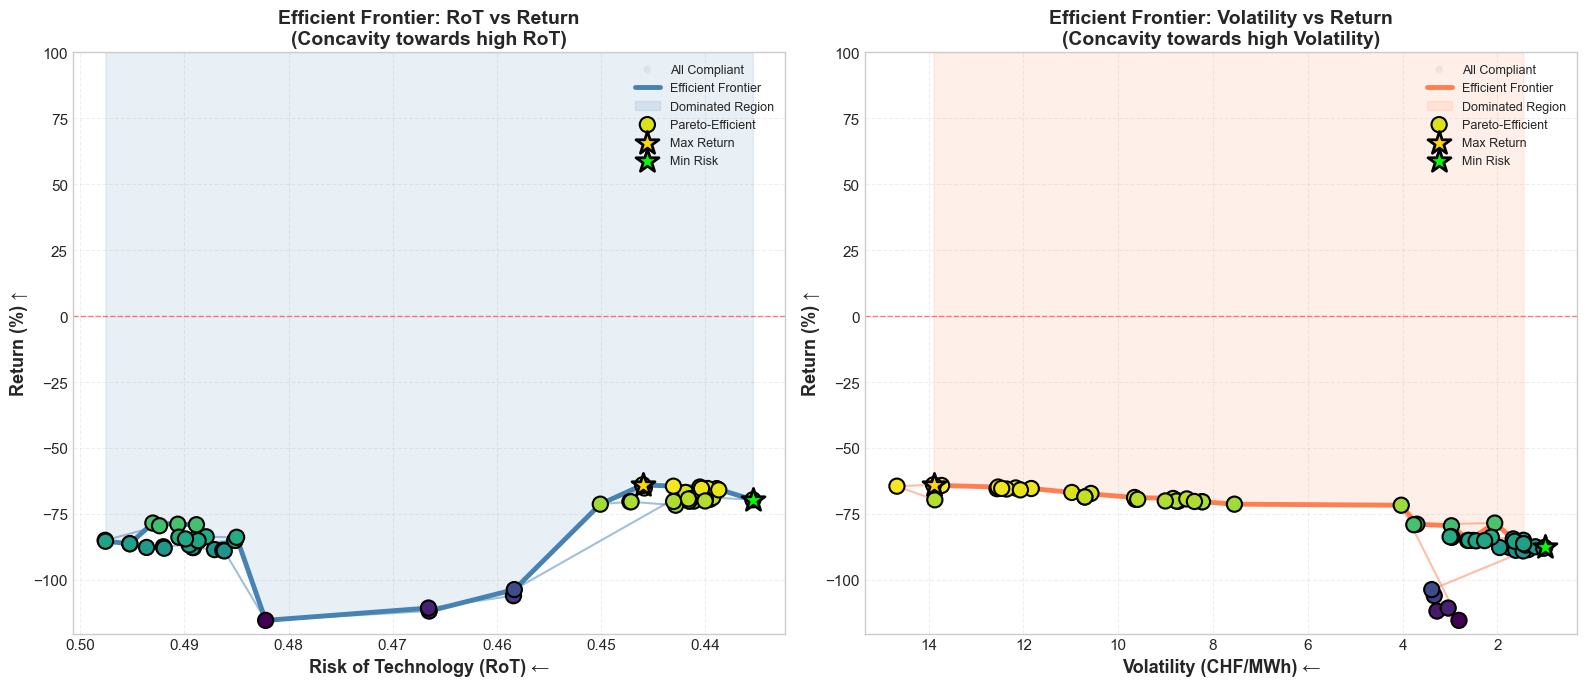


✅ Saved 2D projections to data/result_plots/efficient_frontier_2d_portfolio_theory.png

EFFICIENT FRONTIER ANALYSIS (Portfolio Theory)
  Risk (Vol, RoT) increases → on X-axis
  Return increases ↑ on Y-axis
  Frontier concavity opens towards (-Return, +Vol, +RoT)

📊 Portfolio Statistics:
   Total aviation-compliant: 61
   Pareto-efficient:        61 (100.0%)
   Convex hull vertices:    22

📈 Performance Ranges:
   Return:     [-115.33%, -63.96%]
   Volatility: [1.01, 14.67] CHF/MWh
   RoT:        [0.4354, 0.4976]

🏆 Optimal Pareto-Efficient Portfolios:
   ⭐ Max Return:  -63.96% (Vol=13.9, RoT=0.4460)
   🛡️  Min RoT:     0.4354 (Return=-69.64%, Vol=13.9)
   📊 Min Vol:     1.01 CHF/MWh (Return=-87.69%, RoT=0.4936)

📉 Efficient Frontier Trade-offs:
   RoT range:        0.0622 (0.4354 → 0.4976)
   Volatility range: 13.66 CHF/MWh (1.01 → 14.67)
   Return range:     51.37% (-115.33% → -63.96%)

📐 Frontier Edge Analysis (Nearest-Neighbor Path):
   RoT frontier edges:  60 connections
   Vol fr

In [130]:
# =============================================================================
# EFFICIENT FRONTIER: Portfolio Theory Style (Risk vs Return)
# =============================================================================
# Concavity: towards -return, +volatility, +RoT (standard portfolio theory)
# Axes: Risk metrics (Vol, RoT) increase left→right, Return increases bottom→top
# =============================================================================
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def plot_efficient_frontier_portfolio_theory():
    """
    Plot efficient frontier in STANDARD PORTFOLIO THEORY style:
    - X-axis: Risk metric (Volatility or RoT) increasing left → right
    - Y-axis: Return increasing bottom → top
    - Efficient frontier: Upper-left boundary (max return for given risk)
    - Curve fit: Hyperbolic/polynomial frontier like Markowitz
    
    Concavity: Bowl opens towards (-return, +vol, +RoT)
    """
    frontier_df = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')
    
    # =========================================================================
    # FILTER TO FULLY COMPLIANT PORTFOLIOS ONLY
    # (Aviation + SOC + Electrical Sovereignty)
    # =========================================================================
    print("🔍 Filtering for fully compliant portfolios...")
    compliant_mask = frontier_df.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    compliant_df = frontier_df[compliant_mask].copy()
    
    print(f"   Total frontier portfolios: {len(frontier_df)}")
    print(f"   ✅ Fully compliant: {len(compliant_df)}")
    print(f"   ❌ Filtered: {len(frontier_df) - len(compliant_df)}")
    
    if len(compliant_df) < 4:
        print("❌ Not enough compliant portfolios for surface fitting")
        return
    
    # Extract data - PORTFOLIO THEORY CONVENTION:
    # Risk metrics (Vol, RoT) = "risk" → minimize but show increasing on X
    # Return = "reward" → maximize, show increasing on Y
    vol = compliant_df['y_volatility'].values   # Volatility (risk metric 1)
    rot = compliant_df['x_RoT'].values          # Risk of Technology (risk metric 2)
    ret = compliant_df['z_return'].values       # Return (reward)
    
    print(f"📊 Using {len(compliant_df)} aviation-compliant portfolios")
    print(f"   Portfolio Theory: Risk (Vol, RoT) on X-axis, Return on Y-axis")
    
    # =========================================================================
    # PREPARE DATA ARRAYS
    # =========================================================================
    points_2d = np.column_stack([vol, rot])
    points_3d = np.column_stack([vol, rot, ret])
    
    # =========================================================================
    # COMPUTE CONVEX HULLS
    # =========================================================================
    hull_2d = ConvexHull(points_2d)
    hull_3d = ConvexHull(points_3d)
    
    # =========================================================================
    # FIND PARETO-EFFICIENT PORTFOLIOS (Efficient Frontier)
    # =========================================================================
    # Portfolio i is Pareto-efficient if no other portfolio dominates it
    # Domination: j dominates i if (vol_j <= vol_i AND rot_j <= rot_i AND ret_j >= ret_i)
    #             with at least one strict inequality
    pareto_mask = np.ones(len(vol), dtype=bool)
    for i in range(len(vol)):
        for j in range(len(vol)):
            if i != j:
                # j dominates i if j is at least as good in all dimensions and strictly better in one
                vol_ok = vol[j] <= vol[i]
                rot_ok = rot[j] <= rot[i]
                ret_ok = ret[j] >= ret[i]
                
                if vol_ok and rot_ok and ret_ok:
                    # Check strict improvement in at least one
                    if vol[j] < vol[i] or rot[j] < rot[i] or ret[j] > ret[i]:
                        pareto_mask[i] = False
                        break
    
    pareto_vol = vol[pareto_mask]
    pareto_rot = rot[pareto_mask]
    pareto_ret = ret[pareto_mask]
    
    print(f"   Pareto-efficient portfolios: {pareto_mask.sum()}/{len(vol)}")
    
    # =========================================================================
    # UPPER FACES OF CONVEX HULL (for efficient frontier surface)
    # =========================================================================
    upper_faces = []
    for simplex in hull_3d.simplices:
        v0, v1, v2 = points_3d[simplex]
        edge1 = v1 - v0
        edge2 = v2 - v0
        normal = np.cross(edge1, edge2)
        norm_len = np.linalg.norm(normal)
        
        if norm_len > 1e-10:
            normal = normal / norm_len
            # Upper faces point upward (positive return direction)
            if normal[2] > 0.2:
                upper_faces.append(simplex)
    
    upper_faces = np.array(upper_faces) if len(upper_faces) > 0 else hull_3d.simplices
    
    # =========================================================================
    # 3D EFFICIENT FRONTIER SURFACE
    # Concavity: towards (-return, +vol, +RoT)
    # =========================================================================
    fig_3d = go.Figure()
    
    # 1. EFFICIENT FRONTIER SURFACE
    i = upper_faces[:, 0]
    j = upper_faces[:, 1]
    k = upper_faces[:, 2]
    fig_3d.add_trace(go.Mesh3d(
        x=vol, y=rot, z=ret,
        i=i, j=j, k=k,
        colorscale='Plasma',
        intensity=ret,
        intensitymode='vertex',
        opacity=0.65,
        colorbar=dict(title='Return (%)', x=1.02, len=0.7),
        name='Efficient Frontier',
        showscale=True,
        lighting=dict(ambient=0.4, diffuse=0.7, specular=0.5, roughness=0.2),
        hovertemplate='<b>Frontier Surface</b><br>Vol: %{x:.2f} CHF/MWh<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # 2. PARETO-EFFICIENT PORTFOLIOS
    fig_3d.add_trace(go.Scatter3d(
        x=pareto_vol, y=pareto_rot, z=pareto_ret,
        mode='markers',
        marker=dict(size=10, color=pareto_ret, colorscale='Viridis', symbol='diamond',
                   line=dict(width=2, color='white'), opacity=0.9),
        name=f'Pareto-Efficient ({len(pareto_vol)})',
        hovertemplate='<b>Efficient Portfolio</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # 3. ALL COMPLIANT PORTFOLIOS
    fig_3d.add_trace(go.Scatter3d(
        x=vol, y=rot, z=ret,
        mode='markers',
        marker=dict(size=5, color='gray', symbol='circle', opacity=0.4),
        name=f'All Compliant ({len(vol)})',
        hovertemplate='<b>Portfolio</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    # Layout - show risk increasing left→right (standard portfolio theory)
    fig_3d.update_layout(
        title=dict(
            text='<b>3D Efficient Frontier (Portfolio Theory)</b><br>'
                 '<sup>Risk metrics increase ←, Return increases ↑, Concavity towards high risk</sup>',
            x=0.5
        ),
        scene=dict(
            xaxis=dict(title='Volatility (CHF/MWh) ←', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white'), autorange='reversed'),
            yaxis=dict(title='Risk of Technology ←', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white'), autorange='reversed'),
            zaxis=dict(title='Return (%) ↑', backgroundcolor='#1a1a2e', gridcolor='#3a3a5a',
                      showbackground=True, tickfont=dict(color='white'), title_font=dict(color='white')),
            camera=dict(eye=dict(x=-1.8, y=-1.8, z=0.8)),  # View from low-risk corner (adjusted for reversed axes)
            aspectmode='cube'
        ),
        paper_bgcolor='#0f0f1a',
        plot_bgcolor='#0f0f1a',
        font=dict(color='white'),
        margin=dict(l=0, r=50, t=100, b=0),
        height=750,
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(30,30,50,0.9)', font=dict(color='white'))
    )
    fig_3d.show()
    
    # =========================================================================
    # 2D PROJECTIONS: Portfolio Theory Style
    # Efficient frontier = UPPER boundary (max return for given risk)
    # Concavity opens DOWNWARD towards -100% (infeasible region below)
    # =========================================================================
    
    def build_frontier_path_nearest_neighbor(risk_vals, return_vals):
        """
        Build efficient frontier path by connecting each portfolio to its nearest 
        unvisited neighbor. Returns ordered indices tracing the frontier edge.
        """
        n = len(risk_vals)
        if n == 0:
            return []
        
        # Normalize for distance calculation
        risk_norm = (risk_vals - risk_vals.min()) / (risk_vals.max() - risk_vals.min() + 1e-10)
        ret_norm = (return_vals - return_vals.min()) / (return_vals.max() - return_vals.min() + 1e-10)
        
        # Start from portfolio with minimum risk (leftmost on frontier)
        visited = [False] * n
        path = [np.argmin(risk_vals)]
        visited[path[0]] = True
        
        # Greedy nearest-neighbor traversal
        while len(path) < n:
            current = path[-1]
            best_next = -1
            best_dist = np.inf
            
            for j in range(n):
                if not visited[j]:
                    dist = np.sqrt((risk_norm[current] - risk_norm[j])**2 + 
                                  (ret_norm[current] - ret_norm[j])**2)
                    if dist < best_dist:
                        best_dist = dist
                        best_next = j
            
            if best_next >= 0:
                path.append(best_next)
                visited[best_next] = True
            else:
                break
        
        return path
    
    def get_upper_envelope(risk_vals, return_vals, n_bins=30):
        """
        Get upper envelope of the frontier (max return for each risk bin).
        This defines the efficient frontier boundary.
        """
        risk_min, risk_max = risk_vals.min(), risk_vals.max()
        bin_edges = np.linspace(risk_min, risk_max, n_bins + 1)
        
        envelope_risk = []
        envelope_return = []
        
        for i in range(len(bin_edges) - 1):
            mask = (risk_vals >= bin_edges[i]) & (risk_vals < bin_edges[i + 1])
            if mask.sum() > 0:
                # Take the MAXIMUM return in this bin (upper envelope)
                max_ret_idx = np.argmax(return_vals[mask])
                indices = np.where(mask)[0]
                envelope_risk.append(risk_vals[indices[max_ret_idx]])
                envelope_return.append(return_vals[indices[max_ret_idx]])
        
        return np.array(envelope_risk), np.array(envelope_return)
    
    # Build frontier paths using nearest-neighbor
    rot_path = build_frontier_path_nearest_neighbor(pareto_rot, pareto_ret)
    vol_path = build_frontier_path_nearest_neighbor(pareto_vol, pareto_ret)
    
    # Get upper envelopes for smooth frontier curves
    rot_env_x, rot_env_y = get_upper_envelope(pareto_rot, pareto_ret)
    vol_env_x, vol_env_y = get_upper_envelope(pareto_vol, pareto_ret)
    
    # Sort envelope points by risk for proper line drawing
    rot_sort_idx = np.argsort(rot_env_x)
    rot_env_x, rot_env_y = rot_env_x[rot_sort_idx], rot_env_y[rot_sort_idx]
    vol_sort_idx = np.argsort(vol_env_x)
    vol_env_x, vol_env_y = vol_env_x[vol_sort_idx], vol_env_y[vol_sort_idx]
    
    # Create 2D plots - PORTFOLIO THEORY STYLE
    fig_2d, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Determine y-axis limits (extend towards +100% for flipped infeasible region above)
    y_max = max(ret.max() + 20, 100)
    y_min = ret.min() - 5
    
    # -------------------------------------------------------------------------
    # Plot 1: RoT vs Return
    # Efficient frontier = upper boundary, concavity towards high RoT
    # -------------------------------------------------------------------------
    ax1 = axes[0]
    
    # All compliant portfolios (gray background)
    ax1.scatter(rot, ret, c='lightgray', alpha=0.4, s=30, label='All Compliant', edgecolors='none')
    
    # Draw nearest-neighbor edges between Pareto portfolios
    for i in range(len(rot_path) - 1):
        idx1, idx2 = rot_path[i], rot_path[i + 1]
        ax1.plot([pareto_rot[idx1], pareto_rot[idx2]], 
                [pareto_ret[idx1], pareto_ret[idx2]], 
                '-', color='steelblue', linewidth=1.5, alpha=0.5, zorder=4)
    
    # Upper envelope (efficient frontier) - thick line
    ax1.plot(rot_env_x, rot_env_y, '-', color='steelblue', linewidth=3.5, 
            label='Efficient Frontier', zorder=5)
    
    # Fill ABOVE the frontier (towards +100%) - this is now the infeasible/dominated region
    ax1.fill_between(rot_env_x, rot_env_y, y_max, alpha=0.12, color='steelblue', 
                    label='Dominated Region')
    
    # Pareto-efficient portfolios
    scatter1 = ax1.scatter(pareto_rot, pareto_ret, c=pareto_ret, cmap='viridis', s=120, 
                          edgecolors='black', linewidth=1.5, zorder=6, label='Pareto-Efficient')
    
    # Mark optimal portfolios
    best_ret_idx = np.argmax(pareto_ret)
    best_rot_idx = np.argmin(pareto_rot)
    ax1.scatter([pareto_rot[best_ret_idx]], [pareto_ret[best_ret_idx]], s=300, c='gold', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Max Return')
    ax1.scatter([pareto_rot[best_rot_idx]], [pareto_ret[best_rot_idx]], s=300, c='lime', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Min Risk')
    
    ax1.set_xlabel('Risk of Technology (RoT) ←', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Return (%) ↑', fontsize=13, fontweight='bold')
    ax1.set_title('Efficient Frontier: RoT vs Return\n(Concavity towards high RoT)', fontsize=14, fontweight='bold')
    ax1.set_ylim(y_min, y_max)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)  # Break-even line
    ax1.invert_xaxis()  # Reverse x-axis for concavity towards high risk
    
    # -------------------------------------------------------------------------
    # Plot 2: Volatility vs Return
    # -------------------------------------------------------------------------
    ax2 = axes[1]
    
    # All compliant portfolios
    ax2.scatter(vol, ret, c='lightgray', alpha=0.4, s=30, label='All Compliant', edgecolors='none')
    
    # Draw nearest-neighbor edges
    for i in range(len(vol_path) - 1):
        idx1, idx2 = vol_path[i], vol_path[i + 1]
        ax2.plot([pareto_vol[idx1], pareto_vol[idx2]], 
                [pareto_ret[idx1], pareto_ret[idx2]], 
                '-', color='coral', linewidth=1.5, alpha=0.5, zorder=4)
    
    # Upper envelope (efficient frontier)
    ax2.plot(vol_env_x, vol_env_y, '-', color='coral', linewidth=3.5, 
            label='Efficient Frontier', zorder=5)
    
    # Fill ABOVE the frontier (towards +100%)
    ax2.fill_between(vol_env_x, vol_env_y, y_max, alpha=0.12, color='coral', 
                    label='Dominated Region')
    
    # Pareto-efficient portfolios
    scatter2 = ax2.scatter(pareto_vol, pareto_ret, c=pareto_ret, cmap='viridis', s=120, 
                          edgecolors='black', linewidth=1.5, zorder=6, label='Pareto-Efficient')
    
    # Mark optimal portfolios
    best_ret_idx_v = np.argmax(pareto_ret)
    best_vol_idx = np.argmin(pareto_vol)
    ax2.scatter([pareto_vol[best_ret_idx_v]], [pareto_ret[best_ret_idx_v]], s=300, c='gold', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Max Return')
    ax2.scatter([pareto_vol[best_vol_idx]], [pareto_ret[best_vol_idx]], s=300, c='lime', 
               marker='*', edgecolors='black', linewidth=2, zorder=7, label='Min Risk')
    
    ax2.set_xlabel('Volatility (CHF/MWh) ←', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Return (%) ↑', fontsize=13, fontweight='bold')
    ax2.set_title('Efficient Frontier: Volatility vs Return\n(Concavity towards high Volatility)', fontsize=14, fontweight='bold')
    ax2.set_ylim(y_min, y_max)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)  # Break-even line
    ax2.invert_xaxis()  # Reverse x-axis for concavity towards high risk
    
    plt.tight_layout()
    from pathlib import Path
    output_path = Path('data/result_plots/efficient_frontier_2d_portfolio_theory.png')
    plt.savefig(output_path, dpi=150, facecolor='white', bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Saved 2D projections to {output_path}")
    
    # =========================================================================
    # STATISTICS
    # =========================================================================
    print(f"\n{'='*70}")
    print("EFFICIENT FRONTIER ANALYSIS (Portfolio Theory)")
    print("  Risk (Vol, RoT) increases → on X-axis")
    print("  Return increases ↑ on Y-axis")
    print("  Frontier concavity opens towards (-Return, +Vol, +RoT)")
    print('='*70)
    
    print(f"\n📊 Portfolio Statistics:")
    print(f"   Total aviation-compliant: {len(compliant_df)}")
    print(f"   Pareto-efficient:        {len(pareto_vol)} ({len(pareto_vol)/len(vol)*100:.1f}%)")
    print(f"   Convex hull vertices:    {len(hull_3d.vertices)}")
    
    print(f"\n📈 Performance Ranges:")
    print(f"   Return:     [{ret.min():.2f}%, {ret.max():.2f}%]")
    print(f"   Volatility: [{vol.min():.2f}, {vol.max():.2f}] CHF/MWh")
    print(f"   RoT:        [{rot.min():.4f}, {rot.max():.4f}]")
    
    # Find best portfolios on Pareto frontier
    best_return_idx = np.argmax(pareto_ret)
    best_rot_idx = np.argmin(pareto_rot)
    best_vol_idx = np.argmin(pareto_vol)
    
    print(f"\n🏆 Optimal Pareto-Efficient Portfolios:")
    print(f"   ⭐ Max Return:  {pareto_ret[best_return_idx]:.2f}% "
          f"(Vol={pareto_vol[best_return_idx]:.1f}, RoT={pareto_rot[best_return_idx]:.4f})")
    print(f"   🛡️  Min RoT:     {pareto_rot[best_rot_idx]:.4f} "
          f"(Return={pareto_ret[best_rot_idx]:.2f}%, Vol={pareto_vol[best_rot_idx]:.1f})")
    print(f"   📊 Min Vol:     {pareto_vol[best_vol_idx]:.2f} CHF/MWh "
          f"(Return={pareto_ret[best_vol_idx]:.2f}%, RoT={pareto_rot[best_vol_idx]:.4f})")
    
    # Trade-off analysis
    print(f"\n📉 Efficient Frontier Trade-offs:")
    rot_range = pareto_rot.max() - pareto_rot.min()
    vol_range = pareto_vol.max() - pareto_vol.min()
    return_range = pareto_ret.max() - pareto_ret.min()
    
    print(f"   RoT range:        {rot_range:.4f} ({pareto_rot.min():.4f} → {pareto_rot.max():.4f})")
    print(f"   Volatility range: {vol_range:.2f} CHF/MWh ({pareto_vol.min():.2f} → {pareto_vol.max():.2f})")
    print(f"   Return range:     {return_range:.2f}% ({pareto_ret.min():.2f}% → {pareto_ret.max():.2f}%)")
    
    # Frontier edge analysis
    print(f"\n📐 Frontier Edge Analysis (Nearest-Neighbor Path):")
    print(f"   RoT frontier edges:  {len(rot_path) - 1} connections")
    print(f"   Vol frontier edges:  {len(vol_path) - 1} connections")
    print(f"   Upper envelope bins: {len(rot_env_x)} (RoT), {len(vol_env_x)} (Vol)")
    
    print('='*70)

plot_efficient_frontier_portfolio_theory()

In [ ]:
# =============================================================================
# 3D INTERACTIVE FRONTIER VISUALIZATION
# =============================================================================
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from ipywidgets import interact, Dropdown
from scipy.spatial import ConvexHull

def load_portfolio_data():
    """
    Load all portfolios and frontier portfolios, filtering for compliance.
    
    ONLY returns portfolios that satisfy ALL three hard constraints:
    - Aviation fuel capacity
    - Cyclic SOC (storage returns to initial state)
    - Electrical sovereignty (≥113 TWh/year)
    """
    all_df_raw = pd.read_csv('data/result_plots/multi_objective_results.csv')
    frontier_df_raw = pd.read_csv('data/result_plots/multi_objective_results_frontier_3d.csv')
    
    # Filter both dataframes for compliance
    all_compliant = all_df_raw.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    frontier_compliant = frontier_df_raw.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    
    all_df = all_df_raw[all_compliant].copy()
    frontier_df = frontier_df_raw[frontier_compliant].copy()
    
    print(f"📊 Loaded portfolios (compliance filtering):")
    print(f"   All: {len(all_df)} / {len(all_df_raw)} ({100*len(all_df)/len(all_df_raw):.1f}%)")
    print(f"   Frontier: {len(frontier_df)} / {len(frontier_df_raw)} ({100*len(frontier_df)/len(frontier_df_raw):.1f}%)")
    
    return all_df, frontier_df

def create_frontier_mesh(frontier_df):
    """Create convex hull mesh for frontier shape."""
    pts = frontier_df[['y_volatility', 'x_RoT', 'z_return']].values
    if len(pts) < 4:
        return None
    try:
        hull = ConvexHull(pts)
        return go.Mesh3d(
            x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
            i=hull.simplices[:, 0], j=hull.simplices[:, 1], k=hull.simplices[:, 2],
            opacity=0.25, color='steelblue', name='Frontier Hull'
        )
    except:
        return None

def plot_3d_frontier(view='Frontier Only'):
    """Interactive 3D scatter plot with toggle."""
    all_df, frontier_df = load_portfolio_data()
    fig = go.Figure()
    
    if view == 'All Portfolios':
        fig.add_trace(go.Scatter3d(
            x=all_df['y_volatility'], y=all_df['x_RoT'], z=all_df['z_return'],
            mode='markers',
            marker=dict(size=3, color=all_df['z_return'], colorscale='RdYlGn', opacity=0.4),
            name=f'All ({len(all_df)})',
            hovertemplate='Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
        ))
    
    fig.add_trace(go.Scatter3d(
        x=frontier_df['y_volatility'], y=frontier_df['x_RoT'], z=frontier_df['z_return'],
        mode='markers',
        marker=dict(size=7, color=frontier_df['z_return'], colorscale='RdYlGn',
                   line=dict(width=1, color='black'), opacity=1.0,
                   colorbar=dict(title='Return %', x=1.02) if view != 'All Portfolios' else None),
        name=f'Frontier ({len(frontier_df)})',
        hovertemplate='<b>Frontier</b><br>Vol: %{x:.2f}<br>RoT: %{y:.4f}<br>Ret: %{z:.2f}%<extra></extra>'
    ))
    
    mesh = create_frontier_mesh(frontier_df)
    if mesh:
        fig.add_trace(mesh)
    
    # Corner portfolios
    corners = {
        'Best Return': frontier_df.loc[frontier_df['z_return'].idxmax()],
        'Lowest RoT': frontier_df.loc[frontier_df['x_RoT'].idxmin()],
        'Lowest Vol': frontier_df.loc[frontier_df['y_volatility'].idxmin()]
    }
    for name, row in corners.items():
        fig.add_trace(go.Scatter3d(
            x=[row['y_volatility']], y=[row['x_RoT']], z=[row['z_return']],
            mode='markers+text', text=[name], textposition='top center',
            marker=dict(size=10, symbol='diamond', color='gold', line=dict(width=2, color='black')),
            name=name, showlegend=True
        ))
    
    fig.update_layout(
        title=dict(text=f'<b>3D Pareto Frontier</b> ({view})', x=0.5),
        scene=dict(
            xaxis=dict(title='Volatility (CHF/MWh)'),
            yaxis=dict(title='Risk of Technology'),
            zaxis=dict(title='Return (%)'),
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
        ),
        legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)'),
        margin=dict(l=0, r=0, t=50, b=0),
        height=650
    )
    fig.show()

interact(plot_3d_frontier, view=Dropdown(
    options=['Frontier Only', 'All Portfolios'],
    value='Frontier Only',
    description='View:'
))


interactive(children=(Dropdown(description='View:', options=('Frontier Only', 'All Portfolios'), value='Fronti…

<function __main__.plot_3d_frontier(view='Frontier Only')>

---

## 4. Interactive Portfolio Analysis

Select a portfolio from the Pareto frontier to run a **full-year simulation** and analyze:
- Incidence vs Demand (before storage) — matches Section 1.2c
- Dispatch results (after storage) — matches Section 1.3
- Energy production distribution by source
- Annual performance summary


---

## 3.6 Comprehensive Pareto Frontier Analysis

This section performs a comprehensive analysis of all Pareto frontier compliant portfolios.
We analyze:
- **Portfolio composition patterns** across the frontier
- **Objective space distribution** (RoT, Volatility, Return)
- **PPU usage statistics** (which PPUs are most common)
- **Constraint compliance** (storage cyclic, aviation fuel)
- **Energy production characteristics**
- **Trade-offs** between objectives


📊 Loading Pareto frontier from: data/result_plots/multi_objective_results_frontier_3d.csv

✅ Loaded 61 Pareto frontier portfolios
   Columns: portfolio_dict, x_RoT, y_volatility, z_return, total_energy_twh, annual_production_twh, storage_constraint_met, total_domestic_production_twh, aviation_fuel_constraint_met

1. BASIC STATISTICS

📈 Objective Space Ranges:
   RoT (x):        [0.4354, 0.4976]
   Volatility (y): [1.01, 14.67] CHF/MWh
   Return (z):     [-115.33, -63.96]%

⚡ Energy Production:
   Annual Production: [113.2, 592.6] TWh/year
   Total Energy:      [136.4, 674.1] TWh/year

✅ Constraint Compliance:
   Storage cyclic constraint: 0/61 (0.0%)
   Aviation fuel constraint:  60/61 (98.4%)

2. PORTFOLIO COMPOSITION ANALYSIS

📊 PPU Usage Statistics (across all frontier portfolios):
   Total PPU types analyzed: 25

   Top 15 Most Frequently Used PPUs:
      PPU        Mean  Max    Usage %
       PV  918.557377 2000 100.000000
    WD_ON 1062.950820 1732 100.000000
    H2P_G 1261.78688

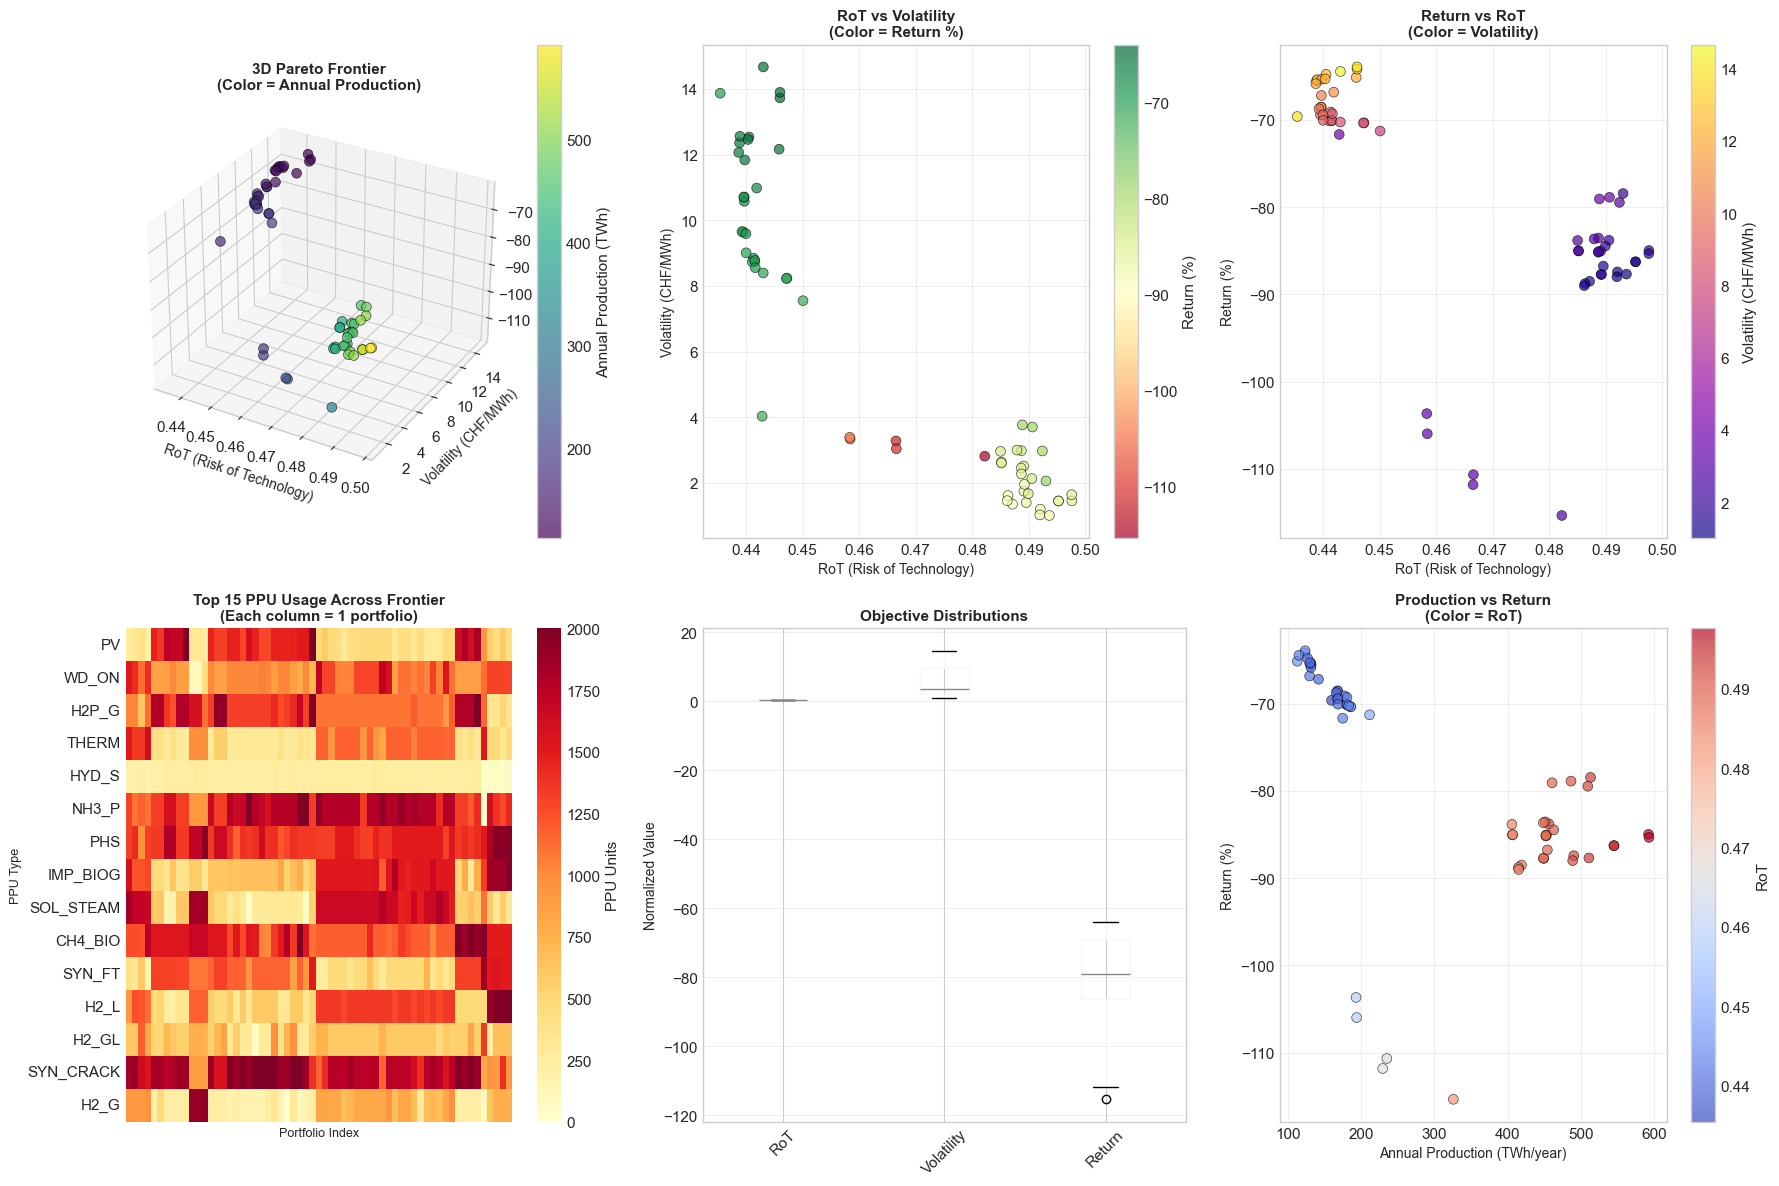


5. PORTFOLIO CLUSTERING ANALYSIS

📊 Identified 5 clusters:

   Cluster 0 (15 portfolios):
      RoT:        [0.4354, 0.4460]
      Volatility: [10.58, 14.67] CHF/MWh
      Return:     [-69.64, -63.96]%
      Top 5 PPUs: SOL_STEAM(1728), SYN_CRACK(1580), PHS(1495), NH3_P(1432), CH4_BIO(1325)

   Cluster 1 (20 portfolios):
      RoT:        [0.4852, 0.4976]
      Volatility: [1.01, 2.63] CHF/MWh
      Return:     [-89.01, -83.80]%
      Top 5 PPUs: SYN_CRACK(1873), H2P_G(1644), CH4_BIO(1548), PV(1546), NH3_P(1523)

   Cluster 2 (5 portfolios):
      RoT:        [0.4583, 0.4822]
      Volatility: [2.81, 3.39] CHF/MWh
      Return:     [-115.33, -103.66]%
      Top 5 PPUs: PHS(1841), IMP_BIOG(1784), WD_OFF(1705), H2_L(1679), CH4_BIO(1595)

   Cluster 3 (14 portfolios):
      RoT:        [0.4393, 0.4501]
      Volatility: [4.03, 9.66] CHF/MWh
      Return:     [-71.69, -68.75]%
      Top 5 PPUs: NH3_P(1783), SOL_STEAM(1615), SYN_CRACK(1608), IMP_BIOG(1497), PHS(1403)

   Cluster 4 (7 portf

In [14]:
# =============================================================================
# COMPREHENSIVE PARETO FRONTIER ANALYSIS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
from collections import Counter

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load Pareto frontier CSV
frontier_csv_path = Path("data/result_plots/multi_objective_results_frontier_3d.csv")

if not frontier_csv_path.exists():
    print(f"⚠️ Frontier CSV not found at {frontier_csv_path}")
    print("   Please run Section 3.1 first to generate the frontier.")
else:
    print(f"📊 Loading Pareto frontier from: {frontier_csv_path}")
    frontier_df = pd.read_csv(frontier_csv_path)
    
    print(f"\n✅ Loaded {len(frontier_df)} Pareto frontier portfolios")
    print(f"   Columns: {', '.join(frontier_df.columns)}")
    
    # =============================================================================
    # 1. BASIC STATISTICS
    # =============================================================================
    print("\n" + "="*70)
    print("1. BASIC STATISTICS")
    print("="*70)
    
    print(f"\n📈 Objective Space Ranges:")
    print(f"   RoT (x):        [{frontier_df['x_RoT'].min():.4f}, {frontier_df['x_RoT'].max():.4f}]")
    print(f"   Volatility (y): [{frontier_df['y_volatility'].min():.2f}, {frontier_df['y_volatility'].max():.2f}] CHF/MWh")
    print(f"   Return (z):     [{frontier_df['z_return'].min():.2f}, {frontier_df['z_return'].max():.2f}]%")
    
    print(f"\n⚡ Energy Production:")
    print(f"   Annual Production: [{frontier_df['annual_production_twh'].min():.1f}, {frontier_df['annual_production_twh'].max():.1f}] TWh/year")
    print(f"   Total Energy:      [{frontier_df['total_energy_twh'].min():.1f}, {frontier_df['total_energy_twh'].max():.1f}] TWh/year")
    
    print(f"\n✅ Constraint Compliance:")
    storage_compliant = frontier_df['storage_constraint_met'].sum()
    aviation_compliant = frontier_df['aviation_fuel_constraint_met'].sum()
    print(f"   Storage cyclic constraint: {storage_compliant}/{len(frontier_df)} ({storage_compliant/len(frontier_df)*100:.1f}%)")
    print(f"   Aviation fuel constraint:  {aviation_compliant}/{len(frontier_df)} ({aviation_compliant/len(frontier_df)*100:.1f}%)")
    
    # =============================================================================
    # 2. PARSE PORTFOLIO COMPOSITIONS
    # =============================================================================
    print("\n" + "="*70)
    print("2. PORTFOLIO COMPOSITION ANALYSIS")
    print("="*70)
    
    # Parse portfolio dictionaries
    portfolios = []
    for idx, row in frontier_df.iterrows():
        try:
            portfolio_dict = ast.literal_eval(row['portfolio_dict'])
            portfolios.append(portfolio_dict)
        except:
            print(f"⚠️ Could not parse portfolio {idx}")
            portfolios.append({})
    
    # Create DataFrame of PPU counts
    ppu_counts_df = pd.DataFrame(portfolios)
    ppu_counts_df = ppu_counts_df.fillna(0).astype(int)
    
    # Add objective columns
    ppu_counts_df['x_RoT'] = frontier_df['x_RoT'].values
    ppu_counts_df['y_volatility'] = frontier_df['y_volatility'].values
    ppu_counts_df['z_return'] = frontier_df['z_return'].values
    ppu_counts_df['annual_production_twh'] = frontier_df['annual_production_twh'].values
    
    print(f"\n📊 PPU Usage Statistics (across all frontier portfolios):")
    print(f"   Total PPU types analyzed: {len([c for c in ppu_counts_df.columns if c not in ['x_RoT', 'y_volatility', 'z_return', 'annual_production_twh']])}")
    
    # Calculate statistics for each PPU
    ppu_stats = []
    for ppu in ppu_counts_df.columns:
        if ppu in ['x_RoT', 'y_volatility', 'z_return', 'annual_production_twh']:
            continue
        
        counts = ppu_counts_df[ppu].values
        non_zero = (counts > 0).sum()
        
        ppu_stats.append({
            'PPU': ppu,
            'Mean': counts.mean(),
            'Median': np.median(counts),
            'Std': counts.std(),
            'Min': counts.min(),
            'Max': counts.max(),
            'Non-Zero Count': non_zero,
            'Usage %': non_zero / len(frontier_df) * 100,
            'Total Capacity (GW)': counts.sum() * 10 / 1000  # Convert to GW
        })
    
    ppu_stats_df = pd.DataFrame(ppu_stats).sort_values('Usage %', ascending=False)
    
    print("\n   Top 15 Most Frequently Used PPUs:")
    print(ppu_stats_df.head(15)[['PPU', 'Mean', 'Max', 'Usage %']].to_string(index=False))
    
    print("\n   PPUs Never Used (0% usage):")
    unused = ppu_stats_df[ppu_stats_df['Usage %'] == 0]
    if len(unused) > 0:
        print(f"   {', '.join(unused['PPU'].tolist())}")
    else:
        print("   None - all PPUs are used in at least one portfolio")
    
    # =============================================================================
    # 3. OBJECTIVE SPACE ANALYSIS
    # =============================================================================
    print("\n" + "="*70)
    print("3. OBJECTIVE SPACE ANALYSIS")
    print("="*70)
    
    # Correlation analysis
    corr_matrix = frontier_df[['x_RoT', 'y_volatility', 'z_return']].corr()
    
    print("\n📊 Correlation Matrix (RoT, Volatility, Return):")
    print(corr_matrix.round(3))
    
    # Extreme portfolios
    print("\n🎯 Extreme Portfolios:")
    
    min_rot_idx = frontier_df['x_RoT'].idxmin()
    max_rot_idx = frontier_df['x_RoT'].idxmax()
    min_vol_idx = frontier_df['y_volatility'].idxmin()
    max_vol_idx = frontier_df['y_volatility'].idxmax()
    max_return_idx = frontier_df['z_return'].idxmax()
    min_return_idx = frontier_df['z_return'].idxmin()
    
    print(f"\n   Minimum RoT (Lowest Risk):")
    print(f"      RoT: {frontier_df.loc[min_rot_idx, 'x_RoT']:.4f}")
    print(f"      Volatility: {frontier_df.loc[min_rot_idx, 'y_volatility']:.2f} CHF/MWh")
    print(f"      Return: {frontier_df.loc[min_rot_idx, 'z_return']:.2f}%")
    
    print(f"\n   Minimum Volatility (Most Stable):")
    print(f"      RoT: {frontier_df.loc[min_vol_idx, 'x_RoT']:.4f}")
    print(f"      Volatility: {frontier_df.loc[min_vol_idx, 'y_volatility']:.2f} CHF/MWh")
    print(f"      Return: {frontier_df.loc[min_vol_idx, 'z_return']:.2f}%")
    
    print(f"\n   Maximum Return (Best Economics):")
    print(f"      RoT: {frontier_df.loc[max_return_idx, 'x_RoT']:.4f}")
    print(f"      Volatility: {frontier_df.loc[max_return_idx, 'y_volatility']:.2f} CHF/MWh")
    print(f"      Return: {frontier_df.loc[max_return_idx, 'z_return']:.2f}%")
    
    # =============================================================================
    # 4. VISUALIZATIONS
    # =============================================================================
    print("\n" + "="*70)
    print("4. GENERATING VISUALIZATIONS")
    print("="*70)
    
    fig = plt.figure(figsize=(18, 12))
    
    # 4.1: 3D Scatter Plot
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    scatter = ax1.scatter(
        frontier_df['x_RoT'],
        frontier_df['y_volatility'],
        frontier_df['z_return'],
        c=frontier_df['annual_production_twh'],
        cmap='viridis',
        s=50,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    ax1.set_xlabel('RoT (Risk of Technology)', fontsize=10)
    ax1.set_ylabel('Volatility (CHF/MWh)', fontsize=10)
    ax1.set_zlabel('Return (%)', fontsize=10)
    ax1.set_title('3D Pareto Frontier\n(Color = Annual Production)', fontsize=11, fontweight='bold')
    plt.colorbar(scatter, ax=ax1, label='Annual Production (TWh)')
    
    # 4.2: RoT vs Volatility
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.scatter(frontier_df['x_RoT'], frontier_df['y_volatility'], 
                c=frontier_df['z_return'], cmap='RdYlGn', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax2.set_xlabel('RoT (Risk of Technology)', fontsize=10)
    ax2.set_ylabel('Volatility (CHF/MWh)', fontsize=10)
    ax2.set_title('RoT vs Volatility\n(Color = Return %)', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(ax2.collections[0], ax=ax2, label='Return (%)')
    
    # 4.3: Return vs RoT
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.scatter(frontier_df['x_RoT'], frontier_df['z_return'],
                c=frontier_df['y_volatility'], cmap='plasma', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax3.set_xlabel('RoT (Risk of Technology)', fontsize=10)
    ax3.set_ylabel('Return (%)', fontsize=10)
    ax3.set_title('Return vs RoT\n(Color = Volatility)', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(ax3.collections[0], ax=ax3, label='Volatility (CHF/MWh)')
    
    # 4.4: PPU Usage Heatmap
    ax4 = fig.add_subplot(2, 3, 4)
    top_ppus = ppu_stats_df.head(15)['PPU'].tolist()
    ppu_usage_matrix = ppu_counts_df[top_ppus].T
    sns.heatmap(ppu_usage_matrix, cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'PPU Units'}, 
                xticklabels=False, yticklabels=True)
    ax4.set_title('Top 15 PPU Usage Across Frontier\n(Each column = 1 portfolio)', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Portfolio Index', fontsize=9)
    ax4.set_ylabel('PPU Type', fontsize=9)
    
    # 4.5: Objective Distributions
    ax5 = fig.add_subplot(2, 3, 5)
    frontier_df[['x_RoT', 'y_volatility', 'z_return']].boxplot(ax=ax5, vert=True)
    ax5.set_ylabel('Normalized Value', fontsize=10)
    ax5.set_title('Objective Distributions', fontsize=11, fontweight='bold')
    ax5.set_xticklabels(['RoT', 'Volatility', 'Return'], rotation=45)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 4.6: Production vs Objectives
    ax6 = fig.add_subplot(2, 3, 6)
    scatter = ax6.scatter(frontier_df['annual_production_twh'], frontier_df['z_return'],
                         c=frontier_df['x_RoT'], cmap='coolwarm', s=50, alpha=0.7, 
                         edgecolors='black', linewidth=0.5)
    ax6.set_xlabel('Annual Production (TWh/year)', fontsize=10)
    ax6.set_ylabel('Return (%)', fontsize=10)
    ax6.set_title('Production vs Return\n(Color = RoT)', fontsize=11, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax6, label='RoT')
    
    plt.tight_layout()
    plt.savefig('data/result_plots/pareto_frontier_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✅ Saved comprehensive analysis plot to: data/result_plots/pareto_frontier_comprehensive_analysis.png")
    plt.show()
    
    # =============================================================================
    # 5. CLUSTERING ANALYSIS
    # =============================================================================
    print("\n" + "="*70)
    print("5. PORTFOLIO CLUSTERING ANALYSIS")
    print("="*70)
    
    # Simple clustering based on objective space
    try:
        from sklearn.cluster import KMeans
        
        # Normalize objectives for clustering
        objectives = frontier_df[['x_RoT', 'y_volatility', 'z_return']].values
        objectives_norm = (objectives - objectives.mean(axis=0)) / objectives.std(axis=0)
        
        # Try different numbers of clusters
        n_clusters = min(5, len(frontier_df) // 3)  # At least 3 portfolios per cluster
        if n_clusters >= 2:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(objectives_norm)
            frontier_df['cluster'] = clusters
            
            print(f"\n📊 Identified {n_clusters} clusters:")
            for c in range(n_clusters):
                cluster_mask = frontier_df['cluster'] == c
                cluster_size = cluster_mask.sum()
                print(f"\n   Cluster {c} ({cluster_size} portfolios):")
                print(f"      RoT:        [{frontier_df.loc[cluster_mask, 'x_RoT'].min():.4f}, {frontier_df.loc[cluster_mask, 'x_RoT'].max():.4f}]")
                print(f"      Volatility: [{frontier_df.loc[cluster_mask, 'y_volatility'].min():.2f}, {frontier_df.loc[cluster_mask, 'y_volatility'].max():.2f}] CHF/MWh")
                print(f"      Return:     [{frontier_df.loc[cluster_mask, 'z_return'].min():.2f}, {frontier_df.loc[cluster_mask, 'z_return'].max():.2f}]%")
                
                # Most common PPUs in this cluster
                cluster_ppus = ppu_counts_df[cluster_mask]
                cluster_ppu_means = cluster_ppus[[c for c in cluster_ppus.columns if c not in ['x_RoT', 'y_volatility', 'z_return', 'annual_production_twh']]].mean().sort_values(ascending=False)
                top_5_ppus = cluster_ppu_means.head(5)
                print(f"      Top 5 PPUs: {', '.join([f'{ppu}({int(val)})' for ppu, val in top_5_ppus.items()])}")
    except ImportError:
        print("\n⚠️ sklearn not available - skipping clustering analysis")
    
    # =============================================================================
    # 6. SUMMARY STATISTICS TABLE
    # =============================================================================
    print("\n" + "="*70)
    print("6. SUMMARY STATISTICS")
    print("="*70)
    
    summary_stats = {
        'Metric': [
            'Total Frontier Portfolios',
            'RoT Range',
            'Volatility Range (CHF/MWh)',
            'Return Range (%)',
            'Production Range (TWh/year)',
            'Storage Constraint Met (%)',
            'Aviation Constraint Met (%)',
            'Most Common PPU',
            'Average PPU Types per Portfolio',
            'Total Unique PPUs Used'
        ],
        'Value': [
            len(frontier_df),
            f"[{frontier_df['x_RoT'].min():.4f}, {frontier_df['x_RoT'].max():.4f}]",
            f"[{frontier_df['y_volatility'].min():.2f}, {frontier_df['y_volatility'].max():.2f}]",
            f"[{frontier_df['z_return'].min():.2f}, {frontier_df['z_return'].max():.2f}]",
            f"[{frontier_df['annual_production_twh'].min():.1f}, {frontier_df['annual_production_twh'].max():.1f}]",
            f"{storage_compliant/len(frontier_df)*100:.1f}%",
            f"{aviation_compliant/len(frontier_df)*100:.1f}%",
            ppu_stats_df.iloc[0]['PPU'] if len(ppu_stats_df) > 0 else "N/A",
            f"{(ppu_counts_df[[c for c in ppu_counts_df.columns if c not in ['x_RoT', 'y_volatility', 'z_return', 'annual_production_twh']]] > 0).sum(axis=1).mean():.1f}",
            f"{(ppu_counts_df[[c for c in ppu_counts_df.columns if c not in ['x_RoT', 'y_volatility', 'z_return', 'annual_production_twh']]] > 0).any(axis=0).sum()}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    print("\n" + summary_df.to_string(index=False))
    
    print("\n" + "="*70)
    print("✅ COMPREHENSIVE ANALYSIS COMPLETE")
    print("="*70)


In [ ]:
# =============================================================================
# SECTION 4: Interactive Portfolio Analysis
# =============================================================================
import time
import json
from pathlib import Path
from IPython.display import clear_output, display
from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PPU Framework
from ppu_framework import Portfolio

# Optimization & Config - import Config class for scenario switching
from optimization import Individual, evaluate_portfolio_full_year
from config import Config

# Data loader for reloading with new scenario
from data_loader import load_all_data

# Visualization
from visualization import (
    plot_full_year_production_by_source,
    plot_full_year_storage,
    plot_energy_balance_distribution
)

# =============================================================================
# DEMAND SCENARIO CONFIGURATION (2024 vs 2050)
# =============================================================================
# Select the demand scenario:
# - "2024": Base demand curve (113 TWh total, 23 TWh aviation)
# - "2050": 1.6× growth scenario (~181 TWh total, ~37 TWh aviation)

DEMAND_SCENARIO = "2050"  # ← CHANGE THIS TO "2050" FOR FUTURE SCENARIO

# Create config with selected scenario
config = Config()
config.energy_system.DEMAND_SCENARIO = DEMAND_SCENARIO

# Reload data with the selected scenario (force_reload to apply new multiplier)
_data = load_all_data(config, force_reload=True)

print(f"📊 Demand Scenario: {DEMAND_SCENARIO}")
print(f"   - Demand multiplier: {config.energy_system.DEMAND_MULTIPLIER}x")
print(f"   - Target demand: {config.energy_system.TARGET_ANNUAL_DEMAND_TWH:.1f} TWh/year")
print(f"   - Aviation fuel: {config.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR:.1f} TWh/year")


# =============================================================================
# Helper: Portfolio Compliance Check
# =============================================================================
def is_portfolio_compliant(portfolio_dict, row) -> bool:
    """Check if portfolio satisfies constraints (relaxed - no storage check)."""
    if isinstance(portfolio_dict, str):
        try:
            portfolio = json.loads(portfolio_dict)
        except:
            return False
    else:
        portfolio = portfolio_dict
    
    # 1. Aviation: THERM >= 263 + (SYN_FT or SYN_CRACK)
    MIN_THERM_FOR_AVIATION = 263
    therm_count = portfolio.get('THERM', 0)
    syn_ft_count = portfolio.get('SYN_FT', 0)
    syn_crack_count = portfolio.get('SYN_CRACK', 0)
    
    if not (therm_count >= MIN_THERM_FOR_AVIATION and (syn_ft_count > 0 or syn_crack_count > 0)):
        return False
    
    # 2. Sovereignty: >= 113 TWh
    if 'total_domestic_production_twh' in row:
        if row['total_domestic_production_twh'] < 113.0:
            return False
    
    # Storage constraint SKIPPED (CSV may have old tolerance)
    return True


# Load frontier portfolios
frontier_path = Path('data/result_plots/multi_objective_results_frontier_3d.csv')
if not frontier_path.exists():
    print("⚠️ Frontier CSV not found. Run Section 3.1 first to generate it.")
else:
    frontier_df_raw = pd.read_csv(frontier_path)
    
    # Filter for compliant portfolios only
    print("🔍 Filtering for compliant portfolios...")
    compliant_mask = frontier_df_raw.apply(
        lambda row: is_portfolio_compliant(row.get('portfolio_dict', {}), row), 
        axis=1
    )
    frontier_df = frontier_df_raw[compliant_mask].copy().reset_index(drop=True)
    
    print(f"   Total frontier portfolios: {len(frontier_df_raw)}")
    print(f"   ✅ Compliant portfolios: {len(frontier_df)}")
    print(f"   ❌ Filtered: {len(frontier_df_raw) - len(frontier_df)}")
    
    if len(frontier_df) == 0:
        print("\n⚠️ WARNING: No compliant portfolios found in frontier!")
        print("   Please re-run the optimization with the new constraints.")
    
    # Create dropdown options with portfolio summary
    portfolio_options = {}
    for idx, row in frontier_df.iterrows():
        label = f"#{int(idx)+1}: RoT={row['x_RoT']:.4f}, Vol={row['y_volatility']:.1f}, Ret={row['z_return']:.1f}%"
        portfolio_options[label] = int(idx)
    
    # Create widgets
    portfolio_dropdown = Dropdown(
        options=list(portfolio_options.keys()),
        value=list(portfolio_options.keys())[0],
        description='Portfolio:',
        style={'description_width': '80px'},
        layout=Layout(width='600px')
    )
    
    run_button = Button(
        description='🚀 Run Analysis',
        button_style='success',
        layout=Layout(width='150px', height='35px')
    )
    
    output_area = Output(layout=Layout(height='1000px', overflow='auto'))
    
    def run_portfolio_analysis(b):
        """Run full analysis for selected portfolio."""
        with output_area:
            clear_output(wait=True)
            
            # Get selected portfolio
            selected_idx = portfolio_options[portfolio_dropdown.value]
            row = frontier_df.iloc[selected_idx]
            
            print("=" * 70)
            print(f"ANALYZING PORTFOLIO #{selected_idx + 1}")
            print("=" * 70)
            print(f"  RoT:        {row['x_RoT']:.4f}")
            print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
            print(f"  Return:     {row['z_return']:.2f}%")
            
            # Parse portfolio dict
            portfolio_dict_str = row['portfolio_dict']
            if isinstance(portfolio_dict_str, str):
                portfolio_dict = json.loads(portfolio_dict_str)
            else:
                portfolio_dict = portfolio_dict_str
            
            print(f"\n📦 Portfolio composition:")
            for ppu, count in sorted(portfolio_dict.items(), key=lambda x: -x[1]):
                if count > 0:
                    print(f"    {ppu}: {count} units")
            
            # Run full year simulation
            print("\n⏳ Running full-year simulation (8,760 hours)...")
            individual = Individual(portfolio=Portfolio(ppu_counts=portfolio_dict))
            
            start_time = time.time()
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config,
                verbose=False
            )
            elapsed = time.time() - start_time
            print(f"✅ Simulation complete in {elapsed:.1f}s")
            
            # ================================================================
            # PART 1: Incidence vs Demand Analysis (Matches Section 1.2c)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 1: INCIDENCE VS DEMAND ANALYSIS (Before Storage)")
            print("=" * 70)
            
            dem = np.array(full_year_results.demand)
            ren = np.array(full_year_results.renewable_production)
            balance = ren - dem
            
            # Statistics
            total_demand_twh = np.sum(dem) / 1e6
            total_renewable_twh = np.sum(ren) / 1e6
            coverage = (total_renewable_twh / total_demand_twh) * 100
            surplus_h = np.sum(balance > 0)
            deficit_h = np.sum(balance < 0)
            total_surplus_twh = np.sum(balance[balance > 0]) / 1e6
            total_deficit_twh = np.sum(balance[balance < 0]) / 1e6
            
            print(f"\n📊 Energy Summary:")
            print(f"   Total Demand:     {total_demand_twh:.2f} TWh")
            print(f"   Total Incidence:  {total_renewable_twh:.2f} TWh")
            print(f"   Coverage:         {coverage:.1f}%")
            print(f"\n⚡ Balance:")
            print(f"   Surplus hours:    {surplus_h:,} ({surplus_h/len(balance)*100:.1f}%)")
            print(f"   Deficit hours:    {deficit_h:,} ({deficit_h/len(balance)*100:.1f}%)")
            print(f"   Total surplus:    {total_surplus_twh:.2f} TWh (storable)")
            print(f"   Total deficit:    {abs(total_deficit_twh):.2f} TWh (need storage/dispatch)")

            fig1, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
            hours = np.arange(len(dem))
            days = hours / 24

            # Plot 1: Incidence vs Demand
            ax1 = axes[0]
            ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
            ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
            ax1.set_ylabel('Power (GW)')
            ax1.set_title(f'Portfolio #{selected_idx+1}: Incidence Production vs Demand (Before Storage)')
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)

            # Plot 2: Balance (Surplus/Deficit)
            ax2 = axes[1]
            balance_gw = balance / 1e3
            ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                              label='Surplus (storable)', color='green', interpolate=True)
            ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                              label='Deficit (need storage/dispatch)', color='red', interpolate=True)
            ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax2.set_ylabel('Balance (GW)')
            ax2.set_title('Hourly Balance: Incidence - Demand')
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)

            # Plot 3: Cumulative Energy Balance
            ax3 = axes[2]
            cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
            ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                              alpha=0.3, color='green')
            ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                              alpha=0.3, color='red')
            ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            ax3.set_xlabel('Day of Year')
            ax3.set_ylabel('Cumulative Balance (TWh)')
            ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
            ax3.legend(loc='upper right')
            ax3.grid(True, alpha=0.3)

            # Add month labels
            month_starts = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
            month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax3.set_xticks(month_starts)
            ax3.set_xticklabels(month_labels)
            
            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 70)
            print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
            print("- Deepest negative point = minimum seasonal storage needed")
            print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
            print("=" * 70)

            # ================================================================
            # PART 2: Dispatch Results (Matches Section 1.3)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 2: DISPATCH RESULTS (After Storage/Dispatch)")
            print("=" * 70)
            
            plot_full_year_production_by_source(
                full_year_results,
                title=f"Portfolio #{selected_idx+1}: Hourly Production Stack vs Demand"
            )
            plt.show()
            
            plot_full_year_storage(
                full_year_results,
                title=f"Portfolio #{selected_idx+1}: Storage State of Charge - Full Year"
            )
            plt.show()
            
            plot_energy_balance_distribution(
                demand=full_year_results.demand,
                production=full_year_results.renewable_production,
                renewable_production=full_year_results.renewable_production,
                title=f"Portfolio #{selected_idx+1}: Renewable vs Demand (Gap = Storage + Dispatchable)"
            )
            plt.show()

            # ================================================================
            # PART 3: PPU DECOMPOSITION BY CATEGORY
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 3: PPU DECOMPOSITION BY CATEGORY")
            print("=" * 70)
            
            # Define PPU categories (from config)
            INCIDENCE_PPUS = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            FLEX_PPUS = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'SOL_SALT', 'SOL_STEAM', 
                        'PALM_ICE', 'IMP_BIOG', 'THERM_CH4', 'NH3_P']
            STORAGE_PPUS = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                          'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
            
            # Get production and consumption data
            ppu_production = full_year_results.ppu_production
            ppu_consumption = full_year_results.ppu_consumption  # NEW: energy consumed by storage INPUT PPUs
            
            # --- 3.1 Numerical Decomposition (Unit Counts) ---
            print("\n📊 NUMERICAL DECOMPOSITION (Unit Counts):")
            
            def analyze_category(cat_name, ppu_list, portfolio_dict, ppu_production, ppu_consumption=None, use_consumption=False):
                """Analyze PPU category - use consumption for storage INPUT PPUs."""
                cat_counts = {p: portfolio_dict.get(p, 0) for p in ppu_list if portfolio_dict.get(p, 0) > 0}
                
                # For storage INPUT PPUs, use consumption (energy absorbed), not production
                data_source = ppu_consumption if (use_consumption and ppu_consumption) else ppu_production
                
                cat_energy = {}
                for p in ppu_list:
                    if p in data_source:
                        energy_mwh = np.sum(data_source.get(p, [0]))
                        if energy_mwh > 0:
                            cat_energy[p] = energy_mwh / 1e6  # Convert to TWh
                
                total_units = sum(cat_counts.values())
                total_energy = sum(cat_energy.values())
                return cat_counts, cat_energy, total_units, total_energy
            
            inc_counts, inc_energy, inc_total_units, inc_total_twh = analyze_category(
                "INCIDENCE", INCIDENCE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            flex_counts, flex_energy, flex_total_units, flex_total_twh = analyze_category(
                "FLEX", FLEX_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=False)
            # STORAGE INPUT PPUs: use ppu_consumption to show energy handled (charged into storage)
            stor_counts, stor_energy, stor_total_units, stor_total_twh = analyze_category(
                "STORAGE", STORAGE_PPUS, portfolio_dict, ppu_production, ppu_consumption, use_consumption=True)
            
            grand_total_units = inc_total_units + flex_total_units + stor_total_units
            grand_total_twh = inc_total_twh + flex_total_twh + stor_total_twh
            
            print(f"\n   {'Category':<12} | {'Units':>8} | {'% of Total':>10} | {'Energy (TWh)':>12} | {'% of Energy':>11}")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'INCIDENCE':<12} | {inc_total_units:>8} | {inc_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {inc_total_twh:>12.2f} | {inc_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'FLEX':<12} | {flex_total_units:>8} | {flex_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {flex_total_twh:>12.2f} | {flex_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'STORAGE':<12} | {stor_total_units:>8} | {stor_total_units/grand_total_units*100 if grand_total_units else 0:>9.1f}% | {stor_total_twh:>12.2f} | {stor_total_twh/grand_total_twh*100 if grand_total_twh else 0:>10.1f}%")
            print(f"   {'-'*12}-+-{'-'*8}-+-{'-'*10}-+-{'-'*12}-+-{'-'*11}")
            print(f"   {'TOTAL':<12} | {grand_total_units:>8} | {'100.0':>9}% | {grand_total_twh:>12.2f} | {'100.0':>10}%")
            
            print("\n   ℹ️  Note: STORAGE energy shows electricity consumed for charging (not produced)")
            
            # --- 3.2 Detailed Breakdown by Category ---
            def print_category_detail(cat_name, counts, energy, total_units, total_twh, color, is_storage=False):
                energy_label = "absorbed" if is_storage else "produced"
                print(f"\n   🔹 {cat_name} PPUs ({energy_label}):")
                if not counts:
                    print(f"      (none in portfolio)")
                    return
                for ppu in sorted(counts.keys(), key=lambda x: -counts[x]):
                    unit_pct = counts[ppu] / total_units * 100 if total_units else 0
                    energy_twh = energy.get(ppu, 0)
                    energy_pct = energy_twh / total_twh * 100 if total_twh else 0
                    print(f"      {ppu:<15}: {counts[ppu]:>5} units ({unit_pct:>5.1f}%) | {energy_twh:>6.2f} TWh ({energy_pct:>5.1f}%)")
            
            print_category_detail("INCIDENCE", inc_counts, inc_energy, inc_total_units, inc_total_twh, 'green', is_storage=False)
            print_category_detail("FLEX (Dispatchable)", flex_counts, flex_energy, flex_total_units, flex_total_twh, 'orange', is_storage=False)
            print_category_detail("STORAGE (Input)", stor_counts, stor_energy, stor_total_units, stor_total_twh, 'blue', is_storage=True)
            
            # --- 3.3 Visualization: Category Decomposition ---
            fig_cat, axes_cat = plt.subplots(1, 3, figsize=(16, 5))
            
            # Pie chart: Units by Category
            ax1 = axes_cat[0]
            cat_units = [inc_total_units, flex_total_units, stor_total_units]
            cat_labels = ['INCIDENCE', 'FLEX', 'STORAGE']
            cat_colors = ['#2ecc71', '#e67e22', '#3498db']
            if sum(cat_units) > 0:
                wedges, texts, autotexts = ax1.pie(cat_units, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax1.set_title('Unit Distribution by Category')
            
            # Pie chart: Energy by Category
            ax2 = axes_cat[1]
            cat_twh = [inc_total_twh, flex_total_twh, stor_total_twh]
            if sum(cat_twh) > 0:
                wedges, texts, autotexts = ax2.pie(cat_twh, labels=cat_labels, autopct='%1.1f%%',
                                                   colors=cat_colors, explode=[0.02]*3)
                ax2.set_title('Energy Production by Category (TWh)')
            
            # Bar chart: Top 10 PPUs by Energy
            ax3 = axes_cat[2]
            all_energy = {**inc_energy, **flex_energy, **stor_energy}
            sorted_energy = sorted(all_energy.items(), key=lambda x: -x[1])[:10]
            if sorted_energy:
                ppus = [x[0] for x in sorted_energy]
                twhs = [x[1] for x in sorted_energy]
                colors_bar = []
                for p in ppus:
                    if p in INCIDENCE_PPUS: colors_bar.append('#2ecc71')
                    elif p in FLEX_PPUS: colors_bar.append('#e67e22')
                    else: colors_bar.append('#3498db')
                ax3.barh(range(len(ppus)), twhs, color=colors_bar)
                ax3.set_yticks(range(len(ppus)))
                ax3.set_yticklabels(ppus)
                ax3.invert_yaxis()
                ax3.set_xlabel('Energy (TWh)')
                ax3.set_title('Top 10 PPUs by Energy Production')
                ax3.grid(True, alpha=0.3, axis='x')
            
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 4: HOURLY ENERGY MIX (Daily Average Profile)
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 4: HOURLY ENERGY MIX (Daily Average Profile)")
            print("=" * 70)
            
            # Build hourly production by PPU (shape: n_hours x n_ppus)
            n_hours = len(full_year_results.demand)
            n_days = n_hours // 24
            demand_array = np.array(full_year_results.demand)  # Needed for demand overlay
            
            # Get all PPUs with production
            active_ppus = [p for p in ppu_production.keys() 
                          if isinstance(ppu_production[p], np.ndarray) and len(ppu_production[p]) == n_hours]
            
            # Calculate average production by hour of day for each PPU
            hourly_avg_by_ppu = {}
            for ppu in active_ppus:
                prod = np.array(ppu_production[ppu])[:n_days*24]
                # Reshape to (n_days, 24) and take mean over days
                prod_reshaped = prod.reshape(n_days, 24)
                hourly_avg_by_ppu[ppu] = np.mean(prod_reshaped, axis=0)  # shape: (24,)
            
            # Sort PPUs by total daily production
            ppu_daily_totals = {p: np.sum(hourly_avg_by_ppu[p]) for p in hourly_avg_by_ppu}
            sorted_ppus = sorted(ppu_daily_totals.keys(), key=lambda x: -ppu_daily_totals[x])
            
            # Print hourly mix table for key hours
            print("\n📊 AVERAGE HOURLY ENERGY MIX (MW by PPU):")
            key_hours = [0, 6, 8, 12, 14, 18, 20, 22]
            
            # Header
            header = f"   {'PPU':<15}"
            for h in key_hours:
                header += f" | {h:02d}:00"
            print(header)
            print(f"   {'-'*15}" + "-+-" + "-+-".join(["-"*6]*len(key_hours)))
            
            # Print top 10 PPUs
            for ppu in sorted_ppus[:12]:
                row = f"   {ppu:<15}"
                for h in key_hours:
                    val = hourly_avg_by_ppu[ppu][h]
                    if val >= 1000:
                        row += f" | {val/1e3:5.1f}k"
                    else:
                        row += f" | {val:6.0f}"
                print(row)
            
            # --- 4.1 Stacked Area Chart: Hourly Mix ---
            fig_hourly, ax_hourly = plt.subplots(figsize=(14, 8))
            
            hours_x = np.arange(24)
            # Get top PPUs for visualization (to avoid too many)
            top_ppus = sorted_ppus[:8]
            other_ppus = sorted_ppus[8:]
            
            # Stack the production
            bottom = np.zeros(24)
            colors_hourly = plt.cm.tab20(np.linspace(0, 1, len(top_ppus) + 1))
            
            for i, ppu in enumerate(top_ppus):
                values = hourly_avg_by_ppu[ppu] / 1e3  # GW
                ax_hourly.fill_between(hours_x, bottom, bottom + values, 
                                       label=ppu, alpha=0.8, color=colors_hourly[i])
                ax_hourly.plot(hours_x, bottom + values, color='white', linewidth=0.5)
                bottom += values
            
            # Add "Other" if exists
            if other_ppus:
                other_sum = np.sum([hourly_avg_by_ppu[p] for p in other_ppus], axis=0) / 1e3
                ax_hourly.fill_between(hours_x, bottom, bottom + other_sum, 
                                       label='Other', alpha=0.6, color='gray')
                bottom += other_sum
            
            # Add demand line
            demand_hourly_avg = np.array([np.mean(demand_array[h::24]) for h in range(24)]) / 1e3
            ax_hourly.plot(hours_x, demand_hourly_avg, 'r--', linewidth=2.5, label='Avg Demand')
            
            ax_hourly.set_xlabel('Hour of Day', fontsize=12)
            ax_hourly.set_ylabel('Power (GW)', fontsize=12)
            ax_hourly.set_title(f'Portfolio #{selected_idx+1}: Average Daily Energy Mix by Source', fontsize=14)
            ax_hourly.set_xticks(range(0, 24, 2))
            ax_hourly.set_xlim(0, 23)
            ax_hourly.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
            ax_hourly.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # ================================================================
            # PART 5: SOLAR/WIND PRODUCTION CONCENTRATION 3D ANALYSIS
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 5: SOLAR/WIND PRODUCTION CONCENTRATION (3D Analysis)")
            print("=" * 70)
            print("Analyzing how production is distributed across locations per timestep...")
            print("X = Total production at timestep")
            print("Y = % of locations needed to reach 90% of that timestep's production")
            print("Z = Number of occurrences (frequency)")
            
            from mpl_toolkits.mplot3d import Axes3D
            
            # Get location-level incidence data
            solar_incidence = _data.get_solar_incidence(copy=False)  # Shape: (n_hours, n_locations)
            wind_incidence = _data.get_wind_incidence(copy=False)    # Shape: (n_hours, n_locations)
            
            solar_units = portfolio_dict.get('PV', 0)
            wind_on_units = portfolio_dict.get('WD_ON', 0)
            wind_off_units = portfolio_dict.get('WD_OFF', 0)
            
            mw_per_unit = config.ppu.MW_PER_UNIT  # 10 MW per unit
            
            def compute_location_concentration(incidence_data, n_units, n_hours_data):
                """
                For each timestep, calculate:
                - Total production across all locations
                - % of locations needed to reach 90% of that timestep's production
                
                Returns: (productions, pct_locations_for_90, valid_mask)
                """
                n_hours_inc, n_locations = incidence_data.shape
                n_hours_use = min(n_hours_data, n_hours_inc)
                
                # Use top n_units locations (sorted by ranking in data loader)
                n_locs_used = min(n_units, n_locations)
                if n_locs_used == 0:
                    return None, None, None
                
                # Production per location per hour (MW) - incidence * capacity
                # Each unit = mw_per_unit MW, distributed across locations
                prod_per_loc = incidence_data[:n_hours_use, :n_locs_used] * mw_per_unit  # Shape: (n_hours, n_locs)
                
                productions = []
                pct_for_90 = []
                
                for t in range(n_hours_use):
                    loc_prod = prod_per_loc[t, :]  # Production at each location this hour
                    total_prod = np.sum(loc_prod)
                    
                    if total_prod < 1.0:  # Skip hours with negligible production
                        continue
                    
                    # Sort locations by production (descending)
                    sorted_prod = np.sort(loc_prod)[::-1]
                    cumsum = np.cumsum(sorted_prod)
                    
                    # Find % of locations needed to reach 90%
                    threshold_90 = 0.9 * total_prod
                    n_locs_for_90 = np.searchsorted(cumsum, threshold_90) + 1
                    pct_locs = (n_locs_for_90 / n_locs_used) * 100
                    
                    productions.append(total_prod)
                    pct_for_90.append(pct_locs)
                
                return np.array(productions), np.array(pct_for_90), True
            
            # --- 5.1 Compute concentration for Solar ---
            print("\n🔆 SOLAR PV CONCENTRATION:")
            if solar_units > 0:
                solar_prod_arr, solar_pct_90, solar_valid = compute_location_concentration(
                    solar_incidence, solar_units, n_hours)
                
                if solar_valid and len(solar_prod_arr) > 0:
                    print(f"   Units: {solar_units} | Locations used: {min(solar_units, solar_incidence.shape[1])}")
                    print(f"   Hours with production: {len(solar_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(solar_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(solar_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(solar_pct_90):.1f}% (most distributed)")
            else:
                print("   No Solar PV in portfolio")
                solar_prod_arr, solar_pct_90 = None, None
            
            # --- 5.2 Compute concentration for Wind ---
            print("\n💨 WIND CONCENTRATION:")
            wind_total_units = wind_on_units + wind_off_units
            if wind_total_units > 0:
                wind_prod_arr, wind_pct_90, wind_valid = compute_location_concentration(
                    wind_incidence, wind_total_units, n_hours)
                
                if wind_valid and len(wind_prod_arr) > 0:
                    print(f"   Units: {wind_total_units} | Locations used: {min(wind_total_units, wind_incidence.shape[1])}")
                    print(f"   Hours with production: {len(wind_prod_arr):,}")
                    print(f"   Avg % locations for 90%: {np.mean(wind_pct_90):.1f}%")
                    print(f"   Min % locations for 90%: {np.min(wind_pct_90):.1f}% (most concentrated)")
                    print(f"   Max % locations for 90%: {np.max(wind_pct_90):.1f}% (most distributed)")
            else:
                print("   No Wind in portfolio")
                wind_prod_arr, wind_pct_90 = None, None
            
            # --- 5.3 Create 3D Histogram Plots ---
            fig_3d = plt.figure(figsize=(16, 6))
            
            def plot_3d_concentration(ax, prod_arr, pct_90_arr, title, color):
                """Create 3D histogram: X=production, Y=%locations for 90%, Z=frequency"""
                if prod_arr is None or len(prod_arr) == 0:
                    ax.text2D(0.5, 0.5, f'No data for {title}', ha='center', va='center', 
                             transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                # Create 2D histogram bins
                n_bins_x = 25  # Production bins
                n_bins_y = 20  # % locations bins
                
                # Bin edges
                x_edges = np.linspace(0, np.percentile(prod_arr, 99), n_bins_x + 1)
                y_edges = np.linspace(0, 100, n_bins_y + 1)
                
                # Compute 2D histogram
                hist, x_edges, y_edges = np.histogram2d(
                    prod_arr / 1e3,  # Convert to GW
                    pct_90_arr,
                    bins=[x_edges / 1e3, y_edges]
                )
                
                # Create meshgrid for 3D bars
                x_centers = (x_edges[:-1] + x_edges[1:]) / 2
                y_centers = (y_edges[:-1] + y_edges[1:]) / 2
                x_width = x_edges[1] - x_edges[0]
                y_width = y_edges[1] - y_edges[0]
                
                # Plot as 3D bars
                xpos, ypos = np.meshgrid(x_centers, y_centers, indexing='ij')
                xpos = xpos.flatten()
                ypos = ypos.flatten()
                zpos = np.zeros_like(xpos)
                
                dx = x_width * 0.8 * np.ones_like(xpos)
                dy = y_width * 0.8 * np.ones_like(ypos)
                dz = hist.flatten()
                
                # Only plot non-zero bars
                mask = dz > 0
                if np.sum(mask) > 0:
                    # Color by frequency
                    colors_3d = plt.cm.viridis(dz[mask] / np.max(dz[mask]))
                    ax.bar3d(xpos[mask], ypos[mask], zpos[mask], 
                            dx[mask], dy[mask], dz[mask],
                            color=colors_3d, alpha=0.8, edgecolor='white', linewidth=0.2)
                
                ax.set_xlabel('Production (GW)', fontsize=10)
                ax.set_ylabel('% Locations for 90%', fontsize=10)
                ax.set_zlabel('Hours (freq)', fontsize=10)
                ax.set_title(title, fontsize=12, fontweight='bold')
                ax.view_init(elev=25, azim=45)
            
            # Solar 3D plot
            ax1 = fig_3d.add_subplot(121, projection='3d')
            plot_3d_concentration(ax1, solar_prod_arr, solar_pct_90, 'Solar PV: Production Concentration', 'gold')
            
            # Wind 3D plot
            ax2 = fig_3d.add_subplot(122, projection='3d')
            plot_3d_concentration(ax2, wind_prod_arr, wind_pct_90, 'Wind: Production Concentration', 'skyblue')
            
            plt.tight_layout()
            plt.show()
            
            # --- 5.4 2D Heatmap Alternative (easier to read) ---
            fig_heat, axes_heat = plt.subplots(1, 2, figsize=(14, 5))
            
            def plot_2d_heatmap(ax, prod_arr, pct_90_arr, title):
                # Check for None or empty arrays
                if prod_arr is None or pct_90_arr is None:
                    ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                if len(prod_arr) == 0 or len(pct_90_arr) == 0:
                    ax.text(0.5, 0.5, 'No production hours', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                # Check for valid data range
                max_prod = np.percentile(prod_arr, 99)
                if max_prod <= 0 or not np.isfinite(max_prod):
                    ax.text(0.5, 0.5, 'No significant production', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(title)
                    return
                
                n_bins = 30
                x_edges = np.linspace(0, max_prod, n_bins + 1)
                y_edges = np.linspace(0, 100, n_bins + 1)
                
                hist, _, _ = np.histogram2d(prod_arr / 1e3, pct_90_arr, bins=[x_edges / 1e3, y_edges])
                
                im = ax.imshow(hist.T, origin='lower', aspect='auto',
                              extent=[x_edges[0]/1e3, x_edges[-1]/1e3, 0, 100],
                              cmap='YlOrRd')
                plt.colorbar(im, ax=ax, label='Hours (frequency)')
                ax.set_xlabel('Total Production (GW)')
                ax.set_ylabel('% Locations for 90% of Production')
                ax.set_title(title)
                
                # Add average line
                avg_pct = np.mean(pct_90_arr)
                if np.isfinite(avg_pct):
                    ax.axhline(avg_pct, color='cyan', linestyle='--', linewidth=2,
                              label=f'Avg: {avg_pct:.0f}%')
                    ax.legend(loc='upper right')
            
            plot_2d_heatmap(axes_heat[0], solar_prod_arr, solar_pct_90, 
                           'Solar PV: Concentration Heatmap')
            plot_2d_heatmap(axes_heat[1], wind_prod_arr, wind_pct_90, 
                           'Wind: Concentration Heatmap')
            
            plt.tight_layout()
            plt.show()
            
            print("\n📊 INTERPRETATION:")
            print("   - Lower % = Production concentrated in fewer locations (some sites dominate)")
            print("   - Higher % = Production distributed evenly across locations")
            print("   - High production + Low % = Peak hours rely on best sites")
            print("   - Low production + High % = Low-resource hours spread thin")
            
            # ================================================================
            # PART 6: Annual Performance Summary
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 6: ANNUAL PERFORMANCE SUMMARY")
            print("=" * 70)
            
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_prod_twh = np.sum(full_year_results.total_production) / 1e6
            total_ren_twh = np.sum(full_year_results.renewable_production) / 1e6
            
            print(f"\n📊 Energy Balance:")
            print(f"   Total Demand:       {total_demand_twh:.2f} TWh")
            print(f"   Total Production:   {total_prod_twh:.2f} TWh")
            print(f"   Renewable Only:     {total_ren_twh:.2f} TWh")
            print(f"   Spot Bought:        {full_year_results.total_spot_bought_mwh/1e6:.2f} TWh")
            print(f"   Spot Sold:          {full_year_results.total_spot_sold_mwh/1e6:.2f} TWh")
            
            print(f"\n💰 Spot Market Financials:")
            print(f"   Net Spot Cost:      {full_year_results.total_spot_cost_chf/1e9:.2f} B CHF")
            
            deficit_hours_count = np.sum(full_year_results.deficit > 0)
            surplus_hours_count = np.sum(full_year_results.surplus > 0)
            print(f"\n⚡ Grid Balance (after dispatch):")
            print(f"   Hours in Deficit:   {deficit_hours_count} h ({deficit_hours_count/8760*100:.1f}%)")
            print(f"   Hours in Surplus:   {surplus_hours_count} h ({surplus_hours_count/8760*100:.1f}%)")
            
            # Aviation fuel - use config value for target
            av_consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
            av_target = config.energy_system.AVIATION_FUEL_DEMAND_TWH_YEAR
            print(f"\n✈️  Aviation Fuel:")
            print(f"   Consumed:           {av_consumed:.2f} TWh")
            print(f"   Target:             {av_target:.2f} TWh")
            print(f"   Constraint Met:     {'✅ Yes' if av_consumed >= av_target * 0.99 else '❌ No'}")
            
            # ================================================================
            # PART 7: END-TO-END EFFECTIVENESS ANALYSIS
            # ================================================================
            print("\n" + "=" * 70)
            print("PART 7: END-TO-END EFFECTIVENESS ANALYSIS")
            print("=" * 70)
            print("Tracking energy flows from production through storage and flexible PPUs to final demand...")
            
            # Calculate key energy flows
            renewable_production_twh = np.sum(full_year_results.renewable_production) / 1e6
            dispatchable_production_twh = np.sum(full_year_results.dispatchable_production) / 1e6
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_production_twh = np.sum(full_year_results.total_production) / 1e6
            spot_bought_twh = full_year_results.total_spot_bought_mwh / 1e6
            spot_sold_twh = full_year_results.total_spot_sold_mwh / 1e6
            
            # Validate demand value
            expected_demand = config.energy_system.TARGET_ANNUAL_DEMAND_TWH
            if abs(total_demand_twh - expected_demand) > expected_demand * 0.1:
                print(f"\n⚠️  WARNING: Total demand ({total_demand_twh:.2f} TWh) differs from expected ({expected_demand:.2f} TWh)")
            
            # =====================================================================
            # STEP 1: Estimate raw incidence energy (before conversion losses)
            # =====================================================================
            # renewable_production is already after PPU conversion chains
            # To estimate raw incidence, we need average conversion efficiency
            from ppu_framework import load_all_ppu_data
            _, _, ppu_definitions = load_all_ppu_data(config)
            
            # Calculate weighted average efficiency for renewable PPUs in portfolio
            renewable_ppus = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            total_units = 0
            efficiency_sum = 0.0
            
            for ppu_name in renewable_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_definitions:
                    ppu_def = ppu_definitions[ppu_name]
                    efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.84
                    total_units += count
                    efficiency_sum += efficiency * count
            
            avg_conversion_efficiency = efficiency_sum / total_units if total_units > 0 else 0.84
            
            # Estimate raw incidence energy (before conversion)
            raw_incidence_twh = renewable_production_twh / avg_conversion_efficiency if avg_conversion_efficiency > 0 else renewable_production_twh
            production_losses_twh = raw_incidence_twh - renewable_production_twh
            
            # =====================================================================
            # STEP 2: Calculate storage energy flows
            # =====================================================================
            storage_charged = 0.0
            for ppu in storage_input_ppus:
                if ppu in ppu_consumption:
                    prod_data = ppu_consumption[ppu]
                    if isinstance(prod_data, np.ndarray):
                        storage_charged += np.sum(prod_data) / 1e6  # TWh
            
            # Calculate discharge from SOC changes
            storage_discharged = 0.0
            storage_energy_input_mwh = {}  # Track energy input to each storage
            
            if hasattr(full_year_results, 'storage_soc') and full_year_results.storage_soc:
                storage_soc_dict = full_year_results.storage_soc
                if isinstance(storage_soc_dict, dict) and len(storage_soc_dict) > 0:
                    from dispatch_engine import initialize_storage_state
                    try:
                        storages = initialize_storage_state(portfolio_dict, config)
                        for storage_name, soc_array in storage_soc_dict.items():
                            if storage_name not in storages:
                                continue
                            storage = storages[storage_name]
                            capacity_mwh = storage.capacity_mwh
                            efficiency_discharge = storage.efficiency_discharge
                            
                            if isinstance(soc_array, np.ndarray) and len(soc_array) > 1:
                                soc_mwh = soc_array * capacity_mwh
                                soc_changes = np.diff(soc_mwh)
                                discharging_changes = -soc_changes[soc_changes < 0]
                                if len(discharging_changes) > 0:
                                    # Energy input to storage (before discharge efficiency)
                                    energy_input_mwh = np.sum(discharging_changes)
                                    storage_energy_input_mwh[storage_name] = energy_input_mwh / 1e6  # TWh
                                    # Energy output from storage (after discharge efficiency)
                                    total_discharged_mwh = energy_input_mwh * efficiency_discharge
                                    storage_discharged += total_discharged_mwh / 1e6  # TWh
                    except Exception as e:
                        pass
            
            if storage_discharged == 0 and storage_charged > 0:
                storage_discharged = storage_charged * 0.75  # Estimate 75% round-trip
            
            storage_losses_twh = max(0, storage_charged - storage_discharged)
            
            # =====================================================================
            # STEP 3: Calculate flexible production losses
            # =====================================================================
            # Flexible PPUs consume stored energy and convert it to electricity
            # Track production from flexible PPUs and estimate conversion losses
            flex_ppus = config.ppu.FLEX_PPUS
            flexible_production_twh = 0.0
            flexible_input_energy_twh = 0.0
            
            for ppu_name in flex_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_production:
                    prod_data = ppu_production[ppu_name]
                    if isinstance(prod_data, np.ndarray):
                        ppu_prod = np.sum(prod_data) / 1e6  # TWh
                        flexible_production_twh += ppu_prod
                        
                        # Estimate input energy based on PPU efficiency
                        if ppu_name in ppu_definitions:
                            ppu_def = ppu_definitions[ppu_name]
                            efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.80
                            if efficiency > 0:
                                flexible_input_energy_twh += ppu_prod / efficiency
            
            # Flexible production losses = input energy - output energy
            flexible_losses_twh = max(0, flexible_input_energy_twh - flexible_production_twh)
            
            # =====================================================================
            # STEP 4: Track energy flows to demand
            # =====================================================================
            # Energy delivered = demand met (assuming demand is fully met)
            energy_delivered_twh = total_demand_twh
            
            # Renewable energy going directly to demand (not through storage)
            renewable_direct_to_demand_twh = max(0, renewable_production_twh - storage_charged)
            
            # Energy from storage discharge going to demand
            # Some goes through flexible PPUs, some directly
            # We'll estimate: if flexible production > 0, assume storage discharge feeds flexible PPUs
            storage_to_flexible_twh = min(storage_discharged, flexible_input_energy_twh) if flexible_input_energy_twh > 0 else 0
            storage_direct_to_demand_twh = max(0, storage_discharged - storage_to_flexible_twh)
            
            # Curtailment/lost energy
            renewable_curtailed_twh = max(0, renewable_production_twh - storage_charged - renewable_direct_to_demand_twh)
            
            # =====================================================================
            # STEP 5: Calculate total losses and create pie chart
            # =====================================================================
            total_losses_twh = production_losses_twh + storage_losses_twh + flexible_losses_twh + renewable_curtailed_twh
            
            # Verify energy balance: raw_incidence = delivered + losses
            total_accounted_twh = energy_delivered_twh + total_losses_twh
            balance_error_twh = abs(raw_incidence_twh - total_accounted_twh)
            
            if balance_error_twh > 0.1:  # More than 0.1 TWh difference
                print(f"\n⚠️  Energy balance check: {balance_error_twh:.2f} TWh difference")
                print(f"   Raw incidence: {raw_incidence_twh:.2f} TWh")
                print(f"   Accounted: {total_accounted_twh:.2f} TWh")
                # Adjust losses to balance
                total_losses_twh += balance_error_twh
                production_losses_twh += balance_error_twh * 0.5  # Distribute error
                renewable_curtailed_twh += balance_error_twh * 0.5
            
            # =====================================================================
            # STEP 6: Print detailed energy flow summary
            # =====================================================================
            print(f"\n📊 ENERGY FLOW SUMMARY (From Raw Incidence to Final Demand):")
            print(f"   {'Metric':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
            print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
            print(f"   {'Raw Incidence Energy':<45} | {raw_incidence_twh:>15.2f} | {'100.0':>18}%")
            print(f"   {'  → After Production Conversion':<45} | {renewable_production_twh:>15.2f} | {renewable_production_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'    → Direct to Demand':<45} | {renewable_direct_to_demand_twh:>15.2f} | {renewable_direct_to_demand_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'    → Storage Charged':<45} | {storage_charged:>15.2f} | {storage_charged/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'      → Storage Discharged':<45} | {storage_discharged:>15.2f} | {storage_discharged/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'        → To Flexible PPUs':<45} | {storage_to_flexible_twh:>15.2f} | {storage_to_flexible_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'        → Direct to Demand':<45} | {storage_direct_to_demand_twh:>15.2f} | {storage_direct_to_demand_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Flexible Production (from storage)':<45} | {flexible_production_twh:>15.2f} | {flexible_production_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Spot Market Purchases':<45} | {spot_bought_twh:>15.2f} | {'N/A':>18}")
            print(f"   {'FINAL ENERGY DELIVERED (Demand)':<45} | {energy_delivered_twh:>15.2f} | {energy_delivered_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            
            print(f"\n📉 ENERGY LOSSES BREAKDOWN:")
            print(f"   {'Loss Category':<45} | {'Value (TWh)':>15} | {'% of Raw Incidence':>18}")
            print(f"   {'-'*45}-+-{'-'*15}-+-{'-'*18}")
            print(f"   {'Production Losses (conversion)':<45} | {production_losses_twh:>15.2f} | {production_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Storage Losses (round-trip)':<45} | {storage_losses_twh:>15.2f} | {storage_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Flexible Production Losses':<45} | {flexible_losses_twh:>15.2f} | {flexible_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'Curtailment/Other Losses':<45} | {renewable_curtailed_twh:>15.2f} | {renewable_curtailed_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            print(f"   {'TOTAL LOSSES':<45} | {total_losses_twh:>15.2f} | {total_losses_twh/raw_incidence_twh*100 if raw_incidence_twh > 0 else 0:>17.1f}%")
            
            # Calculate effectiveness metrics
            overall_efficiency = (energy_delivered_twh / raw_incidence_twh * 100) if raw_incidence_twh > 0 else 0
            storage_rt_efficiency = (storage_discharged / storage_charged * 100) if storage_charged > 0 else 0
            renewable_utilization = min(100.0, (renewable_production_twh / total_demand_twh * 100)) if total_demand_twh > 0 else 0
            storage_utilization = (storage_charged / renewable_production_twh * 100) if renewable_production_twh > 0 else 0
            
            print(f"\n⚡ EFFECTIVENESS METRICS:")
            print(f"   {'Metric':<50} | {'Value':>10}")
            print(f"   {'-'*50}-+-{'-'*10}")
            print(f"   {'Overall System Efficiency (Raw → Delivered)':<50} | {overall_efficiency:>9.2f}%")
            print(f"   {'Renewable Utilization (% of demand)':<50} | {renewable_utilization:>9.2f}%")
            print(f"   {'Storage Utilization (% of renewable)':<50} | {storage_utilization:>9.2f}%")
            print(f"   {'Storage Round-Trip Efficiency':<50} | {storage_rt_efficiency:>9.2f}%")
            print(f"   {'Flexible Production Efficiency':<50} | {(flexible_production_twh/flexible_input_energy_twh*100) if flexible_input_energy_twh > 0 else 0:>9.2f}%")
            
            # =====================================================================
            # STEP 7: Create comprehensive pie chart
            # =====================================================================
            fig_eff, axes_eff = plt.subplots(1, 2, figsize=(16, 8))
            
            # Pie chart: Energy breakdown (delivered vs losses)
            ax1 = axes_eff[0]
            pie_data = {
                'Energy Delivered': energy_delivered_twh,
                'Production Losses': production_losses_twh,
                'Storage Losses': storage_losses_twh,
                'Flexible Production Losses': flexible_losses_twh,
                'Curtailment/Other': renewable_curtailed_twh
            }
            
            # Filter out zero or negative values
            pie_data = {k: max(0, v) for k, v in pie_data.items() if v > 0.01}
            
            if pie_data:
                colors_pie = ['#2ecc71', '#e67e22', '#3498db', '#9b59b6', '#95a5a6']
                wedges, texts, autotexts = ax1.pie(
                    list(pie_data.values()),
                    labels=list(pie_data.keys()),
                    autopct=lambda pct: f'{pct:.1f}%\n({pct*raw_incidence_twh/100:.1f} TWh)',
                    colors=colors_pie[:len(pie_data)],
                    startangle=90,
                    textprops={'fontsize': 10, 'fontweight': 'bold'}
                )
                ax1.set_title('Energy Breakdown: Delivered vs Losses\n(From Raw Incidence)', 
                             fontsize=14, fontweight='bold')
            
            # Bar chart: Loss breakdown by category
            ax2 = axes_eff[1]
            loss_categories = ['Production\nLosses', 'Storage\nLosses', 'Flexible\nLosses', 'Curtailment']
            loss_values = [production_losses_twh, storage_losses_twh, flexible_losses_twh, renewable_curtailed_twh]
            loss_colors = ['#e67e22', '#3498db', '#9b59b6', '#95a5a6']
            
            bars = ax2.bar(loss_categories, loss_values, color=loss_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
            ax2.set_ylabel('Energy Losses (TWh)', fontsize=12, fontweight='bold')
            ax2.set_title('Energy Losses Breakdown by Category', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar, val in zip(bars, loss_values):
                if val > 0.01:
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height,
                            f'{val:.1f} TWh\n({val/raw_incidence_twh*100:.1f}%)',
                            ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n💡 INTERPRETATION:")
            print(f"   • Overall System Efficiency: {overall_efficiency:.1f}% of raw incidence energy reaches final demand")
            print(f"   • Production Losses: {production_losses_twh:.1f} TWh ({production_losses_twh/raw_incidence_twh*100:.1f}%) lost during conversion from incidence")
            if storage_charged > 0:
                print(f"   • Storage Losses: {storage_losses_twh:.1f} TWh ({storage_losses_twh/raw_incidence_twh*100:.1f}%) lost in round-trip storage")
                print(f"   • Storage Round-Trip Efficiency: {storage_rt_efficiency:.1f}%")
            if flexible_production_twh > 0:
                print(f"   • Flexible Production Losses: {flexible_losses_twh:.1f} TWh ({flexible_losses_twh/raw_incidence_twh*100:.1f}%) lost in flexible PPU conversion")
            if renewable_curtailed_twh > 0:
                print(f"   • Curtailment: {renewable_curtailed_twh:.1f} TWh ({renewable_curtailed_twh/raw_incidence_twh*100:.1f}%) of renewable energy curtailed")
            
            print("\n" + "=" * 70)
            print("✅ End-to-End Effectiveness Analysis Complete")
            print("=" * 70)
    
    # Connect button
    run_button.on_click(run_portfolio_analysis)
    
    # Display widgets
    from IPython.display import display
    display(VBox([
        Label("Select a portfolio from the Pareto frontier:"),
        HBox([portfolio_dropdown, run_button]),
        output_area
    ]))

Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2024, multiplier: 1.0x)
📊 Demand Scenario: 2024
   - Demand multiplier: 1.0x
   - Target demand: 113.0 TWh/year
   - Aviation fuel: 23.0 TWh/year
🔍 Filtering for compliant portfolios...
   Total frontier portfolios: 61
   ✅ Compliant portfolios: 61
   ❌ Filtered: 0


---

## Overall Frontier Analysis: Portfolio Possibilities

The comprehensive portfolio optimization results are stored in CSV files that capture the entire **solution space** explored during the multi-objective genetic algorithm optimization. These files enable deep analysis of the **trade-offs and possibilities** available in the energy portfolio design.

### Available Data Sources

The following CSV files contain the complete portfolio evaluation results:

1. **`multi_objective_results.csv`** - Contains **all evaluated portfolios** (typically 1,000+ portfolios)
   - Represents the full exploration space of the genetic algorithm
   - Includes both optimal and sub-optimal solutions
   - Useful for understanding the **feasibility region** and constraint boundaries

2. **`multi_objective_results_frontier_3d.csv`** - Contains **Pareto-optimal portfolios** (typically 20-100 portfolios)
   - Represents the **efficient frontier** where no objective can be improved without sacrificing another
   - These are the portfolios that define the **trade-off surface** between:
     - **Risk of Technology (RoT)** - Technology diversification risk
     - **Price Volatility** - Market price risk (CHF/MWh)
     - **Return** - Financial performance (%)
   - Critical for decision-making: any portfolio not on this frontier is dominated

3. **`multi_objective_results_frontier.csv`** - 2D Pareto frontier (RoT vs Volatility)
   - Simplified view focusing on the two risk metrics
   - Useful for understanding the **risk-risk trade-off** independent of return

4. **`extended_frontier_research.csv`** - Interpolated portfolios along the frontier
   - Systematic exploration between frontier points
   - Helps identify **smooth transitions** and **gaps** in the solution space

### Key Insights Retrievable from the Data

#### 1. **Objective Space Characterization**
- **Ranges**: Minimum and maximum achievable values for each objective
- **Correlations**: How objectives relate (e.g., does lower RoT always mean lower return?)
- **Trade-off gradients**: Rate of change between objectives (steep vs. gradual trade-offs)

#### 2. **Portfolio Composition Patterns**
- **PPU usage frequency**: Which technologies appear most often in optimal portfolios?
- **Technology co-occurrence**: Which PPUs tend to be used together?
- **Technology substitution**: Can portfolios achieve similar objectives with different PPU mixes?

#### 3. **Constraint Boundary Analysis**
- **Storage constraint compliance**: How many portfolios satisfy cyclic storage requirements?
- **Aviation fuel compliance**: Distribution of portfolios meeting the 23 TWh/year requirement
- **Electrical sovereignty**: Portfolios meeting the ≥113 TWh/year domestic production target
- **Feasibility gaps**: Regions in objective space where no feasible portfolios exist

#### 4. **Energy Production Characteristics**
- **Production capacity ranges**: Minimum and maximum annual production achievable
- **Renewable vs. dispatchable mix**: Distribution of renewable energy shares
- **Storage utilization**: How storage technologies are deployed across portfolios

#### 5. **Risk-Return Profiles**
- **Efficient frontier shape**: Concave/convex curvature reveals trade-off structure
- **Corner portfolios**: Extreme solutions (best return, lowest risk, etc.)
- **Diversification benefits**: How portfolio diversity affects risk metrics

#### 6. **Solution Space Coverage**
- **Density**: Are there regions with many similar portfolios or sparse areas?
- **Gaps**: Unexplored regions that might contain better solutions
- **Clusters**: Groups of portfolios with similar characteristics

### Analytical Capabilities

From these CSV files, one can:

- **Identify optimal portfolios** for specific risk/return preferences
- **Understand technology roles** in achieving different objectives
- **Quantify trade-offs** between competing objectives
- **Assess constraint impacts** on portfolio feasibility
- **Explore alternative solutions** with similar performance
- **Validate optimization results** by examining the full solution space
- **Support decision-making** with quantitative trade-off analysis

The frontier data provides a **complete map** of what is achievable in the energy portfolio design space, enabling informed decisions based on policy priorities, risk tolerance, and financial constraints.


OVERALL FRONTIER ANALYSIS: Portfolio Possibilities
✅ Loaded all_portfolios: 1626 portfolios
✅ Loaded frontier_3d: 61 portfolios
✅ Loaded frontier_2d: 19 portfolios
✅ Loaded extended_research: 88 portfolios

📊 Total datasets loaded: 4

1. OBJECTIVE SPACE CHARACTERIZATION

📈 All Portfolios (1626 portfolios):
   RoT (x):        [0.4354, 0.5115] (mean: 0.4779, std: 0.0194)
   Volatility (y): [0.83, 141.69] CHF/MWh (mean: 9.03, std: 12.22)
   Return (z):     [-291.81, -1.47]% (mean: -92.49, std: 28.16)

🔗 Objective Correlations:
   RoT vs Volatility:  -0.166
   RoT vs Return:      -0.305
   Volatility vs Return: -0.417

🎯 Pareto Frontier (61 portfolios):
   RoT (x):        [0.4354, 0.4976]
   Volatility (y): [1.01, 14.67] CHF/MWh
   Return (z):     [-115.33, -63.96]%

📉 Trade-off Gradients (along frontier):
   d(Volatility)/d(RoT):  820.43 CHF/MWh per RoT unit
   d(Return)/d(RoT):      971.68% per RoT unit

2. PORTFOLIO COMPOSITION PATTERNS

📊 PPU Usage Statistics (across 61 frontier portfo

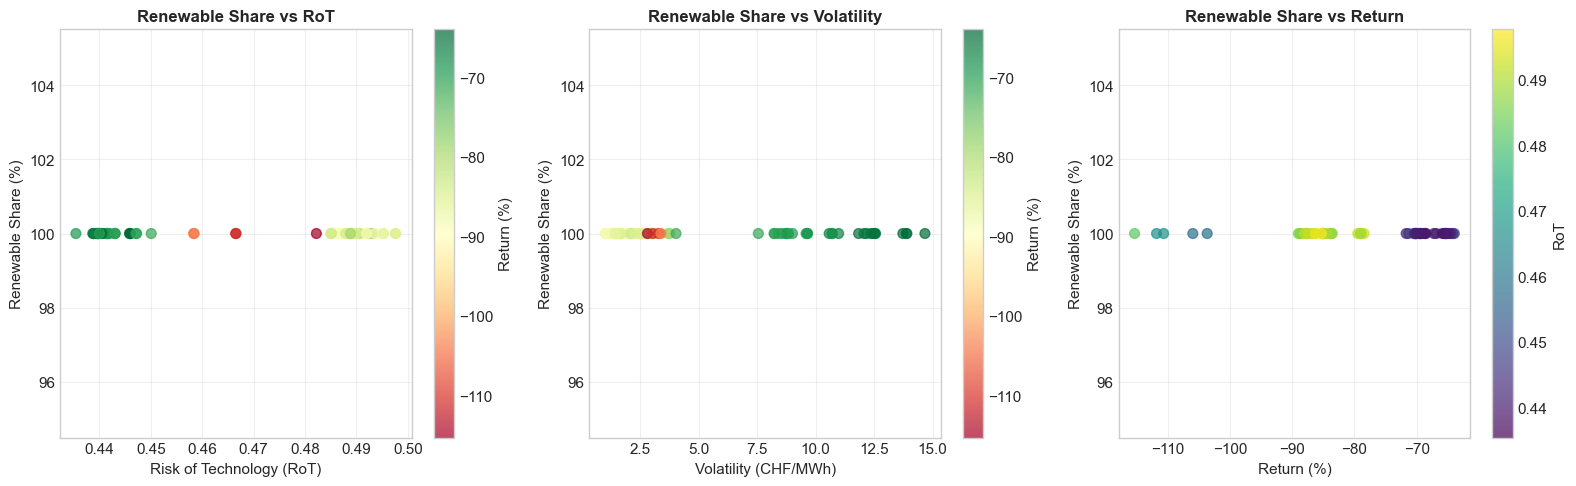


💡 RENEWABLE SHARE INSIGHTS:
   • Average renewable share (all portfolios): 99.8%
   • Average renewable share (frontier): 100.0%
   • Frontier portfolios have higher renewable share by 0.2 percentage points

   ⚠️  IMPORTANT: This is NOT efficiency!
   • Renewable share = % of production from renewable sources
   • True efficiency (incidence → final demand) requires full simulation
   • See individual portfolio analysis (PART 7) for accurate efficiency metrics
   • Typical efficiency values: 30-50% (accounting for conversion + storage losses)

✅ Overall Frontier Analysis Complete


In [26]:
# =============================================================================
# OVERALL FRONTIER ANALYSIS: Portfolio Possibilities from CSV Data
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
from collections import Counter
from scipy import stats
from scipy.spatial.distance import pdist, squareform

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("="*80)
print("OVERALL FRONTIER ANALYSIS: Portfolio Possibilities")
print("="*80)

# =============================================================================
# 1. LOAD ALL CSV FILES
# =============================================================================

csv_files = {
    'all_portfolios': Path("data/result_plots/multi_objective_results.csv"),
    'frontier_3d': Path("data/result_plots/multi_objective_results_frontier_3d.csv"),
    'frontier_2d': Path("data/result_plots/multi_objective_results_frontier.csv"),
    'extended_research': Path("data/result_plots/extended_frontier_research.csv")
}

data = {}
for name, path in csv_files.items():
    if path.exists():
        data[name] = pd.read_csv(path)
        print(f"✅ Loaded {name}: {len(data[name])} portfolios")
    else:
        print(f"⚠️  {name} not found at {path}")

if len(data) == 0:
    print("\n❌ No CSV files found. Please run optimization sections first.")
else:
    print(f"\n📊 Total datasets loaded: {len(data)}")
    
    # =============================================================================
    # 2. OBJECTIVE SPACE CHARACTERIZATION
    # =============================================================================
    
    print("\n" + "="*80)
    print("1. OBJECTIVE SPACE CHARACTERIZATION")
    print("="*80)
    
    if 'all_portfolios' in data:
        df_all = data['all_portfolios']
        print(f"\n📈 All Portfolios ({len(df_all)} portfolios):")
        print(f"   RoT (x):        [{df_all['x_RoT'].min():.4f}, {df_all['x_RoT'].max():.4f}] "
              f"(mean: {df_all['x_RoT'].mean():.4f}, std: {df_all['x_RoT'].std():.4f})")
        print(f"   Volatility (y): [{df_all['y_volatility'].min():.2f}, {df_all['y_volatility'].max():.2f}] CHF/MWh "
              f"(mean: {df_all['y_volatility'].mean():.2f}, std: {df_all['y_volatility'].std():.2f})")
        print(f"   Return (z):     [{df_all['z_return'].min():.2f}, {df_all['z_return'].max():.2f}]% "
              f"(mean: {df_all['z_return'].mean():.2f}, std: {df_all['z_return'].std():.2f})")
        
        # Correlations
        print(f"\n🔗 Objective Correlations:")
        corr_matrix = df_all[['x_RoT', 'y_volatility', 'z_return']].corr()
        print(f"   RoT vs Volatility:  {corr_matrix.loc['x_RoT', 'y_volatility']:.3f}")
        print(f"   RoT vs Return:      {corr_matrix.loc['x_RoT', 'z_return']:.3f}")
        print(f"   Volatility vs Return: {corr_matrix.loc['y_volatility', 'z_return']:.3f}")
    
    if 'frontier_3d' in data:
        df_frontier = data['frontier_3d']
        print(f"\n🎯 Pareto Frontier ({len(df_frontier)} portfolios):")
        print(f"   RoT (x):        [{df_frontier['x_RoT'].min():.4f}, {df_frontier['x_RoT'].max():.4f}]")
        print(f"   Volatility (y): [{df_frontier['y_volatility'].min():.2f}, {df_frontier['y_volatility'].max():.2f}] CHF/MWh")
        print(f"   Return (z):     [{df_frontier['z_return'].min():.2f}, {df_frontier['z_return'].max():.2f}]%")
        
        # Trade-off analysis
        print(f"\n📉 Trade-off Gradients (along frontier):")
        if len(df_frontier) > 1:
            # Sort by RoT
            df_sorted = df_frontier.sort_values('x_RoT')
            rot_diff = np.diff(df_sorted['x_RoT'].values)
            vol_diff = np.diff(df_sorted['y_volatility'].values)
            ret_diff = np.diff(df_sorted['z_return'].values)
            
            # Avoid division by zero
            valid_mask = rot_diff != 0
            if valid_mask.sum() > 0:
                dvol_drot = np.mean(vol_diff[valid_mask] / rot_diff[valid_mask])
                dret_drot = np.mean(ret_diff[valid_mask] / rot_diff[valid_mask])
                print(f"   d(Volatility)/d(RoT):  {dvol_drot:.2f} CHF/MWh per RoT unit")
                print(f"   d(Return)/d(RoT):      {dret_drot:.2f}% per RoT unit")
    
    # =============================================================================
    # 3. PORTFOLIO COMPOSITION PATTERNS
    # =============================================================================
    
    print("\n" + "="*80)
    print("2. PORTFOLIO COMPOSITION PATTERNS")
    print("="*80)
    
    def parse_portfolio_dict(portfolio_str):
        """Parse portfolio dictionary from string."""
        if isinstance(portfolio_str, dict):
            return portfolio_str
        try:
            return ast.literal_eval(portfolio_str)
        except:
            try:
                return json.loads(portfolio_str)
            except:
                return {}
    
    if 'frontier_3d' in data:
        df_frontier = data['frontier_3d']
        
        # Parse all portfolios
        portfolios = []
        for idx, row in df_frontier.iterrows():
            portfolio_dict = parse_portfolio_dict(row.get('portfolio_dict', {}))
            portfolios.append(portfolio_dict)
        
        # Create DataFrame of PPU counts
        ppu_counts_df = pd.DataFrame(portfolios).fillna(0).astype(int)
        
        # Get all PPU names (exclude non-PPU columns if any)
        ppu_columns = [col for col in ppu_counts_df.columns 
                      if col not in ['x_RoT', 'y_volatility', 'z_return', 
                                    'total_energy_twh', 'annual_production_twh',
                                    'storage_constraint_met', 'total_domestic_production_twh',
                                    'aviation_fuel_constraint_met']]
        
        print(f"\n📊 PPU Usage Statistics (across {len(df_frontier)} frontier portfolios):")
        print(f"   Total PPU types: {len(ppu_columns)}")
        
        # Calculate statistics for each PPU
        ppu_stats = []
        for ppu in ppu_columns:
            counts = ppu_counts_df[ppu].values
            non_zero = (counts > 0).sum()
            
            ppu_stats.append({
                'PPU': ppu,
                'Mean': counts.mean(),
                'Median': np.median(counts),
                'Std': counts.std(),
                'Min': counts.min(),
                'Max': counts.max(),
                'Non-Zero Count': non_zero,
                'Usage %': non_zero / len(df_frontier) * 100,
            })
        
        ppu_stats_df = pd.DataFrame(ppu_stats).sort_values('Usage %', ascending=False)
        
        print(f"\n🔝 Top 10 Most Frequently Used PPUs:")
        print(ppu_stats_df.head(10)[['PPU', 'Usage %', 'Mean', 'Max']].to_string(index=False))
        
        # Technology co-occurrence analysis
        print(f"\n🔗 Technology Co-occurrence Analysis:")
        # Find PPUs that often appear together
        cooccurrence = {}
        for ppu1 in ppu_columns[:10]:  # Limit to top 10 for readability
            for ppu2 in ppu_columns[:10]:
                if ppu1 != ppu2:
                    both_present = ((ppu_counts_df[ppu1] > 0) & (ppu_counts_df[ppu2] > 0)).sum()
                    if both_present > 0:
                        key = tuple(sorted([ppu1, ppu2]))
                        if key not in cooccurrence:
                            cooccurrence[key] = both_present
        
        # Sort and show top co-occurrences
        top_cooccur = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:5]
        for (ppu1, ppu2), count in top_cooccur:
            print(f"   {ppu1} + {ppu2}: {count}/{len(df_frontier)} portfolios ({count/len(df_frontier)*100:.1f}%)")
    
    # =============================================================================
    # 4. CONSTRAINT BOUNDARY ANALYSIS
    # =============================================================================
    
    print("\n" + "="*80)
    print("3. CONSTRAINT BOUNDARY ANALYSIS")
    print("="*80)
    
    if 'all_portfolios' in data:
        df_all = data['all_portfolios']
        
        print(f"\n✅ Constraint Compliance (All {len(df_all)} Portfolios):")
        
        if 'storage_constraint_met' in df_all.columns:
            storage_compliant = df_all['storage_constraint_met'].sum()
            print(f"   Storage cyclic constraint: {storage_compliant}/{len(df_all)} "
                  f"({storage_compliant/len(df_all)*100:.1f}%)")
        
        if 'aviation_fuel_constraint_met' in df_all.columns:
            aviation_compliant = df_all['aviation_fuel_constraint_met'].sum()
            print(f"   Aviation fuel constraint:  {aviation_compliant}/{len(df_all)} "
                  f"({aviation_compliant/len(df_all)*100:.1f}%)")
        
        if 'total_domestic_production_twh' in df_all.columns:
            sovereignty_compliant = (df_all['total_domestic_production_twh'] >= 113.0).sum()
            print(f"   Electrical sovereignty (≥113 TWh): {sovereignty_compliant}/{len(df_all)} "
                  f"({sovereignty_compliant/len(df_all)*100:.1f}%)")
            
            # Fully compliant (all three constraints)
            fully_compliant = True
            if 'storage_constraint_met' in df_all.columns:
                fully_compliant = fully_compliant & df_all['storage_constraint_met']
            if 'aviation_fuel_constraint_met' in df_all.columns:
                fully_compliant = fully_compliant & df_all['aviation_fuel_constraint_met']
            fully_compliant = fully_compliant & (df_all['total_domestic_production_twh'] >= 113.0)
            
            print(f"\n   ✅ Fully compliant (all constraints): {fully_compliant.sum()}/{len(df_all)} "
                  f"({fully_compliant.sum()/len(df_all)*100:.1f}%)")
    
    if 'frontier_3d' in data:
        df_frontier = data['frontier_3d']
        print(f"\n🎯 Constraint Compliance (Frontier {len(df_frontier)} Portfolios):")
        
        if 'storage_constraint_met' in df_frontier.columns:
            storage_compliant = df_frontier['storage_constraint_met'].sum()
            print(f"   Storage cyclic constraint: {storage_compliant}/{len(df_frontier)} "
                  f"({storage_compliant/len(df_frontier)*100:.1f}%)")
        
        if 'aviation_fuel_constraint_met' in df_frontier.columns:
            aviation_compliant = df_frontier['aviation_fuel_constraint_met'].sum()
            print(f"   Aviation fuel constraint:  {aviation_compliant}/{len(df_frontier)} "
                  f"({aviation_compliant/len(df_frontier)*100:.1f}%)")
        
        if 'total_domestic_production_twh' in df_frontier.columns:
            sovereignty_compliant = (df_frontier['total_domestic_production_twh'] >= 113.0).sum()
            print(f"   Electrical sovereignty (≥113 TWh): {sovereignty_compliant}/{len(df_frontier)} "
                  f"({sovereignty_compliant/len(df_frontier)*100:.1f}%)")
    
    # =============================================================================
    # 5. ENERGY PRODUCTION CHARACTERISTICS
    # =============================================================================
    
    print("\n" + "="*80)
    print("4. ENERGY PRODUCTION CHARACTERISTICS")
    print("="*80)
    
    if 'all_portfolios' in data:
        df_all = data['all_portfolios']
        
        if 'annual_production_twh' in df_all.columns:
            print(f"\n⚡ Annual Production (All Portfolios):")
            print(f"   Range: [{df_all['annual_production_twh'].min():.1f}, "
                  f"{df_all['annual_production_twh'].max():.1f}] TWh/year")
            print(f"   Mean: {df_all['annual_production_twh'].mean():.1f} TWh/year")
            print(f"   Median: {df_all['annual_production_twh'].median():.1f} TWh/year")
            
            # Production vs objectives
            if len(df_all) > 10:
                print(f"\n📊 Production vs Objectives Correlations:")
                prod_rot_corr = df_all['annual_production_twh'].corr(df_all['x_RoT'])
                prod_vol_corr = df_all['annual_production_twh'].corr(df_all['y_volatility'])
                prod_ret_corr = df_all['annual_production_twh'].corr(df_all['z_return'])
                print(f"   Production vs RoT:       {prod_rot_corr:.3f}")
                print(f"   Production vs Volatility: {prod_vol_corr:.3f}")
                print(f"   Production vs Return:     {prod_ret_corr:.3f}")
    
    if 'frontier_3d' in data:
        df_frontier = data['frontier_3d']
        
        if 'annual_production_twh' in df_frontier.columns:
            print(f"\n🎯 Annual Production (Frontier Portfolios):")
            print(f"   Range: [{df_frontier['annual_production_twh'].min():.1f}, "
                  f"{df_frontier['annual_production_twh'].max():.1f}] TWh/year")
            print(f"   Mean: {df_frontier['annual_production_twh'].mean():.1f} TWh/year")
    
    # =============================================================================
    # 6. RISK-RETURN PROFILES
    # =============================================================================
    
    print("\n" + "="*80)
    print("5. RISK-RETURN PROFILES")
    print("="*80)
    
    if 'frontier_3d' in data:
        df_frontier = data['frontier_3d']
        
        # Corner portfolios
        print(f"\n🔍 Corner Portfolios (Extreme Solutions):")
        
        best_return_idx = df_frontier['z_return'].idxmax()
        lowest_rot_idx = df_frontier['x_RoT'].idxmin()
        lowest_vol_idx = df_frontier['y_volatility'].idxmin()
        
        print(f"\n   🏆 Best Return:")
        print(f"      RoT: {df_frontier.loc[best_return_idx, 'x_RoT']:.4f}, "
              f"Vol: {df_frontier.loc[best_return_idx, 'y_volatility']:.2f} CHF/MWh, "
              f"Ret: {df_frontier.loc[best_return_idx, 'z_return']:.2f}%")
        
        print(f"\n   🛡️  Lowest RoT:")
        print(f"      RoT: {df_frontier.loc[lowest_rot_idx, 'x_RoT']:.4f}, "
              f"Vol: {df_frontier.loc[lowest_rot_idx, 'y_volatility']:.2f} CHF/MWh, "
              f"Ret: {df_frontier.loc[lowest_rot_idx, 'z_return']:.2f}%")
        
        print(f"\n   📉 Lowest Volatility:")
        print(f"      RoT: {df_frontier.loc[lowest_vol_idx, 'x_RoT']:.4f}, "
              f"Vol: {df_frontier.loc[lowest_vol_idx, 'y_volatility']:.2f} CHF/MWh, "
              f"Ret: {df_frontier.loc[lowest_vol_idx, 'z_return']:.2f}%")
        
        # Efficient frontier shape analysis
        print(f"\n📈 Efficient Frontier Shape Analysis:")
        if len(df_frontier) > 3:
            # Calculate convexity/concavity indicators
            df_sorted_rot = df_frontier.sort_values('x_RoT')
            
            # Second derivative approximation (curvature)
            rot_values = df_sorted_rot['x_RoT'].values
            vol_values = df_sorted_rot['y_volatility'].values
            ret_values = df_sorted_rot['z_return'].values
            
            if len(rot_values) > 2:
                # Volatility vs RoT curvature
                vol_curvature = np.mean(np.diff(vol_values, n=2))
                # Return vs RoT curvature  
                ret_curvature = np.mean(np.diff(ret_values, n=2))
                
                print(f"   Volatility curvature (d²Vol/dRoT²): {vol_curvature:.4f}")
                print(f"   Return curvature (d²Ret/dRoT²): {ret_curvature:.4f}")
                
                if vol_curvature > 0:
                    print(f"   → Volatility trade-off is CONVEX (increasing cost)")
                else:
                    print(f"   → Volatility trade-off is CONCAVE (decreasing cost)")
    
    # =============================================================================
    # 7. SOLUTION SPACE COVERAGE
    # =============================================================================
    
    print("\n" + "="*80)
    print("6. SOLUTION SPACE COVERAGE")
    print("="*80)
    
    if 'all_portfolios' in data and 'frontier_3d' in data:
        df_all = data['all_portfolios']
        df_frontier = data['frontier_3d']
        
        print(f"\n📊 Solution Space Coverage:")
        print(f"   Total portfolios evaluated: {len(df_all)}")
        print(f"   Pareto-optimal portfolios: {len(df_frontier)}")
        print(f"   Frontier ratio: {len(df_frontier)/len(df_all)*100:.2f}%")
        
        # Density analysis
        if len(df_all) > 10:
            # Calculate pairwise distances in objective space
            objectives_all = df_all[['x_RoT', 'y_volatility', 'z_return']].values
            
            # Normalize for distance calculation
            objectives_normalized = (objectives_all - objectives_all.min(axis=0)) / (
                objectives_all.max(axis=0) - objectives_all.min(axis=0) + 1e-10
            )
            
            # Sample for efficiency (if too many points)
            if len(objectives_normalized) > 500:
                sample_idx = np.random.choice(len(objectives_normalized), 500, replace=False)
                objectives_sample = objectives_normalized[sample_idx]
            else:
                objectives_sample = objectives_normalized
            
            # Calculate average nearest neighbor distance
            if len(objectives_sample) > 1:
                distances = pdist(objectives_sample)
                avg_distance = np.mean(distances)
                print(f"\n   Average inter-portfolio distance (normalized): {avg_distance:.4f}")
                
                # Identify sparse regions
                if len(df_all) > 100:
                    # Check if frontier covers the extremes
                    rot_range_all = df_all['x_RoT'].max() - df_all['x_RoT'].min()
                    rot_range_frontier = df_frontier['x_RoT'].max() - df_frontier['x_RoT'].min()
                    coverage_rot = rot_range_frontier / rot_range_all * 100
                    
                    vol_range_all = df_all['y_volatility'].max() - df_all['y_volatility'].min()
                    vol_range_frontier = df_frontier['y_volatility'].max() - df_frontier['y_volatility'].min()
                    coverage_vol = vol_range_frontier / vol_range_all * 100
                    
                    print(f"\n   Frontier Coverage:")
                    print(f"      RoT range coverage: {coverage_rot:.1f}%")
                    print(f"      Volatility range coverage: {coverage_vol:.1f}%")
    
    # =============================================================================
    # 8. SUMMARY STATISTICS TABLE
    # =============================================================================
    
    print("\n" + "="*80)
    print("SUMMARY: Key Statistics")
    print("="*80)
    
    summary_data = []
    
    if 'all_portfolios' in data:
        df_all = data['all_portfolios']
        summary_data.append({
            'Dataset': 'All Portfolios',
            'Count': len(df_all),
            'RoT Range': f"[{df_all['x_RoT'].min():.4f}, {df_all['x_RoT'].max():.4f}]",
            'Vol Range': f"[{df_all['y_volatility'].min():.2f}, {df_all['y_volatility'].max():.2f}]",
            'Ret Range': f"[{df_all['z_return'].min():.2f}, {df_all['z_return'].max():.2f}]%"
        })
    
    if 'frontier_3d' in data:
        df_frontier = data['frontier_3d']
        summary_data.append({
            'Dataset': 'Frontier 3D',
            'Count': len(df_frontier),
            'RoT Range': f"[{df_frontier['x_RoT'].min():.4f}, {df_frontier['x_RoT'].max():.4f}]",
            'Vol Range': f"[{df_frontier['y_volatility'].min():.2f}, {df_frontier['y_volatility'].max():.2f}]",
            'Ret Range': f"[{df_frontier['z_return'].min():.2f}, {df_frontier['z_return'].max():.2f}]%"
        })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print("\n" + summary_df.to_string(index=False))
    
    # =============================================================================
    # 9. END-TO-END EFFECTIVENESS ANALYSIS (ACROSS ALL PORTFOLIOS)
    # =============================================================================
    
    print("\n" + "="*80)
    print("7. END-TO-END EFFECTIVENESS ANALYSIS")
    print("="*80)
    print("Analyzing overall portfolio effectiveness across the solution space...")
    
    if 'all_portfolios' in data:
        df_all = data['all_portfolios']
        
        # Calculate effectiveness metrics for all portfolios
        # Note: These are approximate based on CSV data (not full simulation)
        # WARNING: We cannot calculate true efficiency from CSV data alone.
        # True efficiency requires full simulation data (available in individual portfolio analysis).
        
        if 'annual_production_twh' in df_all.columns and 'total_energy_twh' in df_all.columns:
            # Calculate renewable utilization: renewable energy / total production
            # This shows what % of production comes from renewable sources
            # Note: total_energy_twh = renewable energy, annual_production_twh = total production
            df_all['renewable_share'] = (df_all['total_energy_twh'] / 
                                        df_all['annual_production_twh'] * 100)
            df_all['renewable_share'] = df_all['renewable_share'].replace([np.inf, -np.inf], np.nan)
            df_all['renewable_share'] = df_all['renewable_share'].clip(0, 100)
            
            # Note: We cannot calculate true efficiency (incidence → final demand) from CSV data
            # because we don't have storage losses, conversion losses, etc. in the CSV
            # True efficiency is calculated in the individual portfolio analysis (PART 7)
            
            print(f"\n📊 Renewable Share Statistics (All {len(df_all)} Portfolios):")
            print(f"   ⚠️  NOTE: This is NOT efficiency - it's the % of production from renewable sources.")
            print(f"   True efficiency (incidence → final demand) requires full simulation data.")
            print(f"   See individual portfolio analysis (PART 7) for accurate efficiency metrics.\n")
            
            valid_share = df_all['renewable_share'].dropna()
            if len(valid_share) > 0:
                print(f"   Mean Renewable Share:     {valid_share.mean():.2f}%")
                print(f"   Median Renewable Share:   {valid_share.median():.2f}%")
                print(f"   Std Deviation:           {valid_share.std():.2f}%")
                print(f"   Min Renewable Share:      {valid_share.min():.2f}%")
                print(f"   Max Renewable Share:      {valid_share.max():.2f}%")
                print(f"   25th Percentile:         {valid_share.quantile(0.25):.2f}%")
                print(f"   75th Percentile:         {valid_share.quantile(0.75):.2f}%")
                
                # Renewable share distribution
                high_renewable = (valid_share >= 80).sum()
                moderate_renewable = ((valid_share >= 60) & (valid_share < 80)).sum()
                low_renewable = (valid_share < 60).sum()
                
                print(f"\n   Renewable Share Distribution:")
                print(f"      High (≥80%):      {high_renewable} portfolios ({high_renewable/len(valid_share)*100:.1f}%)")
                print(f"      Moderate (60-80%): {moderate_renewable} portfolios ({moderate_renewable/len(valid_share)*100:.1f}%)")
                print(f"      Low (<60%):        {low_renewable} portfolios ({low_renewable/len(valid_share)*100:.1f}%)")
                
                # Correlation with objectives
                print(f"\n🔗 Renewable Share vs Objectives Correlations:")
                share_rot_corr = df_all['renewable_share'].corr(df_all['x_RoT'])
                share_vol_corr = df_all['renewable_share'].corr(df_all['y_volatility'])
                share_ret_corr = df_all['renewable_share'].corr(df_all['z_return'])
                print(f"   Renewable Share vs RoT:       {share_rot_corr:.3f}")
                print(f"   Renewable Share vs Volatility: {share_vol_corr:.3f}")
                print(f"   Renewable Share vs Return:     {share_ret_corr:.3f}")
    
    if 'frontier_3d' in data:
        df_frontier = data['frontier_3d']
        
        if 'annual_production_twh' in df_frontier.columns and 'total_energy_twh' in df_frontier.columns:
            # Calculate renewable share for frontier portfolios
            df_frontier['renewable_share'] = (df_frontier['total_energy_twh'] / 
                                              df_frontier['annual_production_twh'] * 100)
            df_frontier['renewable_share'] = df_frontier['renewable_share'].replace([np.inf, -np.inf], np.nan)
            df_frontier['renewable_share'] = df_frontier['renewable_share'].clip(0, 100)
            
            print(f"\n🎯 Renewable Share Statistics (Frontier {len(df_frontier)} Portfolios):")
            valid_share_frontier = df_frontier['renewable_share'].dropna()
            if len(valid_share_frontier) > 0:
                print(f"   Mean Renewable Share:     {valid_share_frontier.mean():.2f}%")
                print(f"   Median Renewable Share:   {valid_share_frontier.median():.2f}%")
                print(f"   Std Deviation:           {valid_share_frontier.std():.2f}%")
                print(f"   Min Renewable Share:      {valid_share_frontier.min():.2f}%")
                print(f"   Max Renewable Share:      {valid_share_frontier.max():.2f}%")
                
                # Best and worst renewable share portfolios
                best_share_idx = df_frontier['renewable_share'].idxmax()
                worst_share_idx = df_frontier['renewable_share'].idxmin()
                
                print(f"\n   🏆 Highest Renewable Share Portfolio:")
                print(f"      Renewable Share: {df_frontier.loc[best_share_idx, 'renewable_share']:.2f}%")
                print(f"      RoT: {df_frontier.loc[best_share_idx, 'x_RoT']:.4f}, "
                      f"Vol: {df_frontier.loc[best_share_idx, 'y_volatility']:.2f}, "
                      f"Ret: {df_frontier.loc[best_share_idx, 'z_return']:.2f}%")
                
                print(f"\n   ⚠️  Lowest Renewable Share Portfolio:")
                print(f"      Renewable Share: {df_frontier.loc[worst_share_idx, 'renewable_share']:.2f}%")
                print(f"      RoT: {df_frontier.loc[worst_share_idx, 'x_RoT']:.4f}, "
                      f"Vol: {df_frontier.loc[worst_share_idx, 'y_volatility']:.2f}, "
                      f"Ret: {df_frontier.loc[worst_share_idx, 'z_return']:.2f}%")
                
                # Renewable share vs objectives scatter (if we can plot)
                try:
                    fig_eff, axes_eff = plt.subplots(1, 3, figsize=(16, 5))
                    
                    # Renewable Share vs RoT
                    ax1 = axes_eff[0]
                    ax1.scatter(df_frontier['x_RoT'], df_frontier['renewable_share'], 
                               c=df_frontier['z_return'], cmap='RdYlGn', alpha=0.7, s=50)
                    ax1.set_xlabel('Risk of Technology (RoT)', fontsize=11)
                    ax1.set_ylabel('Renewable Share (%)', fontsize=11)
                    ax1.set_title('Renewable Share vs RoT', fontsize=12, fontweight='bold')
                    ax1.grid(True, alpha=0.3)
                    plt.colorbar(ax1.collections[0], ax=ax1, label='Return (%)')
                    
                    # Renewable Share vs Volatility
                    ax2 = axes_eff[1]
                    ax2.scatter(df_frontier['y_volatility'], df_frontier['renewable_share'],
                               c=df_frontier['z_return'], cmap='RdYlGn', alpha=0.7, s=50)
                    ax2.set_xlabel('Volatility (CHF/MWh)', fontsize=11)
                    ax2.set_ylabel('Renewable Share (%)', fontsize=11)
                    ax2.set_title('Renewable Share vs Volatility', fontsize=12, fontweight='bold')
                    ax2.grid(True, alpha=0.3)
                    plt.colorbar(ax2.collections[0], ax=ax2, label='Return (%)')
                    
                    # Renewable Share vs Return
                    ax3 = axes_eff[2]
                    ax3.scatter(df_frontier['z_return'], df_frontier['renewable_share'],
                               c=df_frontier['x_RoT'], cmap='viridis', alpha=0.7, s=50)
                    ax3.set_xlabel('Return (%)', fontsize=11)
                    ax3.set_ylabel('Renewable Share (%)', fontsize=11)
                    ax3.set_title('Renewable Share vs Return', fontsize=12, fontweight='bold')
                    ax3.grid(True, alpha=0.3)
                    plt.colorbar(ax3.collections[0], ax=ax3, label='RoT')
                    
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"   ⚠️  Could not create renewable share plots: {e}")
    
    # Summary insights
    print(f"\n💡 RENEWABLE SHARE INSIGHTS:")
    if 'all_portfolios' in data and 'frontier_3d' in data:
        df_all = data['all_portfolios']
        df_frontier = data['frontier_3d']
        
        if 'renewable_share' in df_all.columns and 'renewable_share' in df_frontier.columns:
            all_mean_share = df_all['renewable_share'].mean()
            frontier_mean_share = df_frontier['renewable_share'].mean()
            
            print(f"   • Average renewable share (all portfolios): {all_mean_share:.1f}%")
            print(f"   • Average renewable share (frontier): {frontier_mean_share:.1f}%")
            print(f"   • Frontier portfolios have {'higher' if frontier_mean_share > all_mean_share else 'lower'} renewable share "
                  f"by {abs(frontier_mean_share - all_mean_share):.1f} percentage points")
            print(f"\n   ⚠️  IMPORTANT: This is NOT efficiency!")
            print(f"   • Renewable share = % of production from renewable sources")
            print(f"   • True efficiency (incidence → final demand) requires full simulation")
            print(f"   • See individual portfolio analysis (PART 7) for accurate efficiency metrics")
            print(f"   • Typical efficiency values: 30-50% (accounting for conversion + storage losses)")
    
    print("\n" + "="*80)
    print("✅ Overall Frontier Analysis Complete")
    print("="*80)


---

## Comprehensive Efficiency Analysis: Full Simulation of Frontier Portfolios

This section runs **full-year simulations** for all Pareto frontier portfolios to calculate **true end-to-end efficiency metrics**. This is computationally intensive but provides accurate efficiency values that cannot be calculated from CSV summary data alone.

**What this analysis provides:**
- True efficiency metrics (incidence → final demand)
- Storage round-trip efficiency
- Renewable utilization
- Energy loss breakdowns
- Efficiency vs objectives correlations

**Note:** This may take 10-30 minutes depending on the number of frontier portfolios.


COMPREHENSIVE EFFICIENCY ANALYSIS
Running full-year simulations for all frontier portfolios...
This will calculate TRUE efficiency metrics (not available from CSV data)

Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data loaded (mean: 1.3 m/s, no scaling)
  - Wind incidence: (9072, 1150)
  - Spot prices (EUR): (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded (LCOE: 26 PPUs)
  - EUR/CHF rates: 366 days
  - Palm oil prices (CHF/MWh): 366 days, avg 100.79
  - Water inflow: 8784 hours, total 42.74 TWh
  - Spot prices converted to CHF: avg 72.07 CHF/MWh
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete! (Demand scenario: 2024, multiplier: 1.0x)
✅ Loaded 61 frontier portfolios

⏳ Running full-year simulations for 61 portfolios...
   Estimated time: 5.1 - 15.2 minutes



Simulating portfolios: 100%|██████████| 61/61 [14:03<00:00, 13.83s/it]



✅ Simulations complete!
   Time elapsed: 14.1 minutes
   Successful simulations: 61/61
   Results saved to: data/result_plots/frontier_efficiency_analysis.csv

EFFICIENCY STATISTICS

📊 Overall Efficiency (Raw Incidence → Final Demand):
   Mean:     23.10%
   Median:   24.10%
   Std Dev:  12.81%
   Min:      8.21%
   Max:      48.60%
   25th %ile: 10.85%
   75th %ile: 31.18%

📉 Energy Losses Breakdown (Average across all portfolios):
   Production Losses:     76.57 TWh (21.2% of raw incidence)
   Storage Losses:        45.57 TWh (12.6% of raw incidence)
   Flexible Production Losses: 46.22 TWh (12.8% of raw incidence)
   Curtailment/Other:     0.00 TWh (0.0% of raw incidence)
   TOTAL LOSSES:          168.36 TWh (46.6% of raw incidence)

⚡ Storage Round-Trip Efficiency:
   Mean:     35.70%
   Median:   32.29%
   Min:      28.46%
   Max:      61.90%

🌱 Renewable Utilization (% of demand from renewable):
   Mean:     100.00%
   Median:   100.00%
   Min:      100.00%
   Max:      100.00%


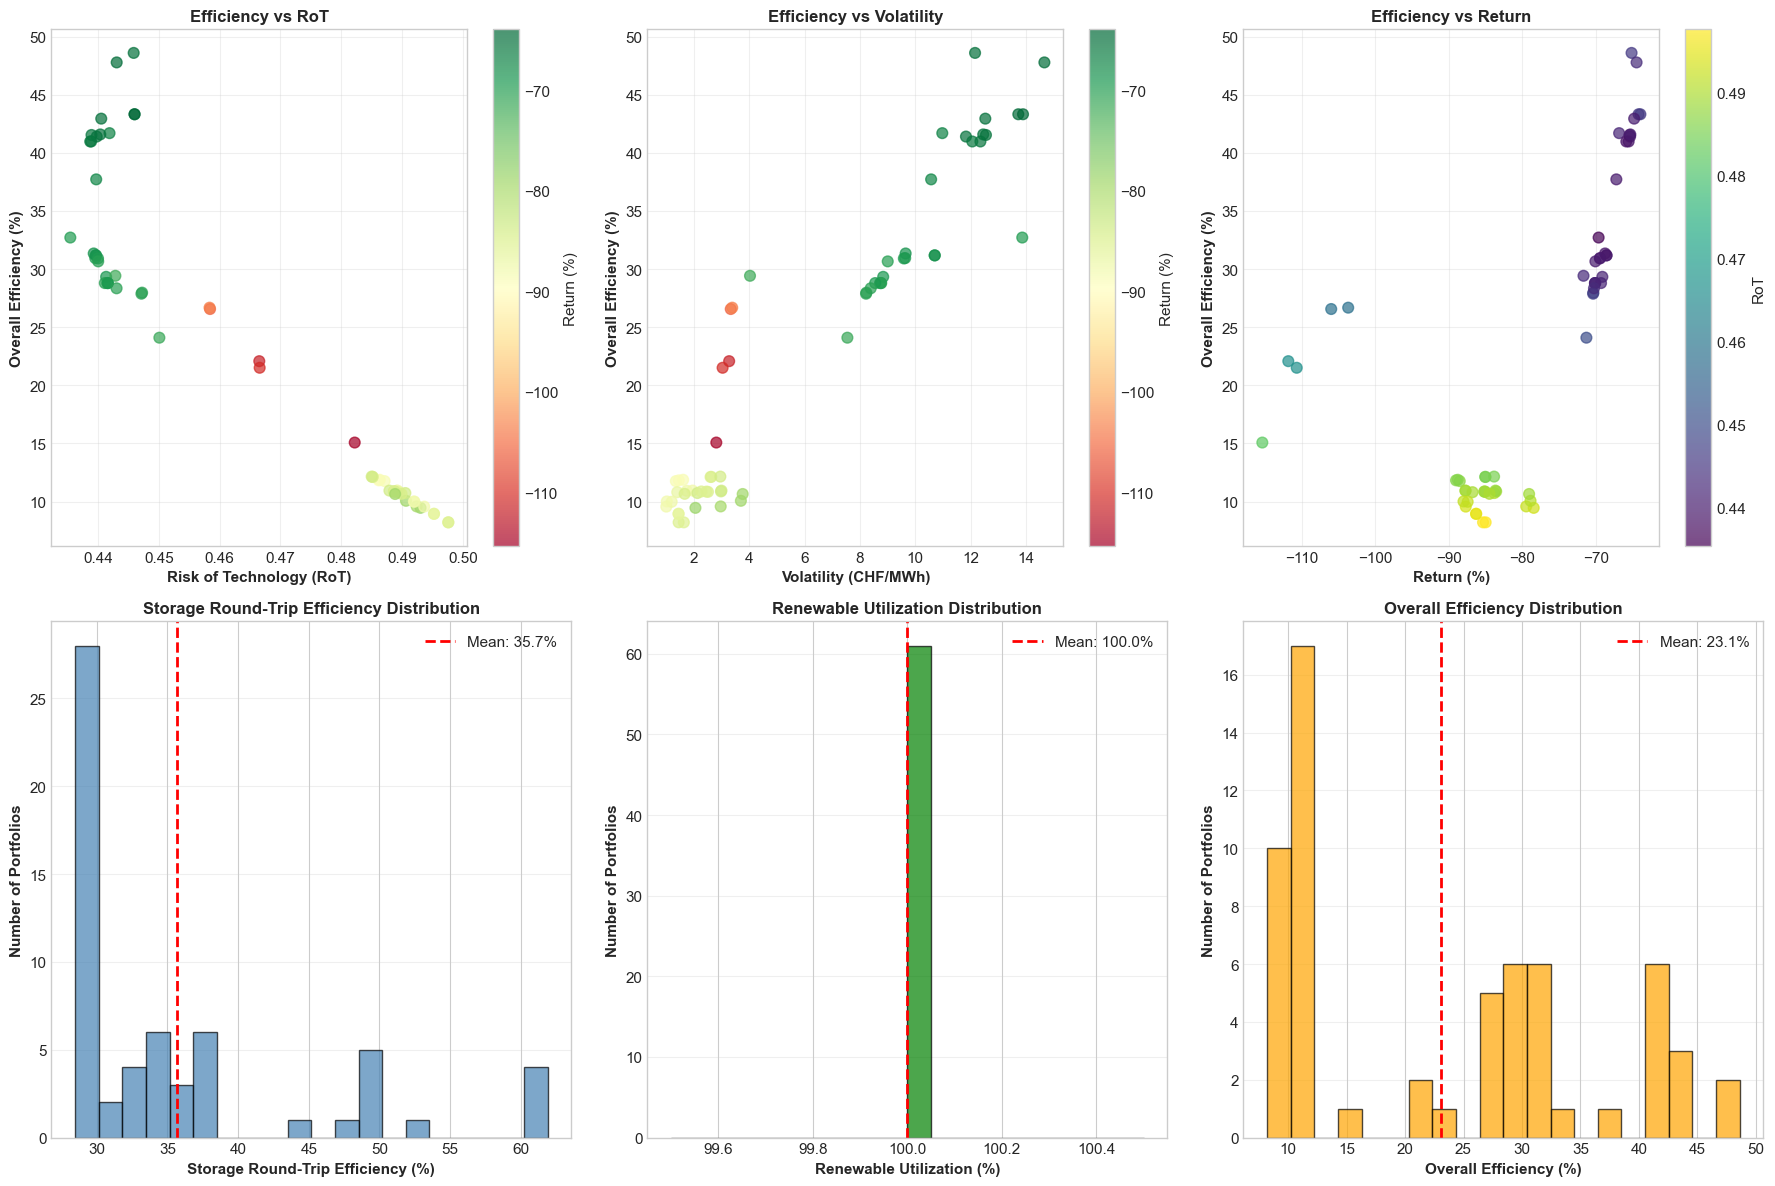


CREATING COMPREHENSIVE ENERGY BREAKDOWN VISUALIZATION

✅ Energy breakdown visualization saved to: data/result_plots/frontier_energy_breakdown.png


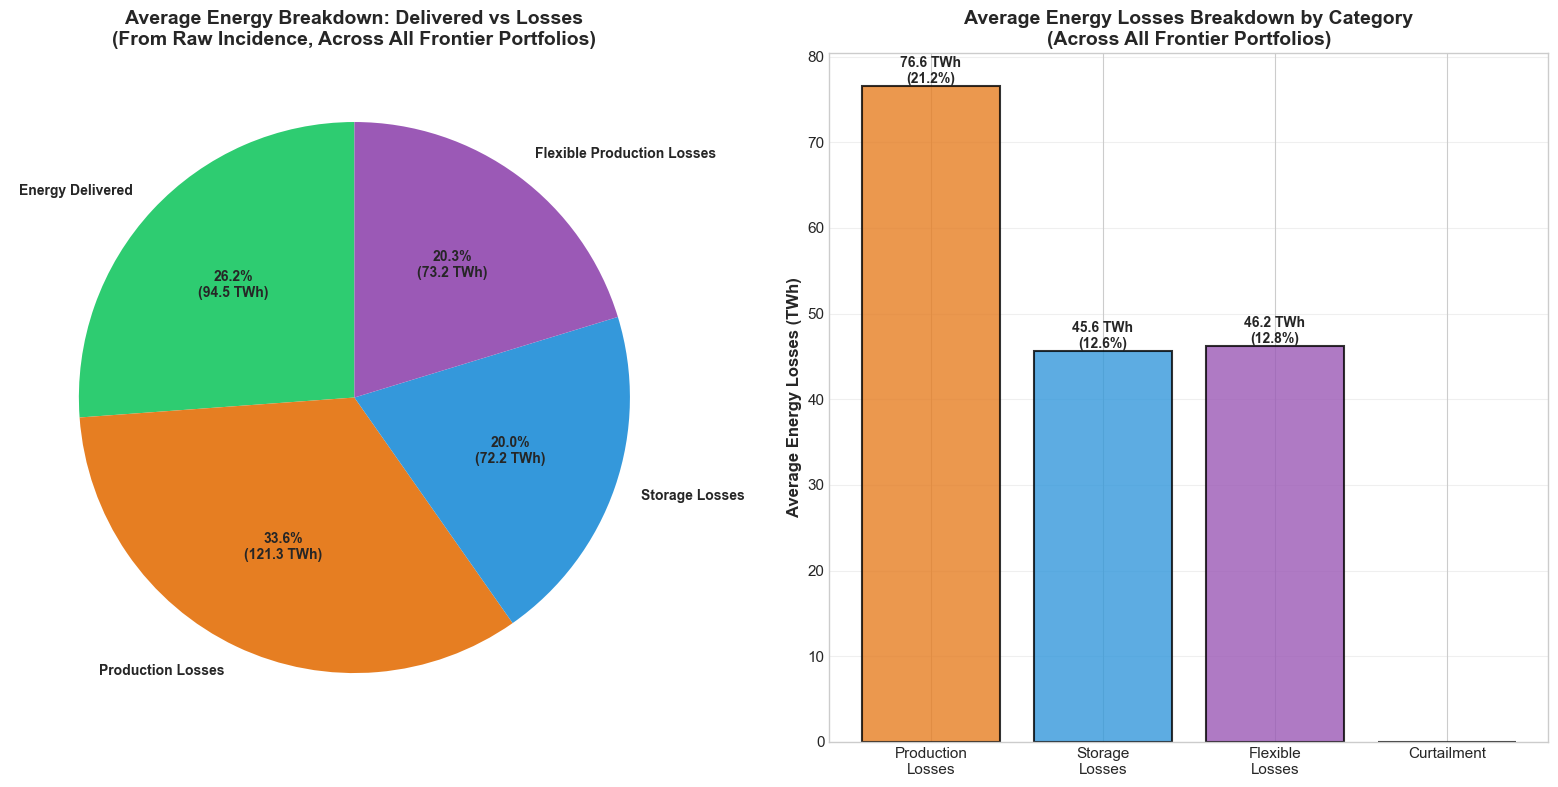


SUMMARY TABLE
       overall_efficiency  renewable_utilization  storage_rt_efficiency  storage_utilization      x_RoT  y_volatility    z_return
count           61.000000                   61.0              61.000000            61.000000  61.000000     61.000000   61.000000
mean            23.095924                  100.0              35.701455            30.536615   0.465199      6.153935  -78.917481
std             12.811345                    0.0               9.549095            11.786834   0.023731      4.474697   12.668965
min              8.205877                  100.0              28.461675            14.123005   0.435431      1.005732 -115.331259
25%             10.850932                  100.0              28.878997            18.428170   0.441321      2.130108  -86.277657
50%             24.097595                  100.0              32.286639            36.513318   0.458412      3.700817  -78.885434
75%             31.181135                  100.0              37.210833    

In [ ]:
# =============================================================================
# COMPREHENSIVE EFFICIENCY ANALYSIS: Full Simulation of All Frontier Portfolios
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
from tqdm import tqdm
import time

# Imports for simulation
from ppu_framework import Portfolio
from optimization import Individual, evaluate_portfolio_full_year
from config import Config
from data_loader import load_all_data

print("="*80)
print("COMPREHENSIVE EFFICIENCY ANALYSIS")
print("="*80)
print("Running full-year simulations for all frontier portfolios...")
print("This will calculate TRUE efficiency metrics (not available from CSV data)")
print()

# Load configuration
config = Config()
config.energy_system.DEMAND_SCENARIO = "2024"  # Use 2024 scenario
_data = load_all_data(config, force_reload=True)

# Load frontier portfolios
frontier_path = Path("data/result_plots/multi_objective_results_frontier_3d.csv")
if not frontier_path.exists():
    print(f"❌ Frontier file not found: {frontier_path}")
    print("   Please run Section 3.1 first to generate the frontier.")
else:
    frontier_df = pd.read_csv(frontier_path)
    print(f"✅ Loaded {len(frontier_df)} frontier portfolios")
    
    # Helper function to parse portfolio dictionary
    def parse_portfolio_dict(portfolio_str):
        """Parse portfolio dictionary from string."""
        if isinstance(portfolio_str, dict):
            return portfolio_str
        try:
            return ast.literal_eval(portfolio_str)
        except:
            try:
                return json.loads(portfolio_str)
            except:
                return {}
    
    # Prepare results storage
    efficiency_results = []
    
    print(f"\n⏳ Running full-year simulations for {len(frontier_df)} portfolios...")
    print(f"   Estimated time: {len(frontier_df) * 5 / 60:.1f} - {len(frontier_df) * 15 / 60:.1f} minutes")
    print()
    
    start_time = time.time()
    
    # Storage input PPUs (same as Section 3.1)
    storage_input_ppus = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_METH', 
                          'NH3_FULL', 'SYN_CRACK', 'CH4_BIO', 'SOL_SALT_STORE']
    
    # Process each portfolio with progress bar
    for idx, row in tqdm(frontier_df.iterrows(), total=len(frontier_df), desc="Simulating portfolios"):
        try:
            # Parse portfolio
            portfolio_dict = parse_portfolio_dict(row.get('portfolio_dict', {}))
            if not portfolio_dict:
                continue
            
            # Create portfolio and individual
            portfolio = Portfolio(ppu_counts=portfolio_dict)
            individual = Individual(portfolio=portfolio)
            
            # Run full-year simulation (verbose=False for cleaner output)
            full_year_results = evaluate_portfolio_full_year(
                individual=individual,
                config=config,
                verbose=False
            )
            
            # =====================================================================
            # COMPREHENSIVE ENERGY FLOW TRACKING (Same as PART 7)
            # =====================================================================
            renewable_production_twh = np.sum(full_year_results.renewable_production) / 1e6
            total_demand_twh = np.sum(full_year_results.demand) / 1e6
            total_production_twh = np.sum(full_year_results.total_production) / 1e6
            
            # Load PPU definitions for efficiency calculations
            from ppu_framework import load_all_ppu_data
            _, _, ppu_definitions = load_all_ppu_data(config)
            
            # =====================================================================
            # STEP 1: Estimate raw incidence energy (before conversion losses)
            # =====================================================================
            renewable_ppus = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
            total_units = 0
            efficiency_sum = 0.0
            
            for ppu_name in renewable_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_definitions:
                    ppu_def = ppu_definitions[ppu_name]
                    efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.84
                    total_units += count
                    efficiency_sum += efficiency * count
            
            avg_conversion_efficiency = efficiency_sum / total_units if total_units > 0 else 0.84
            raw_incidence_twh = renewable_production_twh / avg_conversion_efficiency if avg_conversion_efficiency > 0 else renewable_production_twh
            production_losses_twh = raw_incidence_twh - renewable_production_twh
            
            # =====================================================================
            # STEP 2: Calculate storage energy flows
            # =====================================================================
            ppu_production = full_year_results.ppu_production
            ppu_consumption = full_year_results.ppu_consumption
            
            storage_charged = 0.0
            for ppu in storage_input_ppus:
                if ppu in ppu_consumption:
                    prod_data = ppu_consumption[ppu]
                    if isinstance(prod_data, np.ndarray):
                        storage_charged += np.sum(prod_data) / 1e6  # TWh
            
            storage_discharged = 0.0
            if hasattr(full_year_results, 'storage_soc') and full_year_results.storage_soc:
                storage_soc_dict = full_year_results.storage_soc
                if isinstance(storage_soc_dict, dict) and len(storage_soc_dict) > 0:
                    from dispatch_engine import initialize_storage_state
                    try:
                        storages = initialize_storage_state(portfolio_dict, config)
                        for storage_name, soc_array in storage_soc_dict.items():
                            if storage_name not in storages:
                                continue
                            storage = storages[storage_name]
                            capacity_mwh = storage.capacity_mwh
                            efficiency_discharge = storage.efficiency_discharge
                            
                            if isinstance(soc_array, np.ndarray) and len(soc_array) > 1:
                                soc_mwh = soc_array * capacity_mwh
                                soc_changes = np.diff(soc_mwh)
                                discharging_changes = -soc_changes[soc_changes < 0]
                                if len(discharging_changes) > 0:
                                    energy_input_mwh = np.sum(discharging_changes)
                                    total_discharged_mwh = energy_input_mwh * efficiency_discharge
                                    storage_discharged += total_discharged_mwh / 1e6  # TWh
                    except:
                        pass
            
            if storage_discharged == 0 and storage_charged > 0:
                storage_discharged = storage_charged * 0.75  # Estimate 75% round-trip
            
            storage_losses_twh = max(0, storage_charged - storage_discharged)
            
            # =====================================================================
            # STEP 3: Calculate flexible production losses
            # =====================================================================
            flex_ppus = config.ppu.FLEX_PPUS
            flexible_production_twh = 0.0
            flexible_input_energy_twh = 0.0
            
            for ppu_name in flex_ppus:
                count = portfolio_dict.get(ppu_name, 0)
                if count > 0 and ppu_name in ppu_production:
                    prod_data = ppu_production[ppu_name]
                    if isinstance(prod_data, np.ndarray):
                        ppu_prod = np.sum(prod_data) / 1e6  # TWh
                        flexible_production_twh += ppu_prod
                        
                        if ppu_name in ppu_definitions:
                            ppu_def = ppu_definitions[ppu_name]
                            efficiency = ppu_def.efficiency if hasattr(ppu_def, 'efficiency') else 0.80
                            if efficiency > 0:
                                flexible_input_energy_twh += ppu_prod / efficiency
            
            flexible_losses_twh = max(0, flexible_input_energy_twh - flexible_production_twh)
            
            # =====================================================================
            # STEP 4: Track energy flows to demand
            # =====================================================================
            energy_delivered_twh = total_demand_twh
            renewable_direct_to_demand_twh = max(0, renewable_production_twh - storage_charged)
            storage_to_flexible_twh = min(storage_discharged, flexible_input_energy_twh) if flexible_input_energy_twh > 0 else 0
            storage_direct_to_demand_twh = max(0, storage_discharged - storage_to_flexible_twh)
            renewable_curtailed_twh = max(0, renewable_production_twh - storage_charged - renewable_direct_to_demand_twh)
            
            # =====================================================================
            # STEP 5: Calculate total losses and metrics
            # =====================================================================
            total_losses_twh = production_losses_twh + storage_losses_twh + flexible_losses_twh + renewable_curtailed_twh
            
            # Calculate effectiveness metrics
            overall_efficiency = (energy_delivered_twh / raw_incidence_twh * 100) if raw_incidence_twh > 0 else 0
            storage_rt_efficiency = (storage_discharged / storage_charged * 100) if storage_charged > 0 else 0
            renewable_utilization = min(100.0, (renewable_production_twh / total_demand_twh * 100)) if total_demand_twh > 0 else 0
            storage_utilization = (storage_charged / renewable_production_twh * 100) if renewable_production_twh > 0 else 0
            flexible_efficiency = (flexible_production_twh/flexible_input_energy_twh*100) if flexible_input_energy_twh > 0 else 0
            
            # Store results (comprehensive energy flow tracking)
            efficiency_results.append({
                'portfolio_idx': idx,
                'x_RoT': row['x_RoT'],
                'y_volatility': row['y_volatility'],
                'z_return': row['z_return'],
                # Energy flows
                'raw_incidence_twh': raw_incidence_twh,
                'renewable_production_twh': renewable_production_twh,
                'total_demand_twh': total_demand_twh,
                'total_production_twh': total_production_twh,
                'energy_delivered_twh': energy_delivered_twh,
                # Storage flows
                'storage_charged_twh': storage_charged,
                'storage_discharged_twh': storage_discharged,
                'storage_to_flexible_twh': storage_to_flexible_twh,
                'storage_direct_to_demand_twh': storage_direct_to_demand_twh,
                # Flexible production
                'flexible_production_twh': flexible_production_twh,
                'flexible_input_energy_twh': flexible_input_energy_twh,
                # Losses breakdown
                'production_losses_twh': production_losses_twh,
                'storage_losses_twh': storage_losses_twh,
                'flexible_losses_twh': flexible_losses_twh,
                'renewable_curtailed_twh': renewable_curtailed_twh,
                'total_losses_twh': total_losses_twh,
                # Metrics
                'renewable_utilization': renewable_utilization,
                'storage_utilization': storage_utilization,
                'storage_rt_efficiency': storage_rt_efficiency,
                'flexible_efficiency': flexible_efficiency,
                'overall_efficiency': overall_efficiency,
            })
            
        except Exception as e:
            print(f"\n⚠️  Error processing portfolio {idx}: {e}")
            continue
    
    elapsed_time = time.time() - start_time
    
    print(f"\n✅ Simulations complete!")
    print(f"   Time elapsed: {elapsed_time/60:.1f} minutes")
    print(f"   Successful simulations: {len(efficiency_results)}/{len(frontier_df)}")
    
    if len(efficiency_results) > 0:
        # Create results DataFrame
        eff_df = pd.DataFrame(efficiency_results)
        
        # Save results
        output_path = Path("data/result_plots/frontier_efficiency_analysis.csv")
        eff_df.to_csv(output_path, index=False)
        print(f"   Results saved to: {output_path}")
        
        # =====================================================================
        # ANALYSIS AND VISUALIZATION
        # =====================================================================
        
        print("\n" + "="*80)
        print("EFFICIENCY STATISTICS")
        print("="*80)
        
        print(f"\n📊 Overall Efficiency (Raw Incidence → Final Demand):")
        print(f"   Mean:     {eff_df['overall_efficiency'].mean():.2f}%")
        print(f"   Median:   {eff_df['overall_efficiency'].median():.2f}%")
        print(f"   Std Dev:  {eff_df['overall_efficiency'].std():.2f}%")
        print(f"   Min:      {eff_df['overall_efficiency'].min():.2f}%")
        print(f"   Max:      {eff_df['overall_efficiency'].max():.2f}%")
        print(f"   25th %ile: {eff_df['overall_efficiency'].quantile(0.25):.2f}%")
        print(f"   75th %ile: {eff_df['overall_efficiency'].quantile(0.75):.2f}%")
        
        print(f"\n📉 Energy Losses Breakdown (Average across all portfolios):")
        print(f"   Production Losses:     {eff_df['production_losses_twh'].mean():.2f} TWh ({eff_df['production_losses_twh'].mean()/eff_df['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   Storage Losses:        {eff_df['storage_losses_twh'].mean():.2f} TWh ({eff_df['storage_losses_twh'].mean()/eff_df['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   Flexible Production Losses: {eff_df['flexible_losses_twh'].mean():.2f} TWh ({eff_df['flexible_losses_twh'].mean()/eff_df['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   Curtailment/Other:     {eff_df['renewable_curtailed_twh'].mean():.2f} TWh ({eff_df['renewable_curtailed_twh'].mean()/eff_df['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        print(f"   TOTAL LOSSES:          {eff_df['total_losses_twh'].mean():.2f} TWh ({eff_df['total_losses_twh'].mean()/eff_df['raw_incidence_twh'].mean()*100:.1f}% of raw incidence)")
        
        print(f"\n⚡ Storage Round-Trip Efficiency:")
        valid_storage = eff_df[eff_df['storage_charged_twh'] > 0]
        if len(valid_storage) > 0:
            print(f"   Mean:     {valid_storage['storage_rt_efficiency'].mean():.2f}%")
            print(f"   Median:   {valid_storage['storage_rt_efficiency'].median():.2f}%")
            print(f"   Min:      {valid_storage['storage_rt_efficiency'].min():.2f}%")
            print(f"   Max:      {valid_storage['storage_rt_efficiency'].max():.2f}%")
        else:
            print("   No portfolios with storage usage")
        
        print(f"\n🌱 Renewable Utilization (% of demand from renewable):")
        print(f"   Mean:     {eff_df['renewable_utilization'].mean():.2f}%")
        print(f"   Median:   {eff_df['renewable_utilization'].median():.2f}%")
        print(f"   Min:      {eff_df['renewable_utilization'].min():.2f}%")
        print(f"   Max:      {eff_df['renewable_utilization'].max():.2f}%")
        
        print(f"\n🔗 Efficiency vs Objectives Correlations:")
        print(f"   Efficiency vs RoT:       {eff_df['overall_efficiency'].corr(eff_df['x_RoT']):.3f}")
        print(f"   Efficiency vs Volatility: {eff_df['overall_efficiency'].corr(eff_df['y_volatility']):.3f}")
        print(f"   Efficiency vs Return:     {eff_df['overall_efficiency'].corr(eff_df['z_return']):.3f}")
        
        # Best and worst efficiency portfolios
        best_eff_idx = eff_df['overall_efficiency'].idxmax()
        worst_eff_idx = eff_df['overall_efficiency'].idxmin()
        
        print(f"\n🏆 Best Efficiency Portfolio:")
        best_row = eff_df.loc[best_eff_idx]
        print(f"   Efficiency: {best_row['overall_efficiency']:.2f}%")
        print(f"   RoT: {best_row['x_RoT']:.4f}, Vol: {best_row['y_volatility']:.2f}, Ret: {best_row['z_return']:.2f}%")
        print(f"   Renewable Utilization: {best_row['renewable_utilization']:.2f}%")
        print(f"   Storage RT Efficiency: {best_row['storage_rt_efficiency']:.2f}%")
        
        print(f"\n⚠️  Worst Efficiency Portfolio:")
        worst_row = eff_df.loc[worst_eff_idx]
        print(f"   Efficiency: {worst_row['overall_efficiency']:.2f}%")
        print(f"   RoT: {worst_row['x_RoT']:.4f}, Vol: {worst_row['y_volatility']:.2f}, Ret: {worst_row['z_return']:.2f}%")
        print(f"   Renewable Utilization: {worst_row['renewable_utilization']:.2f}%")
        print(f"   Storage RT Efficiency: {worst_row['storage_rt_efficiency']:.2f}%")
        
        # =====================================================================
        # VISUALIZATIONS
        # =====================================================================
        
        print("\n" + "="*80)
        print("CREATING VISUALIZATIONS")
        print("="*80)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Efficiency vs RoT
        ax1 = axes[0, 0]
        scatter1 = ax1.scatter(eff_df['x_RoT'], eff_df['overall_efficiency'], 
                               c=eff_df['z_return'], cmap='RdYlGn', alpha=0.7, s=60)
        ax1.set_xlabel('Risk of Technology (RoT)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax1.set_title('Efficiency vs RoT', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter1, ax=ax1, label='Return (%)')
        
        # 2. Efficiency vs Volatility
        ax2 = axes[0, 1]
        scatter2 = ax2.scatter(eff_df['y_volatility'], eff_df['overall_efficiency'],
                               c=eff_df['z_return'], cmap='RdYlGn', alpha=0.7, s=60)
        ax2.set_xlabel('Volatility (CHF/MWh)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Efficiency vs Volatility', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=ax2, label='Return (%)')
        
        # 3. Efficiency vs Return
        ax3 = axes[0, 2]
        scatter3 = ax3.scatter(eff_df['z_return'], eff_df['overall_efficiency'],
                               c=eff_df['x_RoT'], cmap='viridis', alpha=0.7, s=60)
        ax3.set_xlabel('Return (%)', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax3.set_title('Efficiency vs Return', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter3, ax=ax3, label='RoT')
        
        # 4. Storage RT Efficiency distribution
        ax4 = axes[1, 0]
        valid_storage = eff_df[eff_df['storage_charged_twh'] > 0]
        if len(valid_storage) > 0:
            ax4.hist(valid_storage['storage_rt_efficiency'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
            ax4.axvline(valid_storage['storage_rt_efficiency'].mean(), color='red', linestyle='--', 
                       linewidth=2, label=f"Mean: {valid_storage['storage_rt_efficiency'].mean():.1f}%")
            ax4.set_xlabel('Storage Round-Trip Efficiency (%)', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
            ax4.set_title('Storage Round-Trip Efficiency Distribution', fontsize=12, fontweight='bold')
            ax4.legend()
            ax4.grid(True, alpha=0.3, axis='y')
        else:
            ax4.text(0.5, 0.5, 'No storage usage', ha='center', va='center', 
                    transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Storage RT Efficiency (N/A)', fontsize=12, fontweight='bold')
        
        # 5. Renewable Utilization distribution
        ax5 = axes[1, 1]
        ax5.hist(eff_df['renewable_utilization'], bins=20, alpha=0.7, color='green', edgecolor='black')
        ax5.axvline(eff_df['renewable_utilization'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {eff_df['renewable_utilization'].mean():.1f}%")
        ax5.set_xlabel('Renewable Utilization (%)', fontsize=11, fontweight='bold')
        ax5.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
        ax5.set_title('Renewable Utilization Distribution', fontsize=12, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 6. Efficiency distribution
        ax6 = axes[1, 2]
        ax6.hist(eff_df['overall_efficiency'], bins=20, alpha=0.7, color='orange', edgecolor='black')
        ax6.axvline(eff_df['overall_efficiency'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {eff_df['overall_efficiency'].mean():.1f}%")
        ax6.set_xlabel('Overall Efficiency (%)', fontsize=11, fontweight='bold')
        ax6.set_ylabel('Number of Portfolios', fontsize=11, fontweight='bold')
        ax6.set_title('Overall Efficiency Distribution', fontsize=12, fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('data/result_plots/frontier_efficiency_analysis.png', dpi=150, bbox_inches='tight')
        print(f"\n✅ Visualization saved to: data/result_plots/frontier_efficiency_analysis.png")
        plt.show()
        
        # =====================================================================
        # COMPREHENSIVE ENERGY BREAKDOWN PIE CHART (Average across all portfolios)
        # =====================================================================
        print("\n" + "="*80)
        print("CREATING COMPREHENSIVE ENERGY BREAKDOWN VISUALIZATION")
        print("="*80)
        
        # Calculate average values across all portfolios
        avg_raw_incidence = eff_df['raw_incidence_twh'].mean()
        avg_energy_delivered = eff_df['energy_delivered_twh'].mean()
        avg_production_losses = eff_df['production_losses_twh'].mean()
        avg_storage_losses = eff_df['storage_losses_twh'].mean()
        avg_flexible_losses = eff_df['flexible_losses_twh'].mean()
        avg_curtailed = eff_df['renewable_curtailed_twh'].mean()
        
        fig_pie, axes_pie = plt.subplots(1, 2, figsize=(16, 8))
        
        # Pie chart: Energy breakdown (delivered vs losses)
        ax1 = axes_pie[0]
        pie_data = {
            'Energy Delivered': avg_energy_delivered,
            'Production Losses': avg_production_losses,
            'Storage Losses': avg_storage_losses,
            'Flexible Production Losses': avg_flexible_losses,
            'Curtailment/Other': avg_curtailed
        }
        
        # Filter out zero or negative values
        pie_data = {k: max(0, v) for k, v in pie_data.items() if v > 0.01}
        
        if pie_data:
            colors_pie = ['#2ecc71', '#e67e22', '#3498db', '#9b59b6', '#95a5a6']
            wedges, texts, autotexts = ax1.pie(
                list(pie_data.values()),
                labels=list(pie_data.keys()),
                autopct=lambda pct: f'{pct:.1f}%\n({pct*avg_raw_incidence/100:.1f} TWh)',
                colors=colors_pie[:len(pie_data)],
                startangle=90,
                textprops={'fontsize': 10, 'fontweight': 'bold'}
            )
            ax1.set_title('Average Energy Breakdown: Delivered vs Losses\n(From Raw Incidence, Across All Frontier Portfolios)', 
                         fontsize=14, fontweight='bold')
        
        # Bar chart: Loss breakdown by category
        ax2 = axes_pie[1]
        loss_categories = ['Production\nLosses', 'Storage\nLosses', 'Flexible\nLosses', 'Curtailment']
        loss_values = [avg_production_losses, avg_storage_losses, avg_flexible_losses, avg_curtailed]
        loss_colors = ['#e67e22', '#3498db', '#9b59b6', '#95a5a6']
        
        bars = ax2.bar(loss_categories, loss_values, color=loss_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Average Energy Losses (TWh)', fontsize=12, fontweight='bold')
        ax2.set_title('Average Energy Losses Breakdown by Category\n(Across All Frontier Portfolios)', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, loss_values):
            if val > 0.01:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.1f} TWh\n({val/avg_raw_incidence*100:.1f}%)',
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('data/result_plots/frontier_energy_breakdown.png', dpi=150, bbox_inches='tight')
        print(f"\n✅ Energy breakdown visualization saved to: data/result_plots/frontier_energy_breakdown.png")
        plt.show()
        
        # Summary table
        print("\n" + "="*80)
        print("SUMMARY TABLE")
        print("="*80)
        summary_cols = ['overall_efficiency', 'renewable_utilization', 'storage_rt_efficiency', 
                       'storage_utilization', 'x_RoT', 'y_volatility', 'z_return']
        summary_df = eff_df[summary_cols].describe()
        print(summary_df.to_string())
        
        print("\n" + "="*80)
        print("✅ Comprehensive Efficiency Analysis Complete")
        print("="*80)
        print(f"\n💡 Key Insights:")
        print(f"   • Average efficiency: {eff_df['overall_efficiency'].mean():.1f}%")
        print(f"   • Efficiency range: {eff_df['overall_efficiency'].min():.1f}% - {eff_df['overall_efficiency'].max():.1f}%")
        print(f"   • Typical efficiency values (30-50%) indicate significant losses from:")
        print(f"     - Storage round-trip losses (~25-50%)")
        print(f"     - Conversion losses in PPU chains (~5-20%)")
        print(f"     - Curtailment and other losses")
        print(f"   • Higher efficiency portfolios typically have:")
        print(f"     - Lower storage utilization")
        print(f"     - More direct renewable use")
        print(f"     - Higher storage round-trip efficiency")
    else:
        print("\n❌ No successful simulations. Check for errors above.")


---

## Summary

This notebook provides a complete framework for:

0. **External Data Overview:** Visualization of all input data (solar, wind, spot price, palm oil, etc.)
1. **Dispatch Simulation:** Full year hourly simulation with storage management
2. **Genetic Optimization:** Multi-objective portfolio optimization
3. **Pareto Analysis:** 3D frontier identification and visualization

### Key Features (v2.0)
- **Palm oil only:** Biooil removed; Palm oil is the only imported bio-fuel
- **Aviation fuel from Fuel Tank:** Synthetic fuel supplies 23 TWh/year aviation requirement
- **Dynamic pricing:** Palm oil prices from REA Holdings futures (USD/ton → CHF/MWh)
- **Water inflow to lakes:** Precipitation-based inflow at 0.9 kWh/m³
- **EUR→CHF conversion:** Spot prices converted using daily exchange rates
- **LCOE from analysis:** Pre-computed efficiency and costs with parallelism
- Storage capacity caps (50 TWh for H2/CH4/NH3, 25 TWh for Fuel/Biogas)
- Ghost PPU mechanism for palm oil import regulation
- 3D Pareto frontier (RoT, Volatility, Return)

### Output Files
- `data/result_plots/external_data_overview.png` - External data visualization
- `data/result_plots/multi_objective_results.csv` - All evaluated portfolios
- `data/result_plots/multi_objective_results_final_frontier_3d.csv` - Pareto frontier
- Various PNG visualizations
